##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.11.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official==2.11.0

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-02-16 12:23:51.908707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 12:23:51.908797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-16 12:23:51.908806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


    8192/84125825 [..............................] - ETA: 0s


   40960/84125825 [..............................] - ETA: 2:50


  106496/84125825 [..............................] - ETA: 2:11


  204800/84125825 [..............................] - ETA: 1:42


  335872/84125825 [..............................] - ETA: 1:22


  532480/84125825 [..............................] - ETA: 1:05


  794624/84125825 [..............................] - ETA: 52s 


 1171456/84125825 [..............................] - ETA: 41s


 1662976/84125825 [..............................] - ETA: 33s


 2334720/84125825 [..............................] - ETA: 26s


 3284992/84125825 [>.............................] - ETA: 20s


 4595712/84125825 [>.............................] - ETA: 15s


 6283264/84125825 [=>............................] - ETA: 11s


 7512064/84125825 [=>............................] - ETA: 10s


 9592832/84125825 [==>...........................] - ETA: 8s 


12132352/84125825 [===>..........................] - ETA: 6s


14950400/84125825 [====>.........................] - ETA: 5s


18128896/84125825 [=====>........................] - ETA: 4s


21889024/84125825 [======>.......................] - ETA: 3s


25387008/84125825 [========>.....................] - ETA: 3s


28696576/84125825 [=========>....................] - ETA: 2s


32342016/84125825 [==========>...................] - ETA: 2s


36003840/84125825 [===========>..................] - ETA: 2s


39428096/84125825 [=============>................] - ETA: 1s


43245568/84125825 [==============>...............] - ETA: 1s


46964736/84125825 [===============>..............] - ETA: 1s


50503680/84125825 [=================>............] - ETA: 1s


54140928/84125825 [==================>...........] - ETA: 0s


57581568/84125825 [===================>..........] - ETA: 0s


60907520/84125825 [====================>.........] - ETA: 0s


64544768/84125825 [======================>.......] - ETA: 0s


68231168/84125825 [=======================>......] - ETA: 0s


71950336/84125825 [========================>.....] - ETA: 0s


75603968/84125825 [=========================>....] - ETA: 0s


79011840/84125825 [===========================>..] - ETA: 0s


82665472/84125825 [============================>.] - ETA: 0s


84125825/84125825 [==============================] - 2s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2023-02-16 12:24:15.246637: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611856  0.36673826  0.15233693  0.65504473
  0.9681154  -0.94862705  0.0021619  -0.9877732   0.06842698 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300808  0.71020824
  -0.05771172]
 [-0.2874203   0.31981018 -0.2301853  ...  0.58455014 -0.21329692
   0.7269214 ]
 [-0.66157     0.6887689  -0.8743298  ...  0.10877271 -0.26173168
   0.47855347]
 ...
 [-0.22561166 -0.28925633 -0.07064366 ...  0.47566074  0.83277154
   0.4002533 ]
 [-0.29824263 -0.2747314  -0.05450518 ...  0.48849723  1.095536
   0.18163356]
 [-0.443782    0.00930692  0.07223746 ...  0.17290054  1.1833245
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6862828]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

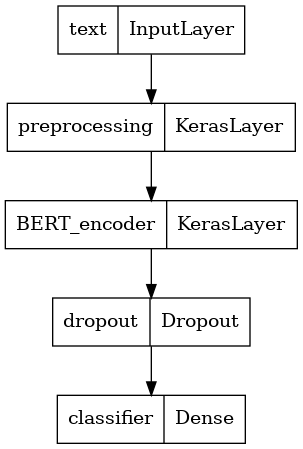

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5



  1/625 [..............................] - ETA: 58:15 - loss: 0.7051 - binary_accuracy: 0.6875


  2/625 [..............................] - ETA: 1:31 - loss: 0.7372 - binary_accuracy: 0.5781 


  3/625 [..............................] - ETA: 1:30 - loss: 0.6858 - binary_accuracy: 0.6146


  4/625 [..............................] - ETA: 1:29 - loss: 0.6995 - binary_accuracy: 0.6094


  5/625 [..............................] - ETA: 1:30 - loss: 0.6907 - binary_accuracy: 0.6062


  6/625 [..............................] - ETA: 1:29 - loss: 0.7075 - binary_accuracy: 0.5990


  7/625 [..............................] - ETA: 1:29 - loss: 0.7120 - binary_accuracy: 0.6205


  8/625 [..............................] - ETA: 1:29 - loss: 0.7266 - binary_accuracy: 0.6016


  9/625 [..............................] - ETA: 1:29 - loss: 0.7302 - binary_accuracy: 0.5938


 10/625 [..............................] - ETA: 1:28 - loss: 0.7295 - binary_accuracy: 0.5719


 11/625 [..............................] - ETA: 1:28 - loss: 0.7308 - binary_accuracy: 0.5625


 12/625 [..............................] - ETA: 1:27 - loss: 0.7221 - binary_accuracy: 0.5547


 13/625 [..............................] - ETA: 1:27 - loss: 0.7219 - binary_accuracy: 0.5529


 14/625 [..............................] - ETA: 1:27 - loss: 0.7209 - binary_accuracy: 0.5491


 15/625 [..............................] - ETA: 1:27 - loss: 0.7148 - binary_accuracy: 0.5562


 16/625 [..............................] - ETA: 1:26 - loss: 0.7178 - binary_accuracy: 0.5566


 17/625 [..............................] - ETA: 1:26 - loss: 0.7226 - binary_accuracy: 0.5404


 18/625 [..............................] - ETA: 1:26 - loss: 0.7246 - binary_accuracy: 0.5399


 19/625 [..............................] - ETA: 1:26 - loss: 0.7222 - binary_accuracy: 0.5411


 20/625 [..............................] - ETA: 1:26 - loss: 0.7238 - binary_accuracy: 0.5375


 21/625 [>.............................] - ETA: 1:26 - loss: 0.7202 - binary_accuracy: 0.5417


 22/625 [>.............................] - ETA: 1:25 - loss: 0.7186 - binary_accuracy: 0.5398


 23/625 [>.............................] - ETA: 1:25 - loss: 0.7182 - binary_accuracy: 0.5367


 24/625 [>.............................] - ETA: 1:25 - loss: 0.7133 - binary_accuracy: 0.5469


 25/625 [>.............................] - ETA: 1:25 - loss: 0.7152 - binary_accuracy: 0.5437


 26/625 [>.............................] - ETA: 1:25 - loss: 0.7148 - binary_accuracy: 0.5409


 27/625 [>.............................] - ETA: 1:25 - loss: 0.7134 - binary_accuracy: 0.5370


 28/625 [>.............................] - ETA: 1:25 - loss: 0.7136 - binary_accuracy: 0.5379


 29/625 [>.............................] - ETA: 1:24 - loss: 0.7185 - binary_accuracy: 0.5323


 30/625 [>.............................] - ETA: 1:24 - loss: 0.7189 - binary_accuracy: 0.5312


 31/625 [>.............................] - ETA: 1:24 - loss: 0.7150 - binary_accuracy: 0.5353


 32/625 [>.............................] - ETA: 1:24 - loss: 0.7136 - binary_accuracy: 0.5371


 33/625 [>.............................] - ETA: 1:24 - loss: 0.7140 - binary_accuracy: 0.5388


 34/625 [>.............................] - ETA: 1:24 - loss: 0.7143 - binary_accuracy: 0.5377


 35/625 [>.............................] - ETA: 1:24 - loss: 0.7111 - binary_accuracy: 0.5411


 36/625 [>.............................] - ETA: 1:23 - loss: 0.7110 - binary_accuracy: 0.5408


 37/625 [>.............................] - ETA: 1:23 - loss: 0.7109 - binary_accuracy: 0.5422


 38/625 [>.............................] - ETA: 1:23 - loss: 0.7100 - binary_accuracy: 0.5436


 39/625 [>.............................] - ETA: 1:23 - loss: 0.7103 - binary_accuracy: 0.5425


 40/625 [>.............................] - ETA: 1:23 - loss: 0.7096 - binary_accuracy: 0.5422


 41/625 [>.............................] - ETA: 1:22 - loss: 0.7079 - binary_accuracy: 0.5465


 42/625 [=>............................] - ETA: 1:22 - loss: 0.7079 - binary_accuracy: 0.5461


 43/625 [=>............................] - ETA: 1:22 - loss: 0.7076 - binary_accuracy: 0.5494


 44/625 [=>............................] - ETA: 1:22 - loss: 0.7084 - binary_accuracy: 0.5483


 45/625 [=>............................] - ETA: 1:22 - loss: 0.7107 - binary_accuracy: 0.5465


 46/625 [=>............................] - ETA: 1:22 - loss: 0.7104 - binary_accuracy: 0.5489


 47/625 [=>............................] - ETA: 1:21 - loss: 0.7091 - binary_accuracy: 0.5492


 48/625 [=>............................] - ETA: 1:21 - loss: 0.7075 - binary_accuracy: 0.5534


 49/625 [=>............................] - ETA: 1:21 - loss: 0.7063 - binary_accuracy: 0.5542


 50/625 [=>............................] - ETA: 1:21 - loss: 0.7047 - binary_accuracy: 0.5550


 51/625 [=>............................] - ETA: 1:21 - loss: 0.7028 - binary_accuracy: 0.5539


 52/625 [=>............................] - ETA: 1:21 - loss: 0.7010 - binary_accuracy: 0.5535


 53/625 [=>............................] - ETA: 1:21 - loss: 0.7024 - binary_accuracy: 0.5519


 54/625 [=>............................] - ETA: 1:20 - loss: 0.7028 - binary_accuracy: 0.5509


 55/625 [=>............................] - ETA: 1:20 - loss: 0.7021 - binary_accuracy: 0.5506


 56/625 [=>............................] - ETA: 1:20 - loss: 0.7017 - binary_accuracy: 0.5497


 57/625 [=>............................] - ETA: 1:20 - loss: 0.7008 - binary_accuracy: 0.5488


 58/625 [=>............................] - ETA: 1:20 - loss: 0.6998 - binary_accuracy: 0.5474


 59/625 [=>............................] - ETA: 1:20 - loss: 0.6989 - binary_accuracy: 0.5487


 60/625 [=>............................] - ETA: 1:19 - loss: 0.6983 - binary_accuracy: 0.5510


 61/625 [=>............................] - ETA: 1:19 - loss: 0.6967 - binary_accuracy: 0.5533


 62/625 [=>............................] - ETA: 1:19 - loss: 0.6959 - binary_accuracy: 0.5534


 63/625 [==>...........................] - ETA: 1:19 - loss: 0.6968 - binary_accuracy: 0.5541


 64/625 [==>...........................] - ETA: 1:19 - loss: 0.6949 - binary_accuracy: 0.5557


 65/625 [==>...........................] - ETA: 1:19 - loss: 0.6964 - binary_accuracy: 0.5543


 66/625 [==>...........................] - ETA: 1:19 - loss: 0.6956 - binary_accuracy: 0.5559


 67/625 [==>...........................] - ETA: 1:18 - loss: 0.6943 - binary_accuracy: 0.5569


 68/625 [==>...........................] - ETA: 1:18 - loss: 0.6941 - binary_accuracy: 0.5574


 69/625 [==>...........................] - ETA: 1:18 - loss: 0.6926 - binary_accuracy: 0.5575


 70/625 [==>...........................] - ETA: 1:18 - loss: 0.6922 - binary_accuracy: 0.5576


 71/625 [==>...........................] - ETA: 1:18 - loss: 0.6910 - binary_accuracy: 0.5599


 72/625 [==>...........................] - ETA: 1:18 - loss: 0.6900 - binary_accuracy: 0.5603


 73/625 [==>...........................] - ETA: 1:17 - loss: 0.6896 - binary_accuracy: 0.5595


 74/625 [==>...........................] - ETA: 1:17 - loss: 0.6884 - binary_accuracy: 0.5604


 75/625 [==>...........................] - ETA: 1:17 - loss: 0.6878 - binary_accuracy: 0.5596


 76/625 [==>...........................] - ETA: 1:17 - loss: 0.6884 - binary_accuracy: 0.5584


 77/625 [==>...........................] - ETA: 1:17 - loss: 0.6869 - binary_accuracy: 0.5593


 78/625 [==>...........................] - ETA: 1:17 - loss: 0.6863 - binary_accuracy: 0.5589


 79/625 [==>...........................] - ETA: 1:17 - loss: 0.6847 - binary_accuracy: 0.5617


 80/625 [==>...........................] - ETA: 1:16 - loss: 0.6835 - binary_accuracy: 0.5617


 81/625 [==>...........................] - ETA: 1:16 - loss: 0.6812 - binary_accuracy: 0.5648


 82/625 [==>...........................] - ETA: 1:16 - loss: 0.6799 - binary_accuracy: 0.5659


 83/625 [==>...........................] - ETA: 1:16 - loss: 0.6807 - binary_accuracy: 0.5663


 84/625 [===>..........................] - ETA: 1:16 - loss: 0.6789 - binary_accuracy: 0.5685


 85/625 [===>..........................] - ETA: 1:16 - loss: 0.6792 - binary_accuracy: 0.5691


 86/625 [===>..........................] - ETA: 1:16 - loss: 0.6791 - binary_accuracy: 0.5701


 87/625 [===>..........................] - ETA: 1:15 - loss: 0.6772 - binary_accuracy: 0.5722


 88/625 [===>..........................] - ETA: 1:15 - loss: 0.6771 - binary_accuracy: 0.5728


 89/625 [===>..........................] - ETA: 1:15 - loss: 0.6773 - binary_accuracy: 0.5730


 90/625 [===>..........................] - ETA: 1:15 - loss: 0.6788 - binary_accuracy: 0.5712


 91/625 [===>..........................] - ETA: 1:15 - loss: 0.6783 - binary_accuracy: 0.5728


 92/625 [===>..........................] - ETA: 1:15 - loss: 0.6771 - binary_accuracy: 0.5740


 93/625 [===>..........................] - ETA: 1:15 - loss: 0.6767 - binary_accuracy: 0.5749


 94/625 [===>..........................] - ETA: 1:14 - loss: 0.6770 - binary_accuracy: 0.5748


 95/625 [===>..........................] - ETA: 1:14 - loss: 0.6767 - binary_accuracy: 0.5750


 96/625 [===>..........................] - ETA: 1:14 - loss: 0.6754 - binary_accuracy: 0.5778


 97/625 [===>..........................] - ETA: 1:14 - loss: 0.6756 - binary_accuracy: 0.5776


 98/625 [===>..........................] - ETA: 1:14 - loss: 0.6743 - binary_accuracy: 0.5784


 99/625 [===>..........................] - ETA: 1:14 - loss: 0.6736 - binary_accuracy: 0.5795


100/625 [===>..........................] - ETA: 1:14 - loss: 0.6732 - binary_accuracy: 0.5797


101/625 [===>..........................] - ETA: 1:13 - loss: 0.6732 - binary_accuracy: 0.5786


102/625 [===>..........................] - ETA: 1:13 - loss: 0.6730 - binary_accuracy: 0.5778


103/625 [===>..........................] - ETA: 1:13 - loss: 0.6717 - binary_accuracy: 0.5786


104/625 [===>..........................] - ETA: 1:13 - loss: 0.6702 - binary_accuracy: 0.5808


105/625 [====>.........................] - ETA: 1:13 - loss: 0.6695 - binary_accuracy: 0.5815


106/625 [====>.........................] - ETA: 1:13 - loss: 0.6691 - binary_accuracy: 0.5814


107/625 [====>.........................] - ETA: 1:13 - loss: 0.6683 - binary_accuracy: 0.5824


108/625 [====>.........................] - ETA: 1:12 - loss: 0.6675 - binary_accuracy: 0.5833


109/625 [====>.........................] - ETA: 1:12 - loss: 0.6671 - binary_accuracy: 0.5834


110/625 [====>.........................] - ETA: 1:12 - loss: 0.6663 - binary_accuracy: 0.5832


111/625 [====>.........................] - ETA: 1:12 - loss: 0.6657 - binary_accuracy: 0.5839


112/625 [====>.........................] - ETA: 1:12 - loss: 0.6647 - binary_accuracy: 0.5848


113/625 [====>.........................] - ETA: 1:12 - loss: 0.6642 - binary_accuracy: 0.5855


114/625 [====>.........................] - ETA: 1:12 - loss: 0.6641 - binary_accuracy: 0.5863


115/625 [====>.........................] - ETA: 1:11 - loss: 0.6632 - binary_accuracy: 0.5875


116/625 [====>.........................] - ETA: 1:11 - loss: 0.6633 - binary_accuracy: 0.5873


117/625 [====>.........................] - ETA: 1:11 - loss: 0.6631 - binary_accuracy: 0.5863


118/625 [====>.........................] - ETA: 1:11 - loss: 0.6626 - binary_accuracy: 0.5863


119/625 [====>.........................] - ETA: 1:11 - loss: 0.6622 - binary_accuracy: 0.5869


120/625 [====>.........................] - ETA: 1:11 - loss: 0.6614 - binary_accuracy: 0.5883


121/625 [====>.........................] - ETA: 1:11 - loss: 0.6613 - binary_accuracy: 0.5878


122/625 [====>.........................] - ETA: 1:11 - loss: 0.6609 - binary_accuracy: 0.5884


123/625 [====>.........................] - ETA: 1:10 - loss: 0.6609 - binary_accuracy: 0.5882


124/625 [====>.........................] - ETA: 1:10 - loss: 0.6601 - binary_accuracy: 0.5892


125/625 [=====>........................] - ETA: 1:10 - loss: 0.6592 - binary_accuracy: 0.5907


126/625 [=====>........................] - ETA: 1:10 - loss: 0.6581 - binary_accuracy: 0.5923


127/625 [=====>........................] - ETA: 1:10 - loss: 0.6568 - binary_accuracy: 0.5933


128/625 [=====>........................] - ETA: 1:10 - loss: 0.6554 - binary_accuracy: 0.5950


129/625 [=====>........................] - ETA: 1:10 - loss: 0.6556 - binary_accuracy: 0.5962


130/625 [=====>........................] - ETA: 1:09 - loss: 0.6558 - binary_accuracy: 0.5954


131/625 [=====>........................] - ETA: 1:09 - loss: 0.6553 - binary_accuracy: 0.5957


132/625 [=====>........................] - ETA: 1:09 - loss: 0.6544 - binary_accuracy: 0.5966


133/625 [=====>........................] - ETA: 1:09 - loss: 0.6532 - binary_accuracy: 0.5973


134/625 [=====>........................] - ETA: 1:09 - loss: 0.6527 - binary_accuracy: 0.5986


135/625 [=====>........................] - ETA: 1:09 - loss: 0.6519 - binary_accuracy: 0.5993


136/625 [=====>........................] - ETA: 1:09 - loss: 0.6504 - binary_accuracy: 0.6004


137/625 [=====>........................] - ETA: 1:08 - loss: 0.6493 - binary_accuracy: 0.6015


138/625 [=====>........................] - ETA: 1:08 - loss: 0.6487 - binary_accuracy: 0.6010


139/625 [=====>........................] - ETA: 1:08 - loss: 0.6479 - binary_accuracy: 0.6009


140/625 [=====>........................] - ETA: 1:08 - loss: 0.6474 - binary_accuracy: 0.6018


141/625 [=====>........................] - ETA: 1:08 - loss: 0.6469 - binary_accuracy: 0.6024


142/625 [=====>........................] - ETA: 1:08 - loss: 0.6459 - binary_accuracy: 0.6028


143/625 [=====>........................] - ETA: 1:08 - loss: 0.6457 - binary_accuracy: 0.6036


144/625 [=====>........................] - ETA: 1:07 - loss: 0.6450 - binary_accuracy: 0.6048


145/625 [=====>........................] - ETA: 1:07 - loss: 0.6446 - binary_accuracy: 0.6054


146/625 [======>.......................] - ETA: 1:07 - loss: 0.6442 - binary_accuracy: 0.6057


147/625 [======>.......................] - ETA: 1:07 - loss: 0.6433 - binary_accuracy: 0.6069


148/625 [======>.......................] - ETA: 1:07 - loss: 0.6423 - binary_accuracy: 0.6081


149/625 [======>.......................] - ETA: 1:07 - loss: 0.6417 - binary_accuracy: 0.6091


150/625 [======>.......................] - ETA: 1:07 - loss: 0.6418 - binary_accuracy: 0.6090


151/625 [======>.......................] - ETA: 1:06 - loss: 0.6411 - binary_accuracy: 0.6105


152/625 [======>.......................] - ETA: 1:06 - loss: 0.6405 - binary_accuracy: 0.6116


153/625 [======>.......................] - ETA: 1:06 - loss: 0.6391 - binary_accuracy: 0.6125


154/625 [======>.......................] - ETA: 1:06 - loss: 0.6388 - binary_accuracy: 0.6128


155/625 [======>.......................] - ETA: 1:06 - loss: 0.6380 - binary_accuracy: 0.6137


156/625 [======>.......................] - ETA: 1:06 - loss: 0.6362 - binary_accuracy: 0.6150


157/625 [======>.......................] - ETA: 1:06 - loss: 0.6357 - binary_accuracy: 0.6160


158/625 [======>.......................] - ETA: 1:05 - loss: 0.6355 - binary_accuracy: 0.6171


159/625 [======>.......................] - ETA: 1:05 - loss: 0.6347 - binary_accuracy: 0.6181


160/625 [======>.......................] - ETA: 1:05 - loss: 0.6341 - binary_accuracy: 0.6186


161/625 [======>.......................] - ETA: 1:05 - loss: 0.6328 - binary_accuracy: 0.6201


162/625 [======>.......................] - ETA: 1:05 - loss: 0.6320 - binary_accuracy: 0.6211


163/625 [======>.......................] - ETA: 1:05 - loss: 0.6309 - binary_accuracy: 0.6223


164/625 [======>.......................] - ETA: 1:05 - loss: 0.6312 - binary_accuracy: 0.6221


165/625 [======>.......................] - ETA: 1:04 - loss: 0.6303 - binary_accuracy: 0.6231


166/625 [======>.......................] - ETA: 1:04 - loss: 0.6298 - binary_accuracy: 0.6235


167/625 [=======>......................] - ETA: 1:04 - loss: 0.6289 - binary_accuracy: 0.6243


168/625 [=======>......................] - ETA: 1:04 - loss: 0.6284 - binary_accuracy: 0.6244


169/625 [=======>......................] - ETA: 1:04 - loss: 0.6269 - binary_accuracy: 0.6254


170/625 [=======>......................] - ETA: 1:04 - loss: 0.6261 - binary_accuracy: 0.6261


171/625 [=======>......................] - ETA: 1:04 - loss: 0.6256 - binary_accuracy: 0.6265


172/625 [=======>......................] - ETA: 1:03 - loss: 0.6241 - binary_accuracy: 0.6274


173/625 [=======>......................] - ETA: 1:03 - loss: 0.6235 - binary_accuracy: 0.6279


174/625 [=======>......................] - ETA: 1:03 - loss: 0.6223 - binary_accuracy: 0.6290


175/625 [=======>......................] - ETA: 1:03 - loss: 0.6211 - binary_accuracy: 0.6300


176/625 [=======>......................] - ETA: 1:03 - loss: 0.6210 - binary_accuracy: 0.6305


177/625 [=======>......................] - ETA: 1:03 - loss: 0.6205 - binary_accuracy: 0.6310


178/625 [=======>......................] - ETA: 1:03 - loss: 0.6199 - binary_accuracy: 0.6318


179/625 [=======>......................] - ETA: 1:02 - loss: 0.6182 - binary_accuracy: 0.6330


180/625 [=======>......................] - ETA: 1:02 - loss: 0.6173 - binary_accuracy: 0.6337


181/625 [=======>......................] - ETA: 1:02 - loss: 0.6163 - binary_accuracy: 0.6340


182/625 [=======>......................] - ETA: 1:02 - loss: 0.6163 - binary_accuracy: 0.6344


183/625 [=======>......................] - ETA: 1:02 - loss: 0.6164 - binary_accuracy: 0.6341


184/625 [=======>......................] - ETA: 1:02 - loss: 0.6158 - binary_accuracy: 0.6349


185/625 [=======>......................] - ETA: 1:02 - loss: 0.6139 - binary_accuracy: 0.6367


186/625 [=======>......................] - ETA: 1:01 - loss: 0.6135 - binary_accuracy: 0.6376


187/625 [=======>......................] - ETA: 1:01 - loss: 0.6126 - binary_accuracy: 0.6382


188/625 [========>.....................] - ETA: 1:01 - loss: 0.6113 - binary_accuracy: 0.6398


189/625 [========>.....................] - ETA: 1:01 - loss: 0.6096 - binary_accuracy: 0.6412


190/625 [========>.....................] - ETA: 1:01 - loss: 0.6096 - binary_accuracy: 0.6411


191/625 [========>.....................] - ETA: 1:01 - loss: 0.6083 - binary_accuracy: 0.6419


192/625 [========>.....................] - ETA: 1:01 - loss: 0.6074 - binary_accuracy: 0.6426


193/625 [========>.....................] - ETA: 1:00 - loss: 0.6072 - binary_accuracy: 0.6430


194/625 [========>.....................] - ETA: 1:00 - loss: 0.6070 - binary_accuracy: 0.6432


195/625 [========>.....................] - ETA: 1:00 - loss: 0.6065 - binary_accuracy: 0.6439


196/625 [========>.....................] - ETA: 1:00 - loss: 0.6071 - binary_accuracy: 0.6440


197/625 [========>.....................] - ETA: 1:00 - loss: 0.6068 - binary_accuracy: 0.6444


198/625 [========>.....................] - ETA: 1:00 - loss: 0.6063 - binary_accuracy: 0.6447


199/625 [========>.....................] - ETA: 1:00 - loss: 0.6061 - binary_accuracy: 0.6449


200/625 [========>.....................] - ETA: 59s - loss: 0.6050 - binary_accuracy: 0.6456 


201/625 [========>.....................] - ETA: 59s - loss: 0.6054 - binary_accuracy: 0.6460


202/625 [========>.....................] - ETA: 59s - loss: 0.6042 - binary_accuracy: 0.6467


203/625 [========>.....................] - ETA: 59s - loss: 0.6034 - binary_accuracy: 0.6470


204/625 [========>.....................] - ETA: 59s - loss: 0.6032 - binary_accuracy: 0.6472


205/625 [========>.....................] - ETA: 59s - loss: 0.6027 - binary_accuracy: 0.6479


206/625 [========>.....................] - ETA: 59s - loss: 0.6023 - binary_accuracy: 0.6484


207/625 [========>.....................] - ETA: 58s - loss: 0.6021 - binary_accuracy: 0.6489


208/625 [========>.....................] - ETA: 58s - loss: 0.6016 - binary_accuracy: 0.6492


209/625 [=========>....................] - ETA: 58s - loss: 0.6005 - binary_accuracy: 0.6504


210/625 [=========>....................] - ETA: 58s - loss: 0.6003 - binary_accuracy: 0.6504


211/625 [=========>....................] - ETA: 58s - loss: 0.5993 - binary_accuracy: 0.6512


212/625 [=========>....................] - ETA: 58s - loss: 0.5989 - binary_accuracy: 0.6520


213/625 [=========>....................] - ETA: 58s - loss: 0.5980 - binary_accuracy: 0.6529


214/625 [=========>....................] - ETA: 57s - loss: 0.5972 - binary_accuracy: 0.6536


215/625 [=========>....................] - ETA: 57s - loss: 0.5973 - binary_accuracy: 0.6536


216/625 [=========>....................] - ETA: 57s - loss: 0.5971 - binary_accuracy: 0.6541


217/625 [=========>....................] - ETA: 57s - loss: 0.5964 - binary_accuracy: 0.6548


218/625 [=========>....................] - ETA: 57s - loss: 0.5952 - binary_accuracy: 0.6560


219/625 [=========>....................] - ETA: 57s - loss: 0.5949 - binary_accuracy: 0.6564


220/625 [=========>....................] - ETA: 57s - loss: 0.5944 - binary_accuracy: 0.6568


221/625 [=========>....................] - ETA: 56s - loss: 0.5931 - binary_accuracy: 0.6575


222/625 [=========>....................] - ETA: 56s - loss: 0.5923 - binary_accuracy: 0.6582


223/625 [=========>....................] - ETA: 56s - loss: 0.5919 - binary_accuracy: 0.6588


224/625 [=========>....................] - ETA: 56s - loss: 0.5917 - binary_accuracy: 0.6590


225/625 [=========>....................] - ETA: 56s - loss: 0.5915 - binary_accuracy: 0.6596


226/625 [=========>....................] - ETA: 56s - loss: 0.5902 - binary_accuracy: 0.6604


227/625 [=========>....................] - ETA: 56s - loss: 0.5893 - binary_accuracy: 0.6612


228/625 [=========>....................] - ETA: 55s - loss: 0.5885 - binary_accuracy: 0.6620


229/625 [=========>....................] - ETA: 55s - loss: 0.5879 - binary_accuracy: 0.6628


230/625 [==========>...................] - ETA: 55s - loss: 0.5871 - binary_accuracy: 0.6636


231/625 [==========>...................] - ETA: 55s - loss: 0.5862 - binary_accuracy: 0.6642


232/625 [==========>...................] - ETA: 55s - loss: 0.5853 - binary_accuracy: 0.6650


233/625 [==========>...................] - ETA: 55s - loss: 0.5842 - binary_accuracy: 0.6658


234/625 [==========>...................] - ETA: 55s - loss: 0.5838 - binary_accuracy: 0.6661


235/625 [==========>...................] - ETA: 54s - loss: 0.5826 - binary_accuracy: 0.6669


236/625 [==========>...................] - ETA: 54s - loss: 0.5826 - binary_accuracy: 0.6671


237/625 [==========>...................] - ETA: 54s - loss: 0.5820 - binary_accuracy: 0.6677


238/625 [==========>...................] - ETA: 54s - loss: 0.5806 - binary_accuracy: 0.6690


239/625 [==========>...................] - ETA: 54s - loss: 0.5809 - binary_accuracy: 0.6688


240/625 [==========>...................] - ETA: 54s - loss: 0.5797 - binary_accuracy: 0.6697


241/625 [==========>...................] - ETA: 54s - loss: 0.5800 - binary_accuracy: 0.6697


242/625 [==========>...................] - ETA: 54s - loss: 0.5788 - binary_accuracy: 0.6707


243/625 [==========>...................] - ETA: 53s - loss: 0.5785 - binary_accuracy: 0.6708


244/625 [==========>...................] - ETA: 53s - loss: 0.5781 - binary_accuracy: 0.6707


245/625 [==========>...................] - ETA: 53s - loss: 0.5773 - binary_accuracy: 0.6716


246/625 [==========>...................] - ETA: 53s - loss: 0.5766 - binary_accuracy: 0.6721


247/625 [==========>...................] - ETA: 53s - loss: 0.5761 - binary_accuracy: 0.6724


248/625 [==========>...................] - ETA: 53s - loss: 0.5762 - binary_accuracy: 0.6726


249/625 [==========>...................] - ETA: 53s - loss: 0.5753 - binary_accuracy: 0.6733


250/625 [===========>..................] - ETA: 52s - loss: 0.5750 - binary_accuracy: 0.6736


251/625 [===========>..................] - ETA: 52s - loss: 0.5751 - binary_accuracy: 0.6737


252/625 [===========>..................] - ETA: 52s - loss: 0.5742 - binary_accuracy: 0.6742


253/625 [===========>..................] - ETA: 52s - loss: 0.5740 - binary_accuracy: 0.6744


254/625 [===========>..................] - ETA: 52s - loss: 0.5744 - binary_accuracy: 0.6747


255/625 [===========>..................] - ETA: 52s - loss: 0.5735 - binary_accuracy: 0.6755


256/625 [===========>..................] - ETA: 52s - loss: 0.5739 - binary_accuracy: 0.6755


257/625 [===========>..................] - ETA: 51s - loss: 0.5737 - binary_accuracy: 0.6762


258/625 [===========>..................] - ETA: 51s - loss: 0.5732 - binary_accuracy: 0.6768


259/625 [===========>..................] - ETA: 51s - loss: 0.5727 - binary_accuracy: 0.6771


260/625 [===========>..................] - ETA: 51s - loss: 0.5725 - binary_accuracy: 0.6776


261/625 [===========>..................] - ETA: 51s - loss: 0.5715 - binary_accuracy: 0.6782


262/625 [===========>..................] - ETA: 51s - loss: 0.5705 - binary_accuracy: 0.6788


263/625 [===========>..................] - ETA: 51s - loss: 0.5708 - binary_accuracy: 0.6788


264/625 [===========>..................] - ETA: 50s - loss: 0.5703 - binary_accuracy: 0.6793


265/625 [===========>..................] - ETA: 50s - loss: 0.5689 - binary_accuracy: 0.6802


266/625 [===========>..................] - ETA: 50s - loss: 0.5681 - binary_accuracy: 0.6809


267/625 [===========>..................] - ETA: 50s - loss: 0.5676 - binary_accuracy: 0.6813


268/625 [===========>..................] - ETA: 50s - loss: 0.5671 - binary_accuracy: 0.6820


269/625 [===========>..................] - ETA: 50s - loss: 0.5668 - binary_accuracy: 0.6827


270/625 [===========>..................] - ETA: 50s - loss: 0.5663 - binary_accuracy: 0.6830


271/625 [============>.................] - ETA: 49s - loss: 0.5655 - binary_accuracy: 0.6833


272/625 [============>.................] - ETA: 49s - loss: 0.5651 - binary_accuracy: 0.6837


273/625 [============>.................] - ETA: 49s - loss: 0.5657 - binary_accuracy: 0.6833


274/625 [============>.................] - ETA: 49s - loss: 0.5655 - binary_accuracy: 0.6832


275/625 [============>.................] - ETA: 49s - loss: 0.5651 - binary_accuracy: 0.6835


276/625 [============>.................] - ETA: 49s - loss: 0.5644 - binary_accuracy: 0.6841


277/625 [============>.................] - ETA: 49s - loss: 0.5635 - binary_accuracy: 0.6848


278/625 [============>.................] - ETA: 48s - loss: 0.5629 - binary_accuracy: 0.6853


279/625 [============>.................] - ETA: 48s - loss: 0.5623 - binary_accuracy: 0.6855


280/625 [============>.................] - ETA: 48s - loss: 0.5618 - binary_accuracy: 0.6862


281/625 [============>.................] - ETA: 48s - loss: 0.5614 - binary_accuracy: 0.6866


282/625 [============>.................] - ETA: 48s - loss: 0.5614 - binary_accuracy: 0.6863


283/625 [============>.................] - ETA: 48s - loss: 0.5609 - binary_accuracy: 0.6866


284/625 [============>.................] - ETA: 48s - loss: 0.5597 - binary_accuracy: 0.6876


285/625 [============>.................] - ETA: 47s - loss: 0.5595 - binary_accuracy: 0.6879


286/625 [============>.................] - ETA: 47s - loss: 0.5598 - binary_accuracy: 0.6879


287/625 [============>.................] - ETA: 47s - loss: 0.5594 - binary_accuracy: 0.6884


288/625 [============>.................] - ETA: 47s - loss: 0.5593 - binary_accuracy: 0.6887


289/625 [============>.................] - ETA: 47s - loss: 0.5588 - binary_accuracy: 0.6890


290/625 [============>.................] - ETA: 47s - loss: 0.5585 - binary_accuracy: 0.6894


291/625 [============>.................] - ETA: 47s - loss: 0.5582 - binary_accuracy: 0.6894


292/625 [=============>................] - ETA: 47s - loss: 0.5578 - binary_accuracy: 0.6899


293/625 [=============>................] - ETA: 46s - loss: 0.5575 - binary_accuracy: 0.6903


294/625 [=============>................] - ETA: 46s - loss: 0.5574 - binary_accuracy: 0.6907


295/625 [=============>................] - ETA: 46s - loss: 0.5567 - binary_accuracy: 0.6913


296/625 [=============>................] - ETA: 46s - loss: 0.5565 - binary_accuracy: 0.6918


297/625 [=============>................] - ETA: 46s - loss: 0.5558 - binary_accuracy: 0.6922


298/625 [=============>................] - ETA: 46s - loss: 0.5551 - binary_accuracy: 0.6926


299/625 [=============>................] - ETA: 46s - loss: 0.5548 - binary_accuracy: 0.6929


300/625 [=============>................] - ETA: 45s - loss: 0.5544 - binary_accuracy: 0.6929


301/625 [=============>................] - ETA: 45s - loss: 0.5538 - binary_accuracy: 0.6935


302/625 [=============>................] - ETA: 45s - loss: 0.5535 - binary_accuracy: 0.6940


303/625 [=============>................] - ETA: 45s - loss: 0.5534 - binary_accuracy: 0.6941


304/625 [=============>................] - ETA: 45s - loss: 0.5526 - binary_accuracy: 0.6948


305/625 [=============>................] - ETA: 45s - loss: 0.5522 - binary_accuracy: 0.6951


306/625 [=============>................] - ETA: 45s - loss: 0.5526 - binary_accuracy: 0.6949


307/625 [=============>................] - ETA: 44s - loss: 0.5521 - binary_accuracy: 0.6950


308/625 [=============>................] - ETA: 44s - loss: 0.5522 - binary_accuracy: 0.6951


309/625 [=============>................] - ETA: 44s - loss: 0.5514 - binary_accuracy: 0.6958


310/625 [=============>................] - ETA: 44s - loss: 0.5507 - binary_accuracy: 0.6963


311/625 [=============>................] - ETA: 44s - loss: 0.5503 - binary_accuracy: 0.6967


312/625 [=============>................] - ETA: 44s - loss: 0.5501 - binary_accuracy: 0.6969


313/625 [==============>...............] - ETA: 44s - loss: 0.5497 - binary_accuracy: 0.6973


314/625 [==============>...............] - ETA: 43s - loss: 0.5489 - binary_accuracy: 0.6979


315/625 [==============>...............] - ETA: 43s - loss: 0.5483 - binary_accuracy: 0.6982


316/625 [==============>...............] - ETA: 43s - loss: 0.5476 - binary_accuracy: 0.6989


317/625 [==============>...............] - ETA: 43s - loss: 0.5468 - binary_accuracy: 0.6991


318/625 [==============>...............] - ETA: 43s - loss: 0.5465 - binary_accuracy: 0.6994


319/625 [==============>...............] - ETA: 43s - loss: 0.5463 - binary_accuracy: 0.6996


320/625 [==============>...............] - ETA: 43s - loss: 0.5462 - binary_accuracy: 0.6997


321/625 [==============>...............] - ETA: 42s - loss: 0.5462 - binary_accuracy: 0.7001


322/625 [==============>...............] - ETA: 42s - loss: 0.5461 - binary_accuracy: 0.7003


323/625 [==============>...............] - ETA: 42s - loss: 0.5455 - binary_accuracy: 0.7007


324/625 [==============>...............] - ETA: 42s - loss: 0.5450 - binary_accuracy: 0.7012


325/625 [==============>...............] - ETA: 42s - loss: 0.5453 - binary_accuracy: 0.7011


326/625 [==============>...............] - ETA: 42s - loss: 0.5450 - binary_accuracy: 0.7012


327/625 [==============>...............] - ETA: 42s - loss: 0.5445 - binary_accuracy: 0.7015


328/625 [==============>...............] - ETA: 41s - loss: 0.5442 - binary_accuracy: 0.7019


329/625 [==============>...............] - ETA: 41s - loss: 0.5439 - binary_accuracy: 0.7020


330/625 [==============>...............] - ETA: 41s - loss: 0.5433 - binary_accuracy: 0.7024


331/625 [==============>...............] - ETA: 41s - loss: 0.5432 - binary_accuracy: 0.7022


332/625 [==============>...............] - ETA: 41s - loss: 0.5428 - binary_accuracy: 0.7025


333/625 [==============>...............] - ETA: 41s - loss: 0.5433 - binary_accuracy: 0.7021


334/625 [===============>..............] - ETA: 41s - loss: 0.5431 - binary_accuracy: 0.7021


335/625 [===============>..............] - ETA: 40s - loss: 0.5426 - binary_accuracy: 0.7021


336/625 [===============>..............] - ETA: 40s - loss: 0.5421 - binary_accuracy: 0.7025


337/625 [===============>..............] - ETA: 40s - loss: 0.5419 - binary_accuracy: 0.7027


338/625 [===============>..............] - ETA: 40s - loss: 0.5419 - binary_accuracy: 0.7027


339/625 [===============>..............] - ETA: 40s - loss: 0.5416 - binary_accuracy: 0.7030


340/625 [===============>..............] - ETA: 40s - loss: 0.5413 - binary_accuracy: 0.7034


341/625 [===============>..............] - ETA: 40s - loss: 0.5411 - binary_accuracy: 0.7039


342/625 [===============>..............] - ETA: 39s - loss: 0.5405 - binary_accuracy: 0.7042


343/625 [===============>..............] - ETA: 39s - loss: 0.5403 - binary_accuracy: 0.7043


344/625 [===============>..............] - ETA: 39s - loss: 0.5397 - binary_accuracy: 0.7045


345/625 [===============>..............] - ETA: 39s - loss: 0.5397 - binary_accuracy: 0.7043


346/625 [===============>..............] - ETA: 39s - loss: 0.5401 - binary_accuracy: 0.7042


347/625 [===============>..............] - ETA: 39s - loss: 0.5394 - binary_accuracy: 0.7046


348/625 [===============>..............] - ETA: 39s - loss: 0.5394 - binary_accuracy: 0.7048


349/625 [===============>..............] - ETA: 38s - loss: 0.5393 - binary_accuracy: 0.7050


350/625 [===============>..............] - ETA: 38s - loss: 0.5390 - binary_accuracy: 0.7054


351/625 [===============>..............] - ETA: 38s - loss: 0.5385 - binary_accuracy: 0.7058


352/625 [===============>..............] - ETA: 38s - loss: 0.5386 - binary_accuracy: 0.7059


353/625 [===============>..............] - ETA: 38s - loss: 0.5388 - binary_accuracy: 0.7059


354/625 [===============>..............] - ETA: 38s - loss: 0.5382 - binary_accuracy: 0.7063


355/625 [================>.............] - ETA: 38s - loss: 0.5378 - binary_accuracy: 0.7065


356/625 [================>.............] - ETA: 38s - loss: 0.5373 - binary_accuracy: 0.7068


357/625 [================>.............] - ETA: 37s - loss: 0.5369 - binary_accuracy: 0.7068


358/625 [================>.............] - ETA: 37s - loss: 0.5363 - binary_accuracy: 0.7073


359/625 [================>.............] - ETA: 37s - loss: 0.5358 - binary_accuracy: 0.7078


360/625 [================>.............] - ETA: 37s - loss: 0.5354 - binary_accuracy: 0.7082


361/625 [================>.............] - ETA: 37s - loss: 0.5353 - binary_accuracy: 0.7081


362/625 [================>.............] - ETA: 37s - loss: 0.5347 - binary_accuracy: 0.7084


363/625 [================>.............] - ETA: 37s - loss: 0.5341 - binary_accuracy: 0.7088


364/625 [================>.............] - ETA: 36s - loss: 0.5337 - binary_accuracy: 0.7090


365/625 [================>.............] - ETA: 36s - loss: 0.5332 - binary_accuracy: 0.7094


366/625 [================>.............] - ETA: 36s - loss: 0.5326 - binary_accuracy: 0.7097


367/625 [================>.............] - ETA: 36s - loss: 0.5319 - binary_accuracy: 0.7102


368/625 [================>.............] - ETA: 36s - loss: 0.5316 - binary_accuracy: 0.7106


369/625 [================>.............] - ETA: 36s - loss: 0.5311 - binary_accuracy: 0.7110


370/625 [================>.............] - ETA: 36s - loss: 0.5312 - binary_accuracy: 0.7111


371/625 [================>.............] - ETA: 35s - loss: 0.5304 - binary_accuracy: 0.7117


372/625 [================>.............] - ETA: 35s - loss: 0.5301 - binary_accuracy: 0.7118


373/625 [================>.............] - ETA: 35s - loss: 0.5297 - binary_accuracy: 0.7120


374/625 [================>.............] - ETA: 35s - loss: 0.5294 - binary_accuracy: 0.7121


375/625 [=================>............] - ETA: 35s - loss: 0.5291 - binary_accuracy: 0.7124


376/625 [=================>............] - ETA: 35s - loss: 0.5287 - binary_accuracy: 0.7126


377/625 [=================>............] - ETA: 35s - loss: 0.5289 - binary_accuracy: 0.7125


378/625 [=================>............] - ETA: 34s - loss: 0.5286 - binary_accuracy: 0.7128


379/625 [=================>............] - ETA: 34s - loss: 0.5281 - binary_accuracy: 0.7131


380/625 [=================>............] - ETA: 34s - loss: 0.5280 - binary_accuracy: 0.7133


381/625 [=================>............] - ETA: 34s - loss: 0.5272 - binary_accuracy: 0.7138


382/625 [=================>............] - ETA: 34s - loss: 0.5266 - binary_accuracy: 0.7143


383/625 [=================>............] - ETA: 34s - loss: 0.5260 - binary_accuracy: 0.7145


384/625 [=================>............] - ETA: 34s - loss: 0.5263 - binary_accuracy: 0.7147


385/625 [=================>............] - ETA: 33s - loss: 0.5266 - binary_accuracy: 0.7147


386/625 [=================>............] - ETA: 33s - loss: 0.5264 - binary_accuracy: 0.7151


387/625 [=================>............] - ETA: 33s - loss: 0.5261 - binary_accuracy: 0.7156


388/625 [=================>............] - ETA: 33s - loss: 0.5259 - binary_accuracy: 0.7159


389/625 [=================>............] - ETA: 33s - loss: 0.5250 - binary_accuracy: 0.7166


390/625 [=================>............] - ETA: 33s - loss: 0.5245 - binary_accuracy: 0.7169


391/625 [=================>............] - ETA: 33s - loss: 0.5237 - binary_accuracy: 0.7174


392/625 [=================>............] - ETA: 32s - loss: 0.5236 - binary_accuracy: 0.7176


393/625 [=================>............] - ETA: 32s - loss: 0.5236 - binary_accuracy: 0.7177


394/625 [=================>............] - ETA: 32s - loss: 0.5229 - binary_accuracy: 0.7182


395/625 [=================>............] - ETA: 32s - loss: 0.5227 - binary_accuracy: 0.7184


396/625 [==================>...........] - ETA: 32s - loss: 0.5228 - binary_accuracy: 0.7184


397/625 [==================>...........] - ETA: 32s - loss: 0.5226 - binary_accuracy: 0.7185


398/625 [==================>...........] - ETA: 32s - loss: 0.5221 - binary_accuracy: 0.7190


399/625 [==================>...........] - ETA: 31s - loss: 0.5215 - binary_accuracy: 0.7193


400/625 [==================>...........] - ETA: 31s - loss: 0.5216 - binary_accuracy: 0.7193


401/625 [==================>...........] - ETA: 31s - loss: 0.5209 - binary_accuracy: 0.7198


402/625 [==================>...........] - ETA: 31s - loss: 0.5214 - binary_accuracy: 0.7199


403/625 [==================>...........] - ETA: 31s - loss: 0.5211 - binary_accuracy: 0.7203


404/625 [==================>...........] - ETA: 31s - loss: 0.5212 - binary_accuracy: 0.7204


405/625 [==================>...........] - ETA: 31s - loss: 0.5208 - binary_accuracy: 0.7205


406/625 [==================>...........] - ETA: 30s - loss: 0.5205 - binary_accuracy: 0.7208


407/625 [==================>...........] - ETA: 30s - loss: 0.5205 - binary_accuracy: 0.7208


408/625 [==================>...........] - ETA: 30s - loss: 0.5201 - binary_accuracy: 0.7212


409/625 [==================>...........] - ETA: 30s - loss: 0.5195 - binary_accuracy: 0.7216


410/625 [==================>...........] - ETA: 30s - loss: 0.5195 - binary_accuracy: 0.7217


411/625 [==================>...........] - ETA: 30s - loss: 0.5194 - binary_accuracy: 0.7219


412/625 [==================>...........] - ETA: 30s - loss: 0.5190 - binary_accuracy: 0.7220


413/625 [==================>...........] - ETA: 29s - loss: 0.5188 - binary_accuracy: 0.7222


414/625 [==================>...........] - ETA: 29s - loss: 0.5194 - binary_accuracy: 0.7221


415/625 [==================>...........] - ETA: 29s - loss: 0.5192 - binary_accuracy: 0.7224


416/625 [==================>...........] - ETA: 29s - loss: 0.5188 - binary_accuracy: 0.7226


417/625 [===================>..........] - ETA: 29s - loss: 0.5186 - binary_accuracy: 0.7227


418/625 [===================>..........] - ETA: 29s - loss: 0.5183 - binary_accuracy: 0.7229


419/625 [===================>..........] - ETA: 29s - loss: 0.5183 - binary_accuracy: 0.7229


420/625 [===================>..........] - ETA: 28s - loss: 0.5179 - binary_accuracy: 0.7231


421/625 [===================>..........] - ETA: 28s - loss: 0.5177 - binary_accuracy: 0.7231


422/625 [===================>..........] - ETA: 28s - loss: 0.5173 - binary_accuracy: 0.7234


423/625 [===================>..........] - ETA: 28s - loss: 0.5172 - binary_accuracy: 0.7235


424/625 [===================>..........] - ETA: 28s - loss: 0.5168 - binary_accuracy: 0.7238


425/625 [===================>..........] - ETA: 28s - loss: 0.5166 - binary_accuracy: 0.7240


426/625 [===================>..........] - ETA: 28s - loss: 0.5168 - binary_accuracy: 0.7240


427/625 [===================>..........] - ETA: 27s - loss: 0.5165 - binary_accuracy: 0.7240


428/625 [===================>..........] - ETA: 27s - loss: 0.5162 - binary_accuracy: 0.7244


429/625 [===================>..........] - ETA: 27s - loss: 0.5157 - binary_accuracy: 0.7247


430/625 [===================>..........] - ETA: 27s - loss: 0.5150 - binary_accuracy: 0.7249


431/625 [===================>..........] - ETA: 27s - loss: 0.5148 - binary_accuracy: 0.7251


432/625 [===================>..........] - ETA: 27s - loss: 0.5147 - binary_accuracy: 0.7250


433/625 [===================>..........] - ETA: 27s - loss: 0.5146 - binary_accuracy: 0.7251


434/625 [===================>..........] - ETA: 26s - loss: 0.5145 - binary_accuracy: 0.7253


435/625 [===================>..........] - ETA: 26s - loss: 0.5141 - binary_accuracy: 0.7256


436/625 [===================>..........] - ETA: 26s - loss: 0.5136 - binary_accuracy: 0.7261


437/625 [===================>..........] - ETA: 26s - loss: 0.5133 - binary_accuracy: 0.7263


438/625 [====================>.........] - ETA: 26s - loss: 0.5133 - binary_accuracy: 0.7262


439/625 [====================>.........] - ETA: 26s - loss: 0.5131 - binary_accuracy: 0.7266


440/625 [====================>.........] - ETA: 26s - loss: 0.5129 - binary_accuracy: 0.7266


441/625 [====================>.........] - ETA: 25s - loss: 0.5124 - binary_accuracy: 0.7268


442/625 [====================>.........] - ETA: 25s - loss: 0.5123 - binary_accuracy: 0.7268


443/625 [====================>.........] - ETA: 25s - loss: 0.5121 - binary_accuracy: 0.7271


444/625 [====================>.........] - ETA: 25s - loss: 0.5118 - binary_accuracy: 0.7273


445/625 [====================>.........] - ETA: 25s - loss: 0.5113 - binary_accuracy: 0.7276


446/625 [====================>.........] - ETA: 25s - loss: 0.5110 - binary_accuracy: 0.7277


447/625 [====================>.........] - ETA: 25s - loss: 0.5109 - binary_accuracy: 0.7280


448/625 [====================>.........] - ETA: 24s - loss: 0.5103 - binary_accuracy: 0.7284


449/625 [====================>.........] - ETA: 24s - loss: 0.5100 - binary_accuracy: 0.7287


450/625 [====================>.........] - ETA: 24s - loss: 0.5101 - binary_accuracy: 0.7287


451/625 [====================>.........] - ETA: 24s - loss: 0.5098 - binary_accuracy: 0.7290


452/625 [====================>.........] - ETA: 24s - loss: 0.5092 - binary_accuracy: 0.7295


453/625 [====================>.........] - ETA: 24s - loss: 0.5086 - binary_accuracy: 0.7299


454/625 [====================>.........] - ETA: 24s - loss: 0.5082 - binary_accuracy: 0.7302


455/625 [====================>.........] - ETA: 24s - loss: 0.5080 - binary_accuracy: 0.7304


456/625 [====================>.........] - ETA: 23s - loss: 0.5081 - binary_accuracy: 0.7305


457/625 [====================>.........] - ETA: 23s - loss: 0.5079 - binary_accuracy: 0.7306


458/625 [====================>.........] - ETA: 23s - loss: 0.5074 - binary_accuracy: 0.7309


459/625 [=====================>........] - ETA: 23s - loss: 0.5075 - binary_accuracy: 0.7309


460/625 [=====================>........] - ETA: 23s - loss: 0.5070 - binary_accuracy: 0.7311


461/625 [=====================>........] - ETA: 23s - loss: 0.5072 - binary_accuracy: 0.7312


462/625 [=====================>........] - ETA: 23s - loss: 0.5072 - binary_accuracy: 0.7314


463/625 [=====================>........] - ETA: 22s - loss: 0.5071 - binary_accuracy: 0.7315


464/625 [=====================>........] - ETA: 22s - loss: 0.5071 - binary_accuracy: 0.7317


465/625 [=====================>........] - ETA: 22s - loss: 0.5068 - binary_accuracy: 0.7321


466/625 [=====================>........] - ETA: 22s - loss: 0.5069 - binary_accuracy: 0.7319


467/625 [=====================>........] - ETA: 22s - loss: 0.5068 - binary_accuracy: 0.7320


468/625 [=====================>........] - ETA: 22s - loss: 0.5065 - binary_accuracy: 0.7321


469/625 [=====================>........] - ETA: 22s - loss: 0.5060 - binary_accuracy: 0.7324


470/625 [=====================>........] - ETA: 21s - loss: 0.5056 - binary_accuracy: 0.7327


471/625 [=====================>........] - ETA: 21s - loss: 0.5051 - binary_accuracy: 0.7331


472/625 [=====================>........] - ETA: 21s - loss: 0.5052 - binary_accuracy: 0.7331


473/625 [=====================>........] - ETA: 21s - loss: 0.5049 - binary_accuracy: 0.7334


474/625 [=====================>........] - ETA: 21s - loss: 0.5047 - binary_accuracy: 0.7334


475/625 [=====================>........] - ETA: 21s - loss: 0.5047 - binary_accuracy: 0.7333


476/625 [=====================>........] - ETA: 21s - loss: 0.5042 - binary_accuracy: 0.7334


477/625 [=====================>........] - ETA: 20s - loss: 0.5041 - binary_accuracy: 0.7334


478/625 [=====================>........] - ETA: 20s - loss: 0.5040 - binary_accuracy: 0.7335


479/625 [=====================>........] - ETA: 20s - loss: 0.5042 - binary_accuracy: 0.7334


480/625 [======================>.......] - ETA: 20s - loss: 0.5041 - binary_accuracy: 0.7337


481/625 [======================>.......] - ETA: 20s - loss: 0.5048 - binary_accuracy: 0.7336


482/625 [======================>.......] - ETA: 20s - loss: 0.5049 - binary_accuracy: 0.7336


483/625 [======================>.......] - ETA: 20s - loss: 0.5046 - binary_accuracy: 0.7339


484/625 [======================>.......] - ETA: 19s - loss: 0.5042 - binary_accuracy: 0.7342


485/625 [======================>.......] - ETA: 19s - loss: 0.5042 - binary_accuracy: 0.7341


486/625 [======================>.......] - ETA: 19s - loss: 0.5036 - binary_accuracy: 0.7344


487/625 [======================>.......] - ETA: 19s - loss: 0.5034 - binary_accuracy: 0.7345


488/625 [======================>.......] - ETA: 19s - loss: 0.5029 - binary_accuracy: 0.7349


489/625 [======================>.......] - ETA: 19s - loss: 0.5024 - binary_accuracy: 0.7351


490/625 [======================>.......] - ETA: 19s - loss: 0.5021 - binary_accuracy: 0.7354


491/625 [======================>.......] - ETA: 18s - loss: 0.5017 - binary_accuracy: 0.7356


492/625 [======================>.......] - ETA: 18s - loss: 0.5012 - binary_accuracy: 0.7360


493/625 [======================>.......] - ETA: 18s - loss: 0.5008 - binary_accuracy: 0.7362


494/625 [======================>.......] - ETA: 18s - loss: 0.5004 - binary_accuracy: 0.7365


495/625 [======================>.......] - ETA: 18s - loss: 0.4999 - binary_accuracy: 0.7367


496/625 [======================>.......] - ETA: 18s - loss: 0.4996 - binary_accuracy: 0.7370


497/625 [======================>.......] - ETA: 18s - loss: 0.4994 - binary_accuracy: 0.7370


498/625 [======================>.......] - ETA: 17s - loss: 0.4995 - binary_accuracy: 0.7371


499/625 [======================>.......] - ETA: 17s - loss: 0.4992 - binary_accuracy: 0.7373


500/625 [=======================>......] - ETA: 17s - loss: 0.4990 - binary_accuracy: 0.7373


501/625 [=======================>......] - ETA: 17s - loss: 0.4988 - binary_accuracy: 0.7373


502/625 [=======================>......] - ETA: 17s - loss: 0.4985 - binary_accuracy: 0.7375


503/625 [=======================>......] - ETA: 17s - loss: 0.4985 - binary_accuracy: 0.7376


504/625 [=======================>......] - ETA: 17s - loss: 0.4980 - binary_accuracy: 0.7380


505/625 [=======================>......] - ETA: 16s - loss: 0.4976 - binary_accuracy: 0.7383


506/625 [=======================>......] - ETA: 16s - loss: 0.4977 - binary_accuracy: 0.7383


507/625 [=======================>......] - ETA: 16s - loss: 0.4973 - binary_accuracy: 0.7385


508/625 [=======================>......] - ETA: 16s - loss: 0.4972 - binary_accuracy: 0.7387


509/625 [=======================>......] - ETA: 16s - loss: 0.4970 - binary_accuracy: 0.7388


510/625 [=======================>......] - ETA: 16s - loss: 0.4966 - binary_accuracy: 0.7390


511/625 [=======================>......] - ETA: 16s - loss: 0.4964 - binary_accuracy: 0.7392


512/625 [=======================>......] - ETA: 15s - loss: 0.4961 - binary_accuracy: 0.7394


513/625 [=======================>......] - ETA: 15s - loss: 0.4959 - binary_accuracy: 0.7396


514/625 [=======================>......] - ETA: 15s - loss: 0.4959 - binary_accuracy: 0.7395


515/625 [=======================>......] - ETA: 15s - loss: 0.4957 - binary_accuracy: 0.7396


516/625 [=======================>......] - ETA: 15s - loss: 0.4953 - binary_accuracy: 0.7398


517/625 [=======================>......] - ETA: 15s - loss: 0.4955 - binary_accuracy: 0.7400


518/625 [=======================>......] - ETA: 15s - loss: 0.4956 - binary_accuracy: 0.7399


519/625 [=======================>......] - ETA: 14s - loss: 0.4955 - binary_accuracy: 0.7401


520/625 [=======================>......] - ETA: 14s - loss: 0.4954 - binary_accuracy: 0.7401


521/625 [========================>.....] - ETA: 14s - loss: 0.4951 - binary_accuracy: 0.7402


522/625 [========================>.....] - ETA: 14s - loss: 0.4949 - binary_accuracy: 0.7403


523/625 [========================>.....] - ETA: 14s - loss: 0.4948 - binary_accuracy: 0.7403


524/625 [========================>.....] - ETA: 14s - loss: 0.4945 - binary_accuracy: 0.7405


525/625 [========================>.....] - ETA: 14s - loss: 0.4946 - binary_accuracy: 0.7407


526/625 [========================>.....] - ETA: 13s - loss: 0.4946 - binary_accuracy: 0.7409


527/625 [========================>.....] - ETA: 13s - loss: 0.4947 - binary_accuracy: 0.7410


528/625 [========================>.....] - ETA: 13s - loss: 0.4950 - binary_accuracy: 0.7409


529/625 [========================>.....] - ETA: 13s - loss: 0.4948 - binary_accuracy: 0.7411


530/625 [========================>.....] - ETA: 13s - loss: 0.4945 - binary_accuracy: 0.7412


531/625 [========================>.....] - ETA: 13s - loss: 0.4945 - binary_accuracy: 0.7413


532/625 [========================>.....] - ETA: 13s - loss: 0.4943 - binary_accuracy: 0.7414


533/625 [========================>.....] - ETA: 12s - loss: 0.4940 - binary_accuracy: 0.7415


534/625 [========================>.....] - ETA: 12s - loss: 0.4940 - binary_accuracy: 0.7416


535/625 [========================>.....] - ETA: 12s - loss: 0.4937 - binary_accuracy: 0.7418


536/625 [========================>.....] - ETA: 12s - loss: 0.4935 - binary_accuracy: 0.7420


537/625 [========================>.....] - ETA: 12s - loss: 0.4935 - binary_accuracy: 0.7420


538/625 [========================>.....] - ETA: 12s - loss: 0.4934 - binary_accuracy: 0.7422


539/625 [========================>.....] - ETA: 12s - loss: 0.4931 - binary_accuracy: 0.7425


540/625 [========================>.....] - ETA: 12s - loss: 0.4930 - binary_accuracy: 0.7424


541/625 [========================>.....] - ETA: 11s - loss: 0.4929 - binary_accuracy: 0.7424


542/625 [=========================>....] - ETA: 11s - loss: 0.4928 - binary_accuracy: 0.7425


543/625 [=========================>....] - ETA: 11s - loss: 0.4927 - binary_accuracy: 0.7426


544/625 [=========================>....] - ETA: 11s - loss: 0.4926 - binary_accuracy: 0.7426


545/625 [=========================>....] - ETA: 11s - loss: 0.4922 - binary_accuracy: 0.7428


546/625 [=========================>....] - ETA: 11s - loss: 0.4921 - binary_accuracy: 0.7429


547/625 [=========================>....] - ETA: 11s - loss: 0.4920 - binary_accuracy: 0.7429


548/625 [=========================>....] - ETA: 10s - loss: 0.4918 - binary_accuracy: 0.7430


549/625 [=========================>....] - ETA: 10s - loss: 0.4916 - binary_accuracy: 0.7430


550/625 [=========================>....] - ETA: 10s - loss: 0.4918 - binary_accuracy: 0.7430


551/625 [=========================>....] - ETA: 10s - loss: 0.4914 - binary_accuracy: 0.7432


552/625 [=========================>....] - ETA: 10s - loss: 0.4915 - binary_accuracy: 0.7431


553/625 [=========================>....] - ETA: 10s - loss: 0.4913 - binary_accuracy: 0.7433


554/625 [=========================>....] - ETA: 10s - loss: 0.4910 - binary_accuracy: 0.7434


555/625 [=========================>....] - ETA: 9s - loss: 0.4907 - binary_accuracy: 0.7435 


556/625 [=========================>....] - ETA: 9s - loss: 0.4908 - binary_accuracy: 0.7434


557/625 [=========================>....] - ETA: 9s - loss: 0.4906 - binary_accuracy: 0.7434


558/625 [=========================>....] - ETA: 9s - loss: 0.4906 - binary_accuracy: 0.7432


559/625 [=========================>....] - ETA: 9s - loss: 0.4904 - binary_accuracy: 0.7435


560/625 [=========================>....] - ETA: 9s - loss: 0.4901 - binary_accuracy: 0.7437


561/625 [=========================>....] - ETA: 9s - loss: 0.4901 - binary_accuracy: 0.7438


562/625 [=========================>....] - ETA: 8s - loss: 0.4900 - binary_accuracy: 0.7440


563/625 [==========================>...] - ETA: 8s - loss: 0.4899 - binary_accuracy: 0.7442


564/625 [==========================>...] - ETA: 8s - loss: 0.4896 - binary_accuracy: 0.7443


565/625 [==========================>...] - ETA: 8s - loss: 0.4896 - binary_accuracy: 0.7445


566/625 [==========================>...] - ETA: 8s - loss: 0.4893 - binary_accuracy: 0.7445


567/625 [==========================>...] - ETA: 8s - loss: 0.4895 - binary_accuracy: 0.7443


568/625 [==========================>...] - ETA: 8s - loss: 0.4893 - binary_accuracy: 0.7443


569/625 [==========================>...] - ETA: 7s - loss: 0.4890 - binary_accuracy: 0.7445


570/625 [==========================>...] - ETA: 7s - loss: 0.4891 - binary_accuracy: 0.7444


571/625 [==========================>...] - ETA: 7s - loss: 0.4892 - binary_accuracy: 0.7442


572/625 [==========================>...] - ETA: 7s - loss: 0.4888 - binary_accuracy: 0.7444


573/625 [==========================>...] - ETA: 7s - loss: 0.4885 - binary_accuracy: 0.7444


574/625 [==========================>...] - ETA: 7s - loss: 0.4883 - binary_accuracy: 0.7446


575/625 [==========================>...] - ETA: 7s - loss: 0.4885 - binary_accuracy: 0.7448


576/625 [==========================>...] - ETA: 6s - loss: 0.4887 - binary_accuracy: 0.7447


577/625 [==========================>...] - ETA: 6s - loss: 0.4888 - binary_accuracy: 0.7446


578/625 [==========================>...] - ETA: 6s - loss: 0.4886 - binary_accuracy: 0.7448


579/625 [==========================>...] - ETA: 6s - loss: 0.4889 - binary_accuracy: 0.7448


580/625 [==========================>...] - ETA: 6s - loss: 0.4888 - binary_accuracy: 0.7449


581/625 [==========================>...] - ETA: 6s - loss: 0.4887 - binary_accuracy: 0.7451


582/625 [==========================>...] - ETA: 6s - loss: 0.4889 - binary_accuracy: 0.7451


583/625 [==========================>...] - ETA: 5s - loss: 0.4888 - binary_accuracy: 0.7450


584/625 [===========================>..] - ETA: 5s - loss: 0.4886 - binary_accuracy: 0.7451


585/625 [===========================>..] - ETA: 5s - loss: 0.4882 - binary_accuracy: 0.7454


586/625 [===========================>..] - ETA: 5s - loss: 0.4883 - binary_accuracy: 0.7453


587/625 [===========================>..] - ETA: 5s - loss: 0.4883 - binary_accuracy: 0.7452


588/625 [===========================>..] - ETA: 5s - loss: 0.4879 - binary_accuracy: 0.7454


589/625 [===========================>..] - ETA: 5s - loss: 0.4875 - binary_accuracy: 0.7458


590/625 [===========================>..] - ETA: 4s - loss: 0.4873 - binary_accuracy: 0.7460


591/625 [===========================>..] - ETA: 4s - loss: 0.4871 - binary_accuracy: 0.7461


592/625 [===========================>..] - ETA: 4s - loss: 0.4869 - binary_accuracy: 0.7464


593/625 [===========================>..] - ETA: 4s - loss: 0.4866 - binary_accuracy: 0.7466


594/625 [===========================>..] - ETA: 4s - loss: 0.4865 - binary_accuracy: 0.7467


595/625 [===========================>..] - ETA: 4s - loss: 0.4862 - binary_accuracy: 0.7471


596/625 [===========================>..] - ETA: 4s - loss: 0.4861 - binary_accuracy: 0.7472


597/625 [===========================>..] - ETA: 3s - loss: 0.4859 - binary_accuracy: 0.7473


598/625 [===========================>..] - ETA: 3s - loss: 0.4858 - binary_accuracy: 0.7474


599/625 [===========================>..] - ETA: 3s - loss: 0.4860 - binary_accuracy: 0.7473


600/625 [===========================>..] - ETA: 3s - loss: 0.4859 - binary_accuracy: 0.7474


601/625 [===========================>..] - ETA: 3s - loss: 0.4856 - binary_accuracy: 0.7476


602/625 [===========================>..] - ETA: 3s - loss: 0.4855 - binary_accuracy: 0.7476


603/625 [===========================>..] - ETA: 3s - loss: 0.4852 - binary_accuracy: 0.7478


604/625 [===========================>..] - ETA: 2s - loss: 0.4852 - binary_accuracy: 0.7478


605/625 [============================>.] - ETA: 2s - loss: 0.4852 - binary_accuracy: 0.7478


606/625 [============================>.] - ETA: 2s - loss: 0.4852 - binary_accuracy: 0.7478


607/625 [============================>.] - ETA: 2s - loss: 0.4848 - binary_accuracy: 0.7481


608/625 [============================>.] - ETA: 2s - loss: 0.4848 - binary_accuracy: 0.7482


609/625 [============================>.] - ETA: 2s - loss: 0.4845 - binary_accuracy: 0.7485


610/625 [============================>.] - ETA: 2s - loss: 0.4843 - binary_accuracy: 0.7486


611/625 [============================>.] - ETA: 1s - loss: 0.4840 - binary_accuracy: 0.7487


612/625 [============================>.] - ETA: 1s - loss: 0.4836 - binary_accuracy: 0.7488


613/625 [============================>.] - ETA: 1s - loss: 0.4841 - binary_accuracy: 0.7488


614/625 [============================>.] - ETA: 1s - loss: 0.4838 - binary_accuracy: 0.7488


615/625 [============================>.] - ETA: 1s - loss: 0.4838 - binary_accuracy: 0.7490


616/625 [============================>.] - ETA: 1s - loss: 0.4834 - binary_accuracy: 0.7493


617/625 [============================>.] - ETA: 1s - loss: 0.4835 - binary_accuracy: 0.7494


618/625 [============================>.] - ETA: 0s - loss: 0.4833 - binary_accuracy: 0.7494


619/625 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7495


620/625 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7495


621/625 [============================>.] - ETA: 0s - loss: 0.4831 - binary_accuracy: 0.7495


622/625 [============================>.] - ETA: 0s - loss: 0.4829 - binary_accuracy: 0.7495


623/625 [============================>.] - ETA: 0s - loss: 0.4828 - binary_accuracy: 0.7497


624/625 [============================>.] - ETA: 0s - loss: 0.4826 - binary_accuracy: 0.7499


625/625 [==============================] - ETA: 0s - loss: 0.4825 - binary_accuracy: 0.7501


625/625 [==============================] - 106s 160ms/step - loss: 0.4825 - binary_accuracy: 0.7501 - val_loss: 0.3811 - val_binary_accuracy: 0.8320


Epoch 2/5



  1/625 [..............................] - ETA: 1:30 - loss: 0.6190 - binary_accuracy: 0.7188


  2/625 [..............................] - ETA: 1:30 - loss: 0.5349 - binary_accuracy: 0.7656


  3/625 [..............................] - ETA: 1:28 - loss: 0.4928 - binary_accuracy: 0.7917


  4/625 [..............................] - ETA: 1:28 - loss: 0.4587 - binary_accuracy: 0.8125


  5/625 [..............................] - ETA: 1:28 - loss: 0.4382 - binary_accuracy: 0.8188


  6/625 [..............................] - ETA: 1:28 - loss: 0.4455 - binary_accuracy: 0.8177


  7/625 [..............................] - ETA: 1:28 - loss: 0.4327 - binary_accuracy: 0.8170


  8/625 [..............................] - ETA: 1:27 - loss: 0.4432 - binary_accuracy: 0.8086


  9/625 [..............................] - ETA: 1:27 - loss: 0.4497 - binary_accuracy: 0.7951


 10/625 [..............................] - ETA: 1:27 - loss: 0.4475 - binary_accuracy: 0.8000


 11/625 [..............................] - ETA: 1:27 - loss: 0.4460 - binary_accuracy: 0.7926


 12/625 [..............................] - ETA: 1:26 - loss: 0.4347 - binary_accuracy: 0.7969


 13/625 [..............................] - ETA: 1:26 - loss: 0.4295 - binary_accuracy: 0.8005


 14/625 [..............................] - ETA: 1:26 - loss: 0.4259 - binary_accuracy: 0.8013


 15/625 [..............................] - ETA: 1:26 - loss: 0.4203 - binary_accuracy: 0.8021


 16/625 [..............................] - ETA: 1:26 - loss: 0.4191 - binary_accuracy: 0.8066


 17/625 [..............................] - ETA: 1:26 - loss: 0.4111 - binary_accuracy: 0.8107


 18/625 [..............................] - ETA: 1:25 - loss: 0.4108 - binary_accuracy: 0.8108


 19/625 [..............................] - ETA: 1:25 - loss: 0.4180 - binary_accuracy: 0.8076


 20/625 [..............................] - ETA: 1:25 - loss: 0.4115 - binary_accuracy: 0.8094


 21/625 [>.............................] - ETA: 1:25 - loss: 0.4093 - binary_accuracy: 0.8110


 22/625 [>.............................] - ETA: 1:25 - loss: 0.4192 - binary_accuracy: 0.8068


 23/625 [>.............................] - ETA: 1:25 - loss: 0.4168 - binary_accuracy: 0.8057


 24/625 [>.............................] - ETA: 1:24 - loss: 0.4058 - binary_accuracy: 0.8125


 25/625 [>.............................] - ETA: 1:24 - loss: 0.4049 - binary_accuracy: 0.8100


 26/625 [>.............................] - ETA: 1:24 - loss: 0.4167 - binary_accuracy: 0.8053


 27/625 [>.............................] - ETA: 1:24 - loss: 0.4089 - binary_accuracy: 0.8079


 28/625 [>.............................] - ETA: 1:24 - loss: 0.4115 - binary_accuracy: 0.8069


 29/625 [>.............................] - ETA: 1:24 - loss: 0.4090 - binary_accuracy: 0.8093


 30/625 [>.............................] - ETA: 1:23 - loss: 0.4106 - binary_accuracy: 0.8094


 31/625 [>.............................] - ETA: 1:23 - loss: 0.4119 - binary_accuracy: 0.8095


 32/625 [>.............................] - ETA: 1:23 - loss: 0.4081 - binary_accuracy: 0.8145


 33/625 [>.............................] - ETA: 1:23 - loss: 0.4037 - binary_accuracy: 0.8172


 34/625 [>.............................] - ETA: 1:23 - loss: 0.4059 - binary_accuracy: 0.8171


 35/625 [>.............................] - ETA: 1:23 - loss: 0.4061 - binary_accuracy: 0.8170


 36/625 [>.............................] - ETA: 1:22 - loss: 0.4051 - binary_accuracy: 0.8160


 37/625 [>.............................] - ETA: 1:22 - loss: 0.4039 - binary_accuracy: 0.8150


 38/625 [>.............................] - ETA: 1:22 - loss: 0.4040 - binary_accuracy: 0.8125


 39/625 [>.............................] - ETA: 1:22 - loss: 0.4049 - binary_accuracy: 0.8125


 40/625 [>.............................] - ETA: 1:22 - loss: 0.4007 - binary_accuracy: 0.8148


 41/625 [>.............................] - ETA: 1:22 - loss: 0.3988 - binary_accuracy: 0.8163


 42/625 [=>............................] - ETA: 1:21 - loss: 0.3975 - binary_accuracy: 0.8162


 43/625 [=>............................] - ETA: 1:21 - loss: 0.3998 - binary_accuracy: 0.8147


 44/625 [=>............................] - ETA: 1:21 - loss: 0.4035 - binary_accuracy: 0.8118


 45/625 [=>............................] - ETA: 1:21 - loss: 0.4002 - binary_accuracy: 0.8139


 46/625 [=>............................] - ETA: 1:21 - loss: 0.3984 - binary_accuracy: 0.8166


 47/625 [=>............................] - ETA: 1:21 - loss: 0.3973 - binary_accuracy: 0.8172


 48/625 [=>............................] - ETA: 1:21 - loss: 0.3976 - binary_accuracy: 0.8171


 49/625 [=>............................] - ETA: 1:21 - loss: 0.3961 - binary_accuracy: 0.8170


 50/625 [=>............................] - ETA: 1:20 - loss: 0.3953 - binary_accuracy: 0.8181


 51/625 [=>............................] - ETA: 1:20 - loss: 0.3970 - binary_accuracy: 0.8186


 52/625 [=>............................] - ETA: 1:20 - loss: 0.3963 - binary_accuracy: 0.8191


 53/625 [=>............................] - ETA: 1:20 - loss: 0.3972 - binary_accuracy: 0.8190


 54/625 [=>............................] - ETA: 1:20 - loss: 0.3949 - binary_accuracy: 0.8183


 55/625 [=>............................] - ETA: 1:20 - loss: 0.3938 - binary_accuracy: 0.8188


 56/625 [=>............................] - ETA: 1:20 - loss: 0.3961 - binary_accuracy: 0.8175


 57/625 [=>............................] - ETA: 1:19 - loss: 0.3949 - binary_accuracy: 0.8174


 58/625 [=>............................] - ETA: 1:19 - loss: 0.3929 - binary_accuracy: 0.8190


 59/625 [=>............................] - ETA: 1:19 - loss: 0.3940 - binary_accuracy: 0.8183


 60/625 [=>............................] - ETA: 1:19 - loss: 0.3962 - binary_accuracy: 0.8167


 61/625 [=>............................] - ETA: 1:19 - loss: 0.3946 - binary_accuracy: 0.8176


 62/625 [=>............................] - ETA: 1:19 - loss: 0.3948 - binary_accuracy: 0.8185


 63/625 [==>...........................] - ETA: 1:18 - loss: 0.3931 - binary_accuracy: 0.8199


 64/625 [==>...........................] - ETA: 1:18 - loss: 0.3940 - binary_accuracy: 0.8193


 65/625 [==>...........................] - ETA: 1:18 - loss: 0.3922 - binary_accuracy: 0.8207


 66/625 [==>...........................] - ETA: 1:18 - loss: 0.3954 - binary_accuracy: 0.8191


 67/625 [==>...........................] - ETA: 1:18 - loss: 0.3951 - binary_accuracy: 0.8190


 68/625 [==>...........................] - ETA: 1:18 - loss: 0.3932 - binary_accuracy: 0.8185


 69/625 [==>...........................] - ETA: 1:18 - loss: 0.3942 - binary_accuracy: 0.8179


 70/625 [==>...........................] - ETA: 1:17 - loss: 0.3936 - binary_accuracy: 0.8174


 71/625 [==>...........................] - ETA: 1:17 - loss: 0.3942 - binary_accuracy: 0.8169


 72/625 [==>...........................] - ETA: 1:17 - loss: 0.3924 - binary_accuracy: 0.8177


 73/625 [==>...........................] - ETA: 1:17 - loss: 0.3931 - binary_accuracy: 0.8168


 74/625 [==>...........................] - ETA: 1:17 - loss: 0.3925 - binary_accuracy: 0.8163


 75/625 [==>...........................] - ETA: 1:17 - loss: 0.3932 - binary_accuracy: 0.8158


 76/625 [==>...........................] - ETA: 1:16 - loss: 0.3917 - binary_accuracy: 0.8174


 77/625 [==>...........................] - ETA: 1:16 - loss: 0.3928 - binary_accuracy: 0.8174


 78/625 [==>...........................] - ETA: 1:16 - loss: 0.3935 - binary_accuracy: 0.8177


 79/625 [==>...........................] - ETA: 1:16 - loss: 0.3918 - binary_accuracy: 0.8188


 80/625 [==>...........................] - ETA: 1:16 - loss: 0.3903 - binary_accuracy: 0.8207


 81/625 [==>...........................] - ETA: 1:16 - loss: 0.3888 - binary_accuracy: 0.8218


 82/625 [==>...........................] - ETA: 1:16 - loss: 0.3882 - binary_accuracy: 0.8224


 83/625 [==>...........................] - ETA: 1:16 - loss: 0.3881 - binary_accuracy: 0.8230


 84/625 [===>..........................] - ETA: 1:15 - loss: 0.3877 - binary_accuracy: 0.8233


 85/625 [===>..........................] - ETA: 1:15 - loss: 0.3872 - binary_accuracy: 0.8235


 86/625 [===>..........................] - ETA: 1:15 - loss: 0.3858 - binary_accuracy: 0.8238


 87/625 [===>..........................] - ETA: 1:15 - loss: 0.3857 - binary_accuracy: 0.8226


 88/625 [===>..........................] - ETA: 1:15 - loss: 0.3885 - binary_accuracy: 0.8210


 89/625 [===>..........................] - ETA: 1:15 - loss: 0.3900 - binary_accuracy: 0.8195


 90/625 [===>..........................] - ETA: 1:15 - loss: 0.3935 - binary_accuracy: 0.8174


 91/625 [===>..........................] - ETA: 1:14 - loss: 0.3944 - binary_accuracy: 0.8170


 92/625 [===>..........................] - ETA: 1:14 - loss: 0.3931 - binary_accuracy: 0.8166


 93/625 [===>..........................] - ETA: 1:14 - loss: 0.3914 - binary_accuracy: 0.8172


 94/625 [===>..........................] - ETA: 1:14 - loss: 0.3924 - binary_accuracy: 0.8168


 95/625 [===>..........................] - ETA: 1:14 - loss: 0.3938 - binary_accuracy: 0.8161


 96/625 [===>..........................] - ETA: 1:14 - loss: 0.3938 - binary_accuracy: 0.8171


 97/625 [===>..........................] - ETA: 1:14 - loss: 0.3935 - binary_accuracy: 0.8170


 98/625 [===>..........................] - ETA: 1:13 - loss: 0.3924 - binary_accuracy: 0.8173


 99/625 [===>..........................] - ETA: 1:13 - loss: 0.3926 - binary_accuracy: 0.8176


100/625 [===>..........................] - ETA: 1:13 - loss: 0.3915 - binary_accuracy: 0.8181


101/625 [===>..........................] - ETA: 1:13 - loss: 0.3912 - binary_accuracy: 0.8187


102/625 [===>..........................] - ETA: 1:13 - loss: 0.3910 - binary_accuracy: 0.8189


103/625 [===>..........................] - ETA: 1:13 - loss: 0.3902 - binary_accuracy: 0.8189


104/625 [===>..........................] - ETA: 1:13 - loss: 0.3901 - binary_accuracy: 0.8191


105/625 [====>.........................] - ETA: 1:12 - loss: 0.3897 - binary_accuracy: 0.8185


106/625 [====>.........................] - ETA: 1:12 - loss: 0.3893 - binary_accuracy: 0.8190


107/625 [====>.........................] - ETA: 1:12 - loss: 0.3885 - binary_accuracy: 0.8195


108/625 [====>.........................] - ETA: 1:12 - loss: 0.3868 - binary_accuracy: 0.8200


109/625 [====>.........................] - ETA: 1:12 - loss: 0.3877 - binary_accuracy: 0.8191


110/625 [====>.........................] - ETA: 1:12 - loss: 0.3883 - binary_accuracy: 0.8179


111/625 [====>.........................] - ETA: 1:12 - loss: 0.3862 - binary_accuracy: 0.8193


112/625 [====>.........................] - ETA: 1:12 - loss: 0.3869 - binary_accuracy: 0.8195


113/625 [====>.........................] - ETA: 1:11 - loss: 0.3881 - binary_accuracy: 0.8186


114/625 [====>.........................] - ETA: 1:11 - loss: 0.3880 - binary_accuracy: 0.8191


115/625 [====>.........................] - ETA: 1:11 - loss: 0.3880 - binary_accuracy: 0.8196


116/625 [====>.........................] - ETA: 1:11 - loss: 0.3879 - binary_accuracy: 0.8203


117/625 [====>.........................] - ETA: 1:11 - loss: 0.3880 - binary_accuracy: 0.8200


118/625 [====>.........................] - ETA: 1:11 - loss: 0.3866 - binary_accuracy: 0.8204


119/625 [====>.........................] - ETA: 1:11 - loss: 0.3861 - binary_accuracy: 0.8209


120/625 [====>.........................] - ETA: 1:10 - loss: 0.3865 - binary_accuracy: 0.8214


121/625 [====>.........................] - ETA: 1:10 - loss: 0.3871 - binary_accuracy: 0.8210


122/625 [====>.........................] - ETA: 1:10 - loss: 0.3899 - binary_accuracy: 0.8204


123/625 [====>.........................] - ETA: 1:10 - loss: 0.3903 - binary_accuracy: 0.8196


124/625 [====>.........................] - ETA: 1:10 - loss: 0.3889 - binary_accuracy: 0.8198


125/625 [=====>........................] - ETA: 1:10 - loss: 0.3879 - binary_accuracy: 0.8207


126/625 [=====>........................] - ETA: 1:10 - loss: 0.3877 - binary_accuracy: 0.8207


127/625 [=====>........................] - ETA: 1:09 - loss: 0.3860 - binary_accuracy: 0.8219


128/625 [=====>........................] - ETA: 1:09 - loss: 0.3854 - binary_accuracy: 0.8228


129/625 [=====>........................] - ETA: 1:09 - loss: 0.3842 - binary_accuracy: 0.8234


130/625 [=====>........................] - ETA: 1:09 - loss: 0.3854 - binary_accuracy: 0.8231


131/625 [=====>........................] - ETA: 1:09 - loss: 0.3844 - binary_accuracy: 0.8237


132/625 [=====>........................] - ETA: 1:09 - loss: 0.3851 - binary_accuracy: 0.8232


133/625 [=====>........................] - ETA: 1:09 - loss: 0.3842 - binary_accuracy: 0.8233


134/625 [=====>........................] - ETA: 1:08 - loss: 0.3863 - binary_accuracy: 0.8228


135/625 [=====>........................] - ETA: 1:08 - loss: 0.3852 - binary_accuracy: 0.8236


136/625 [=====>........................] - ETA: 1:08 - loss: 0.3836 - binary_accuracy: 0.8247


137/625 [=====>........................] - ETA: 1:08 - loss: 0.3824 - binary_accuracy: 0.8255


138/625 [=====>........................] - ETA: 1:08 - loss: 0.3826 - binary_accuracy: 0.8247


139/625 [=====>........................] - ETA: 1:08 - loss: 0.3818 - binary_accuracy: 0.8251


140/625 [=====>........................] - ETA: 1:08 - loss: 0.3813 - binary_accuracy: 0.8252


141/625 [=====>........................] - ETA: 1:07 - loss: 0.3807 - binary_accuracy: 0.8256


142/625 [=====>........................] - ETA: 1:07 - loss: 0.3801 - binary_accuracy: 0.8253


143/625 [=====>........................] - ETA: 1:07 - loss: 0.3806 - binary_accuracy: 0.8247


144/625 [=====>........................] - ETA: 1:07 - loss: 0.3822 - binary_accuracy: 0.8240


145/625 [=====>........................] - ETA: 1:07 - loss: 0.3822 - binary_accuracy: 0.8235


146/625 [======>.......................] - ETA: 1:07 - loss: 0.3823 - binary_accuracy: 0.8236


147/625 [======>.......................] - ETA: 1:06 - loss: 0.3828 - binary_accuracy: 0.8229


148/625 [======>.......................] - ETA: 1:06 - loss: 0.3821 - binary_accuracy: 0.8233


149/625 [======>.......................] - ETA: 1:06 - loss: 0.3816 - binary_accuracy: 0.8236


150/625 [======>.......................] - ETA: 1:06 - loss: 0.3824 - binary_accuracy: 0.8227


151/625 [======>.......................] - ETA: 1:06 - loss: 0.3814 - binary_accuracy: 0.8235


152/625 [======>.......................] - ETA: 1:06 - loss: 0.3825 - binary_accuracy: 0.8236


153/625 [======>.......................] - ETA: 1:06 - loss: 0.3820 - binary_accuracy: 0.8237


154/625 [======>.......................] - ETA: 1:05 - loss: 0.3817 - binary_accuracy: 0.8239


155/625 [======>.......................] - ETA: 1:05 - loss: 0.3816 - binary_accuracy: 0.8242


156/625 [======>.......................] - ETA: 1:05 - loss: 0.3807 - binary_accuracy: 0.8245


157/625 [======>.......................] - ETA: 1:05 - loss: 0.3819 - binary_accuracy: 0.8236


158/625 [======>.......................] - ETA: 1:05 - loss: 0.3819 - binary_accuracy: 0.8236


159/625 [======>.......................] - ETA: 1:05 - loss: 0.3814 - binary_accuracy: 0.8241


160/625 [======>.......................] - ETA: 1:05 - loss: 0.3808 - binary_accuracy: 0.8242


161/625 [======>.......................] - ETA: 1:04 - loss: 0.3801 - binary_accuracy: 0.8241


162/625 [======>.......................] - ETA: 1:04 - loss: 0.3791 - binary_accuracy: 0.8247


163/625 [======>.......................] - ETA: 1:04 - loss: 0.3784 - binary_accuracy: 0.8250


164/625 [======>.......................] - ETA: 1:04 - loss: 0.3786 - binary_accuracy: 0.8245


165/625 [======>.......................] - ETA: 1:04 - loss: 0.3789 - binary_accuracy: 0.8248


166/625 [======>.......................] - ETA: 1:04 - loss: 0.3782 - binary_accuracy: 0.8249


167/625 [=======>......................] - ETA: 1:04 - loss: 0.3778 - binary_accuracy: 0.8247


168/625 [=======>......................] - ETA: 1:03 - loss: 0.3774 - binary_accuracy: 0.8250


169/625 [=======>......................] - ETA: 1:03 - loss: 0.3764 - binary_accuracy: 0.8254


170/625 [=======>......................] - ETA: 1:03 - loss: 0.3766 - binary_accuracy: 0.8257


171/625 [=======>......................] - ETA: 1:03 - loss: 0.3765 - binary_accuracy: 0.8258


172/625 [=======>......................] - ETA: 1:03 - loss: 0.3755 - binary_accuracy: 0.8259


173/625 [=======>......................] - ETA: 1:03 - loss: 0.3755 - binary_accuracy: 0.8264


174/625 [=======>......................] - ETA: 1:03 - loss: 0.3750 - binary_accuracy: 0.8265


175/625 [=======>......................] - ETA: 1:02 - loss: 0.3747 - binary_accuracy: 0.8270


176/625 [=======>......................] - ETA: 1:02 - loss: 0.3749 - binary_accuracy: 0.8272


177/625 [=======>......................] - ETA: 1:02 - loss: 0.3747 - binary_accuracy: 0.8275


178/625 [=======>......................] - ETA: 1:02 - loss: 0.3744 - binary_accuracy: 0.8272


179/625 [=======>......................] - ETA: 1:02 - loss: 0.3739 - binary_accuracy: 0.8275


180/625 [=======>......................] - ETA: 1:02 - loss: 0.3739 - binary_accuracy: 0.8274


181/625 [=======>......................] - ETA: 1:02 - loss: 0.3733 - binary_accuracy: 0.8268


182/625 [=======>......................] - ETA: 1:01 - loss: 0.3733 - binary_accuracy: 0.8268


183/625 [=======>......................] - ETA: 1:01 - loss: 0.3730 - binary_accuracy: 0.8268


184/625 [=======>......................] - ETA: 1:01 - loss: 0.3728 - binary_accuracy: 0.8269


185/625 [=======>......................] - ETA: 1:01 - loss: 0.3721 - binary_accuracy: 0.8274


186/625 [=======>......................] - ETA: 1:01 - loss: 0.3717 - binary_accuracy: 0.8278


187/625 [=======>......................] - ETA: 1:01 - loss: 0.3707 - binary_accuracy: 0.8282


188/625 [========>.....................] - ETA: 1:01 - loss: 0.3698 - binary_accuracy: 0.8290


189/625 [========>.....................] - ETA: 1:01 - loss: 0.3694 - binary_accuracy: 0.8294


190/625 [========>.....................] - ETA: 1:00 - loss: 0.3704 - binary_accuracy: 0.8293


191/625 [========>.....................] - ETA: 1:00 - loss: 0.3698 - binary_accuracy: 0.8298


192/625 [========>.....................] - ETA: 1:00 - loss: 0.3697 - binary_accuracy: 0.8302


193/625 [========>.....................] - ETA: 1:00 - loss: 0.3702 - binary_accuracy: 0.8301


194/625 [========>.....................] - ETA: 1:00 - loss: 0.3710 - binary_accuracy: 0.8299


195/625 [========>.....................] - ETA: 1:00 - loss: 0.3711 - binary_accuracy: 0.8295


196/625 [========>.....................] - ETA: 1:00 - loss: 0.3727 - binary_accuracy: 0.8291


197/625 [========>.....................] - ETA: 59s - loss: 0.3727 - binary_accuracy: 0.8290 


198/625 [========>.....................] - ETA: 59s - loss: 0.3725 - binary_accuracy: 0.8292


199/625 [========>.....................] - ETA: 59s - loss: 0.3734 - binary_accuracy: 0.8287


200/625 [========>.....................] - ETA: 59s - loss: 0.3724 - binary_accuracy: 0.8291


201/625 [========>.....................] - ETA: 59s - loss: 0.3735 - binary_accuracy: 0.8285


202/625 [========>.....................] - ETA: 59s - loss: 0.3728 - binary_accuracy: 0.8289


203/625 [========>.....................] - ETA: 59s - loss: 0.3723 - binary_accuracy: 0.8291


204/625 [========>.....................] - ETA: 58s - loss: 0.3718 - binary_accuracy: 0.8294


205/625 [========>.....................] - ETA: 58s - loss: 0.3718 - binary_accuracy: 0.8293


206/625 [========>.....................] - ETA: 58s - loss: 0.3722 - binary_accuracy: 0.8295


207/625 [========>.....................] - ETA: 58s - loss: 0.3736 - binary_accuracy: 0.8290


208/625 [========>.....................] - ETA: 58s - loss: 0.3747 - binary_accuracy: 0.8287


209/625 [=========>....................] - ETA: 58s - loss: 0.3743 - binary_accuracy: 0.8292


210/625 [=========>....................] - ETA: 58s - loss: 0.3746 - binary_accuracy: 0.8289


211/625 [=========>....................] - ETA: 57s - loss: 0.3740 - binary_accuracy: 0.8294


212/625 [=========>....................] - ETA: 57s - loss: 0.3746 - binary_accuracy: 0.8290


213/625 [=========>....................] - ETA: 57s - loss: 0.3738 - binary_accuracy: 0.8295


214/625 [=========>....................] - ETA: 57s - loss: 0.3732 - binary_accuracy: 0.8299


215/625 [=========>....................] - ETA: 57s - loss: 0.3734 - binary_accuracy: 0.8292


216/625 [=========>....................] - ETA: 57s - loss: 0.3729 - binary_accuracy: 0.8294


217/625 [=========>....................] - ETA: 57s - loss: 0.3725 - binary_accuracy: 0.8296


218/625 [=========>....................] - ETA: 56s - loss: 0.3721 - binary_accuracy: 0.8296


219/625 [=========>....................] - ETA: 56s - loss: 0.3721 - binary_accuracy: 0.8296


220/625 [=========>....................] - ETA: 56s - loss: 0.3723 - binary_accuracy: 0.8298


221/625 [=========>....................] - ETA: 56s - loss: 0.3715 - binary_accuracy: 0.8299


222/625 [=========>....................] - ETA: 56s - loss: 0.3709 - binary_accuracy: 0.8298


223/625 [=========>....................] - ETA: 56s - loss: 0.3707 - binary_accuracy: 0.8300


224/625 [=========>....................] - ETA: 56s - loss: 0.3718 - binary_accuracy: 0.8294


225/625 [=========>....................] - ETA: 55s - loss: 0.3721 - binary_accuracy: 0.8292


226/625 [=========>....................] - ETA: 55s - loss: 0.3714 - binary_accuracy: 0.8294


227/625 [=========>....................] - ETA: 55s - loss: 0.3706 - binary_accuracy: 0.8297


228/625 [=========>....................] - ETA: 55s - loss: 0.3703 - binary_accuracy: 0.8298


229/625 [=========>....................] - ETA: 55s - loss: 0.3705 - binary_accuracy: 0.8297


230/625 [==========>...................] - ETA: 55s - loss: 0.3703 - binary_accuracy: 0.8299


231/625 [==========>...................] - ETA: 55s - loss: 0.3700 - binary_accuracy: 0.8298


232/625 [==========>...................] - ETA: 54s - loss: 0.3695 - binary_accuracy: 0.8300


233/625 [==========>...................] - ETA: 54s - loss: 0.3690 - binary_accuracy: 0.8303


234/625 [==========>...................] - ETA: 54s - loss: 0.3688 - binary_accuracy: 0.8301


235/625 [==========>...................] - ETA: 54s - loss: 0.3683 - binary_accuracy: 0.8305


236/625 [==========>...................] - ETA: 54s - loss: 0.3685 - binary_accuracy: 0.8304


237/625 [==========>...................] - ETA: 54s - loss: 0.3679 - binary_accuracy: 0.8304


238/625 [==========>...................] - ETA: 54s - loss: 0.3668 - binary_accuracy: 0.8311


239/625 [==========>...................] - ETA: 54s - loss: 0.3676 - binary_accuracy: 0.8305


240/625 [==========>...................] - ETA: 53s - loss: 0.3666 - binary_accuracy: 0.8313


241/625 [==========>...................] - ETA: 53s - loss: 0.3665 - binary_accuracy: 0.8313


242/625 [==========>...................] - ETA: 53s - loss: 0.3657 - binary_accuracy: 0.8316


243/625 [==========>...................] - ETA: 53s - loss: 0.3657 - binary_accuracy: 0.8314


244/625 [==========>...................] - ETA: 53s - loss: 0.3658 - binary_accuracy: 0.8312


245/625 [==========>...................] - ETA: 53s - loss: 0.3654 - binary_accuracy: 0.8315


246/625 [==========>...................] - ETA: 53s - loss: 0.3648 - binary_accuracy: 0.8318


247/625 [==========>...................] - ETA: 52s - loss: 0.3646 - binary_accuracy: 0.8317


248/625 [==========>...................] - ETA: 52s - loss: 0.3645 - binary_accuracy: 0.8317


249/625 [==========>...................] - ETA: 52s - loss: 0.3640 - binary_accuracy: 0.8318


250/625 [===========>..................] - ETA: 52s - loss: 0.3632 - binary_accuracy: 0.8322


251/625 [===========>..................] - ETA: 52s - loss: 0.3638 - binary_accuracy: 0.8322


252/625 [===========>..................] - ETA: 52s - loss: 0.3630 - binary_accuracy: 0.8327


253/625 [===========>..................] - ETA: 52s - loss: 0.3629 - binary_accuracy: 0.8330


254/625 [===========>..................] - ETA: 51s - loss: 0.3626 - binary_accuracy: 0.8332


255/625 [===========>..................] - ETA: 51s - loss: 0.3623 - binary_accuracy: 0.8333


256/625 [===========>..................] - ETA: 51s - loss: 0.3632 - binary_accuracy: 0.8330


257/625 [===========>..................] - ETA: 51s - loss: 0.3631 - binary_accuracy: 0.8333


258/625 [===========>..................] - ETA: 51s - loss: 0.3628 - binary_accuracy: 0.8335


259/625 [===========>..................] - ETA: 51s - loss: 0.3622 - binary_accuracy: 0.8340


260/625 [===========>..................] - ETA: 51s - loss: 0.3626 - binary_accuracy: 0.8339


261/625 [===========>..................] - ETA: 50s - loss: 0.3619 - binary_accuracy: 0.8343


262/625 [===========>..................] - ETA: 50s - loss: 0.3617 - binary_accuracy: 0.8342


263/625 [===========>..................] - ETA: 50s - loss: 0.3616 - binary_accuracy: 0.8340


264/625 [===========>..................] - ETA: 50s - loss: 0.3616 - binary_accuracy: 0.8339


265/625 [===========>..................] - ETA: 50s - loss: 0.3610 - binary_accuracy: 0.8343


266/625 [===========>..................] - ETA: 50s - loss: 0.3605 - binary_accuracy: 0.8347


267/625 [===========>..................] - ETA: 50s - loss: 0.3597 - binary_accuracy: 0.8353


268/625 [===========>..................] - ETA: 49s - loss: 0.3591 - binary_accuracy: 0.8357


269/625 [===========>..................] - ETA: 49s - loss: 0.3589 - binary_accuracy: 0.8361


270/625 [===========>..................] - ETA: 49s - loss: 0.3592 - binary_accuracy: 0.8358


271/625 [============>.................] - ETA: 49s - loss: 0.3593 - binary_accuracy: 0.8354


272/625 [============>.................] - ETA: 49s - loss: 0.3589 - binary_accuracy: 0.8357


273/625 [============>.................] - ETA: 49s - loss: 0.3595 - binary_accuracy: 0.8354


274/625 [============>.................] - ETA: 49s - loss: 0.3599 - binary_accuracy: 0.8351


275/625 [============>.................] - ETA: 49s - loss: 0.3598 - binary_accuracy: 0.8351


276/625 [============>.................] - ETA: 48s - loss: 0.3596 - binary_accuracy: 0.8353


277/625 [============>.................] - ETA: 48s - loss: 0.3588 - binary_accuracy: 0.8356


278/625 [============>.................] - ETA: 48s - loss: 0.3584 - binary_accuracy: 0.8355


279/625 [============>.................] - ETA: 48s - loss: 0.3578 - binary_accuracy: 0.8358


280/625 [============>.................] - ETA: 48s - loss: 0.3577 - binary_accuracy: 0.8360


281/625 [============>.................] - ETA: 48s - loss: 0.3576 - binary_accuracy: 0.8362


282/625 [============>.................] - ETA: 48s - loss: 0.3584 - binary_accuracy: 0.8357


283/625 [============>.................] - ETA: 47s - loss: 0.3580 - binary_accuracy: 0.8357


284/625 [============>.................] - ETA: 47s - loss: 0.3574 - binary_accuracy: 0.8359


285/625 [============>.................] - ETA: 47s - loss: 0.3574 - binary_accuracy: 0.8359


286/625 [============>.................] - ETA: 47s - loss: 0.3575 - binary_accuracy: 0.8358


287/625 [============>.................] - ETA: 47s - loss: 0.3578 - binary_accuracy: 0.8355


288/625 [============>.................] - ETA: 47s - loss: 0.3581 - binary_accuracy: 0.8353


289/625 [============>.................] - ETA: 47s - loss: 0.3576 - binary_accuracy: 0.8356


290/625 [============>.................] - ETA: 46s - loss: 0.3574 - binary_accuracy: 0.8358


291/625 [============>.................] - ETA: 46s - loss: 0.3573 - binary_accuracy: 0.8358


292/625 [=============>................] - ETA: 46s - loss: 0.3569 - binary_accuracy: 0.8362


293/625 [=============>................] - ETA: 46s - loss: 0.3565 - binary_accuracy: 0.8365


294/625 [=============>................] - ETA: 46s - loss: 0.3564 - binary_accuracy: 0.8364


295/625 [=============>................] - ETA: 46s - loss: 0.3561 - binary_accuracy: 0.8365


296/625 [=============>................] - ETA: 46s - loss: 0.3561 - binary_accuracy: 0.8367


297/625 [=============>................] - ETA: 45s - loss: 0.3555 - binary_accuracy: 0.8369


298/625 [=============>................] - ETA: 45s - loss: 0.3550 - binary_accuracy: 0.8372


299/625 [=============>................] - ETA: 45s - loss: 0.3551 - binary_accuracy: 0.8372


300/625 [=============>................] - ETA: 45s - loss: 0.3550 - binary_accuracy: 0.8373


301/625 [=============>................] - ETA: 45s - loss: 0.3546 - binary_accuracy: 0.8375


302/625 [=============>................] - ETA: 45s - loss: 0.3549 - binary_accuracy: 0.8373


303/625 [=============>................] - ETA: 45s - loss: 0.3555 - binary_accuracy: 0.8373


304/625 [=============>................] - ETA: 44s - loss: 0.3549 - binary_accuracy: 0.8376


305/625 [=============>................] - ETA: 44s - loss: 0.3551 - binary_accuracy: 0.8375


306/625 [=============>................] - ETA: 44s - loss: 0.3552 - binary_accuracy: 0.8374


307/625 [=============>................] - ETA: 44s - loss: 0.3547 - binary_accuracy: 0.8376


308/625 [=============>................] - ETA: 44s - loss: 0.3546 - binary_accuracy: 0.8377


309/625 [=============>................] - ETA: 44s - loss: 0.3544 - binary_accuracy: 0.8378


310/625 [=============>................] - ETA: 44s - loss: 0.3537 - binary_accuracy: 0.8381


311/625 [=============>................] - ETA: 43s - loss: 0.3538 - binary_accuracy: 0.8381


312/625 [=============>................] - ETA: 43s - loss: 0.3536 - binary_accuracy: 0.8379


313/625 [==============>...............] - ETA: 43s - loss: 0.3536 - binary_accuracy: 0.8382


314/625 [==============>...............] - ETA: 43s - loss: 0.3533 - binary_accuracy: 0.8384


315/625 [==============>...............] - ETA: 43s - loss: 0.3530 - binary_accuracy: 0.8386


316/625 [==============>...............] - ETA: 43s - loss: 0.3527 - binary_accuracy: 0.8388


317/625 [==============>...............] - ETA: 43s - loss: 0.3523 - binary_accuracy: 0.8390


318/625 [==============>...............] - ETA: 43s - loss: 0.3521 - binary_accuracy: 0.8390


319/625 [==============>...............] - ETA: 42s - loss: 0.3522 - binary_accuracy: 0.8389


320/625 [==============>...............] - ETA: 42s - loss: 0.3522 - binary_accuracy: 0.8391


321/625 [==============>...............] - ETA: 42s - loss: 0.3524 - binary_accuracy: 0.8392


322/625 [==============>...............] - ETA: 42s - loss: 0.3523 - binary_accuracy: 0.8392


323/625 [==============>...............] - ETA: 42s - loss: 0.3516 - binary_accuracy: 0.8394


324/625 [==============>...............] - ETA: 42s - loss: 0.3513 - binary_accuracy: 0.8396


325/625 [==============>...............] - ETA: 42s - loss: 0.3516 - binary_accuracy: 0.8395


326/625 [==============>...............] - ETA: 41s - loss: 0.3514 - binary_accuracy: 0.8396


327/625 [==============>...............] - ETA: 41s - loss: 0.3509 - binary_accuracy: 0.8398


328/625 [==============>...............] - ETA: 41s - loss: 0.3511 - binary_accuracy: 0.8396


329/625 [==============>...............] - ETA: 41s - loss: 0.3512 - binary_accuracy: 0.8397


330/625 [==============>...............] - ETA: 41s - loss: 0.3509 - binary_accuracy: 0.8399


331/625 [==============>...............] - ETA: 41s - loss: 0.3514 - binary_accuracy: 0.8398


332/625 [==============>...............] - ETA: 41s - loss: 0.3512 - binary_accuracy: 0.8400


333/625 [==============>...............] - ETA: 40s - loss: 0.3518 - binary_accuracy: 0.8396


334/625 [===============>..............] - ETA: 40s - loss: 0.3520 - binary_accuracy: 0.8394


335/625 [===============>..............] - ETA: 40s - loss: 0.3518 - binary_accuracy: 0.8392


336/625 [===============>..............] - ETA: 40s - loss: 0.3518 - binary_accuracy: 0.8394


337/625 [===============>..............] - ETA: 40s - loss: 0.3518 - binary_accuracy: 0.8392


338/625 [===============>..............] - ETA: 40s - loss: 0.3525 - binary_accuracy: 0.8389


339/625 [===============>..............] - ETA: 40s - loss: 0.3525 - binary_accuracy: 0.8387


340/625 [===============>..............] - ETA: 39s - loss: 0.3527 - binary_accuracy: 0.8388


341/625 [===============>..............] - ETA: 39s - loss: 0.3525 - binary_accuracy: 0.8389


342/625 [===============>..............] - ETA: 39s - loss: 0.3524 - binary_accuracy: 0.8390


343/625 [===============>..............] - ETA: 39s - loss: 0.3521 - binary_accuracy: 0.8392


344/625 [===============>..............] - ETA: 39s - loss: 0.3517 - binary_accuracy: 0.8394


345/625 [===============>..............] - ETA: 39s - loss: 0.3520 - binary_accuracy: 0.8390


346/625 [===============>..............] - ETA: 39s - loss: 0.3524 - binary_accuracy: 0.8391


347/625 [===============>..............] - ETA: 38s - loss: 0.3518 - binary_accuracy: 0.8393


348/625 [===============>..............] - ETA: 38s - loss: 0.3519 - binary_accuracy: 0.8393


349/625 [===============>..............] - ETA: 38s - loss: 0.3520 - binary_accuracy: 0.8395


350/625 [===============>..............] - ETA: 38s - loss: 0.3515 - binary_accuracy: 0.8397


351/625 [===============>..............] - ETA: 38s - loss: 0.3509 - binary_accuracy: 0.8401


352/625 [===============>..............] - ETA: 38s - loss: 0.3510 - binary_accuracy: 0.8402


353/625 [===============>..............] - ETA: 38s - loss: 0.3516 - binary_accuracy: 0.8400


354/625 [===============>..............] - ETA: 37s - loss: 0.3509 - binary_accuracy: 0.8403


355/625 [================>.............] - ETA: 37s - loss: 0.3508 - binary_accuracy: 0.8405


356/625 [================>.............] - ETA: 37s - loss: 0.3506 - binary_accuracy: 0.8408


357/625 [================>.............] - ETA: 37s - loss: 0.3504 - binary_accuracy: 0.8406


358/625 [================>.............] - ETA: 37s - loss: 0.3500 - binary_accuracy: 0.8410


359/625 [================>.............] - ETA: 37s - loss: 0.3496 - binary_accuracy: 0.8411


360/625 [================>.............] - ETA: 37s - loss: 0.3494 - binary_accuracy: 0.8413


361/625 [================>.............] - ETA: 36s - loss: 0.3495 - binary_accuracy: 0.8412


362/625 [================>.............] - ETA: 36s - loss: 0.3494 - binary_accuracy: 0.8413


363/625 [================>.............] - ETA: 36s - loss: 0.3490 - binary_accuracy: 0.8417


364/625 [================>.............] - ETA: 36s - loss: 0.3489 - binary_accuracy: 0.8418


365/625 [================>.............] - ETA: 36s - loss: 0.3486 - binary_accuracy: 0.8420


366/625 [================>.............] - ETA: 36s - loss: 0.3482 - binary_accuracy: 0.8422


367/625 [================>.............] - ETA: 36s - loss: 0.3476 - binary_accuracy: 0.8426


368/625 [================>.............] - ETA: 35s - loss: 0.3475 - binary_accuracy: 0.8426


369/625 [================>.............] - ETA: 35s - loss: 0.3471 - binary_accuracy: 0.8428


370/625 [================>.............] - ETA: 35s - loss: 0.3473 - binary_accuracy: 0.8427


371/625 [================>.............] - ETA: 35s - loss: 0.3468 - binary_accuracy: 0.8427


372/625 [================>.............] - ETA: 35s - loss: 0.3466 - binary_accuracy: 0.8429


373/625 [================>.............] - ETA: 35s - loss: 0.3461 - binary_accuracy: 0.8432


374/625 [================>.............] - ETA: 35s - loss: 0.3460 - binary_accuracy: 0.8432


375/625 [=================>............] - ETA: 35s - loss: 0.3457 - binary_accuracy: 0.8433


376/625 [=================>............] - ETA: 34s - loss: 0.3458 - binary_accuracy: 0.8434


377/625 [=================>............] - ETA: 34s - loss: 0.3459 - binary_accuracy: 0.8434


378/625 [=================>............] - ETA: 34s - loss: 0.3458 - binary_accuracy: 0.8434


379/625 [=================>............] - ETA: 34s - loss: 0.3456 - binary_accuracy: 0.8435


380/625 [=================>............] - ETA: 34s - loss: 0.3459 - binary_accuracy: 0.8435


381/625 [=================>............] - ETA: 34s - loss: 0.3453 - binary_accuracy: 0.8438


382/625 [=================>............] - ETA: 34s - loss: 0.3448 - binary_accuracy: 0.8440


383/625 [=================>............] - ETA: 33s - loss: 0.3444 - binary_accuracy: 0.8441


384/625 [=================>............] - ETA: 33s - loss: 0.3448 - binary_accuracy: 0.8439


385/625 [=================>............] - ETA: 33s - loss: 0.3447 - binary_accuracy: 0.8440


386/625 [=================>............] - ETA: 33s - loss: 0.3446 - binary_accuracy: 0.8439


387/625 [=================>............] - ETA: 33s - loss: 0.3444 - binary_accuracy: 0.8442


388/625 [=================>............] - ETA: 33s - loss: 0.3441 - binary_accuracy: 0.8443


389/625 [=================>............] - ETA: 33s - loss: 0.3436 - binary_accuracy: 0.8446


390/625 [=================>............] - ETA: 32s - loss: 0.3433 - binary_accuracy: 0.8447


391/625 [=================>............] - ETA: 32s - loss: 0.3428 - binary_accuracy: 0.8451


392/625 [=================>............] - ETA: 32s - loss: 0.3428 - binary_accuracy: 0.8449


393/625 [=================>............] - ETA: 32s - loss: 0.3434 - binary_accuracy: 0.8449


394/625 [=================>............] - ETA: 32s - loss: 0.3429 - binary_accuracy: 0.8451


395/625 [=================>............] - ETA: 32s - loss: 0.3429 - binary_accuracy: 0.8453


396/625 [==================>...........] - ETA: 32s - loss: 0.3432 - binary_accuracy: 0.8449


397/625 [==================>...........] - ETA: 31s - loss: 0.3436 - binary_accuracy: 0.8447


398/625 [==================>...........] - ETA: 31s - loss: 0.3433 - binary_accuracy: 0.8449


399/625 [==================>...........] - ETA: 31s - loss: 0.3428 - binary_accuracy: 0.8452


400/625 [==================>...........] - ETA: 31s - loss: 0.3428 - binary_accuracy: 0.8451


401/625 [==================>...........] - ETA: 31s - loss: 0.3426 - binary_accuracy: 0.8452


402/625 [==================>...........] - ETA: 31s - loss: 0.3428 - binary_accuracy: 0.8450


403/625 [==================>...........] - ETA: 31s - loss: 0.3428 - binary_accuracy: 0.8451


404/625 [==================>...........] - ETA: 30s - loss: 0.3433 - binary_accuracy: 0.8448


405/625 [==================>...........] - ETA: 30s - loss: 0.3430 - binary_accuracy: 0.8448


406/625 [==================>...........] - ETA: 30s - loss: 0.3432 - binary_accuracy: 0.8447


407/625 [==================>...........] - ETA: 30s - loss: 0.3434 - binary_accuracy: 0.8447


408/625 [==================>...........] - ETA: 30s - loss: 0.3434 - binary_accuracy: 0.8447


409/625 [==================>...........] - ETA: 30s - loss: 0.3430 - binary_accuracy: 0.8450


410/625 [==================>...........] - ETA: 30s - loss: 0.3430 - binary_accuracy: 0.8451


411/625 [==================>...........] - ETA: 29s - loss: 0.3427 - binary_accuracy: 0.8453


412/625 [==================>...........] - ETA: 29s - loss: 0.3426 - binary_accuracy: 0.8453


413/625 [==================>...........] - ETA: 29s - loss: 0.3426 - binary_accuracy: 0.8453


414/625 [==================>...........] - ETA: 29s - loss: 0.3435 - binary_accuracy: 0.8449


415/625 [==================>...........] - ETA: 29s - loss: 0.3433 - binary_accuracy: 0.8450


416/625 [==================>...........] - ETA: 29s - loss: 0.3429 - binary_accuracy: 0.8451


417/625 [===================>..........] - ETA: 29s - loss: 0.3428 - binary_accuracy: 0.8451


418/625 [===================>..........] - ETA: 29s - loss: 0.3427 - binary_accuracy: 0.8451


419/625 [===================>..........] - ETA: 28s - loss: 0.3427 - binary_accuracy: 0.8449


420/625 [===================>..........] - ETA: 28s - loss: 0.3425 - binary_accuracy: 0.8450


421/625 [===================>..........] - ETA: 28s - loss: 0.3425 - binary_accuracy: 0.8451


422/625 [===================>..........] - ETA: 28s - loss: 0.3423 - binary_accuracy: 0.8452


423/625 [===================>..........] - ETA: 28s - loss: 0.3422 - binary_accuracy: 0.8452


424/625 [===================>..........] - ETA: 28s - loss: 0.3423 - binary_accuracy: 0.8452


425/625 [===================>..........] - ETA: 28s - loss: 0.3421 - binary_accuracy: 0.8452


426/625 [===================>..........] - ETA: 27s - loss: 0.3425 - binary_accuracy: 0.8450


427/625 [===================>..........] - ETA: 27s - loss: 0.3422 - binary_accuracy: 0.8451


428/625 [===================>..........] - ETA: 27s - loss: 0.3421 - binary_accuracy: 0.8451


429/625 [===================>..........] - ETA: 27s - loss: 0.3420 - binary_accuracy: 0.8454


430/625 [===================>..........] - ETA: 27s - loss: 0.3416 - binary_accuracy: 0.8454


431/625 [===================>..........] - ETA: 27s - loss: 0.3416 - binary_accuracy: 0.8453


432/625 [===================>..........] - ETA: 27s - loss: 0.3417 - binary_accuracy: 0.8453


433/625 [===================>..........] - ETA: 26s - loss: 0.3416 - binary_accuracy: 0.8453


434/625 [===================>..........] - ETA: 26s - loss: 0.3418 - binary_accuracy: 0.8453


435/625 [===================>..........] - ETA: 26s - loss: 0.3416 - binary_accuracy: 0.8453


436/625 [===================>..........] - ETA: 26s - loss: 0.3413 - binary_accuracy: 0.8454


437/625 [===================>..........] - ETA: 26s - loss: 0.3410 - binary_accuracy: 0.8455


438/625 [====================>.........] - ETA: 26s - loss: 0.3408 - binary_accuracy: 0.8456


439/625 [====================>.........] - ETA: 26s - loss: 0.3405 - binary_accuracy: 0.8458


440/625 [====================>.........] - ETA: 25s - loss: 0.3405 - binary_accuracy: 0.8458


441/625 [====================>.........] - ETA: 25s - loss: 0.3402 - binary_accuracy: 0.8459


442/625 [====================>.........] - ETA: 25s - loss: 0.3403 - binary_accuracy: 0.8457


443/625 [====================>.........] - ETA: 25s - loss: 0.3402 - binary_accuracy: 0.8457


444/625 [====================>.........] - ETA: 25s - loss: 0.3399 - binary_accuracy: 0.8459


445/625 [====================>.........] - ETA: 25s - loss: 0.3395 - binary_accuracy: 0.8461


446/625 [====================>.........] - ETA: 25s - loss: 0.3394 - binary_accuracy: 0.8461


447/625 [====================>.........] - ETA: 24s - loss: 0.3392 - binary_accuracy: 0.8463


448/625 [====================>.........] - ETA: 24s - loss: 0.3388 - binary_accuracy: 0.8463


449/625 [====================>.........] - ETA: 24s - loss: 0.3386 - binary_accuracy: 0.8465


450/625 [====================>.........] - ETA: 24s - loss: 0.3391 - binary_accuracy: 0.8465


451/625 [====================>.........] - ETA: 24s - loss: 0.3390 - binary_accuracy: 0.8467


452/625 [====================>.........] - ETA: 24s - loss: 0.3388 - binary_accuracy: 0.8468


453/625 [====================>.........] - ETA: 24s - loss: 0.3385 - binary_accuracy: 0.8470


454/625 [====================>.........] - ETA: 23s - loss: 0.3383 - binary_accuracy: 0.8471


455/625 [====================>.........] - ETA: 23s - loss: 0.3382 - binary_accuracy: 0.8471


456/625 [====================>.........] - ETA: 23s - loss: 0.3384 - binary_accuracy: 0.8470


457/625 [====================>.........] - ETA: 23s - loss: 0.3385 - binary_accuracy: 0.8470


458/625 [====================>.........] - ETA: 23s - loss: 0.3382 - binary_accuracy: 0.8471


459/625 [=====================>........] - ETA: 23s - loss: 0.3384 - binary_accuracy: 0.8470


460/625 [=====================>........] - ETA: 23s - loss: 0.3382 - binary_accuracy: 0.8471


461/625 [=====================>........] - ETA: 22s - loss: 0.3386 - binary_accuracy: 0.8469


462/625 [=====================>........] - ETA: 22s - loss: 0.3386 - binary_accuracy: 0.8469


463/625 [=====================>........] - ETA: 22s - loss: 0.3386 - binary_accuracy: 0.8469


464/625 [=====================>........] - ETA: 22s - loss: 0.3388 - binary_accuracy: 0.8468


465/625 [=====================>........] - ETA: 22s - loss: 0.3386 - binary_accuracy: 0.8470


466/625 [=====================>........] - ETA: 22s - loss: 0.3385 - binary_accuracy: 0.8470


467/625 [=====================>........] - ETA: 22s - loss: 0.3382 - binary_accuracy: 0.8471


468/625 [=====================>........] - ETA: 22s - loss: 0.3380 - binary_accuracy: 0.8473


469/625 [=====================>........] - ETA: 21s - loss: 0.3377 - binary_accuracy: 0.8475


470/625 [=====================>........] - ETA: 21s - loss: 0.3374 - binary_accuracy: 0.8477


471/625 [=====================>........] - ETA: 21s - loss: 0.3371 - binary_accuracy: 0.8479


472/625 [=====================>........] - ETA: 21s - loss: 0.3375 - binary_accuracy: 0.8479


473/625 [=====================>........] - ETA: 21s - loss: 0.3374 - binary_accuracy: 0.8480


474/625 [=====================>........] - ETA: 21s - loss: 0.3371 - binary_accuracy: 0.8480


475/625 [=====================>........] - ETA: 21s - loss: 0.3373 - binary_accuracy: 0.8480


476/625 [=====================>........] - ETA: 20s - loss: 0.3369 - binary_accuracy: 0.8481


477/625 [=====================>........] - ETA: 20s - loss: 0.3369 - binary_accuracy: 0.8482


478/625 [=====================>........] - ETA: 20s - loss: 0.3369 - binary_accuracy: 0.8479


479/625 [=====================>........] - ETA: 20s - loss: 0.3371 - binary_accuracy: 0.8479


480/625 [======================>.......] - ETA: 20s - loss: 0.3368 - binary_accuracy: 0.8480


481/625 [======================>.......] - ETA: 20s - loss: 0.3372 - binary_accuracy: 0.8478


482/625 [======================>.......] - ETA: 20s - loss: 0.3376 - binary_accuracy: 0.8476


483/625 [======================>.......] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8475


484/625 [======================>.......] - ETA: 19s - loss: 0.3377 - binary_accuracy: 0.8476


485/625 [======================>.......] - ETA: 19s - loss: 0.3375 - binary_accuracy: 0.8475


486/625 [======================>.......] - ETA: 19s - loss: 0.3373 - binary_accuracy: 0.8477


487/625 [======================>.......] - ETA: 19s - loss: 0.3372 - binary_accuracy: 0.8477


488/625 [======================>.......] - ETA: 19s - loss: 0.3368 - binary_accuracy: 0.8479


489/625 [======================>.......] - ETA: 19s - loss: 0.3364 - binary_accuracy: 0.8482


490/625 [======================>.......] - ETA: 18s - loss: 0.3361 - binary_accuracy: 0.8484


491/625 [======================>.......] - ETA: 18s - loss: 0.3357 - binary_accuracy: 0.8487


492/625 [======================>.......] - ETA: 18s - loss: 0.3352 - binary_accuracy: 0.8490


493/625 [======================>.......] - ETA: 18s - loss: 0.3350 - binary_accuracy: 0.8489


494/625 [======================>.......] - ETA: 18s - loss: 0.3350 - binary_accuracy: 0.8491


495/625 [======================>.......] - ETA: 18s - loss: 0.3346 - binary_accuracy: 0.8493


496/625 [======================>.......] - ETA: 18s - loss: 0.3342 - binary_accuracy: 0.8495


497/625 [======================>.......] - ETA: 17s - loss: 0.3341 - binary_accuracy: 0.8495


498/625 [======================>.......] - ETA: 17s - loss: 0.3342 - binary_accuracy: 0.8496


499/625 [======================>.......] - ETA: 17s - loss: 0.3341 - binary_accuracy: 0.8496


500/625 [=======================>......] - ETA: 17s - loss: 0.3339 - binary_accuracy: 0.8497


501/625 [=======================>......] - ETA: 17s - loss: 0.3340 - binary_accuracy: 0.8497


502/625 [=======================>......] - ETA: 17s - loss: 0.3338 - binary_accuracy: 0.8498


503/625 [=======================>......] - ETA: 17s - loss: 0.3337 - binary_accuracy: 0.8498


504/625 [=======================>......] - ETA: 16s - loss: 0.3333 - binary_accuracy: 0.8500


505/625 [=======================>......] - ETA: 16s - loss: 0.3330 - binary_accuracy: 0.8502


506/625 [=======================>......] - ETA: 16s - loss: 0.3331 - binary_accuracy: 0.8502


507/625 [=======================>......] - ETA: 16s - loss: 0.3329 - binary_accuracy: 0.8503


508/625 [=======================>......] - ETA: 16s - loss: 0.3328 - binary_accuracy: 0.8505


509/625 [=======================>......] - ETA: 16s - loss: 0.3328 - binary_accuracy: 0.8504


510/625 [=======================>......] - ETA: 16s - loss: 0.3325 - binary_accuracy: 0.8505


511/625 [=======================>......] - ETA: 15s - loss: 0.3322 - binary_accuracy: 0.8507


512/625 [=======================>......] - ETA: 15s - loss: 0.3320 - binary_accuracy: 0.8508


513/625 [=======================>......] - ETA: 15s - loss: 0.3318 - binary_accuracy: 0.8509


514/625 [=======================>......] - ETA: 15s - loss: 0.3321 - binary_accuracy: 0.8507


515/625 [=======================>......] - ETA: 15s - loss: 0.3319 - binary_accuracy: 0.8506


516/625 [=======================>......] - ETA: 15s - loss: 0.3316 - binary_accuracy: 0.8507


517/625 [=======================>......] - ETA: 15s - loss: 0.3315 - binary_accuracy: 0.8506


518/625 [=======================>......] - ETA: 15s - loss: 0.3317 - binary_accuracy: 0.8505


519/625 [=======================>......] - ETA: 14s - loss: 0.3314 - binary_accuracy: 0.8506


520/625 [=======================>......] - ETA: 14s - loss: 0.3314 - binary_accuracy: 0.8505


521/625 [========================>.....] - ETA: 14s - loss: 0.3311 - binary_accuracy: 0.8508


522/625 [========================>.....] - ETA: 14s - loss: 0.3309 - binary_accuracy: 0.8507


523/625 [========================>.....] - ETA: 14s - loss: 0.3308 - binary_accuracy: 0.8508


524/625 [========================>.....] - ETA: 14s - loss: 0.3306 - binary_accuracy: 0.8508


525/625 [========================>.....] - ETA: 14s - loss: 0.3308 - binary_accuracy: 0.8508


526/625 [========================>.....] - ETA: 13s - loss: 0.3307 - binary_accuracy: 0.8510


527/625 [========================>.....] - ETA: 13s - loss: 0.3309 - binary_accuracy: 0.8510


528/625 [========================>.....] - ETA: 13s - loss: 0.3320 - binary_accuracy: 0.8508


529/625 [========================>.....] - ETA: 13s - loss: 0.3320 - binary_accuracy: 0.8507


530/625 [========================>.....] - ETA: 13s - loss: 0.3318 - binary_accuracy: 0.8506


531/625 [========================>.....] - ETA: 13s - loss: 0.3317 - binary_accuracy: 0.8506


532/625 [========================>.....] - ETA: 13s - loss: 0.3318 - binary_accuracy: 0.8506


533/625 [========================>.....] - ETA: 12s - loss: 0.3317 - binary_accuracy: 0.8507


534/625 [========================>.....] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8506


535/625 [========================>.....] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8506


536/625 [========================>.....] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8506


537/625 [========================>.....] - ETA: 12s - loss: 0.3319 - binary_accuracy: 0.8504


538/625 [========================>.....] - ETA: 12s - loss: 0.3321 - binary_accuracy: 0.8504


539/625 [========================>.....] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8505


540/625 [========================>.....] - ETA: 11s - loss: 0.3317 - binary_accuracy: 0.8507


541/625 [========================>.....] - ETA: 11s - loss: 0.3315 - binary_accuracy: 0.8508


542/625 [=========================>....] - ETA: 11s - loss: 0.3314 - binary_accuracy: 0.8508


543/625 [=========================>....] - ETA: 11s - loss: 0.3315 - binary_accuracy: 0.8509


544/625 [=========================>....] - ETA: 11s - loss: 0.3317 - binary_accuracy: 0.8507


545/625 [=========================>....] - ETA: 11s - loss: 0.3314 - binary_accuracy: 0.8508


546/625 [=========================>....] - ETA: 11s - loss: 0.3314 - binary_accuracy: 0.8508


547/625 [=========================>....] - ETA: 10s - loss: 0.3316 - binary_accuracy: 0.8507


548/625 [=========================>....] - ETA: 10s - loss: 0.3315 - binary_accuracy: 0.8507


549/625 [=========================>....] - ETA: 10s - loss: 0.3313 - binary_accuracy: 0.8506


550/625 [=========================>....] - ETA: 10s - loss: 0.3316 - binary_accuracy: 0.8506


551/625 [=========================>....] - ETA: 10s - loss: 0.3314 - binary_accuracy: 0.8506


552/625 [=========================>....] - ETA: 10s - loss: 0.3315 - binary_accuracy: 0.8507


553/625 [=========================>....] - ETA: 10s - loss: 0.3314 - binary_accuracy: 0.8506


554/625 [=========================>....] - ETA: 9s - loss: 0.3312 - binary_accuracy: 0.8507 


555/625 [=========================>....] - ETA: 9s - loss: 0.3310 - binary_accuracy: 0.8508


556/625 [=========================>....] - ETA: 9s - loss: 0.3311 - binary_accuracy: 0.8507


557/625 [=========================>....] - ETA: 9s - loss: 0.3309 - binary_accuracy: 0.8507


558/625 [=========================>....] - ETA: 9s - loss: 0.3309 - binary_accuracy: 0.8506


559/625 [=========================>....] - ETA: 9s - loss: 0.3308 - binary_accuracy: 0.8506


560/625 [=========================>....] - ETA: 9s - loss: 0.3305 - binary_accuracy: 0.8507


561/625 [=========================>....] - ETA: 8s - loss: 0.3309 - binary_accuracy: 0.8505


562/625 [=========================>....] - ETA: 8s - loss: 0.3309 - binary_accuracy: 0.8505


563/625 [==========================>...] - ETA: 8s - loss: 0.3307 - binary_accuracy: 0.8506


564/625 [==========================>...] - ETA: 8s - loss: 0.3307 - binary_accuracy: 0.8506


565/625 [==========================>...] - ETA: 8s - loss: 0.3308 - binary_accuracy: 0.8507


566/625 [==========================>...] - ETA: 8s - loss: 0.3305 - binary_accuracy: 0.8507


567/625 [==========================>...] - ETA: 8s - loss: 0.3307 - binary_accuracy: 0.8506


568/625 [==========================>...] - ETA: 7s - loss: 0.3305 - binary_accuracy: 0.8506


569/625 [==========================>...] - ETA: 7s - loss: 0.3302 - binary_accuracy: 0.8507


570/625 [==========================>...] - ETA: 7s - loss: 0.3302 - binary_accuracy: 0.8507


571/625 [==========================>...] - ETA: 7s - loss: 0.3304 - binary_accuracy: 0.8505


572/625 [==========================>...] - ETA: 7s - loss: 0.3300 - binary_accuracy: 0.8507


573/625 [==========================>...] - ETA: 7s - loss: 0.3298 - binary_accuracy: 0.8507


574/625 [==========================>...] - ETA: 7s - loss: 0.3298 - binary_accuracy: 0.8507


575/625 [==========================>...] - ETA: 7s - loss: 0.3301 - binary_accuracy: 0.8507


576/625 [==========================>...] - ETA: 6s - loss: 0.3305 - binary_accuracy: 0.8505


577/625 [==========================>...] - ETA: 6s - loss: 0.3306 - binary_accuracy: 0.8504


578/625 [==========================>...] - ETA: 6s - loss: 0.3304 - binary_accuracy: 0.8505


579/625 [==========================>...] - ETA: 6s - loss: 0.3307 - binary_accuracy: 0.8504


580/625 [==========================>...] - ETA: 6s - loss: 0.3307 - binary_accuracy: 0.8504


581/625 [==========================>...] - ETA: 6s - loss: 0.3306 - binary_accuracy: 0.8506


582/625 [==========================>...] - ETA: 6s - loss: 0.3306 - binary_accuracy: 0.8505


583/625 [==========================>...] - ETA: 5s - loss: 0.3307 - binary_accuracy: 0.8503


584/625 [===========================>..] - ETA: 5s - loss: 0.3305 - binary_accuracy: 0.8504


585/625 [===========================>..] - ETA: 5s - loss: 0.3303 - binary_accuracy: 0.8506


586/625 [===========================>..] - ETA: 5s - loss: 0.3304 - binary_accuracy: 0.8506


587/625 [===========================>..] - ETA: 5s - loss: 0.3306 - binary_accuracy: 0.8506


588/625 [===========================>..] - ETA: 5s - loss: 0.3303 - binary_accuracy: 0.8507


589/625 [===========================>..] - ETA: 5s - loss: 0.3302 - binary_accuracy: 0.8509


590/625 [===========================>..] - ETA: 4s - loss: 0.3300 - binary_accuracy: 0.8508


591/625 [===========================>..] - ETA: 4s - loss: 0.3298 - binary_accuracy: 0.8509


592/625 [===========================>..] - ETA: 4s - loss: 0.3295 - binary_accuracy: 0.8511


593/625 [===========================>..] - ETA: 4s - loss: 0.3293 - binary_accuracy: 0.8511


594/625 [===========================>..] - ETA: 4s - loss: 0.3293 - binary_accuracy: 0.8510


595/625 [===========================>..] - ETA: 4s - loss: 0.3292 - binary_accuracy: 0.8512


596/625 [===========================>..] - ETA: 4s - loss: 0.3292 - binary_accuracy: 0.8513


597/625 [===========================>..] - ETA: 3s - loss: 0.3290 - binary_accuracy: 0.8513


598/625 [===========================>..] - ETA: 3s - loss: 0.3288 - binary_accuracy: 0.8514


599/625 [===========================>..] - ETA: 3s - loss: 0.3292 - binary_accuracy: 0.8513


600/625 [===========================>..] - ETA: 3s - loss: 0.3293 - binary_accuracy: 0.8511


601/625 [===========================>..] - ETA: 3s - loss: 0.3290 - binary_accuracy: 0.8512


602/625 [===========================>..] - ETA: 3s - loss: 0.3290 - binary_accuracy: 0.8512


603/625 [===========================>..] - ETA: 3s - loss: 0.3288 - binary_accuracy: 0.8513


604/625 [===========================>..] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8513


605/625 [============================>.] - ETA: 2s - loss: 0.3290 - binary_accuracy: 0.8512


606/625 [============================>.] - ETA: 2s - loss: 0.3291 - binary_accuracy: 0.8511


607/625 [============================>.] - ETA: 2s - loss: 0.3288 - binary_accuracy: 0.8513


608/625 [============================>.] - ETA: 2s - loss: 0.3290 - binary_accuracy: 0.8513


609/625 [============================>.] - ETA: 2s - loss: 0.3286 - binary_accuracy: 0.8514


610/625 [============================>.] - ETA: 2s - loss: 0.3284 - binary_accuracy: 0.8514


611/625 [============================>.] - ETA: 1s - loss: 0.3283 - binary_accuracy: 0.8513


612/625 [============================>.] - ETA: 1s - loss: 0.3280 - binary_accuracy: 0.8515


613/625 [============================>.] - ETA: 1s - loss: 0.3285 - binary_accuracy: 0.8514


614/625 [============================>.] - ETA: 1s - loss: 0.3285 - binary_accuracy: 0.8514


615/625 [============================>.] - ETA: 1s - loss: 0.3283 - binary_accuracy: 0.8515


616/625 [============================>.] - ETA: 1s - loss: 0.3281 - binary_accuracy: 0.8517


617/625 [============================>.] - ETA: 1s - loss: 0.3284 - binary_accuracy: 0.8517


618/625 [============================>.] - ETA: 0s - loss: 0.3283 - binary_accuracy: 0.8517


619/625 [============================>.] - ETA: 0s - loss: 0.3279 - binary_accuracy: 0.8519


620/625 [============================>.] - ETA: 0s - loss: 0.3280 - binary_accuracy: 0.8518


621/625 [============================>.] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.8517


622/625 [============================>.] - ETA: 0s - loss: 0.3284 - binary_accuracy: 0.8516


623/625 [============================>.] - ETA: 0s - loss: 0.3282 - binary_accuracy: 0.8518


624/625 [============================>.] - ETA: 0s - loss: 0.3282 - binary_accuracy: 0.8519


625/625 [==============================] - ETA: 0s - loss: 0.3282 - binary_accuracy: 0.8519


625/625 [==============================] - 99s 159ms/step - loss: 0.3282 - binary_accuracy: 0.8519 - val_loss: 0.3980 - val_binary_accuracy: 0.8434


Epoch 3/5



  1/625 [..............................] - ETA: 1:28 - loss: 0.5920 - binary_accuracy: 0.8750


  2/625 [..............................] - ETA: 1:28 - loss: 0.4717 - binary_accuracy: 0.8750


  3/625 [..............................] - ETA: 1:27 - loss: 0.4431 - binary_accuracy: 0.8750


  4/625 [..............................] - ETA: 1:26 - loss: 0.3691 - binary_accuracy: 0.8828


  5/625 [..............................] - ETA: 1:26 - loss: 0.3212 - binary_accuracy: 0.9062


  6/625 [..............................] - ETA: 1:26 - loss: 0.3195 - binary_accuracy: 0.9062


  7/625 [..............................] - ETA: 1:26 - loss: 0.3090 - binary_accuracy: 0.9018


  8/625 [..............................] - ETA: 1:26 - loss: 0.3256 - binary_accuracy: 0.8828


  9/625 [..............................] - ETA: 1:25 - loss: 0.3378 - binary_accuracy: 0.8750


 10/625 [..............................] - ETA: 1:25 - loss: 0.3407 - binary_accuracy: 0.8719


 11/625 [..............................] - ETA: 1:25 - loss: 0.3446 - binary_accuracy: 0.8636


 12/625 [..............................] - ETA: 1:25 - loss: 0.3320 - binary_accuracy: 0.8646


 13/625 [..............................] - ETA: 1:25 - loss: 0.3218 - binary_accuracy: 0.8678


 14/625 [..............................] - ETA: 1:25 - loss: 0.3179 - binary_accuracy: 0.8683


 15/625 [..............................] - ETA: 1:25 - loss: 0.3116 - binary_accuracy: 0.8687


 16/625 [..............................] - ETA: 1:25 - loss: 0.3123 - binary_accuracy: 0.8691


 17/625 [..............................] - ETA: 1:25 - loss: 0.3025 - binary_accuracy: 0.8750


 18/625 [..............................] - ETA: 1:25 - loss: 0.3136 - binary_accuracy: 0.8681


 19/625 [..............................] - ETA: 1:25 - loss: 0.3267 - binary_accuracy: 0.8618


 20/625 [..............................] - ETA: 1:25 - loss: 0.3202 - binary_accuracy: 0.8656


 21/625 [>.............................] - ETA: 1:24 - loss: 0.3187 - binary_accuracy: 0.8661


 22/625 [>.............................] - ETA: 1:24 - loss: 0.3244 - binary_accuracy: 0.8622


 23/625 [>.............................] - ETA: 1:24 - loss: 0.3208 - binary_accuracy: 0.8628


 24/625 [>.............................] - ETA: 1:24 - loss: 0.3099 - binary_accuracy: 0.8685


 25/625 [>.............................] - ETA: 1:24 - loss: 0.3099 - binary_accuracy: 0.8650


 26/625 [>.............................] - ETA: 1:24 - loss: 0.3232 - binary_accuracy: 0.8618


 27/625 [>.............................] - ETA: 1:23 - loss: 0.3182 - binary_accuracy: 0.8646


 28/625 [>.............................] - ETA: 1:23 - loss: 0.3192 - binary_accuracy: 0.8672


 29/625 [>.............................] - ETA: 1:23 - loss: 0.3135 - binary_accuracy: 0.8696


 30/625 [>.............................] - ETA: 1:23 - loss: 0.3159 - binary_accuracy: 0.8677


 31/625 [>.............................] - ETA: 1:23 - loss: 0.3165 - binary_accuracy: 0.8679


 32/625 [>.............................] - ETA: 1:23 - loss: 0.3136 - binary_accuracy: 0.8701


 33/625 [>.............................] - ETA: 1:23 - loss: 0.3113 - binary_accuracy: 0.8712


 34/625 [>.............................] - ETA: 1:22 - loss: 0.3083 - binary_accuracy: 0.8732


 35/625 [>.............................] - ETA: 1:22 - loss: 0.3110 - binary_accuracy: 0.8714


 36/625 [>.............................] - ETA: 1:22 - loss: 0.3102 - binary_accuracy: 0.8715


 37/625 [>.............................] - ETA: 1:22 - loss: 0.3101 - binary_accuracy: 0.8725


 38/625 [>.............................] - ETA: 1:22 - loss: 0.3073 - binary_accuracy: 0.8734


 39/625 [>.............................] - ETA: 1:22 - loss: 0.3085 - binary_accuracy: 0.8718


 40/625 [>.............................] - ETA: 1:22 - loss: 0.3038 - binary_accuracy: 0.8734


 41/625 [>.............................] - ETA: 1:22 - loss: 0.3043 - binary_accuracy: 0.8727


 42/625 [=>............................] - ETA: 1:21 - loss: 0.3049 - binary_accuracy: 0.8728


 43/625 [=>............................] - ETA: 1:21 - loss: 0.3103 - binary_accuracy: 0.8692


 44/625 [=>............................] - ETA: 1:21 - loss: 0.3112 - binary_accuracy: 0.8693


 45/625 [=>............................] - ETA: 1:21 - loss: 0.3075 - binary_accuracy: 0.8715


 46/625 [=>............................] - ETA: 1:21 - loss: 0.3061 - binary_accuracy: 0.8730


 47/625 [=>............................] - ETA: 1:21 - loss: 0.3030 - binary_accuracy: 0.8730


 48/625 [=>............................] - ETA: 1:21 - loss: 0.3033 - binary_accuracy: 0.8717


 49/625 [=>............................] - ETA: 1:20 - loss: 0.3041 - binary_accuracy: 0.8699


 50/625 [=>............................] - ETA: 1:20 - loss: 0.3023 - binary_accuracy: 0.8712


 51/625 [=>............................] - ETA: 1:20 - loss: 0.3017 - binary_accuracy: 0.8725


 52/625 [=>............................] - ETA: 1:20 - loss: 0.2998 - binary_accuracy: 0.8732


 53/625 [=>............................] - ETA: 1:20 - loss: 0.3023 - binary_accuracy: 0.8703


 54/625 [=>............................] - ETA: 1:20 - loss: 0.3008 - binary_accuracy: 0.8692


 55/625 [=>............................] - ETA: 1:20 - loss: 0.2989 - binary_accuracy: 0.8699


 56/625 [=>............................] - ETA: 1:20 - loss: 0.3024 - binary_accuracy: 0.8677


 57/625 [=>............................] - ETA: 1:19 - loss: 0.3011 - binary_accuracy: 0.8679


 58/625 [=>............................] - ETA: 1:19 - loss: 0.2977 - binary_accuracy: 0.8696


 59/625 [=>............................] - ETA: 1:19 - loss: 0.3002 - binary_accuracy: 0.8686


 60/625 [=>............................] - ETA: 1:19 - loss: 0.3014 - binary_accuracy: 0.8682


 61/625 [=>............................] - ETA: 1:19 - loss: 0.3024 - binary_accuracy: 0.8689


 62/625 [=>............................] - ETA: 1:19 - loss: 0.3015 - binary_accuracy: 0.8700


 63/625 [==>...........................] - ETA: 1:18 - loss: 0.2999 - binary_accuracy: 0.8710


 64/625 [==>...........................] - ETA: 1:18 - loss: 0.3014 - binary_accuracy: 0.8701


 65/625 [==>...........................] - ETA: 1:18 - loss: 0.3027 - binary_accuracy: 0.8697


 66/625 [==>...........................] - ETA: 1:18 - loss: 0.3042 - binary_accuracy: 0.8698


 67/625 [==>...........................] - ETA: 1:18 - loss: 0.3037 - binary_accuracy: 0.8699


 68/625 [==>...........................] - ETA: 1:18 - loss: 0.3032 - binary_accuracy: 0.8704


 69/625 [==>...........................] - ETA: 1:18 - loss: 0.3053 - binary_accuracy: 0.8696


 70/625 [==>...........................] - ETA: 1:17 - loss: 0.3045 - binary_accuracy: 0.8687


 71/625 [==>...........................] - ETA: 1:17 - loss: 0.3047 - binary_accuracy: 0.8684


 72/625 [==>...........................] - ETA: 1:17 - loss: 0.3026 - binary_accuracy: 0.8689


 73/625 [==>...........................] - ETA: 1:17 - loss: 0.3037 - binary_accuracy: 0.8673


 74/625 [==>...........................] - ETA: 1:17 - loss: 0.3036 - binary_accuracy: 0.8666


 75/625 [==>...........................] - ETA: 1:17 - loss: 0.3073 - binary_accuracy: 0.8662


 76/625 [==>...........................] - ETA: 1:17 - loss: 0.3061 - binary_accuracy: 0.8676


 77/625 [==>...........................] - ETA: 1:17 - loss: 0.3081 - binary_accuracy: 0.8673


 78/625 [==>...........................] - ETA: 1:16 - loss: 0.3082 - binary_accuracy: 0.8666


 79/625 [==>...........................] - ETA: 1:16 - loss: 0.3067 - binary_accuracy: 0.8671


 80/625 [==>...........................] - ETA: 1:16 - loss: 0.3051 - binary_accuracy: 0.8676


 81/625 [==>...........................] - ETA: 1:16 - loss: 0.3033 - binary_accuracy: 0.8677


 82/625 [==>...........................] - ETA: 1:16 - loss: 0.3025 - binary_accuracy: 0.8674


 83/625 [==>...........................] - ETA: 1:16 - loss: 0.3041 - binary_accuracy: 0.8667


 84/625 [===>..........................] - ETA: 1:16 - loss: 0.3026 - binary_accuracy: 0.8679


 85/625 [===>..........................] - ETA: 1:15 - loss: 0.3026 - binary_accuracy: 0.8680


 86/625 [===>..........................] - ETA: 1:15 - loss: 0.3024 - binary_accuracy: 0.8685


 87/625 [===>..........................] - ETA: 1:15 - loss: 0.3012 - binary_accuracy: 0.8693


 88/625 [===>..........................] - ETA: 1:15 - loss: 0.3021 - binary_accuracy: 0.8690


 89/625 [===>..........................] - ETA: 1:15 - loss: 0.3011 - binary_accuracy: 0.8697


 90/625 [===>..........................] - ETA: 1:15 - loss: 0.3007 - binary_accuracy: 0.8691


 91/625 [===>..........................] - ETA: 1:15 - loss: 0.3030 - binary_accuracy: 0.8688


 92/625 [===>..........................] - ETA: 1:14 - loss: 0.3024 - binary_accuracy: 0.8692


 93/625 [===>..........................] - ETA: 1:14 - loss: 0.3012 - binary_accuracy: 0.8700


 94/625 [===>..........................] - ETA: 1:14 - loss: 0.3012 - binary_accuracy: 0.8697


 95/625 [===>..........................] - ETA: 1:14 - loss: 0.3023 - binary_accuracy: 0.8694


 96/625 [===>..........................] - ETA: 1:14 - loss: 0.3018 - binary_accuracy: 0.8701


 97/625 [===>..........................] - ETA: 1:14 - loss: 0.3021 - binary_accuracy: 0.8705


 98/625 [===>..........................] - ETA: 1:14 - loss: 0.3020 - binary_accuracy: 0.8702


 99/625 [===>..........................] - ETA: 1:13 - loss: 0.3011 - binary_accuracy: 0.8703


100/625 [===>..........................] - ETA: 1:13 - loss: 0.3011 - binary_accuracy: 0.8694


101/625 [===>..........................] - ETA: 1:13 - loss: 0.3016 - binary_accuracy: 0.8691


102/625 [===>..........................] - ETA: 1:13 - loss: 0.3017 - binary_accuracy: 0.8692


103/625 [===>..........................] - ETA: 1:13 - loss: 0.3007 - binary_accuracy: 0.8695


104/625 [===>..........................] - ETA: 1:13 - loss: 0.3002 - binary_accuracy: 0.8699


105/625 [====>.........................] - ETA: 1:13 - loss: 0.3000 - binary_accuracy: 0.8696


106/625 [====>.........................] - ETA: 1:12 - loss: 0.2987 - binary_accuracy: 0.8703


107/625 [====>.........................] - ETA: 1:12 - loss: 0.2983 - binary_accuracy: 0.8703


108/625 [====>.........................] - ETA: 1:12 - loss: 0.2969 - binary_accuracy: 0.8715


109/625 [====>.........................] - ETA: 1:12 - loss: 0.2975 - binary_accuracy: 0.8707


110/625 [====>.........................] - ETA: 1:12 - loss: 0.2984 - binary_accuracy: 0.8702


111/625 [====>.........................] - ETA: 1:12 - loss: 0.2968 - binary_accuracy: 0.8711


112/625 [====>.........................] - ETA: 1:12 - loss: 0.2977 - binary_accuracy: 0.8711


113/625 [====>.........................] - ETA: 1:12 - loss: 0.2974 - binary_accuracy: 0.8711


114/625 [====>.........................] - ETA: 1:11 - loss: 0.2966 - binary_accuracy: 0.8717


115/625 [====>.........................] - ETA: 1:11 - loss: 0.2962 - binary_accuracy: 0.8715


116/625 [====>.........................] - ETA: 1:11 - loss: 0.2972 - binary_accuracy: 0.8710


117/625 [====>.........................] - ETA: 1:11 - loss: 0.2976 - binary_accuracy: 0.8702


118/625 [====>.........................] - ETA: 1:11 - loss: 0.2974 - binary_accuracy: 0.8697


119/625 [====>.........................] - ETA: 1:11 - loss: 0.2964 - binary_accuracy: 0.8700


120/625 [====>.........................] - ETA: 1:11 - loss: 0.2956 - binary_accuracy: 0.8706


121/625 [====>.........................] - ETA: 1:10 - loss: 0.2957 - binary_accuracy: 0.8704


122/625 [====>.........................] - ETA: 1:10 - loss: 0.2983 - binary_accuracy: 0.8691


123/625 [====>.........................] - ETA: 1:10 - loss: 0.2977 - binary_accuracy: 0.8689


124/625 [====>.........................] - ETA: 1:10 - loss: 0.2965 - binary_accuracy: 0.8697


125/625 [=====>........................] - ETA: 1:10 - loss: 0.2958 - binary_accuracy: 0.8702


126/625 [=====>........................] - ETA: 1:10 - loss: 0.2955 - binary_accuracy: 0.8705


127/625 [=====>........................] - ETA: 1:10 - loss: 0.2940 - binary_accuracy: 0.8716


128/625 [=====>........................] - ETA: 1:09 - loss: 0.2940 - binary_accuracy: 0.8716


129/625 [=====>........................] - ETA: 1:09 - loss: 0.2946 - binary_accuracy: 0.8714


130/625 [=====>........................] - ETA: 1:09 - loss: 0.2955 - binary_accuracy: 0.8714


131/625 [=====>........................] - ETA: 1:09 - loss: 0.2947 - binary_accuracy: 0.8721


132/625 [=====>........................] - ETA: 1:09 - loss: 0.2955 - binary_accuracy: 0.8712


133/625 [=====>........................] - ETA: 1:09 - loss: 0.2943 - binary_accuracy: 0.8719


134/625 [=====>........................] - ETA: 1:09 - loss: 0.2969 - binary_accuracy: 0.8713


135/625 [=====>........................] - ETA: 1:08 - loss: 0.2960 - binary_accuracy: 0.8715


136/625 [=====>........................] - ETA: 1:08 - loss: 0.2944 - binary_accuracy: 0.8722


137/625 [=====>........................] - ETA: 1:08 - loss: 0.2930 - binary_accuracy: 0.8729


138/625 [=====>........................] - ETA: 1:08 - loss: 0.2935 - binary_accuracy: 0.8725


139/625 [=====>........................] - ETA: 1:08 - loss: 0.2929 - binary_accuracy: 0.8728


140/625 [=====>........................] - ETA: 1:08 - loss: 0.2925 - binary_accuracy: 0.8723


141/625 [=====>........................] - ETA: 1:08 - loss: 0.2917 - binary_accuracy: 0.8723


142/625 [=====>........................] - ETA: 1:07 - loss: 0.2914 - binary_accuracy: 0.8721


143/625 [=====>........................] - ETA: 1:07 - loss: 0.2925 - binary_accuracy: 0.8719


144/625 [=====>........................] - ETA: 1:07 - loss: 0.2943 - binary_accuracy: 0.8715


145/625 [=====>........................] - ETA: 1:07 - loss: 0.2943 - binary_accuracy: 0.8709


146/625 [======>.......................] - ETA: 1:07 - loss: 0.2939 - binary_accuracy: 0.8711


147/625 [======>.......................] - ETA: 1:07 - loss: 0.2949 - binary_accuracy: 0.8707


148/625 [======>.......................] - ETA: 1:07 - loss: 0.2943 - binary_accuracy: 0.8708


149/625 [======>.......................] - ETA: 1:06 - loss: 0.2937 - binary_accuracy: 0.8710


150/625 [======>.......................] - ETA: 1:06 - loss: 0.2941 - binary_accuracy: 0.8704


151/625 [======>.......................] - ETA: 1:06 - loss: 0.2933 - binary_accuracy: 0.8711


152/625 [======>.......................] - ETA: 1:06 - loss: 0.2948 - binary_accuracy: 0.8705


153/625 [======>.......................] - ETA: 1:06 - loss: 0.2941 - binary_accuracy: 0.8709


154/625 [======>.......................] - ETA: 1:06 - loss: 0.2938 - binary_accuracy: 0.8711


155/625 [======>.......................] - ETA: 1:06 - loss: 0.2937 - binary_accuracy: 0.8714


156/625 [======>.......................] - ETA: 1:05 - loss: 0.2925 - binary_accuracy: 0.8722


157/625 [======>.......................] - ETA: 1:05 - loss: 0.2934 - binary_accuracy: 0.8718


158/625 [======>.......................] - ETA: 1:05 - loss: 0.2940 - binary_accuracy: 0.8716


159/625 [======>.......................] - ETA: 1:05 - loss: 0.2938 - binary_accuracy: 0.8719


160/625 [======>.......................] - ETA: 1:05 - loss: 0.2933 - binary_accuracy: 0.8721


161/625 [======>.......................] - ETA: 1:05 - loss: 0.2927 - binary_accuracy: 0.8725


162/625 [======>.......................] - ETA: 1:05 - loss: 0.2916 - binary_accuracy: 0.8731


163/625 [======>.......................] - ETA: 1:04 - loss: 0.2911 - binary_accuracy: 0.8731


164/625 [======>.......................] - ETA: 1:04 - loss: 0.2911 - binary_accuracy: 0.8729


165/625 [======>.......................] - ETA: 1:04 - loss: 0.2903 - binary_accuracy: 0.8733


166/625 [======>.......................] - ETA: 1:04 - loss: 0.2903 - binary_accuracy: 0.8729


167/625 [=======>......................] - ETA: 1:04 - loss: 0.2904 - binary_accuracy: 0.8722


168/625 [=======>......................] - ETA: 1:04 - loss: 0.2900 - binary_accuracy: 0.8720


169/625 [=======>......................] - ETA: 1:04 - loss: 0.2890 - binary_accuracy: 0.8724


170/625 [=======>......................] - ETA: 1:03 - loss: 0.2892 - binary_accuracy: 0.8722


171/625 [=======>......................] - ETA: 1:03 - loss: 0.2885 - binary_accuracy: 0.8728


172/625 [=======>......................] - ETA: 1:03 - loss: 0.2874 - binary_accuracy: 0.8732


173/625 [=======>......................] - ETA: 1:03 - loss: 0.2884 - binary_accuracy: 0.8730


174/625 [=======>......................] - ETA: 1:03 - loss: 0.2880 - binary_accuracy: 0.8734


175/625 [=======>......................] - ETA: 1:03 - loss: 0.2884 - binary_accuracy: 0.8737


176/625 [=======>......................] - ETA: 1:03 - loss: 0.2883 - binary_accuracy: 0.8739


177/625 [=======>......................] - ETA: 1:02 - loss: 0.2886 - binary_accuracy: 0.8743


178/625 [=======>......................] - ETA: 1:02 - loss: 0.2887 - binary_accuracy: 0.8743


179/625 [=======>......................] - ETA: 1:02 - loss: 0.2884 - binary_accuracy: 0.8743


180/625 [=======>......................] - ETA: 1:02 - loss: 0.2880 - binary_accuracy: 0.8747


181/625 [=======>......................] - ETA: 1:02 - loss: 0.2869 - binary_accuracy: 0.8752


182/625 [=======>......................] - ETA: 1:02 - loss: 0.2864 - binary_accuracy: 0.8753


183/625 [=======>......................] - ETA: 1:02 - loss: 0.2861 - binary_accuracy: 0.8755


184/625 [=======>......................] - ETA: 1:01 - loss: 0.2862 - binary_accuracy: 0.8755


185/625 [=======>......................] - ETA: 1:01 - loss: 0.2859 - binary_accuracy: 0.8755


186/625 [=======>......................] - ETA: 1:01 - loss: 0.2852 - binary_accuracy: 0.8758


187/625 [=======>......................] - ETA: 1:01 - loss: 0.2843 - binary_accuracy: 0.8763


188/625 [========>.....................] - ETA: 1:01 - loss: 0.2835 - binary_accuracy: 0.8767


189/625 [========>.....................] - ETA: 1:01 - loss: 0.2832 - binary_accuracy: 0.8770


190/625 [========>.....................] - ETA: 1:01 - loss: 0.2840 - binary_accuracy: 0.8766


191/625 [========>.....................] - ETA: 1:00 - loss: 0.2836 - binary_accuracy: 0.8770


192/625 [========>.....................] - ETA: 1:00 - loss: 0.2836 - binary_accuracy: 0.8771


193/625 [========>.....................] - ETA: 1:00 - loss: 0.2847 - binary_accuracy: 0.8769


194/625 [========>.....................] - ETA: 1:00 - loss: 0.2852 - binary_accuracy: 0.8768


195/625 [========>.....................] - ETA: 1:00 - loss: 0.2849 - binary_accuracy: 0.8768


196/625 [========>.....................] - ETA: 1:00 - loss: 0.2876 - binary_accuracy: 0.8763


197/625 [========>.....................] - ETA: 1:00 - loss: 0.2869 - binary_accuracy: 0.8767


198/625 [========>.....................] - ETA: 1:00 - loss: 0.2868 - binary_accuracy: 0.8767


199/625 [========>.....................] - ETA: 59s - loss: 0.2869 - binary_accuracy: 0.8764 


200/625 [========>.....................] - ETA: 59s - loss: 0.2859 - binary_accuracy: 0.8770


201/625 [========>.....................] - ETA: 59s - loss: 0.2865 - binary_accuracy: 0.8769


202/625 [========>.....................] - ETA: 59s - loss: 0.2860 - binary_accuracy: 0.8773


203/625 [========>.....................] - ETA: 59s - loss: 0.2856 - binary_accuracy: 0.8776


204/625 [========>.....................] - ETA: 59s - loss: 0.2854 - binary_accuracy: 0.8778


205/625 [========>.....................] - ETA: 59s - loss: 0.2858 - binary_accuracy: 0.8776


206/625 [========>.....................] - ETA: 58s - loss: 0.2863 - binary_accuracy: 0.8771


207/625 [========>.....................] - ETA: 58s - loss: 0.2877 - binary_accuracy: 0.8767


208/625 [========>.....................] - ETA: 58s - loss: 0.2884 - binary_accuracy: 0.8762


209/625 [=========>....................] - ETA: 58s - loss: 0.2879 - binary_accuracy: 0.8765


210/625 [=========>....................] - ETA: 58s - loss: 0.2880 - binary_accuracy: 0.8760


211/625 [=========>....................] - ETA: 58s - loss: 0.2873 - binary_accuracy: 0.8766


212/625 [=========>....................] - ETA: 58s - loss: 0.2878 - binary_accuracy: 0.8763


213/625 [=========>....................] - ETA: 57s - loss: 0.2872 - binary_accuracy: 0.8766


214/625 [=========>....................] - ETA: 57s - loss: 0.2867 - binary_accuracy: 0.8768


215/625 [=========>....................] - ETA: 57s - loss: 0.2869 - binary_accuracy: 0.8767


216/625 [=========>....................] - ETA: 57s - loss: 0.2867 - binary_accuracy: 0.8769


217/625 [=========>....................] - ETA: 57s - loss: 0.2861 - binary_accuracy: 0.8770


218/625 [=========>....................] - ETA: 57s - loss: 0.2856 - binary_accuracy: 0.8773


219/625 [=========>....................] - ETA: 57s - loss: 0.2853 - binary_accuracy: 0.8777


220/625 [=========>....................] - ETA: 56s - loss: 0.2857 - binary_accuracy: 0.8777


221/625 [=========>....................] - ETA: 56s - loss: 0.2852 - binary_accuracy: 0.8777


222/625 [=========>....................] - ETA: 56s - loss: 0.2848 - binary_accuracy: 0.8780


223/625 [=========>....................] - ETA: 56s - loss: 0.2847 - binary_accuracy: 0.8779


224/625 [=========>....................] - ETA: 56s - loss: 0.2859 - binary_accuracy: 0.8771


225/625 [=========>....................] - ETA: 56s - loss: 0.2860 - binary_accuracy: 0.8769


226/625 [=========>....................] - ETA: 56s - loss: 0.2854 - binary_accuracy: 0.8769


227/625 [=========>....................] - ETA: 55s - loss: 0.2849 - binary_accuracy: 0.8769


228/625 [=========>....................] - ETA: 55s - loss: 0.2844 - binary_accuracy: 0.8771


229/625 [=========>....................] - ETA: 55s - loss: 0.2842 - binary_accuracy: 0.8772


230/625 [==========>...................] - ETA: 55s - loss: 0.2842 - binary_accuracy: 0.8772


231/625 [==========>...................] - ETA: 55s - loss: 0.2837 - binary_accuracy: 0.8776


232/625 [==========>...................] - ETA: 55s - loss: 0.2831 - binary_accuracy: 0.8778


233/625 [==========>...................] - ETA: 55s - loss: 0.2827 - binary_accuracy: 0.8781


234/625 [==========>...................] - ETA: 54s - loss: 0.2822 - binary_accuracy: 0.8783


235/625 [==========>...................] - ETA: 54s - loss: 0.2818 - binary_accuracy: 0.8786


236/625 [==========>...................] - ETA: 54s - loss: 0.2817 - binary_accuracy: 0.8787


237/625 [==========>...................] - ETA: 54s - loss: 0.2813 - binary_accuracy: 0.8788


238/625 [==========>...................] - ETA: 54s - loss: 0.2803 - binary_accuracy: 0.8793


239/625 [==========>...................] - ETA: 54s - loss: 0.2814 - binary_accuracy: 0.8789


240/625 [==========>...................] - ETA: 54s - loss: 0.2805 - binary_accuracy: 0.8794


241/625 [==========>...................] - ETA: 53s - loss: 0.2805 - binary_accuracy: 0.8795


242/625 [==========>...................] - ETA: 53s - loss: 0.2796 - binary_accuracy: 0.8798


243/625 [==========>...................] - ETA: 53s - loss: 0.2795 - binary_accuracy: 0.8799


244/625 [==========>...................] - ETA: 53s - loss: 0.2802 - binary_accuracy: 0.8795


245/625 [==========>...................] - ETA: 53s - loss: 0.2798 - binary_accuracy: 0.8793


246/625 [==========>...................] - ETA: 53s - loss: 0.2791 - binary_accuracy: 0.8797


247/625 [==========>...................] - ETA: 53s - loss: 0.2796 - binary_accuracy: 0.8793


248/625 [==========>...................] - ETA: 52s - loss: 0.2797 - binary_accuracy: 0.8792


249/625 [==========>...................] - ETA: 52s - loss: 0.2792 - binary_accuracy: 0.8793


250/625 [===========>..................] - ETA: 52s - loss: 0.2787 - binary_accuracy: 0.8794


251/625 [===========>..................] - ETA: 52s - loss: 0.2795 - binary_accuracy: 0.8792


252/625 [===========>..................] - ETA: 52s - loss: 0.2787 - binary_accuracy: 0.8797


253/625 [===========>..................] - ETA: 52s - loss: 0.2787 - binary_accuracy: 0.8798


254/625 [===========>..................] - ETA: 52s - loss: 0.2788 - binary_accuracy: 0.8797


255/625 [===========>..................] - ETA: 51s - loss: 0.2789 - binary_accuracy: 0.8797


256/625 [===========>..................] - ETA: 51s - loss: 0.2805 - binary_accuracy: 0.8796


257/625 [===========>..................] - ETA: 51s - loss: 0.2805 - binary_accuracy: 0.8797


258/625 [===========>..................] - ETA: 51s - loss: 0.2802 - binary_accuracy: 0.8798


259/625 [===========>..................] - ETA: 51s - loss: 0.2796 - binary_accuracy: 0.8802


260/625 [===========>..................] - ETA: 51s - loss: 0.2809 - binary_accuracy: 0.8799


261/625 [===========>..................] - ETA: 51s - loss: 0.2807 - binary_accuracy: 0.8803


262/625 [===========>..................] - ETA: 51s - loss: 0.2807 - binary_accuracy: 0.8804


263/625 [===========>..................] - ETA: 50s - loss: 0.2805 - binary_accuracy: 0.8801


264/625 [===========>..................] - ETA: 50s - loss: 0.2806 - binary_accuracy: 0.8799


265/625 [===========>..................] - ETA: 50s - loss: 0.2804 - binary_accuracy: 0.8798


266/625 [===========>..................] - ETA: 50s - loss: 0.2800 - binary_accuracy: 0.8801


267/625 [===========>..................] - ETA: 50s - loss: 0.2792 - binary_accuracy: 0.8805


268/625 [===========>..................] - ETA: 50s - loss: 0.2787 - binary_accuracy: 0.8807


269/625 [===========>..................] - ETA: 50s - loss: 0.2785 - binary_accuracy: 0.8809


270/625 [===========>..................] - ETA: 49s - loss: 0.2781 - binary_accuracy: 0.8810


271/625 [============>.................] - ETA: 49s - loss: 0.2779 - binary_accuracy: 0.8811


272/625 [============>.................] - ETA: 49s - loss: 0.2771 - binary_accuracy: 0.8815


273/625 [============>.................] - ETA: 49s - loss: 0.2773 - binary_accuracy: 0.8815


274/625 [============>.................] - ETA: 49s - loss: 0.2779 - binary_accuracy: 0.8813


275/625 [============>.................] - ETA: 49s - loss: 0.2779 - binary_accuracy: 0.8814


276/625 [============>.................] - ETA: 49s - loss: 0.2777 - binary_accuracy: 0.8816


277/625 [============>.................] - ETA: 48s - loss: 0.2770 - binary_accuracy: 0.8819


278/625 [============>.................] - ETA: 48s - loss: 0.2765 - binary_accuracy: 0.8821


279/625 [============>.................] - ETA: 48s - loss: 0.2764 - binary_accuracy: 0.8822


280/625 [============>.................] - ETA: 48s - loss: 0.2764 - binary_accuracy: 0.8823


281/625 [============>.................] - ETA: 48s - loss: 0.2766 - binary_accuracy: 0.8820


282/625 [============>.................] - ETA: 48s - loss: 0.2779 - binary_accuracy: 0.8819


283/625 [============>.................] - ETA: 48s - loss: 0.2775 - binary_accuracy: 0.8818


284/625 [============>.................] - ETA: 47s - loss: 0.2767 - binary_accuracy: 0.8823


285/625 [============>.................] - ETA: 47s - loss: 0.2770 - binary_accuracy: 0.8821


286/625 [============>.................] - ETA: 47s - loss: 0.2770 - binary_accuracy: 0.8821


287/625 [============>.................] - ETA: 47s - loss: 0.2769 - binary_accuracy: 0.8821


288/625 [============>.................] - ETA: 47s - loss: 0.2773 - binary_accuracy: 0.8817


289/625 [============>.................] - ETA: 47s - loss: 0.2771 - binary_accuracy: 0.8819


290/625 [============>.................] - ETA: 47s - loss: 0.2771 - binary_accuracy: 0.8818


291/625 [============>.................] - ETA: 46s - loss: 0.2772 - binary_accuracy: 0.8818


292/625 [=============>................] - ETA: 46s - loss: 0.2767 - binary_accuracy: 0.8820


293/625 [=============>................] - ETA: 46s - loss: 0.2762 - binary_accuracy: 0.8821


294/625 [=============>................] - ETA: 46s - loss: 0.2762 - binary_accuracy: 0.8822


295/625 [=============>................] - ETA: 46s - loss: 0.2761 - binary_accuracy: 0.8823


296/625 [=============>................] - ETA: 46s - loss: 0.2765 - binary_accuracy: 0.8824


297/625 [=============>................] - ETA: 46s - loss: 0.2759 - binary_accuracy: 0.8826


298/625 [=============>................] - ETA: 46s - loss: 0.2753 - binary_accuracy: 0.8829


299/625 [=============>................] - ETA: 45s - loss: 0.2754 - binary_accuracy: 0.8829


300/625 [=============>................] - ETA: 45s - loss: 0.2754 - binary_accuracy: 0.8830


301/625 [=============>................] - ETA: 45s - loss: 0.2748 - binary_accuracy: 0.8833


302/625 [=============>................] - ETA: 45s - loss: 0.2749 - binary_accuracy: 0.8833


303/625 [=============>................] - ETA: 45s - loss: 0.2752 - binary_accuracy: 0.8830


304/625 [=============>................] - ETA: 45s - loss: 0.2746 - binary_accuracy: 0.8834


305/625 [=============>................] - ETA: 45s - loss: 0.2747 - binary_accuracy: 0.8833


306/625 [=============>................] - ETA: 44s - loss: 0.2756 - binary_accuracy: 0.8831


307/625 [=============>................] - ETA: 44s - loss: 0.2754 - binary_accuracy: 0.8828


308/625 [=============>................] - ETA: 44s - loss: 0.2756 - binary_accuracy: 0.8828


309/625 [=============>................] - ETA: 44s - loss: 0.2754 - binary_accuracy: 0.8828


310/625 [=============>................] - ETA: 44s - loss: 0.2749 - binary_accuracy: 0.8830


311/625 [=============>................] - ETA: 44s - loss: 0.2745 - binary_accuracy: 0.8831


312/625 [=============>................] - ETA: 44s - loss: 0.2743 - binary_accuracy: 0.8830


313/625 [==============>...............] - ETA: 43s - loss: 0.2743 - binary_accuracy: 0.8832


314/625 [==============>...............] - ETA: 43s - loss: 0.2743 - binary_accuracy: 0.8832


315/625 [==============>...............] - ETA: 43s - loss: 0.2743 - binary_accuracy: 0.8834


316/625 [==============>...............] - ETA: 43s - loss: 0.2740 - binary_accuracy: 0.8837


317/625 [==============>...............] - ETA: 43s - loss: 0.2736 - binary_accuracy: 0.8838


318/625 [==============>...............] - ETA: 43s - loss: 0.2733 - binary_accuracy: 0.8837


319/625 [==============>...............] - ETA: 43s - loss: 0.2733 - binary_accuracy: 0.8838


320/625 [==============>...............] - ETA: 42s - loss: 0.2732 - binary_accuracy: 0.8838


321/625 [==============>...............] - ETA: 42s - loss: 0.2736 - binary_accuracy: 0.8839


322/625 [==============>...............] - ETA: 42s - loss: 0.2731 - binary_accuracy: 0.8841


323/625 [==============>...............] - ETA: 42s - loss: 0.2725 - binary_accuracy: 0.8844


324/625 [==============>...............] - ETA: 42s - loss: 0.2720 - binary_accuracy: 0.8845


325/625 [==============>...............] - ETA: 42s - loss: 0.2723 - binary_accuracy: 0.8844


326/625 [==============>...............] - ETA: 42s - loss: 0.2720 - binary_accuracy: 0.8846


327/625 [==============>...............] - ETA: 41s - loss: 0.2714 - binary_accuracy: 0.8849


328/625 [==============>...............] - ETA: 41s - loss: 0.2715 - binary_accuracy: 0.8848


329/625 [==============>...............] - ETA: 41s - loss: 0.2716 - binary_accuracy: 0.8848


330/625 [==============>...............] - ETA: 41s - loss: 0.2712 - binary_accuracy: 0.8850


331/625 [==============>...............] - ETA: 41s - loss: 0.2714 - binary_accuracy: 0.8849


332/625 [==============>...............] - ETA: 41s - loss: 0.2714 - binary_accuracy: 0.8849


333/625 [==============>...............] - ETA: 41s - loss: 0.2724 - binary_accuracy: 0.8846


334/625 [===============>..............] - ETA: 40s - loss: 0.2728 - binary_accuracy: 0.8843


335/625 [===============>..............] - ETA: 40s - loss: 0.2728 - binary_accuracy: 0.8841


336/625 [===============>..............] - ETA: 40s - loss: 0.2729 - binary_accuracy: 0.8840


337/625 [===============>..............] - ETA: 40s - loss: 0.2727 - binary_accuracy: 0.8840


338/625 [===============>..............] - ETA: 40s - loss: 0.2734 - binary_accuracy: 0.8837


339/625 [===============>..............] - ETA: 40s - loss: 0.2733 - binary_accuracy: 0.8837


340/625 [===============>..............] - ETA: 40s - loss: 0.2733 - binary_accuracy: 0.8836


341/625 [===============>..............] - ETA: 39s - loss: 0.2730 - binary_accuracy: 0.8837


342/625 [===============>..............] - ETA: 39s - loss: 0.2729 - binary_accuracy: 0.8838


343/625 [===============>..............] - ETA: 39s - loss: 0.2726 - binary_accuracy: 0.8837


344/625 [===============>..............] - ETA: 39s - loss: 0.2723 - binary_accuracy: 0.8839


345/625 [===============>..............] - ETA: 39s - loss: 0.2729 - binary_accuracy: 0.8834


346/625 [===============>..............] - ETA: 39s - loss: 0.2733 - binary_accuracy: 0.8834


347/625 [===============>..............] - ETA: 39s - loss: 0.2727 - binary_accuracy: 0.8837


348/625 [===============>..............] - ETA: 38s - loss: 0.2730 - binary_accuracy: 0.8834


349/625 [===============>..............] - ETA: 38s - loss: 0.2728 - binary_accuracy: 0.8836


350/625 [===============>..............] - ETA: 38s - loss: 0.2724 - binary_accuracy: 0.8838


351/625 [===============>..............] - ETA: 38s - loss: 0.2718 - binary_accuracy: 0.8841


352/625 [===============>..............] - ETA: 38s - loss: 0.2719 - binary_accuracy: 0.8841


353/625 [===============>..............] - ETA: 38s - loss: 0.2732 - binary_accuracy: 0.8836


354/625 [===============>..............] - ETA: 38s - loss: 0.2726 - binary_accuracy: 0.8839


355/625 [================>.............] - ETA: 37s - loss: 0.2724 - binary_accuracy: 0.8840


356/625 [================>.............] - ETA: 37s - loss: 0.2724 - binary_accuracy: 0.8841


357/625 [================>.............] - ETA: 37s - loss: 0.2722 - binary_accuracy: 0.8842


358/625 [================>.............] - ETA: 37s - loss: 0.2720 - binary_accuracy: 0.8843


359/625 [================>.............] - ETA: 37s - loss: 0.2717 - binary_accuracy: 0.8845


360/625 [================>.............] - ETA: 37s - loss: 0.2715 - binary_accuracy: 0.8845


361/625 [================>.............] - ETA: 37s - loss: 0.2717 - binary_accuracy: 0.8843


362/625 [================>.............] - ETA: 37s - loss: 0.2715 - binary_accuracy: 0.8845


363/625 [================>.............] - ETA: 36s - loss: 0.2714 - binary_accuracy: 0.8846


364/625 [================>.............] - ETA: 36s - loss: 0.2716 - binary_accuracy: 0.8844


365/625 [================>.............] - ETA: 36s - loss: 0.2714 - binary_accuracy: 0.8844


366/625 [================>.............] - ETA: 36s - loss: 0.2709 - binary_accuracy: 0.8846


367/625 [================>.............] - ETA: 36s - loss: 0.2705 - binary_accuracy: 0.8849


368/625 [================>.............] - ETA: 36s - loss: 0.2704 - binary_accuracy: 0.8849


369/625 [================>.............] - ETA: 36s - loss: 0.2700 - binary_accuracy: 0.8850


370/625 [================>.............] - ETA: 35s - loss: 0.2699 - binary_accuracy: 0.8851


371/625 [================>.............] - ETA: 35s - loss: 0.2697 - binary_accuracy: 0.8852


372/625 [================>.............] - ETA: 35s - loss: 0.2696 - binary_accuracy: 0.8852


373/625 [================>.............] - ETA: 35s - loss: 0.2691 - binary_accuracy: 0.8856


374/625 [================>.............] - ETA: 35s - loss: 0.2695 - binary_accuracy: 0.8854


375/625 [=================>............] - ETA: 35s - loss: 0.2691 - binary_accuracy: 0.8856


376/625 [=================>............] - ETA: 35s - loss: 0.2693 - binary_accuracy: 0.8856


377/625 [=================>............] - ETA: 34s - loss: 0.2694 - binary_accuracy: 0.8855


378/625 [=================>............] - ETA: 34s - loss: 0.2694 - binary_accuracy: 0.8855


379/625 [=================>............] - ETA: 34s - loss: 0.2691 - binary_accuracy: 0.8855


380/625 [=================>............] - ETA: 34s - loss: 0.2692 - binary_accuracy: 0.8855


381/625 [=================>............] - ETA: 34s - loss: 0.2688 - binary_accuracy: 0.8857


382/625 [=================>............] - ETA: 34s - loss: 0.2683 - binary_accuracy: 0.8860


383/625 [=================>............] - ETA: 34s - loss: 0.2684 - binary_accuracy: 0.8857


384/625 [=================>............] - ETA: 33s - loss: 0.2683 - binary_accuracy: 0.8858


385/625 [=================>............] - ETA: 33s - loss: 0.2682 - binary_accuracy: 0.8858


386/625 [=================>............] - ETA: 33s - loss: 0.2680 - binary_accuracy: 0.8859


387/625 [=================>............] - ETA: 33s - loss: 0.2676 - binary_accuracy: 0.8861


388/625 [=================>............] - ETA: 33s - loss: 0.2673 - binary_accuracy: 0.8863


389/625 [=================>............] - ETA: 33s - loss: 0.2667 - binary_accuracy: 0.8866


390/625 [=================>............] - ETA: 33s - loss: 0.2665 - binary_accuracy: 0.8865


391/625 [=================>............] - ETA: 32s - loss: 0.2661 - binary_accuracy: 0.8867


392/625 [=================>............] - ETA: 32s - loss: 0.2662 - binary_accuracy: 0.8867


393/625 [=================>............] - ETA: 32s - loss: 0.2667 - binary_accuracy: 0.8865


394/625 [=================>............] - ETA: 32s - loss: 0.2662 - binary_accuracy: 0.8868


395/625 [=================>............] - ETA: 32s - loss: 0.2663 - binary_accuracy: 0.8869


396/625 [==================>...........] - ETA: 32s - loss: 0.2665 - binary_accuracy: 0.8867


397/625 [==================>...........] - ETA: 32s - loss: 0.2665 - binary_accuracy: 0.8866


398/625 [==================>...........] - ETA: 31s - loss: 0.2665 - binary_accuracy: 0.8868


399/625 [==================>...........] - ETA: 31s - loss: 0.2663 - binary_accuracy: 0.8868


400/625 [==================>...........] - ETA: 31s - loss: 0.2662 - binary_accuracy: 0.8869


401/625 [==================>...........] - ETA: 31s - loss: 0.2658 - binary_accuracy: 0.8870


402/625 [==================>...........] - ETA: 31s - loss: 0.2659 - binary_accuracy: 0.8870


403/625 [==================>...........] - ETA: 31s - loss: 0.2659 - binary_accuracy: 0.8870


404/625 [==================>...........] - ETA: 31s - loss: 0.2660 - binary_accuracy: 0.8868


405/625 [==================>...........] - ETA: 30s - loss: 0.2659 - binary_accuracy: 0.8869


406/625 [==================>...........] - ETA: 30s - loss: 0.2660 - binary_accuracy: 0.8869


407/625 [==================>...........] - ETA: 30s - loss: 0.2659 - binary_accuracy: 0.8869


408/625 [==================>...........] - ETA: 30s - loss: 0.2655 - binary_accuracy: 0.8871


409/625 [==================>...........] - ETA: 30s - loss: 0.2651 - binary_accuracy: 0.8873


410/625 [==================>...........] - ETA: 30s - loss: 0.2652 - binary_accuracy: 0.8873


411/625 [==================>...........] - ETA: 30s - loss: 0.2650 - binary_accuracy: 0.8874


412/625 [==================>...........] - ETA: 29s - loss: 0.2646 - binary_accuracy: 0.8874


413/625 [==================>...........] - ETA: 29s - loss: 0.2645 - binary_accuracy: 0.8876


414/625 [==================>...........] - ETA: 29s - loss: 0.2652 - binary_accuracy: 0.8873


415/625 [==================>...........] - ETA: 29s - loss: 0.2649 - binary_accuracy: 0.8875


416/625 [==================>...........] - ETA: 29s - loss: 0.2644 - binary_accuracy: 0.8877


417/625 [===================>..........] - ETA: 29s - loss: 0.2642 - binary_accuracy: 0.8877


418/625 [===================>..........] - ETA: 29s - loss: 0.2644 - binary_accuracy: 0.8878


419/625 [===================>..........] - ETA: 28s - loss: 0.2645 - binary_accuracy: 0.8878


420/625 [===================>..........] - ETA: 28s - loss: 0.2644 - binary_accuracy: 0.8879


421/625 [===================>..........] - ETA: 28s - loss: 0.2646 - binary_accuracy: 0.8878


422/625 [===================>..........] - ETA: 28s - loss: 0.2643 - binary_accuracy: 0.8879


423/625 [===================>..........] - ETA: 28s - loss: 0.2641 - binary_accuracy: 0.8879


424/625 [===================>..........] - ETA: 28s - loss: 0.2639 - binary_accuracy: 0.8880


425/625 [===================>..........] - ETA: 28s - loss: 0.2636 - binary_accuracy: 0.8881


426/625 [===================>..........] - ETA: 28s - loss: 0.2639 - binary_accuracy: 0.8880


427/625 [===================>..........] - ETA: 27s - loss: 0.2639 - binary_accuracy: 0.8879


428/625 [===================>..........] - ETA: 27s - loss: 0.2636 - binary_accuracy: 0.8880


429/625 [===================>..........] - ETA: 27s - loss: 0.2633 - binary_accuracy: 0.8881


430/625 [===================>..........] - ETA: 27s - loss: 0.2628 - binary_accuracy: 0.8883


431/625 [===================>..........] - ETA: 27s - loss: 0.2627 - binary_accuracy: 0.8883


432/625 [===================>..........] - ETA: 27s - loss: 0.2628 - binary_accuracy: 0.8882


433/625 [===================>..........] - ETA: 27s - loss: 0.2625 - binary_accuracy: 0.8884


434/625 [===================>..........] - ETA: 26s - loss: 0.2627 - binary_accuracy: 0.8883


435/625 [===================>..........] - ETA: 26s - loss: 0.2625 - binary_accuracy: 0.8884


436/625 [===================>..........] - ETA: 26s - loss: 0.2622 - binary_accuracy: 0.8886


437/625 [===================>..........] - ETA: 26s - loss: 0.2619 - binary_accuracy: 0.8887


438/625 [====================>.........] - ETA: 26s - loss: 0.2618 - binary_accuracy: 0.8888


439/625 [====================>.........] - ETA: 26s - loss: 0.2616 - binary_accuracy: 0.8890


440/625 [====================>.........] - ETA: 26s - loss: 0.2614 - binary_accuracy: 0.8890


441/625 [====================>.........] - ETA: 25s - loss: 0.2612 - binary_accuracy: 0.8891


442/625 [====================>.........] - ETA: 25s - loss: 0.2614 - binary_accuracy: 0.8888


443/625 [====================>.........] - ETA: 25s - loss: 0.2612 - binary_accuracy: 0.8888


444/625 [====================>.........] - ETA: 25s - loss: 0.2609 - binary_accuracy: 0.8891


445/625 [====================>.........] - ETA: 25s - loss: 0.2605 - binary_accuracy: 0.8892


446/625 [====================>.........] - ETA: 25s - loss: 0.2602 - binary_accuracy: 0.8894


447/625 [====================>.........] - ETA: 25s - loss: 0.2598 - binary_accuracy: 0.8895


448/625 [====================>.........] - ETA: 24s - loss: 0.2597 - binary_accuracy: 0.8896


449/625 [====================>.........] - ETA: 24s - loss: 0.2594 - binary_accuracy: 0.8898


450/625 [====================>.........] - ETA: 24s - loss: 0.2601 - binary_accuracy: 0.8897


451/625 [====================>.........] - ETA: 24s - loss: 0.2600 - binary_accuracy: 0.8898


452/625 [====================>.........] - ETA: 24s - loss: 0.2601 - binary_accuracy: 0.8899


453/625 [====================>.........] - ETA: 24s - loss: 0.2599 - binary_accuracy: 0.8900


454/625 [====================>.........] - ETA: 24s - loss: 0.2599 - binary_accuracy: 0.8901


455/625 [====================>.........] - ETA: 23s - loss: 0.2599 - binary_accuracy: 0.8901


456/625 [====================>.........] - ETA: 23s - loss: 0.2598 - binary_accuracy: 0.8901


457/625 [====================>.........] - ETA: 23s - loss: 0.2600 - binary_accuracy: 0.8902


458/625 [====================>.........] - ETA: 23s - loss: 0.2595 - binary_accuracy: 0.8904


459/625 [=====================>........] - ETA: 23s - loss: 0.2597 - binary_accuracy: 0.8903


460/625 [=====================>........] - ETA: 23s - loss: 0.2594 - binary_accuracy: 0.8905


461/625 [=====================>........] - ETA: 23s - loss: 0.2599 - binary_accuracy: 0.8904


462/625 [=====================>........] - ETA: 22s - loss: 0.2597 - binary_accuracy: 0.8905


463/625 [=====================>........] - ETA: 22s - loss: 0.2600 - binary_accuracy: 0.8903


464/625 [=====================>........] - ETA: 22s - loss: 0.2601 - binary_accuracy: 0.8904


465/625 [=====================>........] - ETA: 22s - loss: 0.2601 - binary_accuracy: 0.8903


466/625 [=====================>........] - ETA: 22s - loss: 0.2604 - binary_accuracy: 0.8901


467/625 [=====================>........] - ETA: 22s - loss: 0.2603 - binary_accuracy: 0.8901


468/625 [=====================>........] - ETA: 22s - loss: 0.2601 - binary_accuracy: 0.8900


469/625 [=====================>........] - ETA: 21s - loss: 0.2598 - binary_accuracy: 0.8902


470/625 [=====================>........] - ETA: 21s - loss: 0.2597 - binary_accuracy: 0.8902


471/625 [=====================>........] - ETA: 21s - loss: 0.2595 - binary_accuracy: 0.8903


472/625 [=====================>........] - ETA: 21s - loss: 0.2599 - binary_accuracy: 0.8904


473/625 [=====================>........] - ETA: 21s - loss: 0.2599 - binary_accuracy: 0.8905


474/625 [=====================>........] - ETA: 21s - loss: 0.2595 - binary_accuracy: 0.8906


475/625 [=====================>........] - ETA: 21s - loss: 0.2597 - binary_accuracy: 0.8906


476/625 [=====================>........] - ETA: 20s - loss: 0.2593 - binary_accuracy: 0.8908


477/625 [=====================>........] - ETA: 20s - loss: 0.2591 - binary_accuracy: 0.8908


478/625 [=====================>........] - ETA: 20s - loss: 0.2589 - binary_accuracy: 0.8909


479/625 [=====================>........] - ETA: 20s - loss: 0.2594 - binary_accuracy: 0.8907


480/625 [======================>.......] - ETA: 20s - loss: 0.2594 - binary_accuracy: 0.8908


481/625 [======================>.......] - ETA: 20s - loss: 0.2598 - binary_accuracy: 0.8907


482/625 [======================>.......] - ETA: 20s - loss: 0.2599 - binary_accuracy: 0.8906


483/625 [======================>.......] - ETA: 19s - loss: 0.2599 - binary_accuracy: 0.8907


484/625 [======================>.......] - ETA: 19s - loss: 0.2597 - binary_accuracy: 0.8908


485/625 [======================>.......] - ETA: 19s - loss: 0.2596 - binary_accuracy: 0.8907


486/625 [======================>.......] - ETA: 19s - loss: 0.2595 - binary_accuracy: 0.8908


487/625 [======================>.......] - ETA: 19s - loss: 0.2595 - binary_accuracy: 0.8907


488/625 [======================>.......] - ETA: 19s - loss: 0.2591 - binary_accuracy: 0.8909


489/625 [======================>.......] - ETA: 19s - loss: 0.2589 - binary_accuracy: 0.8910


490/625 [======================>.......] - ETA: 19s - loss: 0.2585 - binary_accuracy: 0.8911


491/625 [======================>.......] - ETA: 18s - loss: 0.2582 - binary_accuracy: 0.8913


492/625 [======================>.......] - ETA: 18s - loss: 0.2577 - binary_accuracy: 0.8915


493/625 [======================>.......] - ETA: 18s - loss: 0.2575 - binary_accuracy: 0.8915


494/625 [======================>.......] - ETA: 18s - loss: 0.2573 - binary_accuracy: 0.8916


495/625 [======================>.......] - ETA: 18s - loss: 0.2569 - binary_accuracy: 0.8918


496/625 [======================>.......] - ETA: 18s - loss: 0.2567 - binary_accuracy: 0.8918


497/625 [======================>.......] - ETA: 18s - loss: 0.2566 - binary_accuracy: 0.8917


498/625 [======================>.......] - ETA: 17s - loss: 0.2568 - binary_accuracy: 0.8916


499/625 [======================>.......] - ETA: 17s - loss: 0.2565 - binary_accuracy: 0.8917


500/625 [=======================>......] - ETA: 17s - loss: 0.2564 - binary_accuracy: 0.8919


501/625 [=======================>......] - ETA: 17s - loss: 0.2567 - binary_accuracy: 0.8918


502/625 [=======================>......] - ETA: 17s - loss: 0.2565 - binary_accuracy: 0.8919


503/625 [=======================>......] - ETA: 17s - loss: 0.2561 - binary_accuracy: 0.8921


504/625 [=======================>......] - ETA: 17s - loss: 0.2558 - binary_accuracy: 0.8923


505/625 [=======================>......] - ETA: 16s - loss: 0.2555 - binary_accuracy: 0.8924


506/625 [=======================>......] - ETA: 16s - loss: 0.2557 - binary_accuracy: 0.8923


507/625 [=======================>......] - ETA: 16s - loss: 0.2554 - binary_accuracy: 0.8925


508/625 [=======================>......] - ETA: 16s - loss: 0.2555 - binary_accuracy: 0.8925


509/625 [=======================>......] - ETA: 16s - loss: 0.2553 - binary_accuracy: 0.8926


510/625 [=======================>......] - ETA: 16s - loss: 0.2550 - binary_accuracy: 0.8927


511/625 [=======================>......] - ETA: 16s - loss: 0.2546 - binary_accuracy: 0.8929


512/625 [=======================>......] - ETA: 15s - loss: 0.2544 - binary_accuracy: 0.8930


513/625 [=======================>......] - ETA: 15s - loss: 0.2542 - binary_accuracy: 0.8931


514/625 [=======================>......] - ETA: 15s - loss: 0.2544 - binary_accuracy: 0.8929


515/625 [=======================>......] - ETA: 15s - loss: 0.2542 - binary_accuracy: 0.8928


516/625 [=======================>......] - ETA: 15s - loss: 0.2539 - binary_accuracy: 0.8930


517/625 [=======================>......] - ETA: 15s - loss: 0.2538 - binary_accuracy: 0.8931


518/625 [=======================>......] - ETA: 15s - loss: 0.2543 - binary_accuracy: 0.8929


519/625 [=======================>......] - ETA: 14s - loss: 0.2540 - binary_accuracy: 0.8931


520/625 [=======================>......] - ETA: 14s - loss: 0.2539 - binary_accuracy: 0.8931


521/625 [========================>.....] - ETA: 14s - loss: 0.2536 - binary_accuracy: 0.8932


522/625 [========================>.....] - ETA: 14s - loss: 0.2536 - binary_accuracy: 0.8931


523/625 [========================>.....] - ETA: 14s - loss: 0.2533 - binary_accuracy: 0.8933


524/625 [========================>.....] - ETA: 14s - loss: 0.2536 - binary_accuracy: 0.8932


525/625 [========================>.....] - ETA: 14s - loss: 0.2538 - binary_accuracy: 0.8933


526/625 [========================>.....] - ETA: 13s - loss: 0.2535 - binary_accuracy: 0.8934


527/625 [========================>.....] - ETA: 13s - loss: 0.2537 - binary_accuracy: 0.8935


528/625 [========================>.....] - ETA: 13s - loss: 0.2546 - binary_accuracy: 0.8933


529/625 [========================>.....] - ETA: 13s - loss: 0.2546 - binary_accuracy: 0.8934


530/625 [========================>.....] - ETA: 13s - loss: 0.2543 - binary_accuracy: 0.8936


531/625 [========================>.....] - ETA: 13s - loss: 0.2541 - binary_accuracy: 0.8936


532/625 [========================>.....] - ETA: 13s - loss: 0.2544 - binary_accuracy: 0.8934


533/625 [========================>.....] - ETA: 12s - loss: 0.2545 - binary_accuracy: 0.8934


534/625 [========================>.....] - ETA: 12s - loss: 0.2542 - binary_accuracy: 0.8935


535/625 [========================>.....] - ETA: 12s - loss: 0.2540 - binary_accuracy: 0.8936


536/625 [========================>.....] - ETA: 12s - loss: 0.2541 - binary_accuracy: 0.8936


537/625 [========================>.....] - ETA: 12s - loss: 0.2542 - binary_accuracy: 0.8934


538/625 [========================>.....] - ETA: 12s - loss: 0.2540 - binary_accuracy: 0.8935


539/625 [========================>.....] - ETA: 12s - loss: 0.2539 - binary_accuracy: 0.8936


540/625 [========================>.....] - ETA: 11s - loss: 0.2539 - binary_accuracy: 0.8936


541/625 [========================>.....] - ETA: 11s - loss: 0.2536 - binary_accuracy: 0.8938


542/625 [=========================>....] - ETA: 11s - loss: 0.2535 - binary_accuracy: 0.8937


543/625 [=========================>....] - ETA: 11s - loss: 0.2537 - binary_accuracy: 0.8937


544/625 [=========================>....] - ETA: 11s - loss: 0.2539 - binary_accuracy: 0.8937


545/625 [=========================>....] - ETA: 11s - loss: 0.2536 - binary_accuracy: 0.8938


546/625 [=========================>....] - ETA: 11s - loss: 0.2534 - binary_accuracy: 0.8938


547/625 [=========================>....] - ETA: 10s - loss: 0.2536 - binary_accuracy: 0.8938


548/625 [=========================>....] - ETA: 10s - loss: 0.2536 - binary_accuracy: 0.8938


549/625 [=========================>....] - ETA: 10s - loss: 0.2533 - binary_accuracy: 0.8938


550/625 [=========================>....] - ETA: 10s - loss: 0.2533 - binary_accuracy: 0.8938


551/625 [=========================>....] - ETA: 10s - loss: 0.2531 - binary_accuracy: 0.8938


552/625 [=========================>....] - ETA: 10s - loss: 0.2534 - binary_accuracy: 0.8937


553/625 [=========================>....] - ETA: 10s - loss: 0.2535 - binary_accuracy: 0.8938


554/625 [=========================>....] - ETA: 9s - loss: 0.2533 - binary_accuracy: 0.8939 


555/625 [=========================>....] - ETA: 9s - loss: 0.2532 - binary_accuracy: 0.8939


556/625 [=========================>....] - ETA: 9s - loss: 0.2535 - binary_accuracy: 0.8937


557/625 [=========================>....] - ETA: 9s - loss: 0.2533 - binary_accuracy: 0.8936


558/625 [=========================>....] - ETA: 9s - loss: 0.2532 - binary_accuracy: 0.8936


559/625 [=========================>....] - ETA: 9s - loss: 0.2531 - binary_accuracy: 0.8936


560/625 [=========================>....] - ETA: 9s - loss: 0.2528 - binary_accuracy: 0.8936


561/625 [=========================>....] - ETA: 9s - loss: 0.2533 - binary_accuracy: 0.8934


562/625 [=========================>....] - ETA: 8s - loss: 0.2534 - binary_accuracy: 0.8934


563/625 [==========================>...] - ETA: 8s - loss: 0.2531 - binary_accuracy: 0.8935


564/625 [==========================>...] - ETA: 8s - loss: 0.2531 - binary_accuracy: 0.8935


565/625 [==========================>...] - ETA: 8s - loss: 0.2531 - binary_accuracy: 0.8935


566/625 [==========================>...] - ETA: 8s - loss: 0.2529 - binary_accuracy: 0.8936


567/625 [==========================>...] - ETA: 8s - loss: 0.2530 - binary_accuracy: 0.8936


568/625 [==========================>...] - ETA: 8s - loss: 0.2529 - binary_accuracy: 0.8935


569/625 [==========================>...] - ETA: 7s - loss: 0.2526 - binary_accuracy: 0.8937


570/625 [==========================>...] - ETA: 7s - loss: 0.2528 - binary_accuracy: 0.8935


571/625 [==========================>...] - ETA: 7s - loss: 0.2530 - binary_accuracy: 0.8934


572/625 [==========================>...] - ETA: 7s - loss: 0.2527 - binary_accuracy: 0.8935


573/625 [==========================>...] - ETA: 7s - loss: 0.2524 - binary_accuracy: 0.8937


574/625 [==========================>...] - ETA: 7s - loss: 0.2522 - binary_accuracy: 0.8937


575/625 [==========================>...] - ETA: 7s - loss: 0.2525 - binary_accuracy: 0.8937


576/625 [==========================>...] - ETA: 6s - loss: 0.2532 - binary_accuracy: 0.8933


577/625 [==========================>...] - ETA: 6s - loss: 0.2536 - binary_accuracy: 0.8931


578/625 [==========================>...] - ETA: 6s - loss: 0.2535 - binary_accuracy: 0.8931


579/625 [==========================>...] - ETA: 6s - loss: 0.2538 - binary_accuracy: 0.8930


580/625 [==========================>...] - ETA: 6s - loss: 0.2538 - binary_accuracy: 0.8931


581/625 [==========================>...] - ETA: 6s - loss: 0.2536 - binary_accuracy: 0.8931


582/625 [==========================>...] - ETA: 6s - loss: 0.2539 - binary_accuracy: 0.8930


583/625 [==========================>...] - ETA: 5s - loss: 0.2539 - binary_accuracy: 0.8930


584/625 [===========================>..] - ETA: 5s - loss: 0.2537 - binary_accuracy: 0.8930


585/625 [===========================>..] - ETA: 5s - loss: 0.2537 - binary_accuracy: 0.8930


586/625 [===========================>..] - ETA: 5s - loss: 0.2542 - binary_accuracy: 0.8927


587/625 [===========================>..] - ETA: 5s - loss: 0.2546 - binary_accuracy: 0.8927


588/625 [===========================>..] - ETA: 5s - loss: 0.2543 - binary_accuracy: 0.8928


589/625 [===========================>..] - ETA: 5s - loss: 0.2544 - binary_accuracy: 0.8929


590/625 [===========================>..] - ETA: 4s - loss: 0.2542 - binary_accuracy: 0.8931


591/625 [===========================>..] - ETA: 4s - loss: 0.2541 - binary_accuracy: 0.8931


592/625 [===========================>..] - ETA: 4s - loss: 0.2537 - binary_accuracy: 0.8933


593/625 [===========================>..] - ETA: 4s - loss: 0.2537 - binary_accuracy: 0.8934


594/625 [===========================>..] - ETA: 4s - loss: 0.2538 - binary_accuracy: 0.8934


595/625 [===========================>..] - ETA: 4s - loss: 0.2537 - binary_accuracy: 0.8935


596/625 [===========================>..] - ETA: 4s - loss: 0.2536 - binary_accuracy: 0.8936


597/625 [===========================>..] - ETA: 3s - loss: 0.2533 - binary_accuracy: 0.8937


598/625 [===========================>..] - ETA: 3s - loss: 0.2532 - binary_accuracy: 0.8937


599/625 [===========================>..] - ETA: 3s - loss: 0.2536 - binary_accuracy: 0.8936


600/625 [===========================>..] - ETA: 3s - loss: 0.2537 - binary_accuracy: 0.8934


601/625 [===========================>..] - ETA: 3s - loss: 0.2534 - binary_accuracy: 0.8936


602/625 [===========================>..] - ETA: 3s - loss: 0.2536 - binary_accuracy: 0.8935


603/625 [===========================>..] - ETA: 3s - loss: 0.2534 - binary_accuracy: 0.8936


604/625 [===========================>..] - ETA: 2s - loss: 0.2536 - binary_accuracy: 0.8934


605/625 [============================>.] - ETA: 2s - loss: 0.2539 - binary_accuracy: 0.8933


606/625 [============================>.] - ETA: 2s - loss: 0.2540 - binary_accuracy: 0.8932


607/625 [============================>.] - ETA: 2s - loss: 0.2537 - binary_accuracy: 0.8933


608/625 [============================>.] - ETA: 2s - loss: 0.2538 - binary_accuracy: 0.8933


609/625 [============================>.] - ETA: 2s - loss: 0.2535 - binary_accuracy: 0.8935


610/625 [============================>.] - ETA: 2s - loss: 0.2535 - binary_accuracy: 0.8935


611/625 [============================>.] - ETA: 1s - loss: 0.2533 - binary_accuracy: 0.8936


612/625 [============================>.] - ETA: 1s - loss: 0.2533 - binary_accuracy: 0.8936


613/625 [============================>.] - ETA: 1s - loss: 0.2539 - binary_accuracy: 0.8935


614/625 [============================>.] - ETA: 1s - loss: 0.2537 - binary_accuracy: 0.8935


615/625 [============================>.] - ETA: 1s - loss: 0.2540 - binary_accuracy: 0.8935


616/625 [============================>.] - ETA: 1s - loss: 0.2539 - binary_accuracy: 0.8936


617/625 [============================>.] - ETA: 1s - loss: 0.2542 - binary_accuracy: 0.8935


618/625 [============================>.] - ETA: 0s - loss: 0.2541 - binary_accuracy: 0.8936


619/625 [============================>.] - ETA: 0s - loss: 0.2539 - binary_accuracy: 0.8938


620/625 [============================>.] - ETA: 0s - loss: 0.2538 - binary_accuracy: 0.8937


621/625 [============================>.] - ETA: 0s - loss: 0.2540 - binary_accuracy: 0.8936


622/625 [============================>.] - ETA: 0s - loss: 0.2540 - binary_accuracy: 0.8935


623/625 [============================>.] - ETA: 0s - loss: 0.2538 - binary_accuracy: 0.8937


624/625 [============================>.] - ETA: 0s - loss: 0.2538 - binary_accuracy: 0.8937


625/625 [==============================] - ETA: 0s - loss: 0.2538 - binary_accuracy: 0.8938


625/625 [==============================] - 99s 159ms/step - loss: 0.2538 - binary_accuracy: 0.8938 - val_loss: 0.3956 - val_binary_accuracy: 0.8500


Epoch 4/5



  1/625 [..............................] - ETA: 1:29 - loss: 0.4694 - binary_accuracy: 0.8438


  2/625 [..............................] - ETA: 1:29 - loss: 0.3426 - binary_accuracy: 0.9062


  3/625 [..............................] - ETA: 1:29 - loss: 0.3375 - binary_accuracy: 0.8958


  4/625 [..............................] - ETA: 1:27 - loss: 0.2799 - binary_accuracy: 0.9062


  5/625 [..............................] - ETA: 1:27 - loss: 0.2432 - binary_accuracy: 0.9187


  6/625 [..............................] - ETA: 1:27 - loss: 0.2344 - binary_accuracy: 0.9219


  7/625 [..............................] - ETA: 1:28 - loss: 0.2219 - binary_accuracy: 0.9241


  8/625 [..............................] - ETA: 1:27 - loss: 0.2321 - binary_accuracy: 0.9219


  9/625 [..............................] - ETA: 1:27 - loss: 0.2319 - binary_accuracy: 0.9201


 10/625 [..............................] - ETA: 1:27 - loss: 0.2256 - binary_accuracy: 0.9187


 11/625 [..............................] - ETA: 1:26 - loss: 0.2389 - binary_accuracy: 0.8949


 12/625 [..............................] - ETA: 1:26 - loss: 0.2298 - binary_accuracy: 0.8984


 13/625 [..............................] - ETA: 1:26 - loss: 0.2297 - binary_accuracy: 0.8966


 14/625 [..............................] - ETA: 1:26 - loss: 0.2258 - binary_accuracy: 0.8973


 15/625 [..............................] - ETA: 1:26 - loss: 0.2242 - binary_accuracy: 0.8958


 16/625 [..............................] - ETA: 1:26 - loss: 0.2243 - binary_accuracy: 0.8965


 17/625 [..............................] - ETA: 1:25 - loss: 0.2173 - binary_accuracy: 0.9007


 18/625 [..............................] - ETA: 1:25 - loss: 0.2234 - binary_accuracy: 0.8993


 19/625 [..............................] - ETA: 1:25 - loss: 0.2385 - binary_accuracy: 0.8931


 20/625 [..............................] - ETA: 1:25 - loss: 0.2341 - binary_accuracy: 0.8953


 21/625 [>.............................] - ETA: 1:25 - loss: 0.2314 - binary_accuracy: 0.8958


 22/625 [>.............................] - ETA: 1:25 - loss: 0.2343 - binary_accuracy: 0.8949


 23/625 [>.............................] - ETA: 1:24 - loss: 0.2288 - binary_accuracy: 0.8981


 24/625 [>.............................] - ETA: 1:24 - loss: 0.2206 - binary_accuracy: 0.9023


 25/625 [>.............................] - ETA: 1:24 - loss: 0.2186 - binary_accuracy: 0.9013


 26/625 [>.............................] - ETA: 1:24 - loss: 0.2335 - binary_accuracy: 0.9002


 27/625 [>.............................] - ETA: 1:24 - loss: 0.2306 - binary_accuracy: 0.9016


 28/625 [>.............................] - ETA: 1:24 - loss: 0.2319 - binary_accuracy: 0.9018


 29/625 [>.............................] - ETA: 1:24 - loss: 0.2318 - binary_accuracy: 0.8998


 30/625 [>.............................] - ETA: 1:24 - loss: 0.2358 - binary_accuracy: 0.8979


 31/625 [>.............................] - ETA: 1:23 - loss: 0.2385 - binary_accuracy: 0.8982


 32/625 [>.............................] - ETA: 1:23 - loss: 0.2369 - binary_accuracy: 0.8975


 33/625 [>.............................] - ETA: 1:23 - loss: 0.2343 - binary_accuracy: 0.8977


 34/625 [>.............................] - ETA: 1:23 - loss: 0.2321 - binary_accuracy: 0.8980


 35/625 [>.............................] - ETA: 1:23 - loss: 0.2352 - binary_accuracy: 0.8973


 36/625 [>.............................] - ETA: 1:23 - loss: 0.2347 - binary_accuracy: 0.8967


 37/625 [>.............................] - ETA: 1:23 - loss: 0.2342 - binary_accuracy: 0.8970


 38/625 [>.............................] - ETA: 1:22 - loss: 0.2353 - binary_accuracy: 0.8956


 39/625 [>.............................] - ETA: 1:22 - loss: 0.2373 - binary_accuracy: 0.8934


 40/625 [>.............................] - ETA: 1:22 - loss: 0.2339 - binary_accuracy: 0.8945


 41/625 [>.............................] - ETA: 1:22 - loss: 0.2324 - binary_accuracy: 0.8948


 42/625 [=>............................] - ETA: 1:22 - loss: 0.2307 - binary_accuracy: 0.8966


 43/625 [=>............................] - ETA: 1:22 - loss: 0.2379 - binary_accuracy: 0.8939


 44/625 [=>............................] - ETA: 1:22 - loss: 0.2393 - binary_accuracy: 0.8920


 45/625 [=>............................] - ETA: 1:21 - loss: 0.2362 - binary_accuracy: 0.8938


 46/625 [=>............................] - ETA: 1:21 - loss: 0.2343 - binary_accuracy: 0.8954


 47/625 [=>............................] - ETA: 1:21 - loss: 0.2345 - binary_accuracy: 0.8963


 48/625 [=>............................] - ETA: 1:21 - loss: 0.2340 - binary_accuracy: 0.8965


 49/625 [=>............................] - ETA: 1:21 - loss: 0.2339 - binary_accuracy: 0.8973


 50/625 [=>............................] - ETA: 1:21 - loss: 0.2352 - binary_accuracy: 0.8975


 51/625 [=>............................] - ETA: 1:21 - loss: 0.2389 - binary_accuracy: 0.8964


 52/625 [=>............................] - ETA: 1:20 - loss: 0.2365 - binary_accuracy: 0.8972


 53/625 [=>............................] - ETA: 1:20 - loss: 0.2369 - binary_accuracy: 0.8968


 54/625 [=>............................] - ETA: 1:20 - loss: 0.2336 - binary_accuracy: 0.8987


 55/625 [=>............................] - ETA: 1:20 - loss: 0.2337 - binary_accuracy: 0.8983


 56/625 [=>............................] - ETA: 1:20 - loss: 0.2358 - binary_accuracy: 0.8968


 57/625 [=>............................] - ETA: 1:20 - loss: 0.2338 - binary_accuracy: 0.8969


 58/625 [=>............................] - ETA: 1:19 - loss: 0.2308 - binary_accuracy: 0.8982


 59/625 [=>............................] - ETA: 1:19 - loss: 0.2307 - binary_accuracy: 0.8978


 60/625 [=>............................] - ETA: 1:19 - loss: 0.2319 - binary_accuracy: 0.8974


 61/625 [=>............................] - ETA: 1:19 - loss: 0.2313 - binary_accuracy: 0.8981


 62/625 [=>............................] - ETA: 1:19 - loss: 0.2306 - binary_accuracy: 0.8977


 63/625 [==>...........................] - ETA: 1:19 - loss: 0.2288 - binary_accuracy: 0.8988


 64/625 [==>...........................] - ETA: 1:18 - loss: 0.2305 - binary_accuracy: 0.8979


 65/625 [==>...........................] - ETA: 1:18 - loss: 0.2310 - binary_accuracy: 0.8976


 66/625 [==>...........................] - ETA: 1:18 - loss: 0.2335 - binary_accuracy: 0.8973


 67/625 [==>...........................] - ETA: 1:18 - loss: 0.2352 - binary_accuracy: 0.8969


 68/625 [==>...........................] - ETA: 1:18 - loss: 0.2356 - binary_accuracy: 0.8966


 69/625 [==>...........................] - ETA: 1:18 - loss: 0.2360 - binary_accuracy: 0.8958


 70/625 [==>...........................] - ETA: 1:17 - loss: 0.2347 - binary_accuracy: 0.8973


 71/625 [==>...........................] - ETA: 1:17 - loss: 0.2333 - binary_accuracy: 0.8979


 72/625 [==>...........................] - ETA: 1:17 - loss: 0.2313 - binary_accuracy: 0.8989


 73/625 [==>...........................] - ETA: 1:17 - loss: 0.2327 - binary_accuracy: 0.8981


 74/625 [==>...........................] - ETA: 1:17 - loss: 0.2330 - binary_accuracy: 0.8978


 75/625 [==>...........................] - ETA: 1:17 - loss: 0.2358 - binary_accuracy: 0.8979


 76/625 [==>...........................] - ETA: 1:16 - loss: 0.2349 - binary_accuracy: 0.8984


 77/625 [==>...........................] - ETA: 1:16 - loss: 0.2355 - binary_accuracy: 0.8985


 78/625 [==>...........................] - ETA: 1:16 - loss: 0.2342 - binary_accuracy: 0.8982


 79/625 [==>...........................] - ETA: 1:16 - loss: 0.2329 - binary_accuracy: 0.8987


 80/625 [==>...........................] - ETA: 1:16 - loss: 0.2307 - binary_accuracy: 0.9000


 81/625 [==>...........................] - ETA: 1:16 - loss: 0.2286 - binary_accuracy: 0.9008


 82/625 [==>...........................] - ETA: 1:16 - loss: 0.2284 - binary_accuracy: 0.9005


 83/625 [==>...........................] - ETA: 1:15 - loss: 0.2284 - binary_accuracy: 0.9006


 84/625 [===>..........................] - ETA: 1:15 - loss: 0.2288 - binary_accuracy: 0.9010


 85/625 [===>..........................] - ETA: 1:15 - loss: 0.2284 - binary_accuracy: 0.9015


 86/625 [===>..........................] - ETA: 1:15 - loss: 0.2274 - binary_accuracy: 0.9019


 87/625 [===>..........................] - ETA: 1:15 - loss: 0.2262 - binary_accuracy: 0.9027


 88/625 [===>..........................] - ETA: 1:15 - loss: 0.2264 - binary_accuracy: 0.9020


 89/625 [===>..........................] - ETA: 1:15 - loss: 0.2270 - binary_accuracy: 0.9024


 90/625 [===>..........................] - ETA: 1:15 - loss: 0.2256 - binary_accuracy: 0.9031


 91/625 [===>..........................] - ETA: 1:14 - loss: 0.2273 - binary_accuracy: 0.9025


 92/625 [===>..........................] - ETA: 1:14 - loss: 0.2274 - binary_accuracy: 0.9029


 93/625 [===>..........................] - ETA: 1:14 - loss: 0.2256 - binary_accuracy: 0.9036


 94/625 [===>..........................] - ETA: 1:14 - loss: 0.2256 - binary_accuracy: 0.9043


 95/625 [===>..........................] - ETA: 1:14 - loss: 0.2275 - binary_accuracy: 0.9036


 96/625 [===>..........................] - ETA: 1:14 - loss: 0.2282 - binary_accuracy: 0.9040


 97/625 [===>..........................] - ETA: 1:13 - loss: 0.2300 - binary_accuracy: 0.9037


 98/625 [===>..........................] - ETA: 1:13 - loss: 0.2293 - binary_accuracy: 0.9037


 99/625 [===>..........................] - ETA: 1:13 - loss: 0.2284 - binary_accuracy: 0.9044


100/625 [===>..........................] - ETA: 1:13 - loss: 0.2294 - binary_accuracy: 0.9038


101/625 [===>..........................] - ETA: 1:13 - loss: 0.2303 - binary_accuracy: 0.9028


102/625 [===>..........................] - ETA: 1:13 - loss: 0.2303 - binary_accuracy: 0.9035


103/625 [===>..........................] - ETA: 1:13 - loss: 0.2289 - binary_accuracy: 0.9041


104/625 [===>..........................] - ETA: 1:12 - loss: 0.2298 - binary_accuracy: 0.9038


105/625 [====>.........................] - ETA: 1:12 - loss: 0.2304 - binary_accuracy: 0.9027


106/625 [====>.........................] - ETA: 1:12 - loss: 0.2291 - binary_accuracy: 0.9030


107/625 [====>.........................] - ETA: 1:12 - loss: 0.2285 - binary_accuracy: 0.9030


108/625 [====>.........................] - ETA: 1:12 - loss: 0.2269 - binary_accuracy: 0.9036


109/625 [====>.........................] - ETA: 1:12 - loss: 0.2267 - binary_accuracy: 0.9037


110/625 [====>.........................] - ETA: 1:12 - loss: 0.2265 - binary_accuracy: 0.9034


111/625 [====>.........................] - ETA: 1:12 - loss: 0.2255 - binary_accuracy: 0.9040


112/625 [====>.........................] - ETA: 1:11 - loss: 0.2269 - binary_accuracy: 0.9040


113/625 [====>.........................] - ETA: 1:11 - loss: 0.2259 - binary_accuracy: 0.9043


114/625 [====>.........................] - ETA: 1:11 - loss: 0.2261 - binary_accuracy: 0.9038


115/625 [====>.........................] - ETA: 1:11 - loss: 0.2257 - binary_accuracy: 0.9041


116/625 [====>.........................] - ETA: 1:11 - loss: 0.2266 - binary_accuracy: 0.9041


117/625 [====>.........................] - ETA: 1:11 - loss: 0.2259 - binary_accuracy: 0.9044


118/625 [====>.........................] - ETA: 1:11 - loss: 0.2251 - binary_accuracy: 0.9047


119/625 [====>.........................] - ETA: 1:10 - loss: 0.2238 - binary_accuracy: 0.9055


120/625 [====>.........................] - ETA: 1:10 - loss: 0.2228 - binary_accuracy: 0.9060


121/625 [====>.........................] - ETA: 1:10 - loss: 0.2231 - binary_accuracy: 0.9062


122/625 [====>.........................] - ETA: 1:10 - loss: 0.2256 - binary_accuracy: 0.9052


123/625 [====>.........................] - ETA: 1:10 - loss: 0.2246 - binary_accuracy: 0.9057


124/625 [====>.........................] - ETA: 1:10 - loss: 0.2237 - binary_accuracy: 0.9062


125/625 [=====>........................] - ETA: 1:10 - loss: 0.2230 - binary_accuracy: 0.9062


126/625 [=====>........................] - ETA: 1:09 - loss: 0.2233 - binary_accuracy: 0.9058


127/625 [=====>........................] - ETA: 1:09 - loss: 0.2220 - binary_accuracy: 0.9060


128/625 [=====>........................] - ETA: 1:09 - loss: 0.2213 - binary_accuracy: 0.9060


129/625 [=====>........................] - ETA: 1:09 - loss: 0.2211 - binary_accuracy: 0.9060


130/625 [=====>........................] - ETA: 1:09 - loss: 0.2225 - binary_accuracy: 0.9055


131/625 [=====>........................] - ETA: 1:09 - loss: 0.2221 - binary_accuracy: 0.9058


132/625 [=====>........................] - ETA: 1:09 - loss: 0.2229 - binary_accuracy: 0.9055


133/625 [=====>........................] - ETA: 1:09 - loss: 0.2221 - binary_accuracy: 0.9058


134/625 [=====>........................] - ETA: 1:08 - loss: 0.2246 - binary_accuracy: 0.9049


135/625 [=====>........................] - ETA: 1:08 - loss: 0.2235 - binary_accuracy: 0.9056


136/625 [=====>........................] - ETA: 1:08 - loss: 0.2228 - binary_accuracy: 0.9060


137/625 [=====>........................] - ETA: 1:08 - loss: 0.2217 - binary_accuracy: 0.9065


138/625 [=====>........................] - ETA: 1:08 - loss: 0.2210 - binary_accuracy: 0.9065


139/625 [=====>........................] - ETA: 1:08 - loss: 0.2206 - binary_accuracy: 0.9065


140/625 [=====>........................] - ETA: 1:08 - loss: 0.2199 - binary_accuracy: 0.9069


141/625 [=====>........................] - ETA: 1:07 - loss: 0.2190 - binary_accuracy: 0.9071


142/625 [=====>........................] - ETA: 1:07 - loss: 0.2194 - binary_accuracy: 0.9071


143/625 [=====>........................] - ETA: 1:07 - loss: 0.2198 - binary_accuracy: 0.9073


144/625 [=====>........................] - ETA: 1:07 - loss: 0.2214 - binary_accuracy: 0.9069


145/625 [=====>........................] - ETA: 1:07 - loss: 0.2224 - binary_accuracy: 0.9062


146/625 [======>.......................] - ETA: 1:07 - loss: 0.2225 - binary_accuracy: 0.9060


147/625 [======>.......................] - ETA: 1:07 - loss: 0.2242 - binary_accuracy: 0.9054


148/625 [======>.......................] - ETA: 1:06 - loss: 0.2238 - binary_accuracy: 0.9052


149/625 [======>.......................] - ETA: 1:06 - loss: 0.2229 - binary_accuracy: 0.9056


150/625 [======>.......................] - ETA: 1:06 - loss: 0.2239 - binary_accuracy: 0.9052


151/625 [======>.......................] - ETA: 1:06 - loss: 0.2230 - binary_accuracy: 0.9056


152/625 [======>.......................] - ETA: 1:06 - loss: 0.2237 - binary_accuracy: 0.9056


153/625 [======>.......................] - ETA: 1:06 - loss: 0.2232 - binary_accuracy: 0.9058


154/625 [======>.......................] - ETA: 1:06 - loss: 0.2229 - binary_accuracy: 0.9058


155/625 [======>.......................] - ETA: 1:05 - loss: 0.2226 - binary_accuracy: 0.9060


156/625 [======>.......................] - ETA: 1:05 - loss: 0.2215 - binary_accuracy: 0.9067


157/625 [======>.......................] - ETA: 1:05 - loss: 0.2227 - binary_accuracy: 0.9062


158/625 [======>.......................] - ETA: 1:05 - loss: 0.2235 - binary_accuracy: 0.9062


159/625 [======>.......................] - ETA: 1:05 - loss: 0.2232 - binary_accuracy: 0.9064


160/625 [======>.......................] - ETA: 1:05 - loss: 0.2236 - binary_accuracy: 0.9064


161/625 [======>.......................] - ETA: 1:05 - loss: 0.2227 - binary_accuracy: 0.9068


162/625 [======>.......................] - ETA: 1:04 - loss: 0.2219 - binary_accuracy: 0.9072


163/625 [======>.......................] - ETA: 1:04 - loss: 0.2212 - binary_accuracy: 0.9074


164/625 [======>.......................] - ETA: 1:04 - loss: 0.2214 - binary_accuracy: 0.9074


165/625 [======>.......................] - ETA: 1:04 - loss: 0.2211 - binary_accuracy: 0.9078


166/625 [======>.......................] - ETA: 1:04 - loss: 0.2208 - binary_accuracy: 0.9079


167/625 [=======>......................] - ETA: 1:04 - loss: 0.2216 - binary_accuracy: 0.9072


168/625 [=======>......................] - ETA: 1:04 - loss: 0.2209 - binary_accuracy: 0.9076


169/625 [=======>......................] - ETA: 1:03 - loss: 0.2199 - binary_accuracy: 0.9079


170/625 [=======>......................] - ETA: 1:03 - loss: 0.2195 - binary_accuracy: 0.9079


171/625 [=======>......................] - ETA: 1:03 - loss: 0.2194 - binary_accuracy: 0.9079


172/625 [=======>......................] - ETA: 1:03 - loss: 0.2185 - binary_accuracy: 0.9081


173/625 [=======>......................] - ETA: 1:03 - loss: 0.2190 - binary_accuracy: 0.9077


174/625 [=======>......................] - ETA: 1:03 - loss: 0.2189 - binary_accuracy: 0.9077


175/625 [=======>......................] - ETA: 1:03 - loss: 0.2182 - binary_accuracy: 0.9080


176/625 [=======>......................] - ETA: 1:02 - loss: 0.2191 - binary_accuracy: 0.9078


177/625 [=======>......................] - ETA: 1:02 - loss: 0.2184 - binary_accuracy: 0.9082


178/625 [=======>......................] - ETA: 1:02 - loss: 0.2185 - binary_accuracy: 0.9078


179/625 [=======>......................] - ETA: 1:02 - loss: 0.2191 - binary_accuracy: 0.9075


180/625 [=======>......................] - ETA: 1:02 - loss: 0.2185 - binary_accuracy: 0.9076


181/625 [=======>......................] - ETA: 1:02 - loss: 0.2184 - binary_accuracy: 0.9078


182/625 [=======>......................] - ETA: 1:02 - loss: 0.2176 - binary_accuracy: 0.9083


183/625 [=======>......................] - ETA: 1:01 - loss: 0.2170 - binary_accuracy: 0.9086


184/625 [=======>......................] - ETA: 1:01 - loss: 0.2173 - binary_accuracy: 0.9083


185/625 [=======>......................] - ETA: 1:01 - loss: 0.2169 - binary_accuracy: 0.9083


186/625 [=======>......................] - ETA: 1:01 - loss: 0.2165 - binary_accuracy: 0.9086


187/625 [=======>......................] - ETA: 1:01 - loss: 0.2162 - binary_accuracy: 0.9088


188/625 [========>.....................] - ETA: 1:01 - loss: 0.2157 - binary_accuracy: 0.9089


189/625 [========>.....................] - ETA: 1:01 - loss: 0.2153 - binary_accuracy: 0.9091


190/625 [========>.....................] - ETA: 1:00 - loss: 0.2161 - binary_accuracy: 0.9087


191/625 [========>.....................] - ETA: 1:00 - loss: 0.2154 - binary_accuracy: 0.9090


192/625 [========>.....................] - ETA: 1:00 - loss: 0.2156 - binary_accuracy: 0.9090


193/625 [========>.....................] - ETA: 1:00 - loss: 0.2168 - binary_accuracy: 0.9090


194/625 [========>.....................] - ETA: 1:00 - loss: 0.2177 - binary_accuracy: 0.9087


195/625 [========>.....................] - ETA: 1:00 - loss: 0.2176 - binary_accuracy: 0.9088


196/625 [========>.....................] - ETA: 1:00 - loss: 0.2205 - binary_accuracy: 0.9080


197/625 [========>.....................] - ETA: 59s - loss: 0.2199 - binary_accuracy: 0.9083 


198/625 [========>.....................] - ETA: 59s - loss: 0.2195 - binary_accuracy: 0.9086


199/625 [========>.....................] - ETA: 59s - loss: 0.2193 - binary_accuracy: 0.9084


200/625 [========>.....................] - ETA: 59s - loss: 0.2187 - binary_accuracy: 0.9089


201/625 [========>.....................] - ETA: 59s - loss: 0.2199 - binary_accuracy: 0.9084


202/625 [========>.....................] - ETA: 59s - loss: 0.2193 - binary_accuracy: 0.9087


203/625 [========>.....................] - ETA: 59s - loss: 0.2185 - binary_accuracy: 0.9092


204/625 [========>.....................] - ETA: 58s - loss: 0.2180 - binary_accuracy: 0.9095


205/625 [========>.....................] - ETA: 58s - loss: 0.2186 - binary_accuracy: 0.9095


206/625 [========>.....................] - ETA: 58s - loss: 0.2194 - binary_accuracy: 0.9094


207/625 [========>.....................] - ETA: 58s - loss: 0.2208 - binary_accuracy: 0.9091


208/625 [========>.....................] - ETA: 58s - loss: 0.2210 - binary_accuracy: 0.9091


209/625 [=========>....................] - ETA: 58s - loss: 0.2204 - binary_accuracy: 0.9094


210/625 [=========>....................] - ETA: 58s - loss: 0.2207 - binary_accuracy: 0.9092


211/625 [=========>....................] - ETA: 58s - loss: 0.2200 - binary_accuracy: 0.9095


212/625 [=========>....................] - ETA: 57s - loss: 0.2202 - binary_accuracy: 0.9093


213/625 [=========>....................] - ETA: 57s - loss: 0.2194 - binary_accuracy: 0.9098


214/625 [=========>....................] - ETA: 57s - loss: 0.2193 - binary_accuracy: 0.9096


215/625 [=========>....................] - ETA: 57s - loss: 0.2189 - binary_accuracy: 0.9097


216/625 [=========>....................] - ETA: 57s - loss: 0.2187 - binary_accuracy: 0.9099


217/625 [=========>....................] - ETA: 57s - loss: 0.2183 - binary_accuracy: 0.9100


218/625 [=========>....................] - ETA: 57s - loss: 0.2182 - binary_accuracy: 0.9100


219/625 [=========>....................] - ETA: 56s - loss: 0.2178 - binary_accuracy: 0.9104


220/625 [=========>....................] - ETA: 56s - loss: 0.2189 - binary_accuracy: 0.9102


221/625 [=========>....................] - ETA: 56s - loss: 0.2187 - binary_accuracy: 0.9104


222/625 [=========>....................] - ETA: 56s - loss: 0.2184 - binary_accuracy: 0.9106


223/625 [=========>....................] - ETA: 56s - loss: 0.2187 - binary_accuracy: 0.9106


224/625 [=========>....................] - ETA: 56s - loss: 0.2203 - binary_accuracy: 0.9099


225/625 [=========>....................] - ETA: 56s - loss: 0.2209 - binary_accuracy: 0.9097


226/625 [=========>....................] - ETA: 55s - loss: 0.2204 - binary_accuracy: 0.9100


227/625 [=========>....................] - ETA: 55s - loss: 0.2199 - binary_accuracy: 0.9101


228/625 [=========>....................] - ETA: 55s - loss: 0.2194 - binary_accuracy: 0.9104


229/625 [=========>....................] - ETA: 55s - loss: 0.2194 - binary_accuracy: 0.9103


230/625 [==========>...................] - ETA: 55s - loss: 0.2197 - binary_accuracy: 0.9105


231/625 [==========>...................] - ETA: 55s - loss: 0.2192 - binary_accuracy: 0.9107


232/625 [==========>...................] - ETA: 55s - loss: 0.2188 - binary_accuracy: 0.9108


233/625 [==========>...................] - ETA: 54s - loss: 0.2187 - binary_accuracy: 0.9107


234/625 [==========>...................] - ETA: 54s - loss: 0.2184 - binary_accuracy: 0.9108


235/625 [==========>...................] - ETA: 54s - loss: 0.2177 - binary_accuracy: 0.9109


236/625 [==========>...................] - ETA: 54s - loss: 0.2180 - binary_accuracy: 0.9108


237/625 [==========>...................] - ETA: 54s - loss: 0.2176 - binary_accuracy: 0.9109


238/625 [==========>...................] - ETA: 54s - loss: 0.2168 - binary_accuracy: 0.9112


239/625 [==========>...................] - ETA: 54s - loss: 0.2177 - binary_accuracy: 0.9107


240/625 [==========>...................] - ETA: 53s - loss: 0.2170 - binary_accuracy: 0.9109


241/625 [==========>...................] - ETA: 53s - loss: 0.2172 - binary_accuracy: 0.9108


242/625 [==========>...................] - ETA: 53s - loss: 0.2168 - binary_accuracy: 0.9109


243/625 [==========>...................] - ETA: 53s - loss: 0.2168 - binary_accuracy: 0.9106


244/625 [==========>...................] - ETA: 53s - loss: 0.2170 - binary_accuracy: 0.9105


245/625 [==========>...................] - ETA: 53s - loss: 0.2171 - binary_accuracy: 0.9103


246/625 [==========>...................] - ETA: 53s - loss: 0.2166 - binary_accuracy: 0.9106


247/625 [==========>...................] - ETA: 53s - loss: 0.2165 - binary_accuracy: 0.9106


248/625 [==========>...................] - ETA: 52s - loss: 0.2166 - binary_accuracy: 0.9105


249/625 [==========>...................] - ETA: 52s - loss: 0.2163 - binary_accuracy: 0.9105


250/625 [===========>..................] - ETA: 52s - loss: 0.2161 - binary_accuracy: 0.9106


251/625 [===========>..................] - ETA: 52s - loss: 0.2167 - binary_accuracy: 0.9105


252/625 [===========>..................] - ETA: 52s - loss: 0.2159 - binary_accuracy: 0.9108


253/625 [===========>..................] - ETA: 52s - loss: 0.2155 - binary_accuracy: 0.9109


254/625 [===========>..................] - ETA: 52s - loss: 0.2155 - binary_accuracy: 0.9109


255/625 [===========>..................] - ETA: 51s - loss: 0.2155 - binary_accuracy: 0.9110


256/625 [===========>..................] - ETA: 51s - loss: 0.2173 - binary_accuracy: 0.9104


257/625 [===========>..................] - ETA: 51s - loss: 0.2176 - binary_accuracy: 0.9103


258/625 [===========>..................] - ETA: 51s - loss: 0.2172 - binary_accuracy: 0.9104


259/625 [===========>..................] - ETA: 51s - loss: 0.2168 - binary_accuracy: 0.9107


260/625 [===========>..................] - ETA: 51s - loss: 0.2177 - binary_accuracy: 0.9105


261/625 [===========>..................] - ETA: 51s - loss: 0.2171 - binary_accuracy: 0.9107


262/625 [===========>..................] - ETA: 50s - loss: 0.2169 - binary_accuracy: 0.9109


263/625 [===========>..................] - ETA: 50s - loss: 0.2166 - binary_accuracy: 0.9110


264/625 [===========>..................] - ETA: 50s - loss: 0.2163 - binary_accuracy: 0.9112


265/625 [===========>..................] - ETA: 50s - loss: 0.2160 - binary_accuracy: 0.9114


266/625 [===========>..................] - ETA: 50s - loss: 0.2154 - binary_accuracy: 0.9118


267/625 [===========>..................] - ETA: 50s - loss: 0.2148 - binary_accuracy: 0.9120


268/625 [===========>..................] - ETA: 50s - loss: 0.2142 - binary_accuracy: 0.9122


269/625 [===========>..................] - ETA: 49s - loss: 0.2137 - binary_accuracy: 0.9125


270/625 [===========>..................] - ETA: 49s - loss: 0.2134 - binary_accuracy: 0.9128


271/625 [============>.................] - ETA: 49s - loss: 0.2132 - binary_accuracy: 0.9129


272/625 [============>.................] - ETA: 49s - loss: 0.2127 - binary_accuracy: 0.9131


273/625 [============>.................] - ETA: 49s - loss: 0.2128 - binary_accuracy: 0.9128


274/625 [============>.................] - ETA: 49s - loss: 0.2134 - binary_accuracy: 0.9126


275/625 [============>.................] - ETA: 49s - loss: 0.2136 - binary_accuracy: 0.9125


276/625 [============>.................] - ETA: 48s - loss: 0.2134 - binary_accuracy: 0.9126


277/625 [============>.................] - ETA: 48s - loss: 0.2130 - binary_accuracy: 0.9127


278/625 [============>.................] - ETA: 48s - loss: 0.2125 - binary_accuracy: 0.9129


279/625 [============>.................] - ETA: 48s - loss: 0.2121 - binary_accuracy: 0.9132


280/625 [============>.................] - ETA: 48s - loss: 0.2120 - binary_accuracy: 0.9133


281/625 [============>.................] - ETA: 48s - loss: 0.2130 - binary_accuracy: 0.9128


282/625 [============>.................] - ETA: 48s - loss: 0.2139 - binary_accuracy: 0.9127


283/625 [============>.................] - ETA: 47s - loss: 0.2135 - binary_accuracy: 0.9129


284/625 [============>.................] - ETA: 47s - loss: 0.2129 - binary_accuracy: 0.9132


285/625 [============>.................] - ETA: 47s - loss: 0.2129 - binary_accuracy: 0.9129


286/625 [============>.................] - ETA: 47s - loss: 0.2129 - binary_accuracy: 0.9130


287/625 [============>.................] - ETA: 47s - loss: 0.2127 - binary_accuracy: 0.9130


288/625 [============>.................] - ETA: 47s - loss: 0.2129 - binary_accuracy: 0.9130


289/625 [============>.................] - ETA: 47s - loss: 0.2124 - binary_accuracy: 0.9132


290/625 [============>.................] - ETA: 46s - loss: 0.2120 - binary_accuracy: 0.9133


291/625 [============>.................] - ETA: 46s - loss: 0.2118 - binary_accuracy: 0.9133


292/625 [=============>................] - ETA: 46s - loss: 0.2114 - binary_accuracy: 0.9135


293/625 [=============>................] - ETA: 46s - loss: 0.2111 - binary_accuracy: 0.9137


294/625 [=============>................] - ETA: 46s - loss: 0.2110 - binary_accuracy: 0.9138


295/625 [=============>................] - ETA: 46s - loss: 0.2107 - binary_accuracy: 0.9139


296/625 [=============>................] - ETA: 46s - loss: 0.2109 - binary_accuracy: 0.9140


297/625 [=============>................] - ETA: 45s - loss: 0.2104 - binary_accuracy: 0.9141


298/625 [=============>................] - ETA: 45s - loss: 0.2099 - binary_accuracy: 0.9144


299/625 [=============>................] - ETA: 45s - loss: 0.2101 - binary_accuracy: 0.9145


300/625 [=============>................] - ETA: 45s - loss: 0.2102 - binary_accuracy: 0.9146


301/625 [=============>................] - ETA: 45s - loss: 0.2098 - binary_accuracy: 0.9148


302/625 [=============>................] - ETA: 45s - loss: 0.2098 - binary_accuracy: 0.9148


303/625 [=============>................] - ETA: 45s - loss: 0.2099 - binary_accuracy: 0.9147


304/625 [=============>................] - ETA: 45s - loss: 0.2094 - binary_accuracy: 0.9150


305/625 [=============>................] - ETA: 44s - loss: 0.2092 - binary_accuracy: 0.9150


306/625 [=============>................] - ETA: 44s - loss: 0.2103 - binary_accuracy: 0.9147


307/625 [=============>................] - ETA: 44s - loss: 0.2099 - binary_accuracy: 0.9147


308/625 [=============>................] - ETA: 44s - loss: 0.2098 - binary_accuracy: 0.9147


309/625 [=============>................] - ETA: 44s - loss: 0.2096 - binary_accuracy: 0.9148


310/625 [=============>................] - ETA: 44s - loss: 0.2092 - binary_accuracy: 0.9150


311/625 [=============>................] - ETA: 44s - loss: 0.2090 - binary_accuracy: 0.9151


312/625 [=============>................] - ETA: 43s - loss: 0.2088 - binary_accuracy: 0.9151


313/625 [==============>...............] - ETA: 43s - loss: 0.2083 - binary_accuracy: 0.9153


314/625 [==============>...............] - ETA: 43s - loss: 0.2083 - binary_accuracy: 0.9154


315/625 [==============>...............] - ETA: 43s - loss: 0.2084 - binary_accuracy: 0.9156


316/625 [==============>...............] - ETA: 43s - loss: 0.2079 - binary_accuracy: 0.9157


317/625 [==============>...............] - ETA: 43s - loss: 0.2074 - binary_accuracy: 0.9160


318/625 [==============>...............] - ETA: 43s - loss: 0.2073 - binary_accuracy: 0.9160


319/625 [==============>...............] - ETA: 42s - loss: 0.2071 - binary_accuracy: 0.9160


320/625 [==============>...............] - ETA: 42s - loss: 0.2074 - binary_accuracy: 0.9159


321/625 [==============>...............] - ETA: 42s - loss: 0.2079 - binary_accuracy: 0.9156


322/625 [==============>...............] - ETA: 42s - loss: 0.2078 - binary_accuracy: 0.9157


323/625 [==============>...............] - ETA: 42s - loss: 0.2072 - binary_accuracy: 0.9159


324/625 [==============>...............] - ETA: 42s - loss: 0.2067 - binary_accuracy: 0.9162


325/625 [==============>...............] - ETA: 42s - loss: 0.2073 - binary_accuracy: 0.9159


326/625 [==============>...............] - ETA: 41s - loss: 0.2071 - binary_accuracy: 0.9159


327/625 [==============>...............] - ETA: 41s - loss: 0.2066 - binary_accuracy: 0.9162


328/625 [==============>...............] - ETA: 41s - loss: 0.2066 - binary_accuracy: 0.9163


329/625 [==============>...............] - ETA: 41s - loss: 0.2064 - binary_accuracy: 0.9163


330/625 [==============>...............] - ETA: 41s - loss: 0.2061 - binary_accuracy: 0.9164


331/625 [==============>...............] - ETA: 41s - loss: 0.2062 - binary_accuracy: 0.9164


332/625 [==============>...............] - ETA: 41s - loss: 0.2062 - binary_accuracy: 0.9165


333/625 [==============>...............] - ETA: 40s - loss: 0.2072 - binary_accuracy: 0.9164


334/625 [===============>..............] - ETA: 40s - loss: 0.2071 - binary_accuracy: 0.9164


335/625 [===============>..............] - ETA: 40s - loss: 0.2068 - binary_accuracy: 0.9166


336/625 [===============>..............] - ETA: 40s - loss: 0.2066 - binary_accuracy: 0.9168


337/625 [===============>..............] - ETA: 40s - loss: 0.2065 - binary_accuracy: 0.9168


338/625 [===============>..............] - ETA: 40s - loss: 0.2070 - binary_accuracy: 0.9167


339/625 [===============>..............] - ETA: 40s - loss: 0.2073 - binary_accuracy: 0.9166


340/625 [===============>..............] - ETA: 39s - loss: 0.2073 - binary_accuracy: 0.9167


341/625 [===============>..............] - ETA: 39s - loss: 0.2072 - binary_accuracy: 0.9168


342/625 [===============>..............] - ETA: 39s - loss: 0.2071 - binary_accuracy: 0.9168


343/625 [===============>..............] - ETA: 39s - loss: 0.2067 - binary_accuracy: 0.9169


344/625 [===============>..............] - ETA: 39s - loss: 0.2063 - binary_accuracy: 0.9172


345/625 [===============>..............] - ETA: 39s - loss: 0.2071 - binary_accuracy: 0.9169


346/625 [===============>..............] - ETA: 39s - loss: 0.2079 - binary_accuracy: 0.9167


347/625 [===============>..............] - ETA: 39s - loss: 0.2076 - binary_accuracy: 0.9169


348/625 [===============>..............] - ETA: 38s - loss: 0.2076 - binary_accuracy: 0.9169


349/625 [===============>..............] - ETA: 38s - loss: 0.2074 - binary_accuracy: 0.9171


350/625 [===============>..............] - ETA: 38s - loss: 0.2071 - binary_accuracy: 0.9172


351/625 [===============>..............] - ETA: 38s - loss: 0.2067 - binary_accuracy: 0.9175


352/625 [===============>..............] - ETA: 38s - loss: 0.2067 - binary_accuracy: 0.9174


353/625 [===============>..............] - ETA: 38s - loss: 0.2073 - binary_accuracy: 0.9173


354/625 [===============>..............] - ETA: 38s - loss: 0.2067 - binary_accuracy: 0.9175


355/625 [================>.............] - ETA: 37s - loss: 0.2065 - binary_accuracy: 0.9175


356/625 [================>.............] - ETA: 37s - loss: 0.2065 - binary_accuracy: 0.9175


357/625 [================>.............] - ETA: 37s - loss: 0.2061 - binary_accuracy: 0.9176


358/625 [================>.............] - ETA: 37s - loss: 0.2057 - binary_accuracy: 0.9178


359/625 [================>.............] - ETA: 37s - loss: 0.2058 - binary_accuracy: 0.9177


360/625 [================>.............] - ETA: 37s - loss: 0.2058 - binary_accuracy: 0.9178


361/625 [================>.............] - ETA: 37s - loss: 0.2059 - binary_accuracy: 0.9177


362/625 [================>.............] - ETA: 36s - loss: 0.2054 - binary_accuracy: 0.9178


363/625 [================>.............] - ETA: 36s - loss: 0.2053 - binary_accuracy: 0.9178


364/625 [================>.............] - ETA: 36s - loss: 0.2050 - binary_accuracy: 0.9179


365/625 [================>.............] - ETA: 36s - loss: 0.2048 - binary_accuracy: 0.9180


366/625 [================>.............] - ETA: 36s - loss: 0.2046 - binary_accuracy: 0.9180


367/625 [================>.............] - ETA: 36s - loss: 0.2042 - binary_accuracy: 0.9182


368/625 [================>.............] - ETA: 36s - loss: 0.2042 - binary_accuracy: 0.9181


369/625 [================>.............] - ETA: 35s - loss: 0.2038 - binary_accuracy: 0.9183


370/625 [================>.............] - ETA: 35s - loss: 0.2035 - binary_accuracy: 0.9185


371/625 [================>.............] - ETA: 35s - loss: 0.2032 - binary_accuracy: 0.9185


372/625 [================>.............] - ETA: 35s - loss: 0.2029 - binary_accuracy: 0.9188


373/625 [================>.............] - ETA: 35s - loss: 0.2025 - binary_accuracy: 0.9190


374/625 [================>.............] - ETA: 35s - loss: 0.2024 - binary_accuracy: 0.9191


375/625 [=================>............] - ETA: 35s - loss: 0.2020 - binary_accuracy: 0.9193


376/625 [=================>............] - ETA: 34s - loss: 0.2021 - binary_accuracy: 0.9193


377/625 [=================>............] - ETA: 34s - loss: 0.2022 - binary_accuracy: 0.9194


378/625 [=================>............] - ETA: 34s - loss: 0.2020 - binary_accuracy: 0.9195


379/625 [=================>............] - ETA: 34s - loss: 0.2017 - binary_accuracy: 0.9197


380/625 [=================>............] - ETA: 34s - loss: 0.2022 - binary_accuracy: 0.9196


381/625 [=================>............] - ETA: 34s - loss: 0.2018 - binary_accuracy: 0.9198


382/625 [=================>............] - ETA: 34s - loss: 0.2013 - binary_accuracy: 0.9200


383/625 [=================>............] - ETA: 33s - loss: 0.2010 - binary_accuracy: 0.9200


384/625 [=================>............] - ETA: 33s - loss: 0.2009 - binary_accuracy: 0.9201


385/625 [=================>............] - ETA: 33s - loss: 0.2007 - binary_accuracy: 0.9201


386/625 [=================>............] - ETA: 33s - loss: 0.2006 - binary_accuracy: 0.9202


387/625 [=================>............] - ETA: 33s - loss: 0.2002 - binary_accuracy: 0.9204


388/625 [=================>............] - ETA: 33s - loss: 0.1998 - binary_accuracy: 0.9206


389/625 [=================>............] - ETA: 33s - loss: 0.1994 - binary_accuracy: 0.9207


390/625 [=================>............] - ETA: 33s - loss: 0.1992 - binary_accuracy: 0.9208


391/625 [=================>............] - ETA: 32s - loss: 0.1989 - binary_accuracy: 0.9209


392/625 [=================>............] - ETA: 32s - loss: 0.1989 - binary_accuracy: 0.9210


393/625 [=================>............] - ETA: 32s - loss: 0.1995 - binary_accuracy: 0.9209


394/625 [=================>............] - ETA: 32s - loss: 0.1992 - binary_accuracy: 0.9209


395/625 [=================>............] - ETA: 32s - loss: 0.1989 - binary_accuracy: 0.9210


396/625 [==================>...........] - ETA: 32s - loss: 0.1994 - binary_accuracy: 0.9208


397/625 [==================>...........] - ETA: 32s - loss: 0.1995 - binary_accuracy: 0.9207


398/625 [==================>...........] - ETA: 31s - loss: 0.1996 - binary_accuracy: 0.9208


399/625 [==================>...........] - ETA: 31s - loss: 0.1992 - binary_accuracy: 0.9210


400/625 [==================>...........] - ETA: 31s - loss: 0.1991 - binary_accuracy: 0.9210


401/625 [==================>...........] - ETA: 31s - loss: 0.1989 - binary_accuracy: 0.9210


402/625 [==================>...........] - ETA: 31s - loss: 0.1996 - binary_accuracy: 0.9207


403/625 [==================>...........] - ETA: 31s - loss: 0.1997 - binary_accuracy: 0.9208


404/625 [==================>...........] - ETA: 31s - loss: 0.2001 - binary_accuracy: 0.9206


405/625 [==================>...........] - ETA: 30s - loss: 0.2000 - binary_accuracy: 0.9205


406/625 [==================>...........] - ETA: 30s - loss: 0.2002 - binary_accuracy: 0.9203


407/625 [==================>...........] - ETA: 30s - loss: 0.1998 - binary_accuracy: 0.9204


408/625 [==================>...........] - ETA: 30s - loss: 0.1995 - binary_accuracy: 0.9205


409/625 [==================>...........] - ETA: 30s - loss: 0.1991 - binary_accuracy: 0.9207


410/625 [==================>...........] - ETA: 30s - loss: 0.1991 - binary_accuracy: 0.9207


411/625 [==================>...........] - ETA: 30s - loss: 0.1990 - binary_accuracy: 0.9208


412/625 [==================>...........] - ETA: 29s - loss: 0.1987 - binary_accuracy: 0.9208


413/625 [==================>...........] - ETA: 29s - loss: 0.1986 - binary_accuracy: 0.9208


414/625 [==================>...........] - ETA: 29s - loss: 0.1997 - binary_accuracy: 0.9203


415/625 [==================>...........] - ETA: 29s - loss: 0.1994 - binary_accuracy: 0.9204


416/625 [==================>...........] - ETA: 29s - loss: 0.1990 - binary_accuracy: 0.9206


417/625 [===================>..........] - ETA: 29s - loss: 0.1988 - binary_accuracy: 0.9206


418/625 [===================>..........] - ETA: 29s - loss: 0.1989 - binary_accuracy: 0.9207


419/625 [===================>..........] - ETA: 28s - loss: 0.1991 - binary_accuracy: 0.9206


420/625 [===================>..........] - ETA: 28s - loss: 0.1988 - binary_accuracy: 0.9207


421/625 [===================>..........] - ETA: 28s - loss: 0.1989 - binary_accuracy: 0.9206


422/625 [===================>..........] - ETA: 28s - loss: 0.1988 - binary_accuracy: 0.9206


423/625 [===================>..........] - ETA: 28s - loss: 0.1987 - binary_accuracy: 0.9207


424/625 [===================>..........] - ETA: 28s - loss: 0.1985 - binary_accuracy: 0.9207


425/625 [===================>..........] - ETA: 28s - loss: 0.1983 - binary_accuracy: 0.9207


426/625 [===================>..........] - ETA: 27s - loss: 0.1985 - binary_accuracy: 0.9207


427/625 [===================>..........] - ETA: 27s - loss: 0.1986 - binary_accuracy: 0.9206


428/625 [===================>..........] - ETA: 27s - loss: 0.1984 - binary_accuracy: 0.9206


429/625 [===================>..........] - ETA: 27s - loss: 0.1981 - binary_accuracy: 0.9207


430/625 [===================>..........] - ETA: 27s - loss: 0.1977 - binary_accuracy: 0.9209


431/625 [===================>..........] - ETA: 27s - loss: 0.1975 - binary_accuracy: 0.9208


432/625 [===================>..........] - ETA: 27s - loss: 0.1979 - binary_accuracy: 0.9207


433/625 [===================>..........] - ETA: 26s - loss: 0.1976 - binary_accuracy: 0.9208


434/625 [===================>..........] - ETA: 26s - loss: 0.1981 - binary_accuracy: 0.9208


435/625 [===================>..........] - ETA: 26s - loss: 0.1979 - binary_accuracy: 0.9209


436/625 [===================>..........] - ETA: 26s - loss: 0.1976 - binary_accuracy: 0.9210


437/625 [===================>..........] - ETA: 26s - loss: 0.1974 - binary_accuracy: 0.9211


438/625 [====================>.........] - ETA: 26s - loss: 0.1974 - binary_accuracy: 0.9210


439/625 [====================>.........] - ETA: 26s - loss: 0.1970 - binary_accuracy: 0.9212


440/625 [====================>.........] - ETA: 26s - loss: 0.1969 - binary_accuracy: 0.9212


441/625 [====================>.........] - ETA: 25s - loss: 0.1970 - binary_accuracy: 0.9212


442/625 [====================>.........] - ETA: 25s - loss: 0.1974 - binary_accuracy: 0.9210


443/625 [====================>.........] - ETA: 25s - loss: 0.1971 - binary_accuracy: 0.9211


444/625 [====================>.........] - ETA: 25s - loss: 0.1969 - binary_accuracy: 0.9213


445/625 [====================>.........] - ETA: 25s - loss: 0.1965 - binary_accuracy: 0.9215


446/625 [====================>.........] - ETA: 25s - loss: 0.1963 - binary_accuracy: 0.9216


447/625 [====================>.........] - ETA: 25s - loss: 0.1960 - binary_accuracy: 0.9217


448/625 [====================>.........] - ETA: 24s - loss: 0.1957 - binary_accuracy: 0.9218


449/625 [====================>.........] - ETA: 24s - loss: 0.1953 - binary_accuracy: 0.9220


450/625 [====================>.........] - ETA: 24s - loss: 0.1961 - binary_accuracy: 0.9219


451/625 [====================>.........] - ETA: 24s - loss: 0.1962 - binary_accuracy: 0.9218


452/625 [====================>.........] - ETA: 24s - loss: 0.1964 - binary_accuracy: 0.9219


453/625 [====================>.........] - ETA: 24s - loss: 0.1961 - binary_accuracy: 0.9220


454/625 [====================>.........] - ETA: 24s - loss: 0.1964 - binary_accuracy: 0.9219


455/625 [====================>.........] - ETA: 23s - loss: 0.1966 - binary_accuracy: 0.9219


456/625 [====================>.........] - ETA: 23s - loss: 0.1964 - binary_accuracy: 0.9219


457/625 [====================>.........] - ETA: 23s - loss: 0.1963 - binary_accuracy: 0.9218


458/625 [====================>.........] - ETA: 23s - loss: 0.1960 - binary_accuracy: 0.9219


459/625 [=====================>........] - ETA: 23s - loss: 0.1962 - binary_accuracy: 0.9219


460/625 [=====================>........] - ETA: 23s - loss: 0.1961 - binary_accuracy: 0.9219


461/625 [=====================>........] - ETA: 23s - loss: 0.1962 - binary_accuracy: 0.9218


462/625 [=====================>........] - ETA: 22s - loss: 0.1962 - binary_accuracy: 0.9218


463/625 [=====================>........] - ETA: 22s - loss: 0.1963 - binary_accuracy: 0.9218


464/625 [=====================>........] - ETA: 22s - loss: 0.1962 - binary_accuracy: 0.9218


465/625 [=====================>........] - ETA: 22s - loss: 0.1961 - binary_accuracy: 0.9218


466/625 [=====================>........] - ETA: 22s - loss: 0.1961 - binary_accuracy: 0.9219


467/625 [=====================>........] - ETA: 22s - loss: 0.1961 - binary_accuracy: 0.9218


468/625 [=====================>........] - ETA: 22s - loss: 0.1963 - binary_accuracy: 0.9217


469/625 [=====================>........] - ETA: 21s - loss: 0.1962 - binary_accuracy: 0.9217


470/625 [=====================>........] - ETA: 21s - loss: 0.1960 - binary_accuracy: 0.9217


471/625 [=====================>........] - ETA: 21s - loss: 0.1959 - binary_accuracy: 0.9217


472/625 [=====================>........] - ETA: 21s - loss: 0.1966 - binary_accuracy: 0.9214


473/625 [=====================>........] - ETA: 21s - loss: 0.1966 - binary_accuracy: 0.9214


474/625 [=====================>........] - ETA: 21s - loss: 0.1963 - binary_accuracy: 0.9215


475/625 [=====================>........] - ETA: 21s - loss: 0.1962 - binary_accuracy: 0.9215


476/625 [=====================>........] - ETA: 20s - loss: 0.1959 - binary_accuracy: 0.9217


477/625 [=====================>........] - ETA: 20s - loss: 0.1957 - binary_accuracy: 0.9217


478/625 [=====================>........] - ETA: 20s - loss: 0.1957 - binary_accuracy: 0.9217


479/625 [=====================>........] - ETA: 20s - loss: 0.1962 - binary_accuracy: 0.9215


480/625 [======================>.......] - ETA: 20s - loss: 0.1964 - binary_accuracy: 0.9214


481/625 [======================>.......] - ETA: 20s - loss: 0.1973 - binary_accuracy: 0.9213


482/625 [======================>.......] - ETA: 20s - loss: 0.1975 - binary_accuracy: 0.9212


483/625 [======================>.......] - ETA: 19s - loss: 0.1974 - binary_accuracy: 0.9211


484/625 [======================>.......] - ETA: 19s - loss: 0.1972 - binary_accuracy: 0.9211


485/625 [======================>.......] - ETA: 19s - loss: 0.1971 - binary_accuracy: 0.9212


486/625 [======================>.......] - ETA: 19s - loss: 0.1969 - binary_accuracy: 0.9213


487/625 [======================>.......] - ETA: 19s - loss: 0.1967 - binary_accuracy: 0.9213


488/625 [======================>.......] - ETA: 19s - loss: 0.1965 - binary_accuracy: 0.9214


489/625 [======================>.......] - ETA: 19s - loss: 0.1962 - binary_accuracy: 0.9216


490/625 [======================>.......] - ETA: 18s - loss: 0.1960 - binary_accuracy: 0.9217


491/625 [======================>.......] - ETA: 18s - loss: 0.1957 - binary_accuracy: 0.9218


492/625 [======================>.......] - ETA: 18s - loss: 0.1954 - binary_accuracy: 0.9220


493/625 [======================>.......] - ETA: 18s - loss: 0.1950 - binary_accuracy: 0.9222


494/625 [======================>.......] - ETA: 18s - loss: 0.1951 - binary_accuracy: 0.9221


495/625 [======================>.......] - ETA: 18s - loss: 0.1948 - binary_accuracy: 0.9222


496/625 [======================>.......] - ETA: 18s - loss: 0.1946 - binary_accuracy: 0.9224


497/625 [======================>.......] - ETA: 17s - loss: 0.1944 - binary_accuracy: 0.9224


498/625 [======================>.......] - ETA: 17s - loss: 0.1945 - binary_accuracy: 0.9224


499/625 [======================>.......] - ETA: 17s - loss: 0.1942 - binary_accuracy: 0.9225


500/625 [=======================>......] - ETA: 17s - loss: 0.1941 - binary_accuracy: 0.9226


501/625 [=======================>......] - ETA: 17s - loss: 0.1945 - binary_accuracy: 0.9225


502/625 [=======================>......] - ETA: 17s - loss: 0.1945 - binary_accuracy: 0.9225


503/625 [=======================>......] - ETA: 17s - loss: 0.1943 - binary_accuracy: 0.9226


504/625 [=======================>......] - ETA: 16s - loss: 0.1941 - binary_accuracy: 0.9227


505/625 [=======================>......] - ETA: 16s - loss: 0.1940 - binary_accuracy: 0.9226


506/625 [=======================>......] - ETA: 16s - loss: 0.1941 - binary_accuracy: 0.9226


507/625 [=======================>......] - ETA: 16s - loss: 0.1939 - binary_accuracy: 0.9227


508/625 [=======================>......] - ETA: 16s - loss: 0.1942 - binary_accuracy: 0.9226


509/625 [=======================>......] - ETA: 16s - loss: 0.1943 - binary_accuracy: 0.9225


510/625 [=======================>......] - ETA: 16s - loss: 0.1940 - binary_accuracy: 0.9227


511/625 [=======================>......] - ETA: 16s - loss: 0.1937 - binary_accuracy: 0.9228


512/625 [=======================>......] - ETA: 15s - loss: 0.1935 - binary_accuracy: 0.9229


513/625 [=======================>......] - ETA: 15s - loss: 0.1933 - binary_accuracy: 0.9230


514/625 [=======================>......] - ETA: 15s - loss: 0.1936 - binary_accuracy: 0.9228


515/625 [=======================>......] - ETA: 15s - loss: 0.1933 - binary_accuracy: 0.9229


516/625 [=======================>......] - ETA: 15s - loss: 0.1931 - binary_accuracy: 0.9230


517/625 [=======================>......] - ETA: 15s - loss: 0.1932 - binary_accuracy: 0.9229


518/625 [=======================>......] - ETA: 15s - loss: 0.1939 - binary_accuracy: 0.9227


519/625 [=======================>......] - ETA: 14s - loss: 0.1936 - binary_accuracy: 0.9228


520/625 [=======================>......] - ETA: 14s - loss: 0.1935 - binary_accuracy: 0.9228


521/625 [========================>.....] - ETA: 14s - loss: 0.1933 - binary_accuracy: 0.9229


522/625 [========================>.....] - ETA: 14s - loss: 0.1931 - binary_accuracy: 0.9230


523/625 [========================>.....] - ETA: 14s - loss: 0.1928 - binary_accuracy: 0.9231


524/625 [========================>.....] - ETA: 14s - loss: 0.1932 - binary_accuracy: 0.9229


525/625 [========================>.....] - ETA: 14s - loss: 0.1935 - binary_accuracy: 0.9229


526/625 [========================>.....] - ETA: 13s - loss: 0.1934 - binary_accuracy: 0.9229


527/625 [========================>.....] - ETA: 13s - loss: 0.1937 - binary_accuracy: 0.9229


528/625 [========================>.....] - ETA: 13s - loss: 0.1942 - binary_accuracy: 0.9227


529/625 [========================>.....] - ETA: 13s - loss: 0.1942 - binary_accuracy: 0.9227


530/625 [========================>.....] - ETA: 13s - loss: 0.1940 - binary_accuracy: 0.9228


531/625 [========================>.....] - ETA: 13s - loss: 0.1941 - binary_accuracy: 0.9227


532/625 [========================>.....] - ETA: 13s - loss: 0.1940 - binary_accuracy: 0.9226


533/625 [========================>.....] - ETA: 12s - loss: 0.1943 - binary_accuracy: 0.9225


534/625 [========================>.....] - ETA: 12s - loss: 0.1944 - binary_accuracy: 0.9225


535/625 [========================>.....] - ETA: 12s - loss: 0.1943 - binary_accuracy: 0.9225


536/625 [========================>.....] - ETA: 12s - loss: 0.1944 - binary_accuracy: 0.9225


537/625 [========================>.....] - ETA: 12s - loss: 0.1944 - binary_accuracy: 0.9225


538/625 [========================>.....] - ETA: 12s - loss: 0.1942 - binary_accuracy: 0.9226


539/625 [========================>.....] - ETA: 12s - loss: 0.1940 - binary_accuracy: 0.9228


540/625 [========================>.....] - ETA: 11s - loss: 0.1942 - binary_accuracy: 0.9228


541/625 [========================>.....] - ETA: 11s - loss: 0.1940 - binary_accuracy: 0.9229


542/625 [=========================>....] - ETA: 11s - loss: 0.1940 - binary_accuracy: 0.9229


543/625 [=========================>....] - ETA: 11s - loss: 0.1941 - binary_accuracy: 0.9229


544/625 [=========================>....] - ETA: 11s - loss: 0.1943 - binary_accuracy: 0.9229


545/625 [=========================>....] - ETA: 11s - loss: 0.1943 - binary_accuracy: 0.9229


546/625 [=========================>....] - ETA: 11s - loss: 0.1940 - binary_accuracy: 0.9230


547/625 [=========================>....] - ETA: 10s - loss: 0.1943 - binary_accuracy: 0.9228


548/625 [=========================>....] - ETA: 10s - loss: 0.1944 - binary_accuracy: 0.9227


549/625 [=========================>....] - ETA: 10s - loss: 0.1942 - binary_accuracy: 0.9228


550/625 [=========================>....] - ETA: 10s - loss: 0.1944 - binary_accuracy: 0.9228


551/625 [=========================>....] - ETA: 10s - loss: 0.1942 - binary_accuracy: 0.9229


552/625 [=========================>....] - ETA: 10s - loss: 0.1943 - binary_accuracy: 0.9230


553/625 [=========================>....] - ETA: 10s - loss: 0.1944 - binary_accuracy: 0.9230


554/625 [=========================>....] - ETA: 9s - loss: 0.1942 - binary_accuracy: 0.9231 


555/625 [=========================>....] - ETA: 9s - loss: 0.1941 - binary_accuracy: 0.9231


556/625 [=========================>....] - ETA: 9s - loss: 0.1944 - binary_accuracy: 0.9231


557/625 [=========================>....] - ETA: 9s - loss: 0.1945 - binary_accuracy: 0.9231


558/625 [=========================>....] - ETA: 9s - loss: 0.1942 - binary_accuracy: 0.9233


559/625 [=========================>....] - ETA: 9s - loss: 0.1940 - binary_accuracy: 0.9234


560/625 [=========================>....] - ETA: 9s - loss: 0.1940 - binary_accuracy: 0.9234


561/625 [=========================>....] - ETA: 8s - loss: 0.1944 - binary_accuracy: 0.9232


562/625 [=========================>....] - ETA: 8s - loss: 0.1943 - binary_accuracy: 0.9232


563/625 [==========================>...] - ETA: 8s - loss: 0.1941 - binary_accuracy: 0.9233


564/625 [==========================>...] - ETA: 8s - loss: 0.1939 - binary_accuracy: 0.9233


565/625 [==========================>...] - ETA: 8s - loss: 0.1940 - binary_accuracy: 0.9233


566/625 [==========================>...] - ETA: 8s - loss: 0.1937 - binary_accuracy: 0.9235


567/625 [==========================>...] - ETA: 8s - loss: 0.1938 - binary_accuracy: 0.9234


568/625 [==========================>...] - ETA: 8s - loss: 0.1939 - binary_accuracy: 0.9233


569/625 [==========================>...] - ETA: 7s - loss: 0.1937 - binary_accuracy: 0.9234


570/625 [==========================>...] - ETA: 7s - loss: 0.1937 - binary_accuracy: 0.9234


571/625 [==========================>...] - ETA: 7s - loss: 0.1941 - binary_accuracy: 0.9232


572/625 [==========================>...] - ETA: 7s - loss: 0.1940 - binary_accuracy: 0.9233


573/625 [==========================>...] - ETA: 7s - loss: 0.1937 - binary_accuracy: 0.9234


574/625 [==========================>...] - ETA: 7s - loss: 0.1935 - binary_accuracy: 0.9235


575/625 [==========================>...] - ETA: 7s - loss: 0.1941 - binary_accuracy: 0.9234


576/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9231


577/625 [==========================>...] - ETA: 6s - loss: 0.1951 - binary_accuracy: 0.9230


578/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9231


579/625 [==========================>...] - ETA: 6s - loss: 0.1952 - binary_accuracy: 0.9230


580/625 [==========================>...] - ETA: 6s - loss: 0.1951 - binary_accuracy: 0.9230


581/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9230


582/625 [==========================>...] - ETA: 6s - loss: 0.1952 - binary_accuracy: 0.9228


583/625 [==========================>...] - ETA: 5s - loss: 0.1952 - binary_accuracy: 0.9228


584/625 [===========================>..] - ETA: 5s - loss: 0.1950 - binary_accuracy: 0.9228


585/625 [===========================>..] - ETA: 5s - loss: 0.1949 - binary_accuracy: 0.9230


586/625 [===========================>..] - ETA: 5s - loss: 0.1951 - binary_accuracy: 0.9229


587/625 [===========================>..] - ETA: 5s - loss: 0.1953 - binary_accuracy: 0.9228


588/625 [===========================>..] - ETA: 5s - loss: 0.1952 - binary_accuracy: 0.9228


589/625 [===========================>..] - ETA: 5s - loss: 0.1951 - binary_accuracy: 0.9229


590/625 [===========================>..] - ETA: 4s - loss: 0.1949 - binary_accuracy: 0.9230


591/625 [===========================>..] - ETA: 4s - loss: 0.1948 - binary_accuracy: 0.9230


592/625 [===========================>..] - ETA: 4s - loss: 0.1945 - binary_accuracy: 0.9230


593/625 [===========================>..] - ETA: 4s - loss: 0.1944 - binary_accuracy: 0.9231


594/625 [===========================>..] - ETA: 4s - loss: 0.1944 - binary_accuracy: 0.9230


595/625 [===========================>..] - ETA: 4s - loss: 0.1945 - binary_accuracy: 0.9230


596/625 [===========================>..] - ETA: 4s - loss: 0.1945 - binary_accuracy: 0.9229


597/625 [===========================>..] - ETA: 3s - loss: 0.1942 - binary_accuracy: 0.9231


598/625 [===========================>..] - ETA: 3s - loss: 0.1941 - binary_accuracy: 0.9231


599/625 [===========================>..] - ETA: 3s - loss: 0.1941 - binary_accuracy: 0.9231


600/625 [===========================>..] - ETA: 3s - loss: 0.1942 - binary_accuracy: 0.9231


601/625 [===========================>..] - ETA: 3s - loss: 0.1939 - binary_accuracy: 0.9233


602/625 [===========================>..] - ETA: 3s - loss: 0.1941 - binary_accuracy: 0.9232


603/625 [===========================>..] - ETA: 3s - loss: 0.1938 - binary_accuracy: 0.9234


604/625 [===========================>..] - ETA: 2s - loss: 0.1940 - binary_accuracy: 0.9232


605/625 [============================>.] - ETA: 2s - loss: 0.1941 - binary_accuracy: 0.9232


606/625 [============================>.] - ETA: 2s - loss: 0.1940 - binary_accuracy: 0.9232


607/625 [============================>.] - ETA: 2s - loss: 0.1937 - binary_accuracy: 0.9233


608/625 [============================>.] - ETA: 2s - loss: 0.1938 - binary_accuracy: 0.9234


609/625 [============================>.] - ETA: 2s - loss: 0.1936 - binary_accuracy: 0.9235


610/625 [============================>.] - ETA: 2s - loss: 0.1935 - binary_accuracy: 0.9236


611/625 [============================>.] - ETA: 1s - loss: 0.1934 - binary_accuracy: 0.9235


612/625 [============================>.] - ETA: 1s - loss: 0.1934 - binary_accuracy: 0.9235


613/625 [============================>.] - ETA: 1s - loss: 0.1940 - binary_accuracy: 0.9233


614/625 [============================>.] - ETA: 1s - loss: 0.1938 - binary_accuracy: 0.9234


615/625 [============================>.] - ETA: 1s - loss: 0.1937 - binary_accuracy: 0.9234


616/625 [============================>.] - ETA: 1s - loss: 0.1937 - binary_accuracy: 0.9235


617/625 [============================>.] - ETA: 1s - loss: 0.1939 - binary_accuracy: 0.9235


618/625 [============================>.] - ETA: 0s - loss: 0.1939 - binary_accuracy: 0.9234


619/625 [============================>.] - ETA: 0s - loss: 0.1936 - binary_accuracy: 0.9236


620/625 [============================>.] - ETA: 0s - loss: 0.1936 - binary_accuracy: 0.9236


621/625 [============================>.] - ETA: 0s - loss: 0.1939 - binary_accuracy: 0.9234


622/625 [============================>.] - ETA: 0s - loss: 0.1938 - binary_accuracy: 0.9234


623/625 [============================>.] - ETA: 0s - loss: 0.1935 - binary_accuracy: 0.9235


624/625 [============================>.] - ETA: 0s - loss: 0.1935 - binary_accuracy: 0.9236


625/625 [==============================] - ETA: 0s - loss: 0.1936 - binary_accuracy: 0.9236


625/625 [==============================] - 99s 159ms/step - loss: 0.1936 - binary_accuracy: 0.9236 - val_loss: 0.4534 - val_binary_accuracy: 0.8480


Epoch 5/5



  1/625 [..............................] - ETA: 1:29 - loss: 0.3940 - binary_accuracy: 0.8750


  2/625 [..............................] - ETA: 1:31 - loss: 0.2879 - binary_accuracy: 0.9219


  3/625 [..............................] - ETA: 1:29 - loss: 0.2979 - binary_accuracy: 0.9062


  4/625 [..............................] - ETA: 1:28 - loss: 0.2266 - binary_accuracy: 0.9297


  5/625 [..............................] - ETA: 1:27 - loss: 0.1936 - binary_accuracy: 0.9375


  6/625 [..............................] - ETA: 1:27 - loss: 0.1915 - binary_accuracy: 0.9375


  7/625 [..............................] - ETA: 1:27 - loss: 0.1877 - binary_accuracy: 0.9375


  8/625 [..............................] - ETA: 1:27 - loss: 0.1903 - binary_accuracy: 0.9336


  9/625 [..............................] - ETA: 1:27 - loss: 0.2021 - binary_accuracy: 0.9306


 10/625 [..............................] - ETA: 1:26 - loss: 0.2012 - binary_accuracy: 0.9281


 11/625 [..............................] - ETA: 1:26 - loss: 0.2017 - binary_accuracy: 0.9233


 12/625 [..............................] - ETA: 1:26 - loss: 0.1942 - binary_accuracy: 0.9245


 13/625 [..............................] - ETA: 1:26 - loss: 0.1926 - binary_accuracy: 0.9255


 14/625 [..............................] - ETA: 1:25 - loss: 0.2021 - binary_accuracy: 0.9241


 15/625 [..............................] - ETA: 1:25 - loss: 0.1965 - binary_accuracy: 0.9271


 16/625 [..............................] - ETA: 1:25 - loss: 0.1924 - binary_accuracy: 0.9277


 17/625 [..............................] - ETA: 1:25 - loss: 0.1841 - binary_accuracy: 0.9320


 18/625 [..............................] - ETA: 1:25 - loss: 0.1874 - binary_accuracy: 0.9306


 19/625 [..............................] - ETA: 1:25 - loss: 0.2059 - binary_accuracy: 0.9227


 20/625 [..............................] - ETA: 1:24 - loss: 0.1994 - binary_accuracy: 0.9250


 21/625 [>.............................] - ETA: 1:24 - loss: 0.1925 - binary_accuracy: 0.9286


 22/625 [>.............................] - ETA: 1:24 - loss: 0.1953 - binary_accuracy: 0.9290


 23/625 [>.............................] - ETA: 1:24 - loss: 0.1892 - binary_accuracy: 0.9321


 24/625 [>.............................] - ETA: 1:24 - loss: 0.1826 - binary_accuracy: 0.9349


 25/625 [>.............................] - ETA: 1:24 - loss: 0.1845 - binary_accuracy: 0.9337


 26/625 [>.............................] - ETA: 1:24 - loss: 0.2029 - binary_accuracy: 0.9291


 27/625 [>.............................] - ETA: 1:24 - loss: 0.2006 - binary_accuracy: 0.9294


 28/625 [>.............................] - ETA: 1:23 - loss: 0.2036 - binary_accuracy: 0.9297


 29/625 [>.............................] - ETA: 1:23 - loss: 0.1997 - binary_accuracy: 0.9300


 30/625 [>.............................] - ETA: 1:23 - loss: 0.2028 - binary_accuracy: 0.9302


 31/625 [>.............................] - ETA: 1:23 - loss: 0.2049 - binary_accuracy: 0.9284


 32/625 [>.............................] - ETA: 1:23 - loss: 0.2022 - binary_accuracy: 0.9297


 33/625 [>.............................] - ETA: 1:23 - loss: 0.1986 - binary_accuracy: 0.9309


 34/625 [>.............................] - ETA: 1:22 - loss: 0.1953 - binary_accuracy: 0.9320


 35/625 [>.............................] - ETA: 1:22 - loss: 0.2001 - binary_accuracy: 0.9295


 36/625 [>.............................] - ETA: 1:22 - loss: 0.1972 - binary_accuracy: 0.9306


 37/625 [>.............................] - ETA: 1:22 - loss: 0.1981 - binary_accuracy: 0.9316


 38/625 [>.............................] - ETA: 1:22 - loss: 0.1983 - binary_accuracy: 0.9309


 39/625 [>.............................] - ETA: 1:22 - loss: 0.1988 - binary_accuracy: 0.9303


 40/625 [>.............................] - ETA: 1:22 - loss: 0.1947 - binary_accuracy: 0.9312


 41/625 [>.............................] - ETA: 1:21 - loss: 0.1951 - binary_accuracy: 0.9314


 42/625 [=>............................] - ETA: 1:21 - loss: 0.1948 - binary_accuracy: 0.9315


 43/625 [=>............................] - ETA: 1:21 - loss: 0.1976 - binary_accuracy: 0.9302


 44/625 [=>............................] - ETA: 1:21 - loss: 0.1995 - binary_accuracy: 0.9283


 45/625 [=>............................] - ETA: 1:21 - loss: 0.1966 - binary_accuracy: 0.9292


 46/625 [=>............................] - ETA: 1:21 - loss: 0.1934 - binary_accuracy: 0.9307


 47/625 [=>............................] - ETA: 1:21 - loss: 0.1918 - binary_accuracy: 0.9309


 48/625 [=>............................] - ETA: 1:20 - loss: 0.1925 - binary_accuracy: 0.9303


 49/625 [=>............................] - ETA: 1:20 - loss: 0.1936 - binary_accuracy: 0.9298


 50/625 [=>............................] - ETA: 1:20 - loss: 0.1927 - binary_accuracy: 0.9300


 51/625 [=>............................] - ETA: 1:20 - loss: 0.1946 - binary_accuracy: 0.9289


 52/625 [=>............................] - ETA: 1:20 - loss: 0.1928 - binary_accuracy: 0.9297


 53/625 [=>............................] - ETA: 1:20 - loss: 0.1920 - binary_accuracy: 0.9304


 54/625 [=>............................] - ETA: 1:20 - loss: 0.1902 - binary_accuracy: 0.9306


 55/625 [=>............................] - ETA: 1:20 - loss: 0.1888 - binary_accuracy: 0.9307


 56/625 [=>............................] - ETA: 1:19 - loss: 0.1895 - binary_accuracy: 0.9297


 57/625 [=>............................] - ETA: 1:19 - loss: 0.1883 - binary_accuracy: 0.9304


 58/625 [=>............................] - ETA: 1:19 - loss: 0.1857 - binary_accuracy: 0.9316


 59/625 [=>............................] - ETA: 1:19 - loss: 0.1847 - binary_accuracy: 0.9317


 60/625 [=>............................] - ETA: 1:19 - loss: 0.1840 - binary_accuracy: 0.9323


 61/625 [=>............................] - ETA: 1:19 - loss: 0.1833 - binary_accuracy: 0.9329


 62/625 [=>............................] - ETA: 1:19 - loss: 0.1822 - binary_accuracy: 0.9325


 63/625 [==>...........................] - ETA: 1:18 - loss: 0.1803 - binary_accuracy: 0.9335


 64/625 [==>...........................] - ETA: 1:18 - loss: 0.1803 - binary_accuracy: 0.9331


 65/625 [==>...........................] - ETA: 1:18 - loss: 0.1816 - binary_accuracy: 0.9327


 66/625 [==>...........................] - ETA: 1:18 - loss: 0.1826 - binary_accuracy: 0.9323


 67/625 [==>...........................] - ETA: 1:18 - loss: 0.1828 - binary_accuracy: 0.9319


 68/625 [==>...........................] - ETA: 1:18 - loss: 0.1833 - binary_accuracy: 0.9315


 69/625 [==>...........................] - ETA: 1:18 - loss: 0.1835 - binary_accuracy: 0.9307


 70/625 [==>...........................] - ETA: 1:17 - loss: 0.1824 - binary_accuracy: 0.9317


 71/625 [==>...........................] - ETA: 1:17 - loss: 0.1803 - binary_accuracy: 0.9327


 72/625 [==>...........................] - ETA: 1:17 - loss: 0.1795 - binary_accuracy: 0.9327


 73/625 [==>...........................] - ETA: 1:17 - loss: 0.1811 - binary_accuracy: 0.9324


 74/625 [==>...........................] - ETA: 1:17 - loss: 0.1811 - binary_accuracy: 0.9324


 75/625 [==>...........................] - ETA: 1:17 - loss: 0.1844 - binary_accuracy: 0.9312


 76/625 [==>...........................] - ETA: 1:17 - loss: 0.1837 - binary_accuracy: 0.9317


 77/625 [==>...........................] - ETA: 1:16 - loss: 0.1834 - binary_accuracy: 0.9310


 78/625 [==>...........................] - ETA: 1:16 - loss: 0.1823 - binary_accuracy: 0.9315


 79/625 [==>...........................] - ETA: 1:16 - loss: 0.1817 - binary_accuracy: 0.9316


 80/625 [==>...........................] - ETA: 1:16 - loss: 0.1799 - binary_accuracy: 0.9324


 81/625 [==>...........................] - ETA: 1:16 - loss: 0.1788 - binary_accuracy: 0.9325


 82/625 [==>...........................] - ETA: 1:16 - loss: 0.1785 - binary_accuracy: 0.9322


 83/625 [==>...........................] - ETA: 1:16 - loss: 0.1789 - binary_accuracy: 0.9322


 84/625 [===>..........................] - ETA: 1:15 - loss: 0.1806 - binary_accuracy: 0.9312


 85/625 [===>..........................] - ETA: 1:15 - loss: 0.1803 - binary_accuracy: 0.9312


 86/625 [===>..........................] - ETA: 1:15 - loss: 0.1790 - binary_accuracy: 0.9317


 87/625 [===>..........................] - ETA: 1:15 - loss: 0.1796 - binary_accuracy: 0.9310


 88/625 [===>..........................] - ETA: 1:15 - loss: 0.1804 - binary_accuracy: 0.9304


 89/625 [===>..........................] - ETA: 1:15 - loss: 0.1799 - binary_accuracy: 0.9308


 90/625 [===>..........................] - ETA: 1:15 - loss: 0.1807 - binary_accuracy: 0.9299


 91/625 [===>..........................] - ETA: 1:14 - loss: 0.1816 - binary_accuracy: 0.9293


 92/625 [===>..........................] - ETA: 1:14 - loss: 0.1811 - binary_accuracy: 0.9293


 93/625 [===>..........................] - ETA: 1:14 - loss: 0.1794 - binary_accuracy: 0.9301


 94/625 [===>..........................] - ETA: 1:14 - loss: 0.1804 - binary_accuracy: 0.9292


 95/625 [===>..........................] - ETA: 1:14 - loss: 0.1836 - binary_accuracy: 0.9280


 96/625 [===>..........................] - ETA: 1:14 - loss: 0.1841 - binary_accuracy: 0.9284


 97/625 [===>..........................] - ETA: 1:14 - loss: 0.1855 - binary_accuracy: 0.9285


 98/625 [===>..........................] - ETA: 1:13 - loss: 0.1849 - binary_accuracy: 0.9289


 99/625 [===>..........................] - ETA: 1:13 - loss: 0.1840 - binary_accuracy: 0.9290


100/625 [===>..........................] - ETA: 1:13 - loss: 0.1840 - binary_accuracy: 0.9291


101/625 [===>..........................] - ETA: 1:13 - loss: 0.1834 - binary_accuracy: 0.9291


102/625 [===>..........................] - ETA: 1:13 - loss: 0.1846 - binary_accuracy: 0.9292


103/625 [===>..........................] - ETA: 1:13 - loss: 0.1833 - binary_accuracy: 0.9299


104/625 [===>..........................] - ETA: 1:13 - loss: 0.1835 - binary_accuracy: 0.9297


105/625 [====>.........................] - ETA: 1:13 - loss: 0.1846 - binary_accuracy: 0.9292


106/625 [====>.........................] - ETA: 1:12 - loss: 0.1832 - binary_accuracy: 0.9298


107/625 [====>.........................] - ETA: 1:12 - loss: 0.1826 - binary_accuracy: 0.9302


108/625 [====>.........................] - ETA: 1:12 - loss: 0.1812 - binary_accuracy: 0.9308


109/625 [====>.........................] - ETA: 1:12 - loss: 0.1810 - binary_accuracy: 0.9309


110/625 [====>.........................] - ETA: 1:12 - loss: 0.1811 - binary_accuracy: 0.9310


111/625 [====>.........................] - ETA: 1:12 - loss: 0.1806 - binary_accuracy: 0.9313


112/625 [====>.........................] - ETA: 1:11 - loss: 0.1814 - binary_accuracy: 0.9308


113/625 [====>.........................] - ETA: 1:11 - loss: 0.1805 - binary_accuracy: 0.9311


114/625 [====>.........................] - ETA: 1:11 - loss: 0.1817 - binary_accuracy: 0.9309


115/625 [====>.........................] - ETA: 1:11 - loss: 0.1807 - binary_accuracy: 0.9312


116/625 [====>.........................] - ETA: 1:11 - loss: 0.1825 - binary_accuracy: 0.9310


117/625 [====>.........................] - ETA: 1:11 - loss: 0.1822 - binary_accuracy: 0.9311


118/625 [====>.........................] - ETA: 1:11 - loss: 0.1810 - binary_accuracy: 0.9317


119/625 [====>.........................] - ETA: 1:11 - loss: 0.1803 - binary_accuracy: 0.9320


120/625 [====>.........................] - ETA: 1:10 - loss: 0.1793 - binary_accuracy: 0.9326


121/625 [====>.........................] - ETA: 1:10 - loss: 0.1800 - binary_accuracy: 0.9323


122/625 [====>.........................] - ETA: 1:10 - loss: 0.1834 - binary_accuracy: 0.9308


123/625 [====>.........................] - ETA: 1:10 - loss: 0.1825 - binary_accuracy: 0.9311


124/625 [====>.........................] - ETA: 1:10 - loss: 0.1815 - binary_accuracy: 0.9312


125/625 [=====>........................] - ETA: 1:10 - loss: 0.1806 - binary_accuracy: 0.9315


126/625 [=====>........................] - ETA: 1:10 - loss: 0.1802 - binary_accuracy: 0.9313


127/625 [=====>........................] - ETA: 1:09 - loss: 0.1790 - binary_accuracy: 0.9318


128/625 [=====>........................] - ETA: 1:09 - loss: 0.1791 - binary_accuracy: 0.9321


129/625 [=====>........................] - ETA: 1:09 - loss: 0.1788 - binary_accuracy: 0.9322


130/625 [=====>........................] - ETA: 1:09 - loss: 0.1801 - binary_accuracy: 0.9317


131/625 [=====>........................] - ETA: 1:09 - loss: 0.1797 - binary_accuracy: 0.9320


132/625 [=====>........................] - ETA: 1:09 - loss: 0.1801 - binary_accuracy: 0.9318


133/625 [=====>........................] - ETA: 1:09 - loss: 0.1789 - binary_accuracy: 0.9323


134/625 [=====>........................] - ETA: 1:08 - loss: 0.1808 - binary_accuracy: 0.9319


135/625 [=====>........................] - ETA: 1:08 - loss: 0.1802 - binary_accuracy: 0.9322


136/625 [=====>........................] - ETA: 1:08 - loss: 0.1792 - binary_accuracy: 0.9327


137/625 [=====>........................] - ETA: 1:08 - loss: 0.1780 - binary_accuracy: 0.9332


138/625 [=====>........................] - ETA: 1:08 - loss: 0.1773 - binary_accuracy: 0.9334


139/625 [=====>........................] - ETA: 1:08 - loss: 0.1767 - binary_accuracy: 0.9337


140/625 [=====>........................] - ETA: 1:08 - loss: 0.1763 - binary_accuracy: 0.9339


141/625 [=====>........................] - ETA: 1:07 - loss: 0.1754 - binary_accuracy: 0.9342


142/625 [=====>........................] - ETA: 1:07 - loss: 0.1750 - binary_accuracy: 0.9342


143/625 [=====>........................] - ETA: 1:07 - loss: 0.1765 - binary_accuracy: 0.9340


144/625 [=====>........................] - ETA: 1:07 - loss: 0.1779 - binary_accuracy: 0.9334


145/625 [=====>........................] - ETA: 1:07 - loss: 0.1783 - binary_accuracy: 0.9330


146/625 [======>.......................] - ETA: 1:07 - loss: 0.1780 - binary_accuracy: 0.9328


147/625 [======>.......................] - ETA: 1:07 - loss: 0.1795 - binary_accuracy: 0.9324


148/625 [======>.......................] - ETA: 1:06 - loss: 0.1791 - binary_accuracy: 0.9324


149/625 [======>.......................] - ETA: 1:06 - loss: 0.1788 - binary_accuracy: 0.9323


150/625 [======>.......................] - ETA: 1:06 - loss: 0.1790 - binary_accuracy: 0.9319


151/625 [======>.......................] - ETA: 1:06 - loss: 0.1784 - binary_accuracy: 0.9321


152/625 [======>.......................] - ETA: 1:06 - loss: 0.1793 - binary_accuracy: 0.9313


153/625 [======>.......................] - ETA: 1:06 - loss: 0.1790 - binary_accuracy: 0.9316


154/625 [======>.......................] - ETA: 1:06 - loss: 0.1785 - binary_accuracy: 0.9316


155/625 [======>.......................] - ETA: 1:05 - loss: 0.1781 - binary_accuracy: 0.9319


156/625 [======>.......................] - ETA: 1:05 - loss: 0.1771 - binary_accuracy: 0.9323


157/625 [======>.......................] - ETA: 1:05 - loss: 0.1788 - binary_accuracy: 0.9317


158/625 [======>.......................] - ETA: 1:05 - loss: 0.1785 - binary_accuracy: 0.9320


159/625 [======>.......................] - ETA: 1:05 - loss: 0.1781 - binary_accuracy: 0.9320


160/625 [======>.......................] - ETA: 1:05 - loss: 0.1779 - binary_accuracy: 0.9320


161/625 [======>.......................] - ETA: 1:05 - loss: 0.1771 - binary_accuracy: 0.9325


162/625 [======>.......................] - ETA: 1:04 - loss: 0.1767 - binary_accuracy: 0.9325


163/625 [======>.......................] - ETA: 1:04 - loss: 0.1759 - binary_accuracy: 0.9329


164/625 [======>.......................] - ETA: 1:04 - loss: 0.1755 - binary_accuracy: 0.9329


165/625 [======>.......................] - ETA: 1:04 - loss: 0.1751 - binary_accuracy: 0.9331


166/625 [======>.......................] - ETA: 1:04 - loss: 0.1748 - binary_accuracy: 0.9334


167/625 [=======>......................] - ETA: 1:04 - loss: 0.1755 - binary_accuracy: 0.9330


168/625 [=======>......................] - ETA: 1:04 - loss: 0.1748 - binary_accuracy: 0.9334


169/625 [=======>......................] - ETA: 1:03 - loss: 0.1742 - binary_accuracy: 0.9336


170/625 [=======>......................] - ETA: 1:03 - loss: 0.1744 - binary_accuracy: 0.9336


171/625 [=======>......................] - ETA: 1:03 - loss: 0.1737 - binary_accuracy: 0.9340


172/625 [=======>......................] - ETA: 1:03 - loss: 0.1728 - binary_accuracy: 0.9344


173/625 [=======>......................] - ETA: 1:03 - loss: 0.1733 - binary_accuracy: 0.9342


174/625 [=======>......................] - ETA: 1:03 - loss: 0.1728 - binary_accuracy: 0.9346


175/625 [=======>......................] - ETA: 1:03 - loss: 0.1726 - binary_accuracy: 0.9346


176/625 [=======>......................] - ETA: 1:02 - loss: 0.1728 - binary_accuracy: 0.9347


177/625 [=======>......................] - ETA: 1:02 - loss: 0.1724 - binary_accuracy: 0.9349


178/625 [=======>......................] - ETA: 1:02 - loss: 0.1718 - binary_accuracy: 0.9350


179/625 [=======>......................] - ETA: 1:02 - loss: 0.1714 - binary_accuracy: 0.9352


180/625 [=======>......................] - ETA: 1:02 - loss: 0.1709 - binary_accuracy: 0.9354


181/625 [=======>......................] - ETA: 1:02 - loss: 0.1702 - binary_accuracy: 0.9358


182/625 [=======>......................] - ETA: 1:02 - loss: 0.1697 - binary_accuracy: 0.9358


183/625 [=======>......................] - ETA: 1:01 - loss: 0.1689 - binary_accuracy: 0.9361


184/625 [=======>......................] - ETA: 1:01 - loss: 0.1696 - binary_accuracy: 0.9356


185/625 [=======>......................] - ETA: 1:01 - loss: 0.1696 - binary_accuracy: 0.9355


186/625 [=======>......................] - ETA: 1:01 - loss: 0.1691 - binary_accuracy: 0.9355


187/625 [=======>......................] - ETA: 1:01 - loss: 0.1696 - binary_accuracy: 0.9353


188/625 [========>.....................] - ETA: 1:01 - loss: 0.1692 - binary_accuracy: 0.9353


189/625 [========>.....................] - ETA: 1:01 - loss: 0.1687 - binary_accuracy: 0.9354


190/625 [========>.....................] - ETA: 1:00 - loss: 0.1693 - binary_accuracy: 0.9350


191/625 [========>.....................] - ETA: 1:00 - loss: 0.1686 - binary_accuracy: 0.9354


192/625 [========>.....................] - ETA: 1:00 - loss: 0.1686 - binary_accuracy: 0.9354


193/625 [========>.....................] - ETA: 1:00 - loss: 0.1701 - binary_accuracy: 0.9352


194/625 [========>.....................] - ETA: 1:00 - loss: 0.1702 - binary_accuracy: 0.9352


195/625 [========>.....................] - ETA: 1:00 - loss: 0.1699 - binary_accuracy: 0.9354


196/625 [========>.....................] - ETA: 1:00 - loss: 0.1720 - binary_accuracy: 0.9348


197/625 [========>.....................] - ETA: 59s - loss: 0.1716 - binary_accuracy: 0.9348 


198/625 [========>.....................] - ETA: 59s - loss: 0.1716 - binary_accuracy: 0.9347


199/625 [========>.....................] - ETA: 59s - loss: 0.1712 - binary_accuracy: 0.9348


200/625 [========>.....................] - ETA: 59s - loss: 0.1706 - binary_accuracy: 0.9352


201/625 [========>.....................] - ETA: 59s - loss: 0.1716 - binary_accuracy: 0.9347


202/625 [========>.....................] - ETA: 59s - loss: 0.1712 - binary_accuracy: 0.9349


203/625 [========>.....................] - ETA: 59s - loss: 0.1705 - binary_accuracy: 0.9352


204/625 [========>.....................] - ETA: 58s - loss: 0.1699 - binary_accuracy: 0.9355


205/625 [========>.....................] - ETA: 58s - loss: 0.1705 - binary_accuracy: 0.9352


206/625 [========>.....................] - ETA: 58s - loss: 0.1712 - binary_accuracy: 0.9352


207/625 [========>.....................] - ETA: 58s - loss: 0.1724 - binary_accuracy: 0.9349


208/625 [========>.....................] - ETA: 58s - loss: 0.1729 - binary_accuracy: 0.9349


209/625 [=========>....................] - ETA: 58s - loss: 0.1723 - binary_accuracy: 0.9351


210/625 [=========>....................] - ETA: 58s - loss: 0.1727 - binary_accuracy: 0.9348


211/625 [=========>....................] - ETA: 57s - loss: 0.1720 - binary_accuracy: 0.9351


212/625 [=========>....................] - ETA: 57s - loss: 0.1719 - binary_accuracy: 0.9353


213/625 [=========>....................] - ETA: 57s - loss: 0.1715 - binary_accuracy: 0.9354


214/625 [=========>....................] - ETA: 57s - loss: 0.1713 - binary_accuracy: 0.9352


215/625 [=========>....................] - ETA: 57s - loss: 0.1710 - binary_accuracy: 0.9350


216/625 [=========>....................] - ETA: 57s - loss: 0.1710 - binary_accuracy: 0.9350


217/625 [=========>....................] - ETA: 57s - loss: 0.1706 - binary_accuracy: 0.9351


218/625 [=========>....................] - ETA: 56s - loss: 0.1702 - binary_accuracy: 0.9352


219/625 [=========>....................] - ETA: 56s - loss: 0.1699 - binary_accuracy: 0.9354


220/625 [=========>....................] - ETA: 56s - loss: 0.1706 - binary_accuracy: 0.9351


221/625 [=========>....................] - ETA: 56s - loss: 0.1704 - binary_accuracy: 0.9351


222/625 [=========>....................] - ETA: 56s - loss: 0.1703 - binary_accuracy: 0.9351


223/625 [=========>....................] - ETA: 56s - loss: 0.1706 - binary_accuracy: 0.9351


224/625 [=========>....................] - ETA: 56s - loss: 0.1714 - binary_accuracy: 0.9347


225/625 [=========>....................] - ETA: 56s - loss: 0.1713 - binary_accuracy: 0.9347


226/625 [=========>....................] - ETA: 55s - loss: 0.1711 - binary_accuracy: 0.9347


227/625 [=========>....................] - ETA: 55s - loss: 0.1705 - binary_accuracy: 0.9350


228/625 [=========>....................] - ETA: 55s - loss: 0.1705 - binary_accuracy: 0.9349


229/625 [=========>....................] - ETA: 55s - loss: 0.1701 - binary_accuracy: 0.9352


230/625 [==========>...................] - ETA: 55s - loss: 0.1703 - binary_accuracy: 0.9351


231/625 [==========>...................] - ETA: 55s - loss: 0.1698 - binary_accuracy: 0.9353


232/625 [==========>...................] - ETA: 55s - loss: 0.1697 - binary_accuracy: 0.9353


233/625 [==========>...................] - ETA: 54s - loss: 0.1691 - binary_accuracy: 0.9356


234/625 [==========>...................] - ETA: 54s - loss: 0.1687 - binary_accuracy: 0.9359


235/625 [==========>...................] - ETA: 54s - loss: 0.1684 - binary_accuracy: 0.9360


236/625 [==========>...................] - ETA: 54s - loss: 0.1686 - binary_accuracy: 0.9360


237/625 [==========>...................] - ETA: 54s - loss: 0.1686 - binary_accuracy: 0.9360


238/625 [==========>...................] - ETA: 54s - loss: 0.1679 - binary_accuracy: 0.9363


239/625 [==========>...................] - ETA: 54s - loss: 0.1689 - binary_accuracy: 0.9359


240/625 [==========>...................] - ETA: 53s - loss: 0.1683 - binary_accuracy: 0.9362


241/625 [==========>...................] - ETA: 53s - loss: 0.1680 - binary_accuracy: 0.9363


242/625 [==========>...................] - ETA: 53s - loss: 0.1675 - binary_accuracy: 0.9365


243/625 [==========>...................] - ETA: 53s - loss: 0.1676 - binary_accuracy: 0.9363


244/625 [==========>...................] - ETA: 53s - loss: 0.1676 - binary_accuracy: 0.9363


245/625 [==========>...................] - ETA: 53s - loss: 0.1674 - binary_accuracy: 0.9364


246/625 [==========>...................] - ETA: 53s - loss: 0.1668 - binary_accuracy: 0.9366


247/625 [==========>...................] - ETA: 52s - loss: 0.1667 - binary_accuracy: 0.9365


248/625 [==========>...................] - ETA: 52s - loss: 0.1670 - binary_accuracy: 0.9364


249/625 [==========>...................] - ETA: 52s - loss: 0.1669 - binary_accuracy: 0.9362


250/625 [===========>..................] - ETA: 52s - loss: 0.1668 - binary_accuracy: 0.9362


251/625 [===========>..................] - ETA: 52s - loss: 0.1677 - binary_accuracy: 0.9360


252/625 [===========>..................] - ETA: 52s - loss: 0.1672 - binary_accuracy: 0.9363


253/625 [===========>..................] - ETA: 52s - loss: 0.1668 - binary_accuracy: 0.9364


254/625 [===========>..................] - ETA: 51s - loss: 0.1671 - binary_accuracy: 0.9364


255/625 [===========>..................] - ETA: 51s - loss: 0.1670 - binary_accuracy: 0.9363


256/625 [===========>..................] - ETA: 51s - loss: 0.1691 - binary_accuracy: 0.9357


257/625 [===========>..................] - ETA: 51s - loss: 0.1692 - binary_accuracy: 0.9356


258/625 [===========>..................] - ETA: 51s - loss: 0.1687 - binary_accuracy: 0.9358


259/625 [===========>..................] - ETA: 51s - loss: 0.1682 - binary_accuracy: 0.9361


260/625 [===========>..................] - ETA: 51s - loss: 0.1692 - binary_accuracy: 0.9359


261/625 [===========>..................] - ETA: 50s - loss: 0.1689 - binary_accuracy: 0.9361


262/625 [===========>..................] - ETA: 50s - loss: 0.1686 - binary_accuracy: 0.9361


263/625 [===========>..................] - ETA: 50s - loss: 0.1685 - binary_accuracy: 0.9361


264/625 [===========>..................] - ETA: 50s - loss: 0.1684 - binary_accuracy: 0.9362


265/625 [===========>..................] - ETA: 50s - loss: 0.1682 - binary_accuracy: 0.9361


266/625 [===========>..................] - ETA: 50s - loss: 0.1677 - binary_accuracy: 0.9363


267/625 [===========>..................] - ETA: 50s - loss: 0.1672 - binary_accuracy: 0.9366


268/625 [===========>..................] - ETA: 49s - loss: 0.1667 - binary_accuracy: 0.9368


269/625 [===========>..................] - ETA: 49s - loss: 0.1664 - binary_accuracy: 0.9369


270/625 [===========>..................] - ETA: 49s - loss: 0.1662 - binary_accuracy: 0.9372


271/625 [============>.................] - ETA: 49s - loss: 0.1661 - binary_accuracy: 0.9372


272/625 [============>.................] - ETA: 49s - loss: 0.1657 - binary_accuracy: 0.9373


273/625 [============>.................] - ETA: 49s - loss: 0.1668 - binary_accuracy: 0.9368


274/625 [============>.................] - ETA: 49s - loss: 0.1676 - binary_accuracy: 0.9364


275/625 [============>.................] - ETA: 49s - loss: 0.1678 - binary_accuracy: 0.9364


276/625 [============>.................] - ETA: 48s - loss: 0.1674 - binary_accuracy: 0.9366


277/625 [============>.................] - ETA: 48s - loss: 0.1670 - binary_accuracy: 0.9368


278/625 [============>.................] - ETA: 48s - loss: 0.1666 - binary_accuracy: 0.9371


279/625 [============>.................] - ETA: 48s - loss: 0.1663 - binary_accuracy: 0.9371


280/625 [============>.................] - ETA: 48s - loss: 0.1661 - binary_accuracy: 0.9372


281/625 [============>.................] - ETA: 48s - loss: 0.1662 - binary_accuracy: 0.9371


282/625 [============>.................] - ETA: 48s - loss: 0.1668 - binary_accuracy: 0.9368


283/625 [============>.................] - ETA: 47s - loss: 0.1664 - binary_accuracy: 0.9371


284/625 [============>.................] - ETA: 47s - loss: 0.1658 - binary_accuracy: 0.9373


285/625 [============>.................] - ETA: 47s - loss: 0.1658 - binary_accuracy: 0.9371


286/625 [============>.................] - ETA: 47s - loss: 0.1658 - binary_accuracy: 0.9371


287/625 [============>.................] - ETA: 47s - loss: 0.1661 - binary_accuracy: 0.9370


288/625 [============>.................] - ETA: 47s - loss: 0.1662 - binary_accuracy: 0.9368


289/625 [============>.................] - ETA: 47s - loss: 0.1661 - binary_accuracy: 0.9369


290/625 [============>.................] - ETA: 46s - loss: 0.1658 - binary_accuracy: 0.9370


291/625 [============>.................] - ETA: 46s - loss: 0.1655 - binary_accuracy: 0.9370


292/625 [=============>................] - ETA: 46s - loss: 0.1651 - binary_accuracy: 0.9371


293/625 [=============>................] - ETA: 46s - loss: 0.1647 - binary_accuracy: 0.9373


294/625 [=============>................] - ETA: 46s - loss: 0.1648 - binary_accuracy: 0.9372


295/625 [=============>................] - ETA: 46s - loss: 0.1644 - binary_accuracy: 0.9374


296/625 [=============>................] - ETA: 46s - loss: 0.1648 - binary_accuracy: 0.9374


297/625 [=============>................] - ETA: 46s - loss: 0.1644 - binary_accuracy: 0.9376


298/625 [=============>................] - ETA: 45s - loss: 0.1640 - binary_accuracy: 0.9378


299/625 [=============>................] - ETA: 45s - loss: 0.1644 - binary_accuracy: 0.9376


300/625 [=============>................] - ETA: 45s - loss: 0.1641 - binary_accuracy: 0.9378


301/625 [=============>................] - ETA: 45s - loss: 0.1637 - binary_accuracy: 0.9379


302/625 [=============>................] - ETA: 45s - loss: 0.1639 - binary_accuracy: 0.9380


303/625 [=============>................] - ETA: 45s - loss: 0.1639 - binary_accuracy: 0.9381


304/625 [=============>................] - ETA: 45s - loss: 0.1635 - binary_accuracy: 0.9383


305/625 [=============>................] - ETA: 44s - loss: 0.1634 - binary_accuracy: 0.9382


306/625 [=============>................] - ETA: 44s - loss: 0.1643 - binary_accuracy: 0.9377


307/625 [=============>................] - ETA: 44s - loss: 0.1639 - binary_accuracy: 0.9379


308/625 [=============>................] - ETA: 44s - loss: 0.1639 - binary_accuracy: 0.9378


309/625 [=============>................] - ETA: 44s - loss: 0.1638 - binary_accuracy: 0.9379


310/625 [=============>................] - ETA: 44s - loss: 0.1633 - binary_accuracy: 0.9381


311/625 [=============>................] - ETA: 44s - loss: 0.1631 - binary_accuracy: 0.9381


312/625 [=============>................] - ETA: 43s - loss: 0.1630 - binary_accuracy: 0.9382


313/625 [==============>...............] - ETA: 43s - loss: 0.1627 - binary_accuracy: 0.9383


314/625 [==============>...............] - ETA: 43s - loss: 0.1624 - binary_accuracy: 0.9385


315/625 [==============>...............] - ETA: 43s - loss: 0.1625 - binary_accuracy: 0.9385


316/625 [==============>...............] - ETA: 43s - loss: 0.1623 - binary_accuracy: 0.9385


317/625 [==============>...............] - ETA: 43s - loss: 0.1620 - binary_accuracy: 0.9386


318/625 [==============>...............] - ETA: 43s - loss: 0.1618 - binary_accuracy: 0.9387


319/625 [==============>...............] - ETA: 42s - loss: 0.1618 - binary_accuracy: 0.9387


320/625 [==============>...............] - ETA: 42s - loss: 0.1619 - binary_accuracy: 0.9386


321/625 [==============>...............] - ETA: 42s - loss: 0.1623 - binary_accuracy: 0.9384


322/625 [==============>...............] - ETA: 42s - loss: 0.1620 - binary_accuracy: 0.9386


323/625 [==============>...............] - ETA: 42s - loss: 0.1616 - binary_accuracy: 0.9387


324/625 [==============>...............] - ETA: 42s - loss: 0.1612 - binary_accuracy: 0.9389


325/625 [==============>...............] - ETA: 42s - loss: 0.1612 - binary_accuracy: 0.9388


326/625 [==============>...............] - ETA: 41s - loss: 0.1611 - binary_accuracy: 0.9388


327/625 [==============>...............] - ETA: 41s - loss: 0.1606 - binary_accuracy: 0.9390


328/625 [==============>...............] - ETA: 41s - loss: 0.1607 - binary_accuracy: 0.9389


329/625 [==============>...............] - ETA: 41s - loss: 0.1608 - binary_accuracy: 0.9387


330/625 [==============>...............] - ETA: 41s - loss: 0.1604 - binary_accuracy: 0.9389


331/625 [==============>...............] - ETA: 41s - loss: 0.1604 - binary_accuracy: 0.9390


332/625 [==============>...............] - ETA: 41s - loss: 0.1600 - binary_accuracy: 0.9392


333/625 [==============>...............] - ETA: 40s - loss: 0.1611 - binary_accuracy: 0.9389


334/625 [===============>..............] - ETA: 40s - loss: 0.1612 - binary_accuracy: 0.9388


335/625 [===============>..............] - ETA: 40s - loss: 0.1610 - binary_accuracy: 0.9389


336/625 [===============>..............] - ETA: 40s - loss: 0.1611 - binary_accuracy: 0.9389


337/625 [===============>..............] - ETA: 40s - loss: 0.1608 - binary_accuracy: 0.9389


338/625 [===============>..............] - ETA: 40s - loss: 0.1615 - binary_accuracy: 0.9386


339/625 [===============>..............] - ETA: 40s - loss: 0.1618 - binary_accuracy: 0.9386


340/625 [===============>..............] - ETA: 39s - loss: 0.1618 - binary_accuracy: 0.9387


341/625 [===============>..............] - ETA: 39s - loss: 0.1619 - binary_accuracy: 0.9387


342/625 [===============>..............] - ETA: 39s - loss: 0.1616 - binary_accuracy: 0.9388


343/625 [===============>..............] - ETA: 39s - loss: 0.1613 - binary_accuracy: 0.9390


344/625 [===============>..............] - ETA: 39s - loss: 0.1609 - binary_accuracy: 0.9391


345/625 [===============>..............] - ETA: 39s - loss: 0.1617 - binary_accuracy: 0.9388


346/625 [===============>..............] - ETA: 39s - loss: 0.1627 - binary_accuracy: 0.9386


347/625 [===============>..............] - ETA: 38s - loss: 0.1623 - binary_accuracy: 0.9388


348/625 [===============>..............] - ETA: 38s - loss: 0.1622 - binary_accuracy: 0.9388


349/625 [===============>..............] - ETA: 38s - loss: 0.1619 - binary_accuracy: 0.9389


350/625 [===============>..............] - ETA: 38s - loss: 0.1616 - binary_accuracy: 0.9390


351/625 [===============>..............] - ETA: 38s - loss: 0.1613 - binary_accuracy: 0.9390


352/625 [===============>..............] - ETA: 38s - loss: 0.1616 - binary_accuracy: 0.9389


353/625 [===============>..............] - ETA: 38s - loss: 0.1630 - binary_accuracy: 0.9383


354/625 [===============>..............] - ETA: 38s - loss: 0.1626 - binary_accuracy: 0.9385


355/625 [================>.............] - ETA: 37s - loss: 0.1625 - binary_accuracy: 0.9386


356/625 [================>.............] - ETA: 37s - loss: 0.1625 - binary_accuracy: 0.9386


357/625 [================>.............] - ETA: 37s - loss: 0.1623 - binary_accuracy: 0.9387


358/625 [================>.............] - ETA: 37s - loss: 0.1620 - binary_accuracy: 0.9388


359/625 [================>.............] - ETA: 37s - loss: 0.1618 - binary_accuracy: 0.9390


360/625 [================>.............] - ETA: 37s - loss: 0.1618 - binary_accuracy: 0.9391


361/625 [================>.............] - ETA: 37s - loss: 0.1618 - binary_accuracy: 0.9391


362/625 [================>.............] - ETA: 36s - loss: 0.1616 - binary_accuracy: 0.9391


363/625 [================>.............] - ETA: 36s - loss: 0.1613 - binary_accuracy: 0.9393


364/625 [================>.............] - ETA: 36s - loss: 0.1613 - binary_accuracy: 0.9394


365/625 [================>.............] - ETA: 36s - loss: 0.1610 - binary_accuracy: 0.9394


366/625 [================>.............] - ETA: 36s - loss: 0.1608 - binary_accuracy: 0.9395


367/625 [================>.............] - ETA: 36s - loss: 0.1605 - binary_accuracy: 0.9396


368/625 [================>.............] - ETA: 36s - loss: 0.1605 - binary_accuracy: 0.9396


369/625 [================>.............] - ETA: 35s - loss: 0.1601 - binary_accuracy: 0.9398


370/625 [================>.............] - ETA: 35s - loss: 0.1600 - binary_accuracy: 0.9399


371/625 [================>.............] - ETA: 35s - loss: 0.1597 - binary_accuracy: 0.9399


372/625 [================>.............] - ETA: 35s - loss: 0.1594 - binary_accuracy: 0.9401


373/625 [================>.............] - ETA: 35s - loss: 0.1590 - binary_accuracy: 0.9403


374/625 [================>.............] - ETA: 35s - loss: 0.1590 - binary_accuracy: 0.9403


375/625 [=================>............] - ETA: 35s - loss: 0.1588 - binary_accuracy: 0.9403


376/625 [=================>............] - ETA: 34s - loss: 0.1592 - binary_accuracy: 0.9403


377/625 [=================>............] - ETA: 34s - loss: 0.1591 - binary_accuracy: 0.9404


378/625 [=================>............] - ETA: 34s - loss: 0.1592 - binary_accuracy: 0.9402


379/625 [=================>............] - ETA: 34s - loss: 0.1589 - binary_accuracy: 0.9403


380/625 [=================>............] - ETA: 34s - loss: 0.1590 - binary_accuracy: 0.9403


381/625 [=================>............] - ETA: 34s - loss: 0.1586 - binary_accuracy: 0.9404


382/625 [=================>............] - ETA: 34s - loss: 0.1583 - binary_accuracy: 0.9405


383/625 [=================>............] - ETA: 33s - loss: 0.1581 - binary_accuracy: 0.9407


384/625 [=================>............] - ETA: 33s - loss: 0.1581 - binary_accuracy: 0.9407


385/625 [=================>............] - ETA: 33s - loss: 0.1580 - binary_accuracy: 0.9407


386/625 [=================>............] - ETA: 33s - loss: 0.1580 - binary_accuracy: 0.9407


387/625 [=================>............] - ETA: 33s - loss: 0.1577 - binary_accuracy: 0.9409


388/625 [=================>............] - ETA: 33s - loss: 0.1573 - binary_accuracy: 0.9410


389/625 [=================>............] - ETA: 33s - loss: 0.1570 - binary_accuracy: 0.9412


390/625 [=================>............] - ETA: 32s - loss: 0.1567 - binary_accuracy: 0.9413


391/625 [=================>............] - ETA: 32s - loss: 0.1566 - binary_accuracy: 0.9413


392/625 [=================>............] - ETA: 32s - loss: 0.1567 - binary_accuracy: 0.9412


393/625 [=================>............] - ETA: 32s - loss: 0.1573 - binary_accuracy: 0.9411


394/625 [=================>............] - ETA: 32s - loss: 0.1571 - binary_accuracy: 0.9411


395/625 [=================>............] - ETA: 32s - loss: 0.1568 - binary_accuracy: 0.9412


396/625 [==================>...........] - ETA: 32s - loss: 0.1569 - binary_accuracy: 0.9411


397/625 [==================>...........] - ETA: 31s - loss: 0.1567 - binary_accuracy: 0.9412


398/625 [==================>...........] - ETA: 31s - loss: 0.1568 - binary_accuracy: 0.9413


399/625 [==================>...........] - ETA: 31s - loss: 0.1567 - binary_accuracy: 0.9413


400/625 [==================>...........] - ETA: 31s - loss: 0.1566 - binary_accuracy: 0.9413


401/625 [==================>...........] - ETA: 31s - loss: 0.1565 - binary_accuracy: 0.9413


402/625 [==================>...........] - ETA: 31s - loss: 0.1566 - binary_accuracy: 0.9412


403/625 [==================>...........] - ETA: 31s - loss: 0.1563 - binary_accuracy: 0.9414


404/625 [==================>...........] - ETA: 31s - loss: 0.1566 - binary_accuracy: 0.9411


405/625 [==================>...........] - ETA: 30s - loss: 0.1564 - binary_accuracy: 0.9412


406/625 [==================>...........] - ETA: 30s - loss: 0.1568 - binary_accuracy: 0.9410


407/625 [==================>...........] - ETA: 30s - loss: 0.1567 - binary_accuracy: 0.9410


408/625 [==================>...........] - ETA: 30s - loss: 0.1565 - binary_accuracy: 0.9410


409/625 [==================>...........] - ETA: 30s - loss: 0.1562 - binary_accuracy: 0.9412


410/625 [==================>...........] - ETA: 30s - loss: 0.1560 - binary_accuracy: 0.9412


411/625 [==================>...........] - ETA: 30s - loss: 0.1559 - binary_accuracy: 0.9413


412/625 [==================>...........] - ETA: 29s - loss: 0.1556 - binary_accuracy: 0.9414


413/625 [==================>...........] - ETA: 29s - loss: 0.1554 - binary_accuracy: 0.9415


414/625 [==================>...........] - ETA: 29s - loss: 0.1561 - binary_accuracy: 0.9411


415/625 [==================>...........] - ETA: 29s - loss: 0.1558 - binary_accuracy: 0.9411


416/625 [==================>...........] - ETA: 29s - loss: 0.1555 - binary_accuracy: 0.9413


417/625 [===================>..........] - ETA: 29s - loss: 0.1554 - binary_accuracy: 0.9412


418/625 [===================>..........] - ETA: 29s - loss: 0.1554 - binary_accuracy: 0.9412


419/625 [===================>..........] - ETA: 28s - loss: 0.1556 - binary_accuracy: 0.9410


420/625 [===================>..........] - ETA: 28s - loss: 0.1554 - binary_accuracy: 0.9411


421/625 [===================>..........] - ETA: 28s - loss: 0.1556 - binary_accuracy: 0.9411


422/625 [===================>..........] - ETA: 28s - loss: 0.1553 - binary_accuracy: 0.9412


423/625 [===================>..........] - ETA: 28s - loss: 0.1550 - binary_accuracy: 0.9413


424/625 [===================>..........] - ETA: 28s - loss: 0.1555 - binary_accuracy: 0.9412


425/625 [===================>..........] - ETA: 28s - loss: 0.1554 - binary_accuracy: 0.9412


426/625 [===================>..........] - ETA: 27s - loss: 0.1559 - binary_accuracy: 0.9409


427/625 [===================>..........] - ETA: 27s - loss: 0.1560 - binary_accuracy: 0.9409


428/625 [===================>..........] - ETA: 27s - loss: 0.1558 - binary_accuracy: 0.9409


429/625 [===================>..........] - ETA: 27s - loss: 0.1554 - binary_accuracy: 0.9411


430/625 [===================>..........] - ETA: 27s - loss: 0.1552 - binary_accuracy: 0.9412


431/625 [===================>..........] - ETA: 27s - loss: 0.1551 - binary_accuracy: 0.9412


432/625 [===================>..........] - ETA: 27s - loss: 0.1554 - binary_accuracy: 0.9410


433/625 [===================>..........] - ETA: 26s - loss: 0.1552 - binary_accuracy: 0.9411


434/625 [===================>..........] - ETA: 26s - loss: 0.1553 - binary_accuracy: 0.9411


435/625 [===================>..........] - ETA: 26s - loss: 0.1551 - binary_accuracy: 0.9412


436/625 [===================>..........] - ETA: 26s - loss: 0.1548 - binary_accuracy: 0.9413


437/625 [===================>..........] - ETA: 26s - loss: 0.1548 - binary_accuracy: 0.9413


438/625 [====================>.........] - ETA: 26s - loss: 0.1547 - binary_accuracy: 0.9414


439/625 [====================>.........] - ETA: 26s - loss: 0.1545 - binary_accuracy: 0.9415


440/625 [====================>.........] - ETA: 25s - loss: 0.1545 - binary_accuracy: 0.9413


441/625 [====================>.........] - ETA: 25s - loss: 0.1542 - binary_accuracy: 0.9415


442/625 [====================>.........] - ETA: 25s - loss: 0.1544 - binary_accuracy: 0.9413


443/625 [====================>.........] - ETA: 25s - loss: 0.1542 - binary_accuracy: 0.9414


444/625 [====================>.........] - ETA: 25s - loss: 0.1539 - binary_accuracy: 0.9415


445/625 [====================>.........] - ETA: 25s - loss: 0.1537 - binary_accuracy: 0.9416


446/625 [====================>.........] - ETA: 25s - loss: 0.1534 - binary_accuracy: 0.9417


447/625 [====================>.........] - ETA: 24s - loss: 0.1534 - binary_accuracy: 0.9416


448/625 [====================>.........] - ETA: 24s - loss: 0.1531 - binary_accuracy: 0.9416


449/625 [====================>.........] - ETA: 24s - loss: 0.1528 - binary_accuracy: 0.9417


450/625 [====================>.........] - ETA: 24s - loss: 0.1532 - binary_accuracy: 0.9417


451/625 [====================>.........] - ETA: 24s - loss: 0.1533 - binary_accuracy: 0.9417


452/625 [====================>.........] - ETA: 24s - loss: 0.1535 - binary_accuracy: 0.9417


453/625 [====================>.........] - ETA: 24s - loss: 0.1534 - binary_accuracy: 0.9416


454/625 [====================>.........] - ETA: 23s - loss: 0.1535 - binary_accuracy: 0.9416


455/625 [====================>.........] - ETA: 23s - loss: 0.1534 - binary_accuracy: 0.9416


456/625 [====================>.........] - ETA: 23s - loss: 0.1534 - binary_accuracy: 0.9416


457/625 [====================>.........] - ETA: 23s - loss: 0.1536 - binary_accuracy: 0.9415


458/625 [====================>.........] - ETA: 23s - loss: 0.1533 - binary_accuracy: 0.9417


459/625 [=====================>........] - ETA: 23s - loss: 0.1537 - binary_accuracy: 0.9415


460/625 [=====================>........] - ETA: 23s - loss: 0.1534 - binary_accuracy: 0.9416


461/625 [=====================>........] - ETA: 23s - loss: 0.1534 - binary_accuracy: 0.9416


462/625 [=====================>........] - ETA: 22s - loss: 0.1536 - binary_accuracy: 0.9416


463/625 [=====================>........] - ETA: 22s - loss: 0.1539 - binary_accuracy: 0.9415


464/625 [=====================>........] - ETA: 22s - loss: 0.1538 - binary_accuracy: 0.9415


465/625 [=====================>........] - ETA: 22s - loss: 0.1538 - binary_accuracy: 0.9416


466/625 [=====================>........] - ETA: 22s - loss: 0.1540 - binary_accuracy: 0.9415


467/625 [=====================>........] - ETA: 22s - loss: 0.1540 - binary_accuracy: 0.9415


468/625 [=====================>........] - ETA: 22s - loss: 0.1539 - binary_accuracy: 0.9415


469/625 [=====================>........] - ETA: 21s - loss: 0.1538 - binary_accuracy: 0.9416


470/625 [=====================>........] - ETA: 21s - loss: 0.1536 - binary_accuracy: 0.9416


471/625 [=====================>........] - ETA: 21s - loss: 0.1536 - binary_accuracy: 0.9415


472/625 [=====================>........] - ETA: 21s - loss: 0.1540 - binary_accuracy: 0.9415


473/625 [=====================>........] - ETA: 21s - loss: 0.1538 - binary_accuracy: 0.9415


474/625 [=====================>........] - ETA: 21s - loss: 0.1537 - binary_accuracy: 0.9416


475/625 [=====================>........] - ETA: 21s - loss: 0.1537 - binary_accuracy: 0.9416


476/625 [=====================>........] - ETA: 20s - loss: 0.1534 - binary_accuracy: 0.9418


477/625 [=====================>........] - ETA: 20s - loss: 0.1532 - binary_accuracy: 0.9419


478/625 [=====================>........] - ETA: 20s - loss: 0.1531 - binary_accuracy: 0.9419


479/625 [=====================>........] - ETA: 20s - loss: 0.1534 - binary_accuracy: 0.9418


480/625 [======================>.......] - ETA: 20s - loss: 0.1534 - binary_accuracy: 0.9418


481/625 [======================>.......] - ETA: 20s - loss: 0.1547 - binary_accuracy: 0.9415


482/625 [======================>.......] - ETA: 20s - loss: 0.1552 - binary_accuracy: 0.9413


483/625 [======================>.......] - ETA: 19s - loss: 0.1552 - binary_accuracy: 0.9412


484/625 [======================>.......] - ETA: 19s - loss: 0.1552 - binary_accuracy: 0.9412


485/625 [======================>.......] - ETA: 19s - loss: 0.1549 - binary_accuracy: 0.9413


486/625 [======================>.......] - ETA: 19s - loss: 0.1550 - binary_accuracy: 0.9412


487/625 [======================>.......] - ETA: 19s - loss: 0.1549 - binary_accuracy: 0.9413


488/625 [======================>.......] - ETA: 19s - loss: 0.1548 - binary_accuracy: 0.9413


489/625 [======================>.......] - ETA: 19s - loss: 0.1546 - binary_accuracy: 0.9413


490/625 [======================>.......] - ETA: 18s - loss: 0.1545 - binary_accuracy: 0.9413


491/625 [======================>.......] - ETA: 18s - loss: 0.1542 - binary_accuracy: 0.9414


492/625 [======================>.......] - ETA: 18s - loss: 0.1539 - binary_accuracy: 0.9416


493/625 [======================>.......] - ETA: 18s - loss: 0.1537 - binary_accuracy: 0.9416


494/625 [======================>.......] - ETA: 18s - loss: 0.1537 - binary_accuracy: 0.9416


495/625 [======================>.......] - ETA: 18s - loss: 0.1534 - binary_accuracy: 0.9417


496/625 [======================>.......] - ETA: 18s - loss: 0.1534 - binary_accuracy: 0.9417


497/625 [======================>.......] - ETA: 17s - loss: 0.1533 - binary_accuracy: 0.9418


498/625 [======================>.......] - ETA: 17s - loss: 0.1532 - binary_accuracy: 0.9418


499/625 [======================>.......] - ETA: 17s - loss: 0.1530 - binary_accuracy: 0.9418


500/625 [=======================>......] - ETA: 17s - loss: 0.1529 - binary_accuracy: 0.9419


501/625 [=======================>......] - ETA: 17s - loss: 0.1535 - binary_accuracy: 0.9418


502/625 [=======================>......] - ETA: 17s - loss: 0.1538 - binary_accuracy: 0.9418


503/625 [=======================>......] - ETA: 17s - loss: 0.1536 - binary_accuracy: 0.9418


504/625 [=======================>......] - ETA: 16s - loss: 0.1533 - binary_accuracy: 0.9420


505/625 [=======================>......] - ETA: 16s - loss: 0.1532 - binary_accuracy: 0.9420


506/625 [=======================>......] - ETA: 16s - loss: 0.1534 - binary_accuracy: 0.9419


507/625 [=======================>......] - ETA: 16s - loss: 0.1532 - binary_accuracy: 0.9420


508/625 [=======================>......] - ETA: 16s - loss: 0.1534 - binary_accuracy: 0.9419


509/625 [=======================>......] - ETA: 16s - loss: 0.1534 - binary_accuracy: 0.9419


510/625 [=======================>......] - ETA: 16s - loss: 0.1533 - binary_accuracy: 0.9419


511/625 [=======================>......] - ETA: 15s - loss: 0.1531 - binary_accuracy: 0.9420


512/625 [=======================>......] - ETA: 15s - loss: 0.1530 - binary_accuracy: 0.9420


513/625 [=======================>......] - ETA: 15s - loss: 0.1528 - binary_accuracy: 0.9421


514/625 [=======================>......] - ETA: 15s - loss: 0.1529 - binary_accuracy: 0.9420


515/625 [=======================>......] - ETA: 15s - loss: 0.1526 - binary_accuracy: 0.9421


516/625 [=======================>......] - ETA: 15s - loss: 0.1524 - binary_accuracy: 0.9422


517/625 [=======================>......] - ETA: 15s - loss: 0.1523 - binary_accuracy: 0.9422


518/625 [=======================>......] - ETA: 15s - loss: 0.1526 - binary_accuracy: 0.9421


519/625 [=======================>......] - ETA: 14s - loss: 0.1524 - binary_accuracy: 0.9422


520/625 [=======================>......] - ETA: 14s - loss: 0.1522 - binary_accuracy: 0.9423


521/625 [========================>.....] - ETA: 14s - loss: 0.1520 - binary_accuracy: 0.9423


522/625 [========================>.....] - ETA: 14s - loss: 0.1519 - binary_accuracy: 0.9424


523/625 [========================>.....] - ETA: 14s - loss: 0.1516 - binary_accuracy: 0.9425


524/625 [========================>.....] - ETA: 14s - loss: 0.1516 - binary_accuracy: 0.9425


525/625 [========================>.....] - ETA: 14s - loss: 0.1518 - binary_accuracy: 0.9425


526/625 [========================>.....] - ETA: 13s - loss: 0.1517 - binary_accuracy: 0.9425


527/625 [========================>.....] - ETA: 13s - loss: 0.1517 - binary_accuracy: 0.9424


528/625 [========================>.....] - ETA: 13s - loss: 0.1527 - binary_accuracy: 0.9422


529/625 [========================>.....] - ETA: 13s - loss: 0.1528 - binary_accuracy: 0.9422


530/625 [========================>.....] - ETA: 13s - loss: 0.1526 - binary_accuracy: 0.9422


531/625 [========================>.....] - ETA: 13s - loss: 0.1528 - binary_accuracy: 0.9422


532/625 [========================>.....] - ETA: 13s - loss: 0.1529 - binary_accuracy: 0.9421


533/625 [========================>.....] - ETA: 12s - loss: 0.1529 - binary_accuracy: 0.9420


534/625 [========================>.....] - ETA: 12s - loss: 0.1530 - binary_accuracy: 0.9419


535/625 [========================>.....] - ETA: 12s - loss: 0.1528 - binary_accuracy: 0.9421


536/625 [========================>.....] - ETA: 12s - loss: 0.1529 - binary_accuracy: 0.9420


537/625 [========================>.....] - ETA: 12s - loss: 0.1529 - binary_accuracy: 0.9420


538/625 [========================>.....] - ETA: 12s - loss: 0.1529 - binary_accuracy: 0.9420


539/625 [========================>.....] - ETA: 12s - loss: 0.1527 - binary_accuracy: 0.9420


540/625 [========================>.....] - ETA: 11s - loss: 0.1530 - binary_accuracy: 0.9420


541/625 [========================>.....] - ETA: 11s - loss: 0.1529 - binary_accuracy: 0.9421


542/625 [=========================>....] - ETA: 11s - loss: 0.1527 - binary_accuracy: 0.9422


543/625 [=========================>....] - ETA: 11s - loss: 0.1529 - binary_accuracy: 0.9422


544/625 [=========================>....] - ETA: 11s - loss: 0.1532 - binary_accuracy: 0.9421


545/625 [=========================>....] - ETA: 11s - loss: 0.1530 - binary_accuracy: 0.9422


546/625 [=========================>....] - ETA: 11s - loss: 0.1528 - binary_accuracy: 0.9423


547/625 [=========================>....] - ETA: 10s - loss: 0.1530 - binary_accuracy: 0.9422


548/625 [=========================>....] - ETA: 10s - loss: 0.1530 - binary_accuracy: 0.9422


549/625 [=========================>....] - ETA: 10s - loss: 0.1529 - binary_accuracy: 0.9422


550/625 [=========================>....] - ETA: 10s - loss: 0.1531 - binary_accuracy: 0.9422


551/625 [=========================>....] - ETA: 10s - loss: 0.1530 - binary_accuracy: 0.9422


552/625 [=========================>....] - ETA: 10s - loss: 0.1533 - binary_accuracy: 0.9422


553/625 [=========================>....] - ETA: 10s - loss: 0.1538 - binary_accuracy: 0.9421


554/625 [=========================>....] - ETA: 9s - loss: 0.1536 - binary_accuracy: 0.9422 


555/625 [=========================>....] - ETA: 9s - loss: 0.1535 - binary_accuracy: 0.9422


556/625 [=========================>....] - ETA: 9s - loss: 0.1536 - binary_accuracy: 0.9422


557/625 [=========================>....] - ETA: 9s - loss: 0.1534 - binary_accuracy: 0.9423


558/625 [=========================>....] - ETA: 9s - loss: 0.1534 - binary_accuracy: 0.9423


559/625 [=========================>....] - ETA: 9s - loss: 0.1532 - binary_accuracy: 0.9424


560/625 [=========================>....] - ETA: 9s - loss: 0.1532 - binary_accuracy: 0.9424


561/625 [=========================>....] - ETA: 8s - loss: 0.1535 - binary_accuracy: 0.9422


562/625 [=========================>....] - ETA: 8s - loss: 0.1536 - binary_accuracy: 0.9422


563/625 [==========================>...] - ETA: 8s - loss: 0.1534 - binary_accuracy: 0.9422


564/625 [==========================>...] - ETA: 8s - loss: 0.1534 - binary_accuracy: 0.9422


565/625 [==========================>...] - ETA: 8s - loss: 0.1533 - binary_accuracy: 0.9421


566/625 [==========================>...] - ETA: 8s - loss: 0.1531 - binary_accuracy: 0.9422


567/625 [==========================>...] - ETA: 8s - loss: 0.1531 - binary_accuracy: 0.9422


568/625 [==========================>...] - ETA: 7s - loss: 0.1531 - binary_accuracy: 0.9422


569/625 [==========================>...] - ETA: 7s - loss: 0.1529 - binary_accuracy: 0.9423


570/625 [==========================>...] - ETA: 7s - loss: 0.1528 - binary_accuracy: 0.9424


571/625 [==========================>...] - ETA: 7s - loss: 0.1532 - binary_accuracy: 0.9423


572/625 [==========================>...] - ETA: 7s - loss: 0.1531 - binary_accuracy: 0.9424


573/625 [==========================>...] - ETA: 7s - loss: 0.1530 - binary_accuracy: 0.9425


574/625 [==========================>...] - ETA: 7s - loss: 0.1528 - binary_accuracy: 0.9426


575/625 [==========================>...] - ETA: 7s - loss: 0.1534 - binary_accuracy: 0.9423


576/625 [==========================>...] - ETA: 6s - loss: 0.1546 - binary_accuracy: 0.9419


577/625 [==========================>...] - ETA: 6s - loss: 0.1546 - binary_accuracy: 0.9418


578/625 [==========================>...] - ETA: 6s - loss: 0.1547 - binary_accuracy: 0.9418


579/625 [==========================>...] - ETA: 6s - loss: 0.1550 - binary_accuracy: 0.9417


580/625 [==========================>...] - ETA: 6s - loss: 0.1550 - binary_accuracy: 0.9416


581/625 [==========================>...] - ETA: 6s - loss: 0.1548 - binary_accuracy: 0.9417


582/625 [==========================>...] - ETA: 6s - loss: 0.1551 - binary_accuracy: 0.9416


583/625 [==========================>...] - ETA: 5s - loss: 0.1551 - binary_accuracy: 0.9416


584/625 [===========================>..] - ETA: 5s - loss: 0.1550 - binary_accuracy: 0.9416


585/625 [===========================>..] - ETA: 5s - loss: 0.1551 - binary_accuracy: 0.9416


586/625 [===========================>..] - ETA: 5s - loss: 0.1555 - binary_accuracy: 0.9414


587/625 [===========================>..] - ETA: 5s - loss: 0.1555 - binary_accuracy: 0.9414


588/625 [===========================>..] - ETA: 5s - loss: 0.1554 - binary_accuracy: 0.9414


589/625 [===========================>..] - ETA: 5s - loss: 0.1553 - binary_accuracy: 0.9414


590/625 [===========================>..] - ETA: 4s - loss: 0.1551 - binary_accuracy: 0.9415


591/625 [===========================>..] - ETA: 4s - loss: 0.1551 - binary_accuracy: 0.9415


592/625 [===========================>..] - ETA: 4s - loss: 0.1548 - binary_accuracy: 0.9416


593/625 [===========================>..] - ETA: 4s - loss: 0.1548 - binary_accuracy: 0.9416


594/625 [===========================>..] - ETA: 4s - loss: 0.1550 - binary_accuracy: 0.9416


595/625 [===========================>..] - ETA: 4s - loss: 0.1550 - binary_accuracy: 0.9416


596/625 [===========================>..] - ETA: 4s - loss: 0.1549 - binary_accuracy: 0.9417


597/625 [===========================>..] - ETA: 3s - loss: 0.1548 - binary_accuracy: 0.9417


598/625 [===========================>..] - ETA: 3s - loss: 0.1546 - binary_accuracy: 0.9418


599/625 [===========================>..] - ETA: 3s - loss: 0.1547 - binary_accuracy: 0.9417


600/625 [===========================>..] - ETA: 3s - loss: 0.1547 - binary_accuracy: 0.9417


601/625 [===========================>..] - ETA: 3s - loss: 0.1545 - binary_accuracy: 0.9418


602/625 [===========================>..] - ETA: 3s - loss: 0.1547 - binary_accuracy: 0.9417


603/625 [===========================>..] - ETA: 3s - loss: 0.1545 - binary_accuracy: 0.9417


604/625 [===========================>..] - ETA: 2s - loss: 0.1547 - binary_accuracy: 0.9417


605/625 [============================>.] - ETA: 2s - loss: 0.1548 - binary_accuracy: 0.9416


606/625 [============================>.] - ETA: 2s - loss: 0.1548 - binary_accuracy: 0.9415


607/625 [============================>.] - ETA: 2s - loss: 0.1546 - binary_accuracy: 0.9416


608/625 [============================>.] - ETA: 2s - loss: 0.1548 - binary_accuracy: 0.9416


609/625 [============================>.] - ETA: 2s - loss: 0.1546 - binary_accuracy: 0.9417


610/625 [============================>.] - ETA: 2s - loss: 0.1546 - binary_accuracy: 0.9416


611/625 [============================>.] - ETA: 1s - loss: 0.1546 - binary_accuracy: 0.9416


612/625 [============================>.] - ETA: 1s - loss: 0.1544 - binary_accuracy: 0.9416


613/625 [============================>.] - ETA: 1s - loss: 0.1551 - binary_accuracy: 0.9413


614/625 [============================>.] - ETA: 1s - loss: 0.1551 - binary_accuracy: 0.9414


615/625 [============================>.] - ETA: 1s - loss: 0.1549 - binary_accuracy: 0.9415


616/625 [============================>.] - ETA: 1s - loss: 0.1550 - binary_accuracy: 0.9415


617/625 [============================>.] - ETA: 1s - loss: 0.1555 - binary_accuracy: 0.9413


618/625 [============================>.] - ETA: 0s - loss: 0.1553 - binary_accuracy: 0.9413


619/625 [============================>.] - ETA: 0s - loss: 0.1551 - binary_accuracy: 0.9414


620/625 [============================>.] - ETA: 0s - loss: 0.1550 - binary_accuracy: 0.9415


621/625 [============================>.] - ETA: 0s - loss: 0.1555 - binary_accuracy: 0.9412


622/625 [============================>.] - ETA: 0s - loss: 0.1555 - binary_accuracy: 0.9412


623/625 [============================>.] - ETA: 0s - loss: 0.1554 - binary_accuracy: 0.9411


624/625 [============================>.] - ETA: 0s - loss: 0.1555 - binary_accuracy: 0.9412


625/625 [==============================] - ETA: 0s - loss: 0.1555 - binary_accuracy: 0.9411


625/625 [==============================] - 99s 158ms/step - loss: 0.1555 - binary_accuracy: 0.9411 - val_loss: 0.4852 - val_binary_accuracy: 0.8488


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


  1/782 [..............................] - ETA: 1:17 - loss: 0.4579 - binary_accuracy: 0.8438


  2/782 [..............................] - ETA: 57s - loss: 0.3332 - binary_accuracy: 0.8906 


  3/782 [..............................] - ETA: 57s - loss: 0.3902 - binary_accuracy: 0.8750


  4/782 [..............................] - ETA: 57s - loss: 0.3330 - binary_accuracy: 0.8750


  5/782 [..............................] - ETA: 56s - loss: 0.3071 - binary_accuracy: 0.8750


  6/782 [..............................] - ETA: 56s - loss: 0.3720 - binary_accuracy: 0.8438


  7/782 [..............................] - ETA: 56s - loss: 0.3410 - binary_accuracy: 0.8616


  8/782 [..............................] - ETA: 56s - loss: 0.3895 - binary_accuracy: 0.8555


  9/782 [..............................] - ETA: 55s - loss: 0.4124 - binary_accuracy: 0.8507


 10/782 [..............................] - ETA: 55s - loss: 0.4356 - binary_accuracy: 0.8438


 11/782 [..............................] - ETA: 55s - loss: 0.4162 - binary_accuracy: 0.8494


 12/782 [..............................] - ETA: 55s - loss: 0.4250 - binary_accuracy: 0.8490


 13/782 [..............................] - ETA: 56s - loss: 0.4510 - binary_accuracy: 0.8462


 14/782 [..............................] - ETA: 55s - loss: 0.4503 - binary_accuracy: 0.8482


 15/782 [..............................] - ETA: 56s - loss: 0.4477 - binary_accuracy: 0.8521


 16/782 [..............................] - ETA: 55s - loss: 0.4525 - binary_accuracy: 0.8496


 17/782 [..............................] - ETA: 56s - loss: 0.4357 - binary_accuracy: 0.8529


 18/782 [..............................] - ETA: 55s - loss: 0.4335 - binary_accuracy: 0.8542


 19/782 [..............................] - ETA: 55s - loss: 0.4318 - binary_accuracy: 0.8553


 20/782 [..............................] - ETA: 55s - loss: 0.4494 - binary_accuracy: 0.8516


 21/782 [..............................] - ETA: 55s - loss: 0.4374 - binary_accuracy: 0.8542


 22/782 [..............................] - ETA: 55s - loss: 0.4298 - binary_accuracy: 0.8551


 23/782 [..............................] - ETA: 55s - loss: 0.4307 - binary_accuracy: 0.8546


 24/782 [..............................] - ETA: 55s - loss: 0.4144 - binary_accuracy: 0.8594


 25/782 [..............................] - ETA: 55s - loss: 0.4145 - binary_accuracy: 0.8600


 26/782 [..............................] - ETA: 54s - loss: 0.4022 - binary_accuracy: 0.8630


 27/782 [>.............................] - ETA: 54s - loss: 0.3972 - binary_accuracy: 0.8657


 28/782 [>.............................] - ETA: 54s - loss: 0.4035 - binary_accuracy: 0.8638


 29/782 [>.............................] - ETA: 54s - loss: 0.3937 - binary_accuracy: 0.8664


 30/782 [>.............................] - ETA: 54s - loss: 0.4022 - binary_accuracy: 0.8656


 31/782 [>.............................] - ETA: 54s - loss: 0.4071 - binary_accuracy: 0.8629


 32/782 [>.............................] - ETA: 54s - loss: 0.4064 - binary_accuracy: 0.8623


 33/782 [>.............................] - ETA: 54s - loss: 0.4166 - binary_accuracy: 0.8589


 34/782 [>.............................] - ETA: 54s - loss: 0.4130 - binary_accuracy: 0.8612


 35/782 [>.............................] - ETA: 54s - loss: 0.4251 - binary_accuracy: 0.8589


 36/782 [>.............................] - ETA: 54s - loss: 0.4283 - binary_accuracy: 0.8594


 37/782 [>.............................] - ETA: 53s - loss: 0.4357 - binary_accuracy: 0.8564


 38/782 [>.............................] - ETA: 53s - loss: 0.4382 - binary_accuracy: 0.8569


 39/782 [>.............................] - ETA: 53s - loss: 0.4328 - binary_accuracy: 0.8566


 40/782 [>.............................] - ETA: 53s - loss: 0.4282 - binary_accuracy: 0.8578


 41/782 [>.............................] - ETA: 53s - loss: 0.4269 - binary_accuracy: 0.8582


 42/782 [>.............................] - ETA: 53s - loss: 0.4378 - binary_accuracy: 0.8557


 43/782 [>.............................] - ETA: 53s - loss: 0.4349 - binary_accuracy: 0.8568


 44/782 [>.............................] - ETA: 53s - loss: 0.4401 - binary_accuracy: 0.8565


 45/782 [>.............................] - ETA: 53s - loss: 0.4405 - binary_accuracy: 0.8562


 46/782 [>.............................] - ETA: 53s - loss: 0.4413 - binary_accuracy: 0.8560


 47/782 [>.............................] - ETA: 53s - loss: 0.4359 - binary_accuracy: 0.8577


 48/782 [>.............................] - ETA: 53s - loss: 0.4327 - binary_accuracy: 0.8581


 49/782 [>.............................] - ETA: 53s - loss: 0.4367 - binary_accuracy: 0.8591


 50/782 [>.............................] - ETA: 53s - loss: 0.4380 - binary_accuracy: 0.8600


 51/782 [>.............................] - ETA: 53s - loss: 0.4367 - binary_accuracy: 0.8609


 52/782 [>.............................] - ETA: 53s - loss: 0.4375 - binary_accuracy: 0.8612


 53/782 [=>............................] - ETA: 53s - loss: 0.4428 - binary_accuracy: 0.8603


 54/782 [=>............................] - ETA: 53s - loss: 0.4375 - binary_accuracy: 0.8623


 55/782 [=>............................] - ETA: 53s - loss: 0.4314 - binary_accuracy: 0.8642


 56/782 [=>............................] - ETA: 53s - loss: 0.4278 - binary_accuracy: 0.8661


 57/782 [=>............................] - ETA: 52s - loss: 0.4284 - binary_accuracy: 0.8668


 58/782 [=>............................] - ETA: 52s - loss: 0.4267 - binary_accuracy: 0.8675


 59/782 [=>............................] - ETA: 52s - loss: 0.4241 - binary_accuracy: 0.8676


 60/782 [=>............................] - ETA: 52s - loss: 0.4206 - binary_accuracy: 0.8682


 61/782 [=>............................] - ETA: 52s - loss: 0.4149 - binary_accuracy: 0.8694


 62/782 [=>............................] - ETA: 52s - loss: 0.4135 - binary_accuracy: 0.8695


 63/782 [=>............................] - ETA: 52s - loss: 0.4160 - binary_accuracy: 0.8686


 64/782 [=>............................] - ETA: 52s - loss: 0.4163 - binary_accuracy: 0.8687


 65/782 [=>............................] - ETA: 52s - loss: 0.4203 - binary_accuracy: 0.8678


 66/782 [=>............................] - ETA: 52s - loss: 0.4244 - binary_accuracy: 0.8674


 67/782 [=>............................] - ETA: 52s - loss: 0.4197 - binary_accuracy: 0.8689


 68/782 [=>............................] - ETA: 51s - loss: 0.4251 - binary_accuracy: 0.8672


 69/782 [=>............................] - ETA: 51s - loss: 0.4234 - binary_accuracy: 0.8682


 70/782 [=>............................] - ETA: 51s - loss: 0.4253 - binary_accuracy: 0.8687


 71/782 [=>............................] - ETA: 51s - loss: 0.4307 - binary_accuracy: 0.8680


 72/782 [=>............................] - ETA: 51s - loss: 0.4303 - binary_accuracy: 0.8681


 73/782 [=>............................] - ETA: 51s - loss: 0.4344 - binary_accuracy: 0.8673


 74/782 [=>............................] - ETA: 51s - loss: 0.4341 - binary_accuracy: 0.8670


 75/782 [=>............................] - ETA: 51s - loss: 0.4334 - binary_accuracy: 0.8671


 76/782 [=>............................] - ETA: 51s - loss: 0.4392 - binary_accuracy: 0.8668


 77/782 [=>............................] - ETA: 51s - loss: 0.4471 - binary_accuracy: 0.8653


 78/782 [=>............................] - ETA: 51s - loss: 0.4486 - binary_accuracy: 0.8650


 79/782 [==>...........................] - ETA: 51s - loss: 0.4485 - binary_accuracy: 0.8651


 80/782 [==>...........................] - ETA: 51s - loss: 0.4485 - binary_accuracy: 0.8648


 81/782 [==>...........................] - ETA: 51s - loss: 0.4468 - binary_accuracy: 0.8654


 82/782 [==>...........................] - ETA: 50s - loss: 0.4476 - binary_accuracy: 0.8651


 83/782 [==>...........................] - ETA: 50s - loss: 0.4506 - binary_accuracy: 0.8645


 84/782 [==>...........................] - ETA: 50s - loss: 0.4522 - binary_accuracy: 0.8646


 85/782 [==>...........................] - ETA: 50s - loss: 0.4500 - binary_accuracy: 0.8651


 86/782 [==>...........................] - ETA: 50s - loss: 0.4573 - binary_accuracy: 0.8630


 87/782 [==>...........................] - ETA: 50s - loss: 0.4570 - binary_accuracy: 0.8631


 88/782 [==>...........................] - ETA: 50s - loss: 0.4553 - binary_accuracy: 0.8633


 89/782 [==>...........................] - ETA: 50s - loss: 0.4551 - binary_accuracy: 0.8634


 90/782 [==>...........................] - ETA: 50s - loss: 0.4542 - binary_accuracy: 0.8635


 91/782 [==>...........................] - ETA: 50s - loss: 0.4529 - binary_accuracy: 0.8640


 92/782 [==>...........................] - ETA: 50s - loss: 0.4528 - binary_accuracy: 0.8638


 93/782 [==>...........................] - ETA: 50s - loss: 0.4511 - binary_accuracy: 0.8646


 94/782 [==>...........................] - ETA: 50s - loss: 0.4488 - binary_accuracy: 0.8654


 95/782 [==>...........................] - ETA: 49s - loss: 0.4473 - binary_accuracy: 0.8655


 96/782 [==>...........................] - ETA: 49s - loss: 0.4440 - binary_accuracy: 0.8662


 97/782 [==>...........................] - ETA: 49s - loss: 0.4431 - binary_accuracy: 0.8660


 98/782 [==>...........................] - ETA: 49s - loss: 0.4430 - binary_accuracy: 0.8658


 99/782 [==>...........................] - ETA: 49s - loss: 0.4434 - binary_accuracy: 0.8662


100/782 [==>...........................] - ETA: 49s - loss: 0.4435 - binary_accuracy: 0.8662


101/782 [==>...........................] - ETA: 49s - loss: 0.4443 - binary_accuracy: 0.8660


102/782 [==>...........................] - ETA: 49s - loss: 0.4438 - binary_accuracy: 0.8664


103/782 [==>...........................] - ETA: 49s - loss: 0.4458 - binary_accuracy: 0.8662


104/782 [==>...........................] - ETA: 49s - loss: 0.4450 - binary_accuracy: 0.8666


105/782 [===>..........................] - ETA: 49s - loss: 0.4445 - binary_accuracy: 0.8670


106/782 [===>..........................] - ETA: 49s - loss: 0.4424 - binary_accuracy: 0.8676


107/782 [===>..........................] - ETA: 49s - loss: 0.4434 - binary_accuracy: 0.8674


108/782 [===>..........................] - ETA: 49s - loss: 0.4418 - binary_accuracy: 0.8675


109/782 [===>..........................] - ETA: 48s - loss: 0.4419 - binary_accuracy: 0.8670


110/782 [===>..........................] - ETA: 48s - loss: 0.4442 - binary_accuracy: 0.8668


111/782 [===>..........................] - ETA: 48s - loss: 0.4450 - binary_accuracy: 0.8666


112/782 [===>..........................] - ETA: 48s - loss: 0.4463 - binary_accuracy: 0.8664


113/782 [===>..........................] - ETA: 48s - loss: 0.4447 - binary_accuracy: 0.8667


114/782 [===>..........................] - ETA: 48s - loss: 0.4456 - binary_accuracy: 0.8662


115/782 [===>..........................] - ETA: 48s - loss: 0.4458 - binary_accuracy: 0.8666


116/782 [===>..........................] - ETA: 48s - loss: 0.4448 - binary_accuracy: 0.8661


117/782 [===>..........................] - ETA: 48s - loss: 0.4425 - binary_accuracy: 0.8667


118/782 [===>..........................] - ETA: 48s - loss: 0.4434 - binary_accuracy: 0.8665


119/782 [===>..........................] - ETA: 48s - loss: 0.4441 - binary_accuracy: 0.8658


120/782 [===>..........................] - ETA: 48s - loss: 0.4458 - binary_accuracy: 0.8654


121/782 [===>..........................] - ETA: 48s - loss: 0.4466 - binary_accuracy: 0.8652


122/782 [===>..........................] - ETA: 48s - loss: 0.4446 - binary_accuracy: 0.8655


123/782 [===>..........................] - ETA: 48s - loss: 0.4482 - binary_accuracy: 0.8648


124/782 [===>..........................] - ETA: 47s - loss: 0.4476 - binary_accuracy: 0.8649


125/782 [===>..........................] - ETA: 47s - loss: 0.4480 - binary_accuracy: 0.8645


126/782 [===>..........................] - ETA: 47s - loss: 0.4448 - binary_accuracy: 0.8653


127/782 [===>..........................] - ETA: 47s - loss: 0.4435 - binary_accuracy: 0.8652


128/782 [===>..........................] - ETA: 47s - loss: 0.4447 - binary_accuracy: 0.8650


129/782 [===>..........................] - ETA: 47s - loss: 0.4457 - binary_accuracy: 0.8646


130/782 [===>..........................] - ETA: 47s - loss: 0.4446 - binary_accuracy: 0.8649


131/782 [====>.........................] - ETA: 47s - loss: 0.4428 - binary_accuracy: 0.8652


132/782 [====>.........................] - ETA: 47s - loss: 0.4431 - binary_accuracy: 0.8653


133/782 [====>.........................] - ETA: 47s - loss: 0.4436 - binary_accuracy: 0.8654


134/782 [====>.........................] - ETA: 47s - loss: 0.4443 - binary_accuracy: 0.8652


135/782 [====>.........................] - ETA: 47s - loss: 0.4457 - binary_accuracy: 0.8648


136/782 [====>.........................] - ETA: 47s - loss: 0.4475 - binary_accuracy: 0.8642


137/782 [====>.........................] - ETA: 47s - loss: 0.4509 - binary_accuracy: 0.8636


138/782 [====>.........................] - ETA: 46s - loss: 0.4517 - binary_accuracy: 0.8632


139/782 [====>.........................] - ETA: 46s - loss: 0.4508 - binary_accuracy: 0.8624


140/782 [====>.........................] - ETA: 46s - loss: 0.4505 - binary_accuracy: 0.8627


141/782 [====>.........................] - ETA: 46s - loss: 0.4547 - binary_accuracy: 0.8624


142/782 [====>.........................] - ETA: 46s - loss: 0.4531 - binary_accuracy: 0.8629


143/782 [====>.........................] - ETA: 46s - loss: 0.4531 - binary_accuracy: 0.8630


144/782 [====>.........................] - ETA: 46s - loss: 0.4529 - binary_accuracy: 0.8624


145/782 [====>.........................] - ETA: 46s - loss: 0.4510 - binary_accuracy: 0.8627


146/782 [====>.........................] - ETA: 46s - loss: 0.4503 - binary_accuracy: 0.8628


147/782 [====>.........................] - ETA: 46s - loss: 0.4500 - binary_accuracy: 0.8629


148/782 [====>.........................] - ETA: 46s - loss: 0.4480 - binary_accuracy: 0.8634


149/782 [====>.........................] - ETA: 46s - loss: 0.4484 - binary_accuracy: 0.8633


150/782 [====>.........................] - ETA: 46s - loss: 0.4476 - binary_accuracy: 0.8633


151/782 [====>.........................] - ETA: 46s - loss: 0.4459 - binary_accuracy: 0.8636


152/782 [====>.........................] - ETA: 46s - loss: 0.4442 - binary_accuracy: 0.8641


153/782 [====>.........................] - ETA: 45s - loss: 0.4444 - binary_accuracy: 0.8640


154/782 [====>.........................] - ETA: 45s - loss: 0.4468 - binary_accuracy: 0.8632


155/782 [====>.........................] - ETA: 45s - loss: 0.4445 - binary_accuracy: 0.8639


156/782 [====>.........................] - ETA: 45s - loss: 0.4438 - binary_accuracy: 0.8642


157/782 [=====>........................] - ETA: 45s - loss: 0.4441 - binary_accuracy: 0.8639


158/782 [=====>........................] - ETA: 45s - loss: 0.4458 - binary_accuracy: 0.8633


159/782 [=====>........................] - ETA: 45s - loss: 0.4466 - binary_accuracy: 0.8626


160/782 [=====>........................] - ETA: 45s - loss: 0.4459 - binary_accuracy: 0.8625


161/782 [=====>........................] - ETA: 45s - loss: 0.4480 - binary_accuracy: 0.8618


162/782 [=====>........................] - ETA: 45s - loss: 0.4492 - binary_accuracy: 0.8613


163/782 [=====>........................] - ETA: 45s - loss: 0.4509 - binary_accuracy: 0.8610


164/782 [=====>........................] - ETA: 45s - loss: 0.4519 - binary_accuracy: 0.8609


165/782 [=====>........................] - ETA: 45s - loss: 0.4514 - binary_accuracy: 0.8606


166/782 [=====>........................] - ETA: 45s - loss: 0.4508 - binary_accuracy: 0.8605


167/782 [=====>........................] - ETA: 45s - loss: 0.4522 - binary_accuracy: 0.8602


168/782 [=====>........................] - ETA: 44s - loss: 0.4522 - binary_accuracy: 0.8605


169/782 [=====>........................] - ETA: 44s - loss: 0.4519 - binary_accuracy: 0.8608


170/782 [=====>........................] - ETA: 44s - loss: 0.4523 - binary_accuracy: 0.8603


171/782 [=====>........................] - ETA: 44s - loss: 0.4519 - binary_accuracy: 0.8604


172/782 [=====>........................] - ETA: 44s - loss: 0.4535 - binary_accuracy: 0.8599


173/782 [=====>........................] - ETA: 44s - loss: 0.4542 - binary_accuracy: 0.8595


174/782 [=====>........................] - ETA: 44s - loss: 0.4546 - binary_accuracy: 0.8596


175/782 [=====>........................] - ETA: 44s - loss: 0.4534 - binary_accuracy: 0.8600


176/782 [=====>........................] - ETA: 44s - loss: 0.4554 - binary_accuracy: 0.8597


177/782 [=====>........................] - ETA: 44s - loss: 0.4558 - binary_accuracy: 0.8598


178/782 [=====>........................] - ETA: 44s - loss: 0.4561 - binary_accuracy: 0.8596


179/782 [=====>........................] - ETA: 44s - loss: 0.4560 - binary_accuracy: 0.8593


180/782 [=====>........................] - ETA: 44s - loss: 0.4559 - binary_accuracy: 0.8590


181/782 [=====>........................] - ETA: 44s - loss: 0.4556 - binary_accuracy: 0.8588


182/782 [=====>........................] - ETA: 44s - loss: 0.4571 - binary_accuracy: 0.8582


183/782 [======>.......................] - ETA: 43s - loss: 0.4569 - binary_accuracy: 0.8581


184/782 [======>.......................] - ETA: 43s - loss: 0.4561 - binary_accuracy: 0.8577


185/782 [======>.......................] - ETA: 43s - loss: 0.4554 - binary_accuracy: 0.8581


186/782 [======>.......................] - ETA: 43s - loss: 0.4540 - binary_accuracy: 0.8584


187/782 [======>.......................] - ETA: 43s - loss: 0.4548 - binary_accuracy: 0.8581


188/782 [======>.......................] - ETA: 43s - loss: 0.4553 - binary_accuracy: 0.8582


189/782 [======>.......................] - ETA: 43s - loss: 0.4573 - binary_accuracy: 0.8576


190/782 [======>.......................] - ETA: 43s - loss: 0.4574 - binary_accuracy: 0.8571


191/782 [======>.......................] - ETA: 43s - loss: 0.4601 - binary_accuracy: 0.8565


192/782 [======>.......................] - ETA: 43s - loss: 0.4602 - binary_accuracy: 0.8563


193/782 [======>.......................] - ETA: 43s - loss: 0.4592 - binary_accuracy: 0.8565


194/782 [======>.......................] - ETA: 43s - loss: 0.4608 - binary_accuracy: 0.8563


195/782 [======>.......................] - ETA: 43s - loss: 0.4610 - binary_accuracy: 0.8561


196/782 [======>.......................] - ETA: 43s - loss: 0.4602 - binary_accuracy: 0.8562


197/782 [======>.......................] - ETA: 42s - loss: 0.4594 - binary_accuracy: 0.8564


198/782 [======>.......................] - ETA: 42s - loss: 0.4624 - binary_accuracy: 0.8557


199/782 [======>.......................] - ETA: 42s - loss: 0.4622 - binary_accuracy: 0.8560


200/782 [======>.......................] - ETA: 42s - loss: 0.4616 - binary_accuracy: 0.8559


201/782 [======>.......................] - ETA: 42s - loss: 0.4628 - binary_accuracy: 0.8553


202/782 [======>.......................] - ETA: 42s - loss: 0.4643 - binary_accuracy: 0.8549


203/782 [======>.......................] - ETA: 42s - loss: 0.4659 - binary_accuracy: 0.8548


204/782 [======>.......................] - ETA: 42s - loss: 0.4648 - binary_accuracy: 0.8552


205/782 [======>.......................] - ETA: 42s - loss: 0.4629 - binary_accuracy: 0.8558


206/782 [======>.......................] - ETA: 42s - loss: 0.4626 - binary_accuracy: 0.8557


207/782 [======>.......................] - ETA: 42s - loss: 0.4619 - binary_accuracy: 0.8560


208/782 [======>.......................] - ETA: 42s - loss: 0.4622 - binary_accuracy: 0.8559


209/782 [=======>......................] - ETA: 42s - loss: 0.4616 - binary_accuracy: 0.8560


210/782 [=======>......................] - ETA: 42s - loss: 0.4623 - binary_accuracy: 0.8561


211/782 [=======>......................] - ETA: 41s - loss: 0.4624 - binary_accuracy: 0.8563


212/782 [=======>......................] - ETA: 41s - loss: 0.4627 - binary_accuracy: 0.8560


213/782 [=======>......................] - ETA: 41s - loss: 0.4623 - binary_accuracy: 0.8558


214/782 [=======>......................] - ETA: 41s - loss: 0.4614 - binary_accuracy: 0.8560


215/782 [=======>......................] - ETA: 41s - loss: 0.4619 - binary_accuracy: 0.8558


216/782 [=======>......................] - ETA: 41s - loss: 0.4623 - binary_accuracy: 0.8560


217/782 [=======>......................] - ETA: 41s - loss: 0.4628 - binary_accuracy: 0.8558


218/782 [=======>......................] - ETA: 41s - loss: 0.4632 - binary_accuracy: 0.8559


219/782 [=======>......................] - ETA: 41s - loss: 0.4630 - binary_accuracy: 0.8559


220/782 [=======>......................] - ETA: 41s - loss: 0.4641 - binary_accuracy: 0.8557


221/782 [=======>......................] - ETA: 41s - loss: 0.4646 - binary_accuracy: 0.8556


222/782 [=======>......................] - ETA: 41s - loss: 0.4638 - binary_accuracy: 0.8559


223/782 [=======>......................] - ETA: 41s - loss: 0.4628 - binary_accuracy: 0.8559


224/782 [=======>......................] - ETA: 41s - loss: 0.4624 - binary_accuracy: 0.8560


225/782 [=======>......................] - ETA: 40s - loss: 0.4623 - binary_accuracy: 0.8557


226/782 [=======>......................] - ETA: 40s - loss: 0.4624 - binary_accuracy: 0.8556


227/782 [=======>......................] - ETA: 40s - loss: 0.4613 - binary_accuracy: 0.8560


228/782 [=======>......................] - ETA: 40s - loss: 0.4624 - binary_accuracy: 0.8558


229/782 [=======>......................] - ETA: 40s - loss: 0.4641 - binary_accuracy: 0.8551


230/782 [=======>......................] - ETA: 40s - loss: 0.4651 - binary_accuracy: 0.8550


231/782 [=======>......................] - ETA: 40s - loss: 0.4641 - binary_accuracy: 0.8554


232/782 [=======>......................] - ETA: 40s - loss: 0.4652 - binary_accuracy: 0.8551


233/782 [=======>......................] - ETA: 40s - loss: 0.4667 - binary_accuracy: 0.8546


234/782 [=======>......................] - ETA: 40s - loss: 0.4653 - binary_accuracy: 0.8551


235/782 [========>.....................] - ETA: 40s - loss: 0.4659 - binary_accuracy: 0.8549


236/782 [========>.....................] - ETA: 40s - loss: 0.4670 - binary_accuracy: 0.8546


237/782 [========>.....................] - ETA: 40s - loss: 0.4669 - binary_accuracy: 0.8548


238/782 [========>.....................] - ETA: 40s - loss: 0.4670 - binary_accuracy: 0.8548


239/782 [========>.....................] - ETA: 39s - loss: 0.4661 - binary_accuracy: 0.8551


240/782 [========>.....................] - ETA: 39s - loss: 0.4658 - binary_accuracy: 0.8553


241/782 [========>.....................] - ETA: 39s - loss: 0.4674 - binary_accuracy: 0.8552


242/782 [========>.....................] - ETA: 39s - loss: 0.4674 - binary_accuracy: 0.8552


243/782 [========>.....................] - ETA: 39s - loss: 0.4683 - binary_accuracy: 0.8555


244/782 [========>.....................] - ETA: 39s - loss: 0.4672 - binary_accuracy: 0.8559


245/782 [========>.....................] - ETA: 39s - loss: 0.4661 - binary_accuracy: 0.8561


246/782 [========>.....................] - ETA: 39s - loss: 0.4656 - binary_accuracy: 0.8565


247/782 [========>.....................] - ETA: 39s - loss: 0.4668 - binary_accuracy: 0.8561


248/782 [========>.....................] - ETA: 39s - loss: 0.4679 - binary_accuracy: 0.8558


249/782 [========>.....................] - ETA: 39s - loss: 0.4677 - binary_accuracy: 0.8559


250/782 [========>.....................] - ETA: 39s - loss: 0.4684 - binary_accuracy: 0.8556


251/782 [========>.....................] - ETA: 39s - loss: 0.4688 - binary_accuracy: 0.8555


252/782 [========>.....................] - ETA: 39s - loss: 0.4690 - binary_accuracy: 0.8553


253/782 [========>.....................] - ETA: 38s - loss: 0.4689 - binary_accuracy: 0.8554


254/782 [========>.....................] - ETA: 38s - loss: 0.4700 - binary_accuracy: 0.8552


255/782 [========>.....................] - ETA: 38s - loss: 0.4706 - binary_accuracy: 0.8549


256/782 [========>.....................] - ETA: 38s - loss: 0.4701 - binary_accuracy: 0.8550


257/782 [========>.....................] - ETA: 38s - loss: 0.4707 - binary_accuracy: 0.8551


258/782 [========>.....................] - ETA: 38s - loss: 0.4707 - binary_accuracy: 0.8551


259/782 [========>.....................] - ETA: 38s - loss: 0.4726 - binary_accuracy: 0.8545


260/782 [========>.....................] - ETA: 38s - loss: 0.4718 - binary_accuracy: 0.8546


261/782 [=========>....................] - ETA: 38s - loss: 0.4720 - binary_accuracy: 0.8545


262/782 [=========>....................] - ETA: 38s - loss: 0.4720 - binary_accuracy: 0.8546


263/782 [=========>....................] - ETA: 38s - loss: 0.4719 - binary_accuracy: 0.8544


264/782 [=========>....................] - ETA: 38s - loss: 0.4709 - binary_accuracy: 0.8546


265/782 [=========>....................] - ETA: 38s - loss: 0.4707 - binary_accuracy: 0.8547


266/782 [=========>....................] - ETA: 38s - loss: 0.4711 - binary_accuracy: 0.8547


267/782 [=========>....................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8546


268/782 [=========>....................] - ETA: 37s - loss: 0.4713 - binary_accuracy: 0.8546


269/782 [=========>....................] - ETA: 37s - loss: 0.4703 - binary_accuracy: 0.8550


270/782 [=========>....................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8549


271/782 [=========>....................] - ETA: 37s - loss: 0.4717 - binary_accuracy: 0.8545


272/782 [=========>....................] - ETA: 37s - loss: 0.4728 - binary_accuracy: 0.8541


273/782 [=========>....................] - ETA: 37s - loss: 0.4722 - binary_accuracy: 0.8542


274/782 [=========>....................] - ETA: 37s - loss: 0.4724 - binary_accuracy: 0.8541


275/782 [=========>....................] - ETA: 37s - loss: 0.4733 - binary_accuracy: 0.8539


276/782 [=========>....................] - ETA: 37s - loss: 0.4722 - binary_accuracy: 0.8542


277/782 [=========>....................] - ETA: 37s - loss: 0.4709 - binary_accuracy: 0.8545


278/782 [=========>....................] - ETA: 37s - loss: 0.4707 - binary_accuracy: 0.8544


279/782 [=========>....................] - ETA: 37s - loss: 0.4705 - binary_accuracy: 0.8543


280/782 [=========>....................] - ETA: 36s - loss: 0.4714 - binary_accuracy: 0.8539


281/782 [=========>....................] - ETA: 36s - loss: 0.4712 - binary_accuracy: 0.8541


282/782 [=========>....................] - ETA: 36s - loss: 0.4713 - binary_accuracy: 0.8541


283/782 [=========>....................] - ETA: 36s - loss: 0.4725 - binary_accuracy: 0.8537


284/782 [=========>....................] - ETA: 36s - loss: 0.4737 - binary_accuracy: 0.8535


285/782 [=========>....................] - ETA: 36s - loss: 0.4730 - binary_accuracy: 0.8536


286/782 [=========>....................] - ETA: 36s - loss: 0.4743 - binary_accuracy: 0.8535


287/782 [==========>...................] - ETA: 36s - loss: 0.4740 - binary_accuracy: 0.8533


288/782 [==========>...................] - ETA: 36s - loss: 0.4744 - binary_accuracy: 0.8531


289/782 [==========>...................] - ETA: 36s - loss: 0.4739 - binary_accuracy: 0.8533


290/782 [==========>...................] - ETA: 36s - loss: 0.4745 - binary_accuracy: 0.8532


291/782 [==========>...................] - ETA: 36s - loss: 0.4742 - binary_accuracy: 0.8533


292/782 [==========>...................] - ETA: 36s - loss: 0.4740 - binary_accuracy: 0.8533


293/782 [==========>...................] - ETA: 35s - loss: 0.4728 - binary_accuracy: 0.8537


294/782 [==========>...................] - ETA: 35s - loss: 0.4724 - binary_accuracy: 0.8536


295/782 [==========>...................] - ETA: 35s - loss: 0.4720 - binary_accuracy: 0.8537


296/782 [==========>...................] - ETA: 35s - loss: 0.4722 - binary_accuracy: 0.8536


297/782 [==========>...................] - ETA: 35s - loss: 0.4716 - binary_accuracy: 0.8534


298/782 [==========>...................] - ETA: 35s - loss: 0.4714 - binary_accuracy: 0.8536


299/782 [==========>...................] - ETA: 35s - loss: 0.4709 - binary_accuracy: 0.8536


300/782 [==========>...................] - ETA: 35s - loss: 0.4716 - binary_accuracy: 0.8535


301/782 [==========>...................] - ETA: 35s - loss: 0.4720 - binary_accuracy: 0.8534


302/782 [==========>...................] - ETA: 35s - loss: 0.4717 - binary_accuracy: 0.8536


303/782 [==========>...................] - ETA: 35s - loss: 0.4724 - binary_accuracy: 0.8531


304/782 [==========>...................] - ETA: 35s - loss: 0.4725 - binary_accuracy: 0.8533


305/782 [==========>...................] - ETA: 35s - loss: 0.4730 - binary_accuracy: 0.8533


306/782 [==========>...................] - ETA: 35s - loss: 0.4725 - binary_accuracy: 0.8535


307/782 [==========>...................] - ETA: 34s - loss: 0.4725 - binary_accuracy: 0.8533


308/782 [==========>...................] - ETA: 34s - loss: 0.4723 - binary_accuracy: 0.8533


309/782 [==========>...................] - ETA: 34s - loss: 0.4716 - binary_accuracy: 0.8534


310/782 [==========>...................] - ETA: 34s - loss: 0.4717 - binary_accuracy: 0.8534


311/782 [==========>...................] - ETA: 34s - loss: 0.4718 - binary_accuracy: 0.8532


312/782 [==========>...................] - ETA: 34s - loss: 0.4723 - binary_accuracy: 0.8532


313/782 [===========>..................] - ETA: 34s - loss: 0.4729 - binary_accuracy: 0.8529


314/782 [===========>..................] - ETA: 34s - loss: 0.4727 - binary_accuracy: 0.8530


315/782 [===========>..................] - ETA: 34s - loss: 0.4722 - binary_accuracy: 0.8532


316/782 [===========>..................] - ETA: 34s - loss: 0.4715 - binary_accuracy: 0.8533


317/782 [===========>..................] - ETA: 34s - loss: 0.4705 - binary_accuracy: 0.8537


318/782 [===========>..................] - ETA: 34s - loss: 0.4709 - binary_accuracy: 0.8535


319/782 [===========>..................] - ETA: 34s - loss: 0.4713 - binary_accuracy: 0.8533


320/782 [===========>..................] - ETA: 33s - loss: 0.4714 - binary_accuracy: 0.8530


321/782 [===========>..................] - ETA: 33s - loss: 0.4723 - binary_accuracy: 0.8527


322/782 [===========>..................] - ETA: 33s - loss: 0.4735 - binary_accuracy: 0.8524


323/782 [===========>..................] - ETA: 33s - loss: 0.4739 - binary_accuracy: 0.8521


324/782 [===========>..................] - ETA: 33s - loss: 0.4742 - binary_accuracy: 0.8518


325/782 [===========>..................] - ETA: 33s - loss: 0.4745 - binary_accuracy: 0.8519


326/782 [===========>..................] - ETA: 33s - loss: 0.4737 - binary_accuracy: 0.8521


327/782 [===========>..................] - ETA: 33s - loss: 0.4735 - binary_accuracy: 0.8521


328/782 [===========>..................] - ETA: 33s - loss: 0.4730 - binary_accuracy: 0.8521


329/782 [===========>..................] - ETA: 33s - loss: 0.4731 - binary_accuracy: 0.8520


330/782 [===========>..................] - ETA: 33s - loss: 0.4724 - binary_accuracy: 0.8521


331/782 [===========>..................] - ETA: 33s - loss: 0.4719 - binary_accuracy: 0.8522


332/782 [===========>..................] - ETA: 33s - loss: 0.4713 - binary_accuracy: 0.8523


333/782 [===========>..................] - ETA: 33s - loss: 0.4712 - binary_accuracy: 0.8526


334/782 [===========>..................] - ETA: 32s - loss: 0.4712 - binary_accuracy: 0.8525


335/782 [===========>..................] - ETA: 32s - loss: 0.4723 - binary_accuracy: 0.8522


336/782 [===========>..................] - ETA: 32s - loss: 0.4733 - binary_accuracy: 0.8521


337/782 [===========>..................] - ETA: 32s - loss: 0.4725 - binary_accuracy: 0.8522


338/782 [===========>..................] - ETA: 32s - loss: 0.4722 - binary_accuracy: 0.8523


339/782 [============>.................] - ETA: 32s - loss: 0.4730 - binary_accuracy: 0.8520


340/782 [============>.................] - ETA: 32s - loss: 0.4730 - binary_accuracy: 0.8519


341/782 [============>.................] - ETA: 32s - loss: 0.4740 - binary_accuracy: 0.8517


342/782 [============>.................] - ETA: 32s - loss: 0.4737 - binary_accuracy: 0.8519


343/782 [============>.................] - ETA: 32s - loss: 0.4731 - binary_accuracy: 0.8519


344/782 [============>.................] - ETA: 32s - loss: 0.4722 - binary_accuracy: 0.8522


345/782 [============>.................] - ETA: 32s - loss: 0.4723 - binary_accuracy: 0.8524


346/782 [============>.................] - ETA: 32s - loss: 0.4722 - binary_accuracy: 0.8525


347/782 [============>.................] - ETA: 32s - loss: 0.4734 - binary_accuracy: 0.8522


348/782 [============>.................] - ETA: 31s - loss: 0.4739 - binary_accuracy: 0.8522


349/782 [============>.................] - ETA: 31s - loss: 0.4740 - binary_accuracy: 0.8520


350/782 [============>.................] - ETA: 31s - loss: 0.4755 - binary_accuracy: 0.8518


351/782 [============>.................] - ETA: 31s - loss: 0.4759 - binary_accuracy: 0.8514


352/782 [============>.................] - ETA: 31s - loss: 0.4752 - binary_accuracy: 0.8516


353/782 [============>.................] - ETA: 31s - loss: 0.4745 - binary_accuracy: 0.8517


354/782 [============>.................] - ETA: 31s - loss: 0.4741 - binary_accuracy: 0.8519


355/782 [============>.................] - ETA: 31s - loss: 0.4740 - binary_accuracy: 0.8519


356/782 [============>.................] - ETA: 31s - loss: 0.4754 - binary_accuracy: 0.8517


357/782 [============>.................] - ETA: 31s - loss: 0.4754 - binary_accuracy: 0.8518


358/782 [============>.................] - ETA: 31s - loss: 0.4758 - binary_accuracy: 0.8517


359/782 [============>.................] - ETA: 31s - loss: 0.4753 - binary_accuracy: 0.8519


360/782 [============>.................] - ETA: 31s - loss: 0.4760 - binary_accuracy: 0.8516


361/782 [============>.................] - ETA: 31s - loss: 0.4755 - binary_accuracy: 0.8517


362/782 [============>.................] - ETA: 30s - loss: 0.4758 - binary_accuracy: 0.8517


363/782 [============>.................] - ETA: 30s - loss: 0.4759 - binary_accuracy: 0.8516


364/782 [============>.................] - ETA: 30s - loss: 0.4776 - binary_accuracy: 0.8513


365/782 [=============>................] - ETA: 30s - loss: 0.4777 - binary_accuracy: 0.8512


366/782 [=============>................] - ETA: 30s - loss: 0.4779 - binary_accuracy: 0.8513


367/782 [=============>................] - ETA: 30s - loss: 0.4780 - binary_accuracy: 0.8512


368/782 [=============>................] - ETA: 30s - loss: 0.4781 - binary_accuracy: 0.8511


369/782 [=============>................] - ETA: 30s - loss: 0.4782 - binary_accuracy: 0.8509


370/782 [=============>................] - ETA: 30s - loss: 0.4785 - binary_accuracy: 0.8508


371/782 [=============>................] - ETA: 30s - loss: 0.4786 - binary_accuracy: 0.8506


372/782 [=============>................] - ETA: 30s - loss: 0.4787 - binary_accuracy: 0.8504


373/782 [=============>................] - ETA: 30s - loss: 0.4784 - binary_accuracy: 0.8505


374/782 [=============>................] - ETA: 30s - loss: 0.4788 - binary_accuracy: 0.8505


375/782 [=============>................] - ETA: 30s - loss: 0.4798 - binary_accuracy: 0.8502


376/782 [=============>................] - ETA: 29s - loss: 0.4795 - binary_accuracy: 0.8501


377/782 [=============>................] - ETA: 29s - loss: 0.4803 - binary_accuracy: 0.8501


378/782 [=============>................] - ETA: 29s - loss: 0.4802 - binary_accuracy: 0.8501


379/782 [=============>................] - ETA: 29s - loss: 0.4804 - binary_accuracy: 0.8499


380/782 [=============>................] - ETA: 29s - loss: 0.4807 - binary_accuracy: 0.8498


381/782 [=============>................] - ETA: 29s - loss: 0.4804 - binary_accuracy: 0.8499


382/782 [=============>................] - ETA: 29s - loss: 0.4802 - binary_accuracy: 0.8500


383/782 [=============>................] - ETA: 29s - loss: 0.4823 - binary_accuracy: 0.8496


384/782 [=============>................] - ETA: 29s - loss: 0.4829 - binary_accuracy: 0.8494


385/782 [=============>................] - ETA: 29s - loss: 0.4824 - binary_accuracy: 0.8496


386/782 [=============>................] - ETA: 29s - loss: 0.4825 - binary_accuracy: 0.8497


387/782 [=============>................] - ETA: 29s - loss: 0.4817 - binary_accuracy: 0.8497


388/782 [=============>................] - ETA: 29s - loss: 0.4808 - binary_accuracy: 0.8500


389/782 [=============>................] - ETA: 28s - loss: 0.4804 - binary_accuracy: 0.8501


390/782 [=============>................] - ETA: 28s - loss: 0.4796 - binary_accuracy: 0.8503


391/782 [==============>...............] - ETA: 28s - loss: 0.4797 - binary_accuracy: 0.8503


392/782 [==============>...............] - ETA: 28s - loss: 0.4798 - binary_accuracy: 0.8504


393/782 [==============>...............] - ETA: 28s - loss: 0.4799 - binary_accuracy: 0.8503


394/782 [==============>...............] - ETA: 28s - loss: 0.4799 - binary_accuracy: 0.8503


395/782 [==============>...............] - ETA: 28s - loss: 0.4791 - binary_accuracy: 0.8506


396/782 [==============>...............] - ETA: 28s - loss: 0.4789 - binary_accuracy: 0.8507


397/782 [==============>...............] - ETA: 28s - loss: 0.4792 - binary_accuracy: 0.8507


398/782 [==============>...............] - ETA: 28s - loss: 0.4787 - binary_accuracy: 0.8508


399/782 [==============>...............] - ETA: 28s - loss: 0.4786 - binary_accuracy: 0.8509


400/782 [==============>...............] - ETA: 28s - loss: 0.4795 - binary_accuracy: 0.8507


401/782 [==============>...............] - ETA: 28s - loss: 0.4789 - binary_accuracy: 0.8508


402/782 [==============>...............] - ETA: 28s - loss: 0.4794 - binary_accuracy: 0.8505


403/782 [==============>...............] - ETA: 27s - loss: 0.4789 - binary_accuracy: 0.8507


404/782 [==============>...............] - ETA: 27s - loss: 0.4785 - binary_accuracy: 0.8508


405/782 [==============>...............] - ETA: 27s - loss: 0.4782 - binary_accuracy: 0.8508


406/782 [==============>...............] - ETA: 27s - loss: 0.4786 - binary_accuracy: 0.8507


407/782 [==============>...............] - ETA: 27s - loss: 0.4782 - binary_accuracy: 0.8508


408/782 [==============>...............] - ETA: 27s - loss: 0.4793 - binary_accuracy: 0.8506


409/782 [==============>...............] - ETA: 27s - loss: 0.4794 - binary_accuracy: 0.8506


410/782 [==============>...............] - ETA: 27s - loss: 0.4796 - binary_accuracy: 0.8505


411/782 [==============>...............] - ETA: 27s - loss: 0.4798 - binary_accuracy: 0.8505


412/782 [==============>...............] - ETA: 27s - loss: 0.4800 - binary_accuracy: 0.8503


413/782 [==============>...............] - ETA: 27s - loss: 0.4812 - binary_accuracy: 0.8501


414/782 [==============>...............] - ETA: 27s - loss: 0.4811 - binary_accuracy: 0.8500


415/782 [==============>...............] - ETA: 27s - loss: 0.4818 - binary_accuracy: 0.8497


416/782 [==============>...............] - ETA: 27s - loss: 0.4825 - binary_accuracy: 0.8495


417/782 [==============>...............] - ETA: 26s - loss: 0.4824 - binary_accuracy: 0.8495


418/782 [===============>..............] - ETA: 26s - loss: 0.4822 - binary_accuracy: 0.8495


419/782 [===============>..............] - ETA: 26s - loss: 0.4816 - binary_accuracy: 0.8497


420/782 [===============>..............] - ETA: 26s - loss: 0.4821 - binary_accuracy: 0.8497


421/782 [===============>..............] - ETA: 26s - loss: 0.4819 - binary_accuracy: 0.8498


422/782 [===============>..............] - ETA: 26s - loss: 0.4816 - binary_accuracy: 0.8498


423/782 [===============>..............] - ETA: 26s - loss: 0.4812 - binary_accuracy: 0.8500


424/782 [===============>..............] - ETA: 26s - loss: 0.4814 - binary_accuracy: 0.8501


425/782 [===============>..............] - ETA: 26s - loss: 0.4811 - binary_accuracy: 0.8500


426/782 [===============>..............] - ETA: 26s - loss: 0.4813 - binary_accuracy: 0.8499


427/782 [===============>..............] - ETA: 26s - loss: 0.4806 - binary_accuracy: 0.8501


428/782 [===============>..............] - ETA: 26s - loss: 0.4811 - binary_accuracy: 0.8501


429/782 [===============>..............] - ETA: 26s - loss: 0.4808 - binary_accuracy: 0.8502


430/782 [===============>..............] - ETA: 25s - loss: 0.4805 - binary_accuracy: 0.8504


431/782 [===============>..............] - ETA: 25s - loss: 0.4800 - binary_accuracy: 0.8506


432/782 [===============>..............] - ETA: 25s - loss: 0.4797 - binary_accuracy: 0.8506


433/782 [===============>..............] - ETA: 25s - loss: 0.4793 - binary_accuracy: 0.8506


434/782 [===============>..............] - ETA: 25s - loss: 0.4793 - binary_accuracy: 0.8506


435/782 [===============>..............] - ETA: 25s - loss: 0.4790 - binary_accuracy: 0.8506


436/782 [===============>..............] - ETA: 25s - loss: 0.4790 - binary_accuracy: 0.8504


437/782 [===============>..............] - ETA: 25s - loss: 0.4791 - binary_accuracy: 0.8504


438/782 [===============>..............] - ETA: 25s - loss: 0.4792 - binary_accuracy: 0.8504


439/782 [===============>..............] - ETA: 25s - loss: 0.4794 - binary_accuracy: 0.8504


440/782 [===============>..............] - ETA: 25s - loss: 0.4799 - binary_accuracy: 0.8504


441/782 [===============>..............] - ETA: 25s - loss: 0.4794 - binary_accuracy: 0.8505


442/782 [===============>..............] - ETA: 25s - loss: 0.4792 - binary_accuracy: 0.8506


443/782 [===============>..............] - ETA: 25s - loss: 0.4787 - binary_accuracy: 0.8508


444/782 [================>.............] - ETA: 24s - loss: 0.4785 - binary_accuracy: 0.8506


445/782 [================>.............] - ETA: 24s - loss: 0.4793 - binary_accuracy: 0.8504


446/782 [================>.............] - ETA: 24s - loss: 0.4789 - binary_accuracy: 0.8505


447/782 [================>.............] - ETA: 24s - loss: 0.4797 - binary_accuracy: 0.8503


448/782 [================>.............] - ETA: 24s - loss: 0.4797 - binary_accuracy: 0.8503


449/782 [================>.............] - ETA: 24s - loss: 0.4792 - binary_accuracy: 0.8504


450/782 [================>.............] - ETA: 24s - loss: 0.4793 - binary_accuracy: 0.8505


451/782 [================>.............] - ETA: 24s - loss: 0.4795 - binary_accuracy: 0.8506


452/782 [================>.............] - ETA: 24s - loss: 0.4792 - binary_accuracy: 0.8508


453/782 [================>.............] - ETA: 24s - loss: 0.4794 - binary_accuracy: 0.8508


454/782 [================>.............] - ETA: 24s - loss: 0.4795 - binary_accuracy: 0.8508


455/782 [================>.............] - ETA: 24s - loss: 0.4800 - binary_accuracy: 0.8505


456/782 [================>.............] - ETA: 24s - loss: 0.4806 - binary_accuracy: 0.8504


457/782 [================>.............] - ETA: 23s - loss: 0.4806 - binary_accuracy: 0.8502


458/782 [================>.............] - ETA: 23s - loss: 0.4800 - binary_accuracy: 0.8503


459/782 [================>.............] - ETA: 23s - loss: 0.4799 - binary_accuracy: 0.8504


460/782 [================>.............] - ETA: 23s - loss: 0.4802 - binary_accuracy: 0.8503


461/782 [================>.............] - ETA: 23s - loss: 0.4795 - binary_accuracy: 0.8505


462/782 [================>.............] - ETA: 23s - loss: 0.4789 - binary_accuracy: 0.8506


463/782 [================>.............] - ETA: 23s - loss: 0.4787 - binary_accuracy: 0.8508


464/782 [================>.............] - ETA: 23s - loss: 0.4797 - binary_accuracy: 0.8507


465/782 [================>.............] - ETA: 23s - loss: 0.4794 - binary_accuracy: 0.8507


466/782 [================>.............] - ETA: 23s - loss: 0.4796 - binary_accuracy: 0.8506


467/782 [================>.............] - ETA: 23s - loss: 0.4799 - binary_accuracy: 0.8506


468/782 [================>.............] - ETA: 23s - loss: 0.4799 - binary_accuracy: 0.8506


469/782 [================>.............] - ETA: 23s - loss: 0.4798 - binary_accuracy: 0.8505


470/782 [=================>............] - ETA: 23s - loss: 0.4791 - binary_accuracy: 0.8507


471/782 [=================>............] - ETA: 22s - loss: 0.4800 - binary_accuracy: 0.8506


472/782 [=================>............] - ETA: 22s - loss: 0.4800 - binary_accuracy: 0.8507


473/782 [=================>............] - ETA: 22s - loss: 0.4793 - binary_accuracy: 0.8508


474/782 [=================>............] - ETA: 22s - loss: 0.4791 - binary_accuracy: 0.8509


475/782 [=================>............] - ETA: 22s - loss: 0.4795 - binary_accuracy: 0.8508


476/782 [=================>............] - ETA: 22s - loss: 0.4794 - binary_accuracy: 0.8508


477/782 [=================>............] - ETA: 22s - loss: 0.4790 - binary_accuracy: 0.8509


478/782 [=================>............] - ETA: 22s - loss: 0.4797 - binary_accuracy: 0.8507


479/782 [=================>............] - ETA: 22s - loss: 0.4800 - binary_accuracy: 0.8505


480/782 [=================>............] - ETA: 22s - loss: 0.4809 - binary_accuracy: 0.8501


481/782 [=================>............] - ETA: 22s - loss: 0.4823 - binary_accuracy: 0.8499


482/782 [=================>............] - ETA: 22s - loss: 0.4826 - binary_accuracy: 0.8500


483/782 [=================>............] - ETA: 22s - loss: 0.4824 - binary_accuracy: 0.8500


484/782 [=================>............] - ETA: 21s - loss: 0.4825 - binary_accuracy: 0.8500


485/782 [=================>............] - ETA: 21s - loss: 0.4828 - binary_accuracy: 0.8498


486/782 [=================>............] - ETA: 21s - loss: 0.4835 - binary_accuracy: 0.8496


487/782 [=================>............] - ETA: 21s - loss: 0.4833 - binary_accuracy: 0.8497


488/782 [=================>............] - ETA: 21s - loss: 0.4833 - binary_accuracy: 0.8497


489/782 [=================>............] - ETA: 21s - loss: 0.4826 - binary_accuracy: 0.8499


490/782 [=================>............] - ETA: 21s - loss: 0.4828 - binary_accuracy: 0.8501


491/782 [=================>............] - ETA: 21s - loss: 0.4830 - binary_accuracy: 0.8502


492/782 [=================>............] - ETA: 21s - loss: 0.4822 - binary_accuracy: 0.8504


493/782 [=================>............] - ETA: 21s - loss: 0.4818 - binary_accuracy: 0.8505


494/782 [=================>............] - ETA: 21s - loss: 0.4822 - binary_accuracy: 0.8505


495/782 [=================>............] - ETA: 21s - loss: 0.4815 - binary_accuracy: 0.8507


496/782 [==================>...........] - ETA: 21s - loss: 0.4813 - binary_accuracy: 0.8507


497/782 [==================>...........] - ETA: 21s - loss: 0.4819 - binary_accuracy: 0.8504


498/782 [==================>...........] - ETA: 20s - loss: 0.4815 - binary_accuracy: 0.8505


499/782 [==================>...........] - ETA: 20s - loss: 0.4814 - binary_accuracy: 0.8505


500/782 [==================>...........] - ETA: 20s - loss: 0.4817 - binary_accuracy: 0.8503


501/782 [==================>...........] - ETA: 20s - loss: 0.4824 - binary_accuracy: 0.8502


502/782 [==================>...........] - ETA: 20s - loss: 0.4822 - binary_accuracy: 0.8503


503/782 [==================>...........] - ETA: 20s - loss: 0.4821 - binary_accuracy: 0.8505


504/782 [==================>...........] - ETA: 20s - loss: 0.4822 - binary_accuracy: 0.8505


505/782 [==================>...........] - ETA: 20s - loss: 0.4821 - binary_accuracy: 0.8505


506/782 [==================>...........] - ETA: 20s - loss: 0.4821 - binary_accuracy: 0.8505


507/782 [==================>...........] - ETA: 20s - loss: 0.4814 - binary_accuracy: 0.8507


508/782 [==================>...........] - ETA: 20s - loss: 0.4814 - binary_accuracy: 0.8506


509/782 [==================>...........] - ETA: 20s - loss: 0.4813 - binary_accuracy: 0.8507


510/782 [==================>...........] - ETA: 20s - loss: 0.4812 - binary_accuracy: 0.8506


511/782 [==================>...........] - ETA: 20s - loss: 0.4813 - binary_accuracy: 0.8507


512/782 [==================>...........] - ETA: 19s - loss: 0.4805 - binary_accuracy: 0.8509


513/782 [==================>...........] - ETA: 19s - loss: 0.4804 - binary_accuracy: 0.8510


514/782 [==================>...........] - ETA: 19s - loss: 0.4802 - binary_accuracy: 0.8510


515/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513


516/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513


517/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513


518/782 [==================>...........] - ETA: 19s - loss: 0.4795 - binary_accuracy: 0.8513


519/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8512


520/782 [==================>...........] - ETA: 19s - loss: 0.4796 - binary_accuracy: 0.8513


521/782 [==================>...........] - ETA: 19s - loss: 0.4799 - binary_accuracy: 0.8514


522/782 [===================>..........] - ETA: 19s - loss: 0.4798 - binary_accuracy: 0.8514


523/782 [===================>..........] - ETA: 19s - loss: 0.4792 - binary_accuracy: 0.8515


524/782 [===================>..........] - ETA: 19s - loss: 0.4790 - binary_accuracy: 0.8516


525/782 [===================>..........] - ETA: 18s - loss: 0.4786 - binary_accuracy: 0.8516


526/782 [===================>..........] - ETA: 18s - loss: 0.4787 - binary_accuracy: 0.8515


527/782 [===================>..........] - ETA: 18s - loss: 0.4788 - binary_accuracy: 0.8515


528/782 [===================>..........] - ETA: 18s - loss: 0.4783 - binary_accuracy: 0.8516


529/782 [===================>..........] - ETA: 18s - loss: 0.4782 - binary_accuracy: 0.8517


530/782 [===================>..........] - ETA: 18s - loss: 0.4777 - binary_accuracy: 0.8518


531/782 [===================>..........] - ETA: 18s - loss: 0.4773 - binary_accuracy: 0.8519


532/782 [===================>..........] - ETA: 18s - loss: 0.4774 - binary_accuracy: 0.8519


533/782 [===================>..........] - ETA: 18s - loss: 0.4783 - binary_accuracy: 0.8518


534/782 [===================>..........] - ETA: 18s - loss: 0.4778 - binary_accuracy: 0.8519


535/782 [===================>..........] - ETA: 18s - loss: 0.4788 - binary_accuracy: 0.8516


536/782 [===================>..........] - ETA: 18s - loss: 0.4799 - binary_accuracy: 0.8514


537/782 [===================>..........] - ETA: 18s - loss: 0.4795 - binary_accuracy: 0.8515


538/782 [===================>..........] - ETA: 18s - loss: 0.4796 - binary_accuracy: 0.8516


539/782 [===================>..........] - ETA: 17s - loss: 0.4795 - binary_accuracy: 0.8517


540/782 [===================>..........] - ETA: 17s - loss: 0.4792 - binary_accuracy: 0.8518


541/782 [===================>..........] - ETA: 17s - loss: 0.4791 - binary_accuracy: 0.8518


542/782 [===================>..........] - ETA: 17s - loss: 0.4790 - binary_accuracy: 0.8517


543/782 [===================>..........] - ETA: 17s - loss: 0.4793 - binary_accuracy: 0.8517


544/782 [===================>..........] - ETA: 17s - loss: 0.4794 - binary_accuracy: 0.8518


545/782 [===================>..........] - ETA: 17s - loss: 0.4793 - binary_accuracy: 0.8518


546/782 [===================>..........] - ETA: 17s - loss: 0.4791 - binary_accuracy: 0.8519


547/782 [===================>..........] - ETA: 17s - loss: 0.4794 - binary_accuracy: 0.8518


548/782 [====================>.........] - ETA: 17s - loss: 0.4798 - binary_accuracy: 0.8518


549/782 [====================>.........] - ETA: 17s - loss: 0.4797 - binary_accuracy: 0.8519


550/782 [====================>.........] - ETA: 17s - loss: 0.4793 - binary_accuracy: 0.8520


551/782 [====================>.........] - ETA: 17s - loss: 0.4794 - binary_accuracy: 0.8520


552/782 [====================>.........] - ETA: 16s - loss: 0.4790 - binary_accuracy: 0.8521


553/782 [====================>.........] - ETA: 16s - loss: 0.4789 - binary_accuracy: 0.8522


554/782 [====================>.........] - ETA: 16s - loss: 0.4791 - binary_accuracy: 0.8522


555/782 [====================>.........] - ETA: 16s - loss: 0.4790 - binary_accuracy: 0.8522


556/782 [====================>.........] - ETA: 16s - loss: 0.4795 - binary_accuracy: 0.8521


557/782 [====================>.........] - ETA: 16s - loss: 0.4793 - binary_accuracy: 0.8522


558/782 [====================>.........] - ETA: 16s - loss: 0.4794 - binary_accuracy: 0.8523


559/782 [====================>.........] - ETA: 16s - loss: 0.4805 - binary_accuracy: 0.8521


560/782 [====================>.........] - ETA: 16s - loss: 0.4799 - binary_accuracy: 0.8522


561/782 [====================>.........] - ETA: 16s - loss: 0.4793 - binary_accuracy: 0.8524


562/782 [====================>.........] - ETA: 16s - loss: 0.4797 - binary_accuracy: 0.8523


563/782 [====================>.........] - ETA: 16s - loss: 0.4796 - binary_accuracy: 0.8523


564/782 [====================>.........] - ETA: 16s - loss: 0.4797 - binary_accuracy: 0.8524


565/782 [====================>.........] - ETA: 16s - loss: 0.4799 - binary_accuracy: 0.8524


566/782 [====================>.........] - ETA: 15s - loss: 0.4805 - binary_accuracy: 0.8522


567/782 [====================>.........] - ETA: 15s - loss: 0.4801 - binary_accuracy: 0.8523


568/782 [====================>.........] - ETA: 15s - loss: 0.4799 - binary_accuracy: 0.8524


569/782 [====================>.........] - ETA: 15s - loss: 0.4797 - binary_accuracy: 0.8524


570/782 [====================>.........] - ETA: 15s - loss: 0.4804 - binary_accuracy: 0.8524


571/782 [====================>.........] - ETA: 15s - loss: 0.4797 - binary_accuracy: 0.8526


572/782 [====================>.........] - ETA: 15s - loss: 0.4800 - binary_accuracy: 0.8525


573/782 [====================>.........] - ETA: 15s - loss: 0.4805 - binary_accuracy: 0.8524


574/782 [=====================>........] - ETA: 15s - loss: 0.4803 - binary_accuracy: 0.8525


575/782 [=====================>........] - ETA: 15s - loss: 0.4811 - binary_accuracy: 0.8521


576/782 [=====================>........] - ETA: 15s - loss: 0.4811 - binary_accuracy: 0.8520


577/782 [=====================>........] - ETA: 15s - loss: 0.4808 - binary_accuracy: 0.8520


578/782 [=====================>........] - ETA: 15s - loss: 0.4805 - binary_accuracy: 0.8521


579/782 [=====================>........] - ETA: 15s - loss: 0.4799 - binary_accuracy: 0.8522


580/782 [=====================>........] - ETA: 14s - loss: 0.4798 - binary_accuracy: 0.8521


581/782 [=====================>........] - ETA: 14s - loss: 0.4795 - binary_accuracy: 0.8521


582/782 [=====================>........] - ETA: 14s - loss: 0.4791 - binary_accuracy: 0.8522


583/782 [=====================>........] - ETA: 14s - loss: 0.4787 - binary_accuracy: 0.8524


584/782 [=====================>........] - ETA: 14s - loss: 0.4790 - binary_accuracy: 0.8523


585/782 [=====================>........] - ETA: 14s - loss: 0.4791 - binary_accuracy: 0.8523


586/782 [=====================>........] - ETA: 14s - loss: 0.4787 - binary_accuracy: 0.8524


587/782 [=====================>........] - ETA: 14s - loss: 0.4783 - binary_accuracy: 0.8525


588/782 [=====================>........] - ETA: 14s - loss: 0.4782 - binary_accuracy: 0.8525


589/782 [=====================>........] - ETA: 14s - loss: 0.4789 - binary_accuracy: 0.8523


590/782 [=====================>........] - ETA: 14s - loss: 0.4785 - binary_accuracy: 0.8524


591/782 [=====================>........] - ETA: 14s - loss: 0.4779 - binary_accuracy: 0.8526


592/782 [=====================>........] - ETA: 14s - loss: 0.4783 - binary_accuracy: 0.8525


593/782 [=====================>........] - ETA: 13s - loss: 0.4784 - binary_accuracy: 0.8523


594/782 [=====================>........] - ETA: 13s - loss: 0.4782 - binary_accuracy: 0.8524


595/782 [=====================>........] - ETA: 13s - loss: 0.4782 - binary_accuracy: 0.8522


596/782 [=====================>........] - ETA: 13s - loss: 0.4780 - binary_accuracy: 0.8522


597/782 [=====================>........] - ETA: 13s - loss: 0.4778 - binary_accuracy: 0.8522


598/782 [=====================>........] - ETA: 13s - loss: 0.4780 - binary_accuracy: 0.8522


599/782 [=====================>........] - ETA: 13s - loss: 0.4777 - binary_accuracy: 0.8523


600/782 [======================>.......] - ETA: 13s - loss: 0.4771 - binary_accuracy: 0.8524


601/782 [======================>.......] - ETA: 13s - loss: 0.4770 - binary_accuracy: 0.8525


602/782 [======================>.......] - ETA: 13s - loss: 0.4766 - binary_accuracy: 0.8526


603/782 [======================>.......] - ETA: 13s - loss: 0.4771 - binary_accuracy: 0.8525


604/782 [======================>.......] - ETA: 13s - loss: 0.4765 - binary_accuracy: 0.8527


605/782 [======================>.......] - ETA: 13s - loss: 0.4760 - binary_accuracy: 0.8529


606/782 [======================>.......] - ETA: 13s - loss: 0.4758 - binary_accuracy: 0.8529


607/782 [======================>.......] - ETA: 12s - loss: 0.4762 - binary_accuracy: 0.8529


608/782 [======================>.......] - ETA: 12s - loss: 0.4759 - binary_accuracy: 0.8530


609/782 [======================>.......] - ETA: 12s - loss: 0.4758 - binary_accuracy: 0.8530


610/782 [======================>.......] - ETA: 12s - loss: 0.4762 - binary_accuracy: 0.8529


611/782 [======================>.......] - ETA: 12s - loss: 0.4767 - binary_accuracy: 0.8529


612/782 [======================>.......] - ETA: 12s - loss: 0.4768 - binary_accuracy: 0.8528


613/782 [======================>.......] - ETA: 12s - loss: 0.4767 - binary_accuracy: 0.8527


614/782 [======================>.......] - ETA: 12s - loss: 0.4767 - binary_accuracy: 0.8528


615/782 [======================>.......] - ETA: 12s - loss: 0.4768 - binary_accuracy: 0.8527


616/782 [======================>.......] - ETA: 12s - loss: 0.4768 - binary_accuracy: 0.8527


617/782 [======================>.......] - ETA: 12s - loss: 0.4773 - binary_accuracy: 0.8526


618/782 [======================>.......] - ETA: 12s - loss: 0.4771 - binary_accuracy: 0.8526


619/782 [======================>.......] - ETA: 12s - loss: 0.4769 - binary_accuracy: 0.8527


620/782 [======================>.......] - ETA: 11s - loss: 0.4773 - binary_accuracy: 0.8527


621/782 [======================>.......] - ETA: 11s - loss: 0.4768 - binary_accuracy: 0.8529


622/782 [======================>.......] - ETA: 11s - loss: 0.4765 - binary_accuracy: 0.8530


623/782 [======================>.......] - ETA: 11s - loss: 0.4771 - binary_accuracy: 0.8529


624/782 [======================>.......] - ETA: 11s - loss: 0.4772 - binary_accuracy: 0.8530


625/782 [======================>.......] - ETA: 11s - loss: 0.4770 - binary_accuracy: 0.8530


626/782 [=======================>......] - ETA: 11s - loss: 0.4770 - binary_accuracy: 0.8530


627/782 [=======================>......] - ETA: 11s - loss: 0.4765 - binary_accuracy: 0.8532


628/782 [=======================>......] - ETA: 11s - loss: 0.4766 - binary_accuracy: 0.8531


629/782 [=======================>......] - ETA: 11s - loss: 0.4763 - binary_accuracy: 0.8531


630/782 [=======================>......] - ETA: 11s - loss: 0.4759 - binary_accuracy: 0.8532


631/782 [=======================>......] - ETA: 11s - loss: 0.4760 - binary_accuracy: 0.8533


632/782 [=======================>......] - ETA: 11s - loss: 0.4761 - binary_accuracy: 0.8531


633/782 [=======================>......] - ETA: 11s - loss: 0.4764 - binary_accuracy: 0.8531


634/782 [=======================>......] - ETA: 10s - loss: 0.4762 - binary_accuracy: 0.8532


635/782 [=======================>......] - ETA: 10s - loss: 0.4757 - binary_accuracy: 0.8533


636/782 [=======================>......] - ETA: 10s - loss: 0.4750 - binary_accuracy: 0.8535


637/782 [=======================>......] - ETA: 10s - loss: 0.4748 - binary_accuracy: 0.8535


638/782 [=======================>......] - ETA: 10s - loss: 0.4741 - binary_accuracy: 0.8537


639/782 [=======================>......] - ETA: 10s - loss: 0.4739 - binary_accuracy: 0.8538


640/782 [=======================>......] - ETA: 10s - loss: 0.4732 - binary_accuracy: 0.8540


641/782 [=======================>......] - ETA: 10s - loss: 0.4735 - binary_accuracy: 0.8538


642/782 [=======================>......] - ETA: 10s - loss: 0.4733 - binary_accuracy: 0.8538


643/782 [=======================>......] - ETA: 10s - loss: 0.4733 - binary_accuracy: 0.8538


644/782 [=======================>......] - ETA: 10s - loss: 0.4732 - binary_accuracy: 0.8538


645/782 [=======================>......] - ETA: 10s - loss: 0.4732 - binary_accuracy: 0.8538


646/782 [=======================>......] - ETA: 10s - loss: 0.4730 - binary_accuracy: 0.8538


647/782 [=======================>......] - ETA: 9s - loss: 0.4724 - binary_accuracy: 0.8539 


648/782 [=======================>......] - ETA: 9s - loss: 0.4721 - binary_accuracy: 0.8540


649/782 [=======================>......] - ETA: 9s - loss: 0.4719 - binary_accuracy: 0.8542


650/782 [=======================>......] - ETA: 9s - loss: 0.4721 - binary_accuracy: 0.8540


651/782 [=======================>......] - ETA: 9s - loss: 0.4720 - binary_accuracy: 0.8541


652/782 [========================>.....] - ETA: 9s - loss: 0.4724 - binary_accuracy: 0.8540


653/782 [========================>.....] - ETA: 9s - loss: 0.4725 - binary_accuracy: 0.8538


654/782 [========================>.....] - ETA: 9s - loss: 0.4728 - binary_accuracy: 0.8537


655/782 [========================>.....] - ETA: 9s - loss: 0.4730 - binary_accuracy: 0.8536


656/782 [========================>.....] - ETA: 9s - loss: 0.4730 - binary_accuracy: 0.8536


657/782 [========================>.....] - ETA: 9s - loss: 0.4729 - binary_accuracy: 0.8535


658/782 [========================>.....] - ETA: 9s - loss: 0.4732 - binary_accuracy: 0.8534


659/782 [========================>.....] - ETA: 9s - loss: 0.4730 - binary_accuracy: 0.8535


660/782 [========================>.....] - ETA: 9s - loss: 0.4724 - binary_accuracy: 0.8536


661/782 [========================>.....] - ETA: 8s - loss: 0.4728 - binary_accuracy: 0.8537


662/782 [========================>.....] - ETA: 8s - loss: 0.4727 - binary_accuracy: 0.8537


663/782 [========================>.....] - ETA: 8s - loss: 0.4722 - binary_accuracy: 0.8537


664/782 [========================>.....] - ETA: 8s - loss: 0.4721 - binary_accuracy: 0.8538


665/782 [========================>.....] - ETA: 8s - loss: 0.4719 - binary_accuracy: 0.8538


666/782 [========================>.....] - ETA: 8s - loss: 0.4722 - binary_accuracy: 0.8537


667/782 [========================>.....] - ETA: 8s - loss: 0.4722 - binary_accuracy: 0.8537


668/782 [========================>.....] - ETA: 8s - loss: 0.4719 - binary_accuracy: 0.8538


669/782 [========================>.....] - ETA: 8s - loss: 0.4716 - binary_accuracy: 0.8538


670/782 [========================>.....] - ETA: 8s - loss: 0.4713 - binary_accuracy: 0.8538


671/782 [========================>.....] - ETA: 8s - loss: 0.4707 - binary_accuracy: 0.8540


672/782 [========================>.....] - ETA: 8s - loss: 0.4708 - binary_accuracy: 0.8539


673/782 [========================>.....] - ETA: 8s - loss: 0.4707 - binary_accuracy: 0.8539


674/782 [========================>.....] - ETA: 7s - loss: 0.4709 - binary_accuracy: 0.8538


675/782 [========================>.....] - ETA: 7s - loss: 0.4708 - binary_accuracy: 0.8537


676/782 [========================>.....] - ETA: 7s - loss: 0.4706 - binary_accuracy: 0.8538


677/782 [========================>.....] - ETA: 7s - loss: 0.4706 - binary_accuracy: 0.8537


678/782 [=========================>....] - ETA: 7s - loss: 0.4702 - binary_accuracy: 0.8538


679/782 [=========================>....] - ETA: 7s - loss: 0.4701 - binary_accuracy: 0.8538


680/782 [=========================>....] - ETA: 7s - loss: 0.4701 - binary_accuracy: 0.8538


681/782 [=========================>....] - ETA: 7s - loss: 0.4696 - binary_accuracy: 0.8540


682/782 [=========================>....] - ETA: 7s - loss: 0.4692 - binary_accuracy: 0.8541


683/782 [=========================>....] - ETA: 7s - loss: 0.4688 - binary_accuracy: 0.8541


684/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8542


685/782 [=========================>....] - ETA: 7s - loss: 0.4687 - binary_accuracy: 0.8542


686/782 [=========================>....] - ETA: 7s - loss: 0.4694 - binary_accuracy: 0.8541


687/782 [=========================>....] - ETA: 7s - loss: 0.4692 - binary_accuracy: 0.8541


688/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8542


689/782 [=========================>....] - ETA: 6s - loss: 0.4694 - binary_accuracy: 0.8540


690/782 [=========================>....] - ETA: 6s - loss: 0.4696 - binary_accuracy: 0.8539


691/782 [=========================>....] - ETA: 6s - loss: 0.4692 - binary_accuracy: 0.8540


692/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8540


693/782 [=========================>....] - ETA: 6s - loss: 0.4689 - binary_accuracy: 0.8540


694/782 [=========================>....] - ETA: 6s - loss: 0.4688 - binary_accuracy: 0.8539


695/782 [=========================>....] - ETA: 6s - loss: 0.4688 - binary_accuracy: 0.8539


696/782 [=========================>....] - ETA: 6s - loss: 0.4691 - binary_accuracy: 0.8539


697/782 [=========================>....] - ETA: 6s - loss: 0.4690 - binary_accuracy: 0.8538


698/782 [=========================>....] - ETA: 6s - loss: 0.4684 - binary_accuracy: 0.8540


699/782 [=========================>....] - ETA: 6s - loss: 0.4681 - binary_accuracy: 0.8541


700/782 [=========================>....] - ETA: 6s - loss: 0.4684 - binary_accuracy: 0.8540


701/782 [=========================>....] - ETA: 5s - loss: 0.4678 - binary_accuracy: 0.8542


702/782 [=========================>....] - ETA: 5s - loss: 0.4674 - binary_accuracy: 0.8544


703/782 [=========================>....] - ETA: 5s - loss: 0.4677 - binary_accuracy: 0.8544


704/782 [==========================>...] - ETA: 5s - loss: 0.4676 - binary_accuracy: 0.8544


705/782 [==========================>...] - ETA: 5s - loss: 0.4673 - binary_accuracy: 0.8544


706/782 [==========================>...] - ETA: 5s - loss: 0.4671 - binary_accuracy: 0.8545


707/782 [==========================>...] - ETA: 5s - loss: 0.4671 - binary_accuracy: 0.8544


708/782 [==========================>...] - ETA: 5s - loss: 0.4669 - binary_accuracy: 0.8545


709/782 [==========================>...] - ETA: 5s - loss: 0.4668 - binary_accuracy: 0.8545


710/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8545


711/782 [==========================>...] - ETA: 5s - loss: 0.4667 - binary_accuracy: 0.8545


712/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8545


713/782 [==========================>...] - ETA: 5s - loss: 0.4666 - binary_accuracy: 0.8545


714/782 [==========================>...] - ETA: 5s - loss: 0.4662 - binary_accuracy: 0.8546


715/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8545


716/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8545


717/782 [==========================>...] - ETA: 4s - loss: 0.4668 - binary_accuracy: 0.8545


718/782 [==========================>...] - ETA: 4s - loss: 0.4667 - binary_accuracy: 0.8545


719/782 [==========================>...] - ETA: 4s - loss: 0.4666 - binary_accuracy: 0.8545


720/782 [==========================>...] - ETA: 4s - loss: 0.4677 - binary_accuracy: 0.8543


721/782 [==========================>...] - ETA: 4s - loss: 0.4675 - binary_accuracy: 0.8543


722/782 [==========================>...] - ETA: 4s - loss: 0.4677 - binary_accuracy: 0.8543


723/782 [==========================>...] - ETA: 4s - loss: 0.4677 - binary_accuracy: 0.8544


724/782 [==========================>...] - ETA: 4s - loss: 0.4676 - binary_accuracy: 0.8544


725/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8544


726/782 [==========================>...] - ETA: 4s - loss: 0.4673 - binary_accuracy: 0.8544


727/782 [==========================>...] - ETA: 4s - loss: 0.4670 - binary_accuracy: 0.8545


728/782 [==========================>...] - ETA: 3s - loss: 0.4677 - binary_accuracy: 0.8542


729/782 [==========================>...] - ETA: 3s - loss: 0.4679 - binary_accuracy: 0.8543


730/782 [===========================>..] - ETA: 3s - loss: 0.4683 - binary_accuracy: 0.8542


731/782 [===========================>..] - ETA: 3s - loss: 0.4688 - binary_accuracy: 0.8542


732/782 [===========================>..] - ETA: 3s - loss: 0.4684 - binary_accuracy: 0.8542


733/782 [===========================>..] - ETA: 3s - loss: 0.4685 - binary_accuracy: 0.8541


734/782 [===========================>..] - ETA: 3s - loss: 0.4683 - binary_accuracy: 0.8542


735/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8541


736/782 [===========================>..] - ETA: 3s - loss: 0.4686 - binary_accuracy: 0.8542


737/782 [===========================>..] - ETA: 3s - loss: 0.4684 - binary_accuracy: 0.8542


738/782 [===========================>..] - ETA: 3s - loss: 0.4682 - binary_accuracy: 0.8543


739/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8542


740/782 [===========================>..] - ETA: 3s - loss: 0.4687 - binary_accuracy: 0.8542


741/782 [===========================>..] - ETA: 3s - loss: 0.4688 - binary_accuracy: 0.8543


742/782 [===========================>..] - ETA: 2s - loss: 0.4687 - binary_accuracy: 0.8543


743/782 [===========================>..] - ETA: 2s - loss: 0.4684 - binary_accuracy: 0.8543


744/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543


745/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543


746/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543


747/782 [===========================>..] - ETA: 2s - loss: 0.4685 - binary_accuracy: 0.8543


748/782 [===========================>..] - ETA: 2s - loss: 0.4686 - binary_accuracy: 0.8543


749/782 [===========================>..] - ETA: 2s - loss: 0.4684 - binary_accuracy: 0.8543


750/782 [===========================>..] - ETA: 2s - loss: 0.4683 - binary_accuracy: 0.8542


751/782 [===========================>..] - ETA: 2s - loss: 0.4681 - binary_accuracy: 0.8543


752/782 [===========================>..] - ETA: 2s - loss: 0.4679 - binary_accuracy: 0.8543


753/782 [===========================>..] - ETA: 2s - loss: 0.4676 - binary_accuracy: 0.8545


754/782 [===========================>..] - ETA: 2s - loss: 0.4677 - binary_accuracy: 0.8545


755/782 [===========================>..] - ETA: 1s - loss: 0.4674 - binary_accuracy: 0.8546


756/782 [============================>.] - ETA: 1s - loss: 0.4675 - binary_accuracy: 0.8545


757/782 [============================>.] - ETA: 1s - loss: 0.4675 - binary_accuracy: 0.8546


758/782 [============================>.] - ETA: 1s - loss: 0.4677 - binary_accuracy: 0.8546


759/782 [============================>.] - ETA: 1s - loss: 0.4675 - binary_accuracy: 0.8547


760/782 [============================>.] - ETA: 1s - loss: 0.4676 - binary_accuracy: 0.8546


761/782 [============================>.] - ETA: 1s - loss: 0.4680 - binary_accuracy: 0.8545


762/782 [============================>.] - ETA: 1s - loss: 0.4687 - binary_accuracy: 0.8542


763/782 [============================>.] - ETA: 1s - loss: 0.4681 - binary_accuracy: 0.8544


764/782 [============================>.] - ETA: 1s - loss: 0.4681 - binary_accuracy: 0.8545


765/782 [============================>.] - ETA: 1s - loss: 0.4678 - binary_accuracy: 0.8545


766/782 [============================>.] - ETA: 1s - loss: 0.4677 - binary_accuracy: 0.8546


767/782 [============================>.] - ETA: 1s - loss: 0.4679 - binary_accuracy: 0.8545


768/782 [============================>.] - ETA: 1s - loss: 0.4680 - binary_accuracy: 0.8546


769/782 [============================>.] - ETA: 0s - loss: 0.4680 - binary_accuracy: 0.8545


770/782 [============================>.] - ETA: 0s - loss: 0.4678 - binary_accuracy: 0.8545


771/782 [============================>.] - ETA: 0s - loss: 0.4677 - binary_accuracy: 0.8546


772/782 [============================>.] - ETA: 0s - loss: 0.4680 - binary_accuracy: 0.8546


773/782 [============================>.] - ETA: 0s - loss: 0.4677 - binary_accuracy: 0.8546


774/782 [============================>.] - ETA: 0s - loss: 0.4678 - binary_accuracy: 0.8546


775/782 [============================>.] - ETA: 0s - loss: 0.4675 - binary_accuracy: 0.8547


776/782 [============================>.] - ETA: 0s - loss: 0.4675 - binary_accuracy: 0.8547


777/782 [============================>.] - ETA: 0s - loss: 0.4674 - binary_accuracy: 0.8548


778/782 [============================>.] - ETA: 0s - loss: 0.4679 - binary_accuracy: 0.8547


779/782 [============================>.] - ETA: 0s - loss: 0.4676 - binary_accuracy: 0.8548


780/782 [============================>.] - ETA: 0s - loss: 0.4687 - binary_accuracy: 0.8546


781/782 [============================>.] - ETA: 0s - loss: 0.4686 - binary_accuracy: 0.8547


782/782 [==============================] - 58s 74ms/step - loss: 0.4688 - binary_accuracy: 0.8546


Loss: 0.468780517578125
Accuracy: 0.854640007019043


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


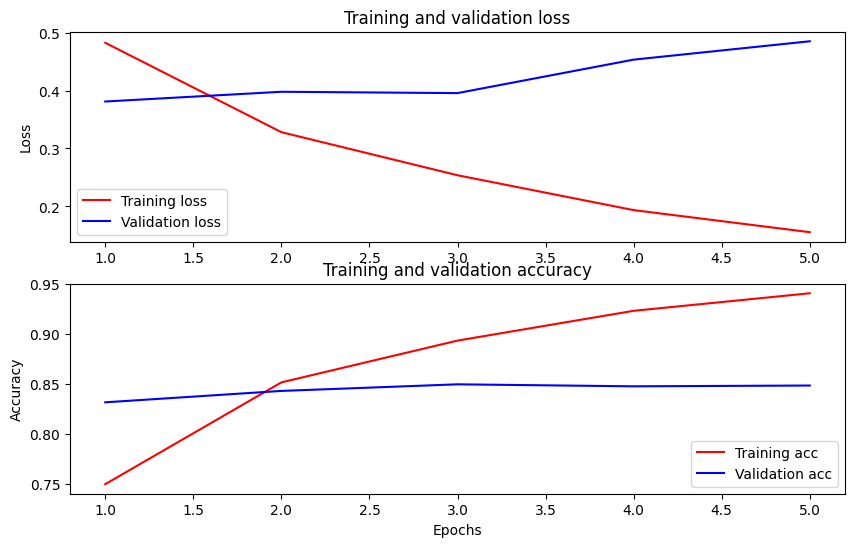

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999777
input: The movie was great!           : score: 0.997405
input: The movie was meh.             : score: 0.798326
input: The movie was okish.           : score: 0.060492
input: The movie was terrible...      : score: 0.001274

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999777
input: The movie was great!           : score: 0.997405
input: The movie was meh.             : score: 0.798326
input: The movie was okish.           : score: 0.060492
input: The movie was terrible...      : score: 0.001274



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999777
input: The movie was great!           : score: 0.997405
input: The movie was meh.             : score: 0.798326
input: The movie was okish.           : score: 0.060492
input: The movie was terrible...      : score: 0.001274



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.